# **GDSCA-2022** GD Survey Data Notebook

## Imports

In [1]:
import os
import sys
import math

import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plot_likert
import seaborn as sns
import PIL
from IPython.display import display, Markdown

%matplotlib inline

## Configuration

In [2]:
single_region = 'Africa'  # name of a single region to run (e.g. 'Oceania'), or False to run all regions

my_dpi = 192
show_plots = True  #show plots inline in notebook, or just save them to disk
output_pngs = True
output_pdfs = True
output_svgs = True
separate_legends = False
matplotlib.rcParams['figure.dpi'] = my_dpi

all_region_list = [
    'Africa',
    'Asia',
    'Europe',
    'Oceania',
    'Americas',
    'Global',
    'Economies',
    'SIDS',
]

region_list = all_region_list
if single_region:
    region_list = [single_region]

constructed_regions = ['Americas', 'Global', 'Economies', 'SIDS']

orderR = {
    'Africa' : [
        'Northern Africa',
        'Western Africa',
        'Middle Africa',
        'Eastern Africa',
        'Southern Africa'
    ],
    'Asia' : [
        'Western Asia',
        'Southern Asia',
        'Eastern Asia',
        'Southeastern Asia'
    ],
    'Europe' : [
        'Northern Europe',
        'Western Europe',
        'Eastern Europe',
        'Southern Europe'
    ],
    'Oceania' : [
        'Micronesia',
        'Melanesia',
        'Polynesia',
        'Australia and New Zealand'
    ],
    'Americas' : [
        'Northern America',
        'Central America',
        'Caribbean',
        'South America'
    ],
    'Global' : [
        'Europe',
        'Asia',
        'Northern America',
        'Africa',
        'Oceania',
        'Latin America and the Caribbean'
    ],
    'Economies': [
        'High income',
        'Upper middle income',
        'Lower middle income',
        'Low income',
        'Not classified'
    ],
    'SIDS': [
        'High income',
        'Upper middle income',
        'Lower middle income',
        'Low income',
        'Not classified'
    ],
}

ignoreR = {
    'Asia' : ['Central Asia']
}

label_adjustments = {  # note: can use /n as a line break if using double quotes
    'Latin America and the Caribbean': 'L Amer & Carib',
    'Northern America': 'N America',
    'Australia and New Zealand': 'Aus & NZ',
    'Upper middle income': 'Upper middle',
    'Lower middle income': 'Lower middle',
}

# override some things if we are being run by the render_figures_and_notebooks.sh script
if 'GDSCA_SINGLE_REGION' in os.environ:
    single_region = os.getenv('GDSCA_SINGLE_REGION') or False
    if single_region:
        region_list = [single_region]
    else:
        region_list = all_region_list

    show_plots = True
    output_pngs = True
    output_pdfs = True
    output_svgs = True
    separate_legends = True

    if 'GDSCA_OUTPUT_IMAGES' in os.environ:
        if os.getenv('GDSCA_OUTPUT_IMAGES'):
            output_pngs = True
            output_pdfs = True
            output_svgs = True
        else:
            output_pngs = False
            output_pdfs = False
            output_svgs = True

    if 'GDSCA_SEPARATE_LEGENDS' in os.environ:
        if os.getenv('GDSCA_SEPARATE_LEGENDS'):
            separate_legends = True
        else:
            separate_legends = False

## Define color palettes

In [3]:
likert = ['white', '#368D95', '#95BABF', '#D4D4D4', '#B6C8AA', '#7EA56B']
cat_02 = ['#194958', '#C6744C', '#D4D4D4']
cat_03 = ['#194958', '#C6744C', '#DBC064', '#D4D4D4']
cat_04 = ['#194958', '#C6744C', '#DBC064', '#368D95', '#D4D4D4']
cat_05 = ['#194958', '#C6744C', '#DBC064', '#368D95', '#3B3C78', '#D4D4D4']
cat_06 = ['#194958', '#C6744C', '#DBC064', '#368D95', '#3B3C78',
          '#7EA56B', '#D4D4D4']
cat_07 = ['#194958', '#C6744C', '#DBC064', '#368D95', '#3B3C78',
          '#7EA56B', '#011B44', '#D4D4D4']
cat_08 = ['#194958', '#C6744C', '#DBC064', '#368D95', '#3B3C78',
          '#7EA56B', '#011B44', '#8A2630', '#D4D4D4']
cat_10 = ['#194958', '#C6744C', '#DBC064', '#368D95', '#3B3C78',
          '#7EA56B', '#011B44', '#8A2630', '#0963A2', '#E09AA7', '#D4D4D4']
val_04 = ['#000D22', '#1F5664', '#3D9FA5', '#CAF1EE']
val_04_rev = ['#CAF1EE', '#3D9FA5', '#1F5664', '#000D22']

val_05 = ['#000d22', '#194958', '#368d95', '#71bdc0', '#caf1ee', '#a2a6a9']
val_05_rev = ['#caf1ee', '#71bdc0', '#368d95', '#194958', '#000d22', '#a2a6a9']
val_06 = ['#000d22', '#143d4d', '#1f5664', '#368d95', '#57afb3', '#caf1ee', '#a2a6a9']
val_06_rev = ['#caf1ee', '#57afb3', '#368d95', '#1f5664', '#143d4d', '#000d22', '#a2a6a9']

sub_americas = ['#08517A', '#759A64', '#08453D', '#2A7976']
sub_europe = ['#4C3375', '#948ED8', '#494C8F', '#302A5A']
sub_africa = ['#FBC762', '#BC8C28', '#FCE393', '#C3A93A', '#927227']
sub_oceania = ['#EC6665', '#B5002B', '#FA9E8E', '#6D0110']
sub_asia = ['#FEB267', '#B05633', '#E68F48', '#873D20']  #, '#FCB8EF'] <- central asia
global_regions = ['#3B3C78', '#C6744C', '#0963A2', '#DBC064', '#8A2630', '#194958']
global_econ_wb = ['#000D22', '#194958', '#368D95', '#8CCDCE', '#A2A6A9']

cat_d23e123_by_region = {
    'Africa': sub_africa,
    'Asia': sub_asia,
    'Europe': sub_europe,
    'Oceania': sub_oceania,
    'Americas': sub_americas,
    'Global': global_regions,
    'Economies': global_econ_wb,
    'SIDS': global_econ_wb
}

## Load data tables

In [4]:
# survey data
data = pd.read_csv('gdsca-2022-data/survey_data.csv', keep_default_na=False)
display(Markdown('**Survey Data**'))
display(data.head())
print(data.shape)

# question table
questions = pd.read_csv('gdsca-2022-data/question_table.csv')
display(Markdown('**Questions**'))
display(questions.head())
print(questions.shape)

# research data
research = pd.read_csv('gdsca-2022-data/research_data.csv')
display(Markdown('**Research Data**'))
display(research.head())
print(research.shape)

# country table
country_table = pd.read_csv('gdsca-2022-data/country_table.csv')
display(Markdown('**Country Data**'))
display(country_table.head())
print(country_table.shape)

**Survey Data**

language  respondent_id col_name selection selection_survey_clean question  \
0       EN    12906633394       Q1   Albania                              Q1   
1       FR    12850123626       Q1   Algeria                              Q1   
2       FR    13204231228       Q1   Algeria                              Q1   
3       FR    13204803692       Q1   Algeria                              Q1   
4       FR    13212618824       Q1   Algeria                              Q1   

  question_type selection_other age  country  ... degree degree_other sector  \
0      choose-1         Albania      Albania  ...                              
1      choose-1         Algeria      Algeria  ...                              
2      choose-1         Algeria      Algeria  ...                              
3      choose-1         Algeria      Algeria  ...                              
4      choose-1         Algeria      Algeria  ...                              

  sector_other  region        subregion  geoarea sids economy_sids  \
0               Europe  Southern Europe  Albania         Developed   
1               Africa  Northern Africa  Algeria        Developing   
2               Africa  Northern Africa  Algeria        Developing   
3               Africa  Northern Africa  Algeria        Developing   
4               Africa  Northern Africa  Algeria        Developing   

       income_group_wb  
0  Upper middle income  
1  Lower middle income  
2  Lower middle income  
3  Lower middle income  
4  Lower middle income  

[5 rows x 24 columns]

(64080, 24)


**Questions**

col_name question question_type  \
0                Q1       Q1      choose-1   
1          Q1_other       Q1      choose-1   
2                Q2       Q2      choose-1   
3          Q2_other       Q2      choose-1   
4  Q3_basic_science       Q3      choose-3   

                                                text  
0  Which country would you like to represent for ...  
1  Which country would you like to represent for ...  
2  The country/nation identified in the previous ...  
3  The country/nation identified in the previous ...  
4  What are the 3 most important deep sea issues ...

(178, 4)


**Research Data**

geoarea researcher              col_name question  \
0  Albania    Baldwin                 notes    notes   
1  Albania    Baldwin          Q10_comments      Q10   
2  Albania    Baldwin            Q10_mining      Q10   
3  Albania    Baldwin  Q10_renewable_energy      Q10   
4  Albania    Baldwin          Q10_research      Q10   

                                           selection  region        subregion  \
0  Plan to boost blue ecoNomy 2018  https://www.a...  Europe  Southern Europe   
1  10b Albania have joined the moratorium on deep...  Europe  Southern Europe   
2                                             No [A]  Europe  Southern Europe   
3                                             No [A]  Europe  Southern Europe   
4                                             No [A]  Europe  Southern Europe   

  sids economy_sids      income_group_wb  ...   [FR]   [AR]   [SP]   [PT]  \
0  NaN    Developed  Upper middle income  ...  FALSE  FALSE  FALSE  FALSE   
1  NaN    Developed  Upper middle income  ...  FALSE  FALSE  FALSE  FALSE   
2  NaN    Developed  Upper middle income  ...  FALSE  FALSE  FALSE  FALSE   
3  NaN    Developed  Upper middle income  ...  FALSE  FALSE  FALSE  FALSE   
4  NaN    Developed  Upper middle income  ...  FALSE  FALSE  FALSE  FALSE   

    [BD] research_tech research_tech_clean research_CID research_org  \
0  FALSE             0                   0          NaN          NaN   
1  FALSE             0                   0          NaN          NaN   
2  FALSE             0                   0          NaN          NaN   
3  FALSE             0                   0          NaN          NaN   
4  FALSE             0                   0          NaN          NaN   

  research_org_clean  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  

[5 rows x 33 columns]

(10415, 33)


**Country Data**

geoarea     status  region        subregion  \
0      Bassas da India  Territory  Africa   Eastern Africa   
1               Crozet  Territory  Africa  Southern Africa   
2        Europa Island  Territory  Africa   Eastern Africa   
3    Glorieuse Islands  Territory  Africa   Eastern Africa   
4  Juan de Nova Island  Territory  Africa   Eastern Africa   

                  geoarea_esri iso-alpha3       economy sids  economy_sids  \
0  French Southern Territories        ATF  Unclassified  NaN  Unclassified   
1  French Southern Territories        ATF  Unclassified  NaN  Unclassified   
2  French Southern Territories        ATF  Unclassified  NaN  Unclassified   
3             Glorioso Islands        ATF  Unclassified  NaN  Unclassified   
4          Juan De Nova Island        ATF  Unclassified  NaN  Unclassified   

   un_region_code  ... dsc-ai-vessel  dsc-ai-dsv dsc-ai-sensor  dsc-ai-data  \
0             NaN  ...           NaN         NaN           NaN          NaN   
1             NaN  ...           NaN         NaN           NaN          NaN   
2             NaN  ...           NaN         NaN           NaN          NaN   
3             NaN  ...           NaN         NaN           NaN          NaN   
4             NaN  ...           NaN         NaN           NaN          NaN   

  dsc-si-all dsc-si-vessel  dsc-si-dsv  dsc-si-sensor dsc-si-data  \
0        NaN           NaN         NaN            NaN         NaN   
1        NaN           NaN         NaN            NaN         NaN   
2        NaN           NaN         NaN            NaN         NaN   
3        NaN           NaN         NaN            NaN         NaN   
4        NaN           NaN         NaN            NaN         NaN   

   dsc-index-group  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  

[5 rows x 83 columns]

(259, 83)


## Subset data into regions

In [5]:
# read R as "by region"
dataR           = {}
researchR       = {}
country_tableR  = {}

for region in all_region_list:
    if region in constructed_regions:
        continue  # these are specially constructed below
    dataR[region]          = data[data['region'] == region].copy()
    researchR[region]      = research[research['region'] == region].copy()
    country_tableR[region] = country_table[country_table['region'] == region].copy()
    country_tableR[region]['subregion_orig'] = country_tableR[region]['subregion']

if 'Americas' in all_region_list:
    region = 'Americas'
    dataR[region]          = data[data['subregion'].isin(orderR[region])]
    researchR[region]      = research[research['subregion'].isin(orderR[region])]
    country_tableR[region] = country_table[country_table['subregion'].isin(orderR[region])].copy()
    country_tableR[region]['subregion_orig'] = country_tableR[region]['subregion']

if 'Global' in all_region_list:
    region = 'Global'
    dataR[region]          = data[data['region'].isin(orderR[region])]
    researchR[region]      = research[research['region'].isin(orderR[region])]
    country_tableR[region] = country_table[country_table['region'].isin(orderR[region])]
    dataR[region]['subregion']          = dataR[region]['region']
    researchR[region]['subregion']      = researchR[region]['region']
    country_tableR[region]['subregion_orig'] = country_tableR[region]['subregion']
    country_tableR[region]['subregion'] = country_tableR[region]['region']

if 'Economies' in all_region_list:
    region = 'Economies'
    dataR[region]          = data[data['income_group_wb'].isin(orderR[region])]
    researchR[region]      = research[research['income_group_wb'].isin(orderR[region])]
    country_tableR[region] = country_table[country_table['income_group_wb'].isin(orderR[region])]
    dataR[region]['subregion']          = dataR[region]['income_group_wb']
    researchR[region]['subregion']      = researchR[region]['income_group_wb']
    country_tableR[region]['subregion_orig'] = country_tableR[region]['subregion']
    country_tableR[region]['subregion'] = country_tableR[region]['income_group_wb']

if 'SIDS' in all_region_list:
    region = 'SIDS'
    dataR[region]          = data[data['income_group_wb'].isin(orderR[region])].copy()
    dataR[region]          = dataR[region][dataR[region]['economy_sids'] == 'SIDS']
    researchR[region]      = research[research['income_group_wb'].isin(orderR[region]) & (research['economy_sids'] == 'SIDS')].copy()
    country_tableR[region] = country_table[country_table['income_group_wb'].isin(orderR[region]) & (country_table['economy_sids'] == 'SIDS')].copy()
    dataR[region]['subregion']          = dataR[region]['income_group_wb']
    researchR[region]['subregion']      = researchR[region]['income_group_wb']
    country_tableR[region]['subregion_orig'] = country_tableR[region]['subregion'].copy()
    country_tableR[region]['subregion'] = country_tableR[region]['income_group_wb']

# some required country cleanup
for region in all_region_list:
    ## change np.nan in economy column to 'NA'
    country_tableR[region].loc[country_tableR[region]['subregion'].isna() == True, 'subregion'] = 'NA'

    ## create ocean column
    country_tableR[region]['ocean'] = 'No Ocean'
    country_tableR[region].loc[(country_tableR[region]['total_eez_area'].isna() == False) &
                     (country_tableR[region]['total_eez_area'] > 0), 'ocean'] = 'EEZ with no Deep Ocean'
    country_tableR[region].loc[(country_tableR[region]['eez_deeper_than_200'].isna() == False) &
                     (country_tableR[region]['eez_deeper_than_200'] > 0), 'ocean'] = 'EEZ with Deep Ocean'

## Helper functions

In [6]:
def prep_fig_data_for_plotting(fig_data, region, axis='index', barh=False, order=False):
    if not order:
        order = orderR[region]
    if barh:
        order = list(reversed(order))

    if axis in [0, 'index']:
        fig_data = reorder_rows_and_rename(fig_data, order, createmissingrows=True)
    elif axis in [1, 'columns']:
        fig_data = reorder_columns(fig_data, order, createmissingcolumns=True)
    else:
        raise ValueError('unknown axis argument:', axis)
    fig_data = adjust_labels_to_fit(fig_data, axis=axis)
        
    return fig_data

def adjust_labels_to_fit(fig_data, axis='index'):
    fig_data.rename(label_adjustments, axis=axis, inplace=True)
    return fig_data

def undo_label_adjustment(label):
    if label in label_adjustments.values():
        reverse_label_adjustments = dict(zip(label_adjustments.values(), label_adjustments.keys()))
        orig_label = reverse_label_adjustments[label]
    else:
        orig_label = label
    return orig_label

def reorder_rows_and_rename(df, order_and_names, warnonly=False, createmissingrows=False, ignorerows=None):
    newdf = df.copy()
    order = []

    for index in df.index:
        found = False
        for name in order_and_names:
            if not isinstance(name, list):
                name = [name]
            if index == name[0]:
                found = True
                break
        if not found:
            if ignorerows and name not in ignorerows:
                errmsg = 'row found with index "'+index+'" that is not in order list'
                if not warnonly:
                    raise ValueError(errmsg)
                else:
                    print('warning: '+errmsg, file=sys.stderr)

    for name in order_and_names:
        if not isinstance(name, list):
            name = [name]
        if (not name[0] in newdf.index):
            if createmissingrows:
                print('Adding missing row '+name[0])
                newvalues = pd.Series([]*(newdf.shape[1]-1), name=name[0], dtype='float64')
                newrow = pd.DataFrame([newvalues], columns=df.columns)
                newdf = pd.concat([newdf, newrow])
            else:
                errmsg = 'row index name "' + name[0] +'" not found'
                if not warnonly:
                    raise ValueError(errmsg)
                else:
                    print('warning: '+errmsg, file=sys.stderr)
        if len(name) == 2:
            newdf.rename(index={name[0]: name[1]}, inplace=True)
            order.append(name[1])
        else:
            order.append(name[0])
    return newdf.reindex(order)

def reorder_columns(df, columnorder, createmissingcolumns=False, warnonly=False):
    newdf = df.copy()
    for column in newdf.columns:
        if column not in columnorder:
            errmsg = 'found column with name "'+column+'" that is not in order list'
            if not warnonly:
                raise ValueError(errmsg)
            else:
                print('warning: '+errmsg, file=sys.stderr)
            
    for column in columnorder:
        if not column in newdf.columns:
            if createmissingcolumns:
                print('Adding missing column '+column)
                newdf[column] = np.nan
            else:
                errmsg = 'column "'+column+'" not found'
                if not warnonly:
                    raise ValueError(errmsg)
                else:
                    print('warning: '+errmsg, file=sys.stderr)
    newdf = newdf[columnorder]
    return newdf        

def barh_pixel_fix(ax):
    # bump all the bars in a barh graph over one pixel to the left
    # to close a slight gap between the base of the bar and the
    # y-axis that appears when you use edgecolor='white'
    for container in ax.containers:
        for rectangle in container:
            rectangle.set_x(rectangle.get_x()-0.05)

def loc_tweaker(region, loc_tweaks, letter=False):
    for key in loc_tweaks.keys():
        if not key in all_region_list:
            raise ValueError('unknown region '+key)
    loc = 'best'
    if 'default' in loc_tweaks:
        loc = loc_tweaks['default']
    if region in loc_tweaks:
        loc = loc_tweaks[region]
    return loc

def notTotalRow(df):
    not_total = []
    for rowname in df.index.values.tolist():
        not_total.append(rowname != 'Total')
    return not_total

def compute_totals_table(fig_data):
    totals_table = fig_data.copy()
    totals_table.loc['Total'] = totals_table.sum()
    total = totals_table.loc['Total'].sum()
    totals_table['Total'] = totals_table.loc[:,:].sum(axis=1)
    totals_table = totals_table.fillna(0)
    return totals_table, total

def compute_percents_table(fig_data, total):
    copy_data = fig_data.copy()
    copy_data['Total'] = copy_data.loc[:, :].sum(axis=1)
    percents_table = pd.concat([round((copy_data/copy_data.sum())*100, 1)])
    new_column_names = []
    for column in percents_table.columns:
        new_column_names.append('% '+column)
    percents_table.columns = new_column_names
    
    percents_table['% Total'] = round((copy_data['Total']/total)*100, 1)
    percents_table.loc['% Total'] = percents_table.sum().round()

    percents_table = percents_table.fillna(0)
    return percents_table

def show_totals(fig_data, total=None):
    totals_table, tt_total = compute_totals_table(fig_data)
    display(totals_table)

def my_plot_likert(fig_data, my_scale, figsize):
    # do some crude auto scaling of the xticks
    xtick_interval=1
    ax = plot_likert.plot_likert(fig_data, 
                                 my_scale,
                                 figsize=figsize,
                                 colors=likert,
                                 xtick_interval=xtick_interval)
    xtick_count = len(ax.get_xticklabels())
    if xtick_count > 10:
        xtick_interval = 2
    if xtick_count > 20:
        xtick_interval = 5
    if xtick_count > 40:
        xtick_interval = 10
    if xtick_count > 100:
        xtick_interval = 20
    if xtick_count > 200:
        xtick_interval = 40
    if xtick_count > 500:
        xtick_interval = 50
    plt.close()
    
    # start again with new interval
    ax = plot_likert.plot_likert(fig_data, 
                                 my_scale,
                                 figsize=figsize,
                                 colors=likert,
                                 xtick_interval=xtick_interval)
    return ax    

def assemble_filename_and_mkdir(region, format, letter, modifier=False, cropped=False):
    save_path = os.path.join('figures', region, format)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    filename = os.path.join(save_path, region+'_'+letter)
    if modifier:
        filename += modifier
    if cropped:
        filename += '_cropped'
    filename += '.'+format
    return filename

def savefigs(plt, region, letter, modifier=False, alsocropped=False):
    if not output_pngs and not output_pdfs and not output_svgs:
        return
    if output_pngs:
        filename = assemble_filename_and_mkdir(region, 'png', letter, modifier)
        plt.savefig(filename,
                #facecolor='white',
                transparent=True,
                dpi=my_dpi,
                bbox_inches='tight')

        if alsocropped:
            image = PIL.Image.open(filename)
            imageBox = image.getbbox()
            cropped = image.crop(imageBox)
            filename = assemble_filename_and_mkdir(region, 'png', letter, modifier, cropped=True)
            cropped.save(filename)

    if output_pdfs:
        filename = assemble_filename_and_mkdir(region, 'pdf', letter, modifier)
        plt.savefig(filename,
                #facecolor='white',
                transparent=True,
                dpi=my_dpi,
                bbox_inches='tight')
    
    if output_svgs:
        filename = assemble_filename_and_mkdir(region, 'svg', letter, modifier)
        plt.savefig(filename,
                #facecolor='white',
                transparent=True,
                dpi=my_dpi,
                bbox_inches='tight')

def outputfigs(plt, fig, ax, region, section, letter):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if not fig:
        ax.spines['left'].set_visible(False)
        ax.tick_params(axis="y", left=False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.legend.Legend):
            child.get_frame().set_linewidth(0.0)
            #child.get_frame().set_edgecolor('white')

    savefigs(plt, region, letter)
    
    if separate_legends:
        for child in ax.get_children():
            if not child.get_visible:
                print('warning: figure had non-visible artists and will probably not render correctly in the notebook', file=sys.stderr)
            if isinstance(child, matplotlib.legend.Legend):
                child.set_visible(False)

        savefigs(plt, region, letter, '_plain')

        for child in ax.get_children():
            if isinstance(child, matplotlib.legend.Legend):
                child.set_visible(True)
            else:
                child.set_visible(False)

        savefigs(plt, region, letter, '_legend', alsocropped=True)
        
        for child in ax.get_children():
            child.set_visible(True)
        # it seems we need to do this again here??
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if not fig:
            ax.spines['left'].set_visible(False)
            ax.tick_params(axis="y", left=False)

    if show_plots: plt.show()
    #if show_plots: display(fig)
    plt.close()

---
# **Section 1**&nbsp; Country Ref

## **Fig B1**&nbsp; Country Ref: status

In [7]:
## Calculate values for plot

fig_data = {}
for region in region_list:
    fig_data[region] = (country_tableR[region][['geoarea', 'subregion', 'status']].groupby(['subregion', 'status'])
                                                  .count()
                                                  .rename(columns={'geoarea': 'count'})
                                                  .reset_index()
                                                  .pivot(columns='status',
                                                         index='subregion',
                                                         values='count'))


    fig_data[region].rename({
        'Sovereign': 'Sovereign Country',
        'Territory': 'Dependent Territory'},
        axis=1,
        inplace=True)
    columnorder = [
        'Sovereign Country',
        'Dependent Territory'
    ]
    fig_data[region] = reorder_columns(fig_data[region], columnorder, createmissingcolumns=True)
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, barh=True)

    # Add total
    fig_debug = fig_data[region].copy()
    fig_debug.loc['Total'] = fig_debug.sum()

    #display(fig_debug)

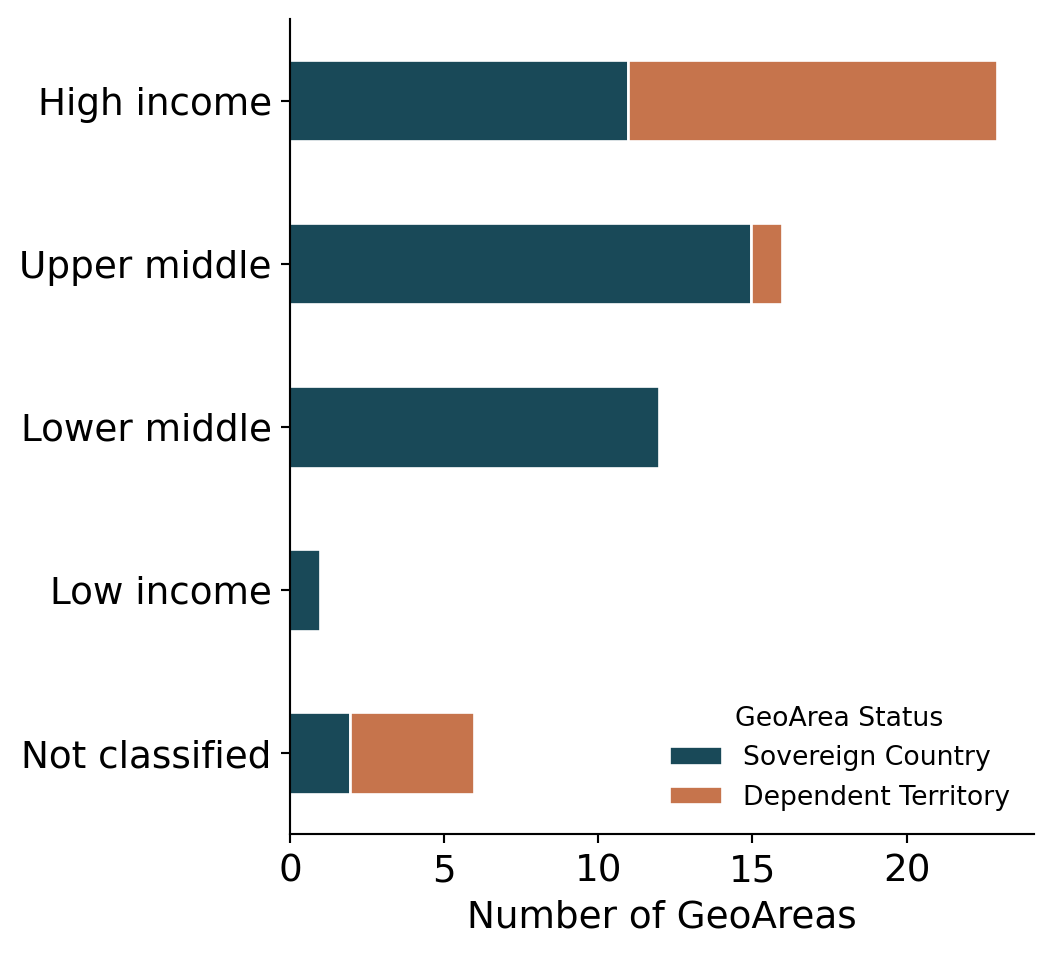

In [8]:
## Create horizontal bar plot

w = 960
h = 1080

figs = []
outs = []
for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)

    fig_data[region].plot(kind='barh', 
              stacked=True,
              legend=True,
              fontsize=14,
              color=cat_03,
              edgecolor='white',
              ax=ax)
    ax.set_xlabel('Number of GeoAreas', fontsize=14)
    plt.locator_params(axis='x', integer=True)
    barh_pixel_fix(ax)
    ax.set_ylabel('')
    loc_tweaks = {'Africa': 'upper right', 'Oceania': 'lower right', 'SIDS': 'lower right'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='GeoArea Status',
              fontsize=10,
              title_fontsize=10)
    
    outputfigs(plt, fig, ax, region, section='1', letter='B1')

## **Fig B3**&nbsp; Country Ref: economies

In [9]:
## Calculate values for plot

fig_data = {}
for region in region_list:
    fig_data[region] = (country_tableR[region][['geoarea', 'subregion', 'income_group_wb']].groupby(['subregion', 'income_group_wb'])
                                                                   .count()
                                                                   .rename(columns={'geoarea': 'count'})
                                                                   .reset_index()
                                                                   .pivot(columns='income_group_wb',
                                                                          index='subregion',
                                                                          values='count'))

    column_order = [
        'High income',
        'Upper middle income',
        'Lower middle income',
        'Low income',
        'Not classified',
    ]
    fig_data[region] = reorder_columns(fig_data[region], column_order, createmissingcolumns=True)
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, barh=True)

    #show_totals(fig_data[region])

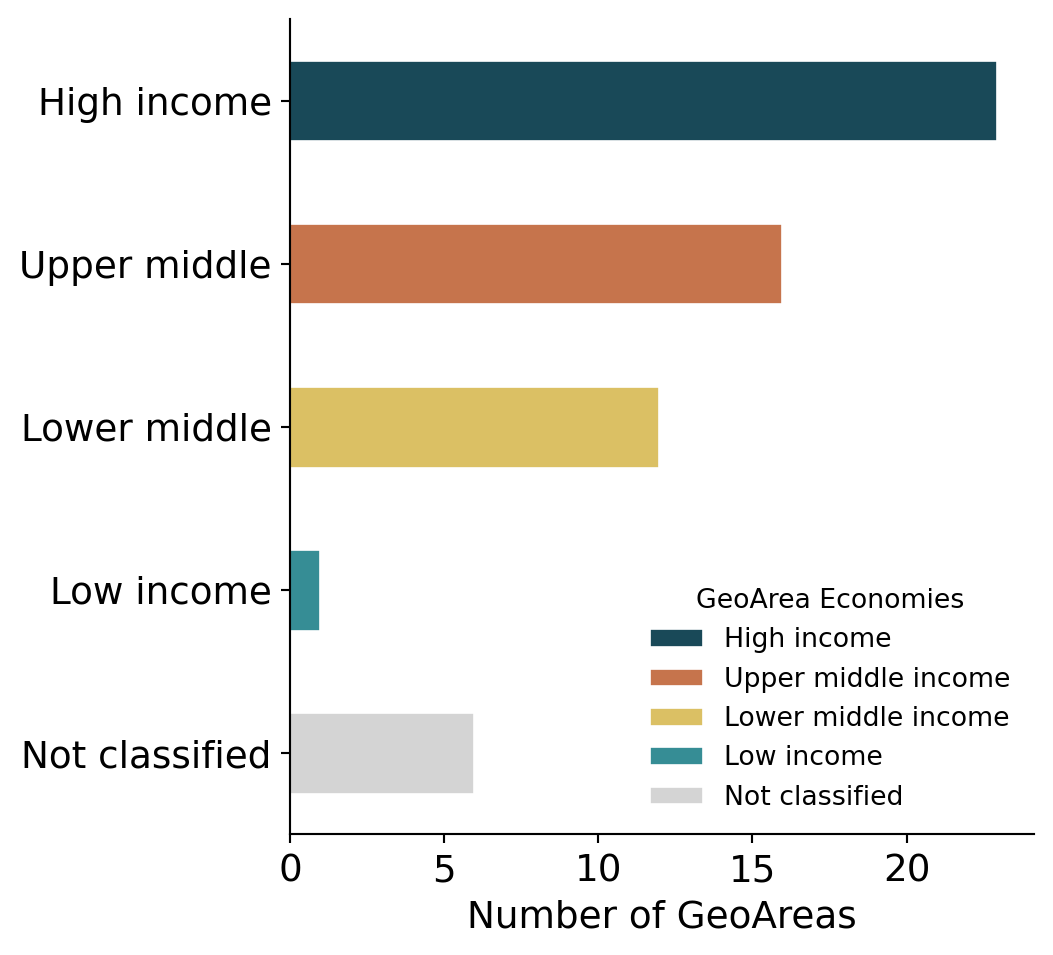

In [10]:
## Create horizontal bar plot 

w = 960
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)

    fig_data[region].plot(kind='barh', 
              stacked=True,
              legend=True,
              fontsize=14,
              color=cat_04,
              edgecolor='white',
              ax=ax)
    ax.set_xlabel('Number of GeoAreas', fontsize=14)
    plt.locator_params(axis='x', integer=True)
    barh_pixel_fix(ax)
    ax.set_ylabel('')
    loc_tweaks = {'Africa': 'upper right', 'Oceania': 'lower right', 'SIDS': 'lower right'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks), 
          title='GeoArea Economies', 
          fontsize=10, 
          title_fontsize=10)
    
    outputfigs(plt, fig, ax, region, section='1', letter='B2')

In [11]:
## Calculate fig data

fig_data = {}
for region in region_list:
    fig_data[region] = (country_tableR[region]
                .groupby('subregion')[['survey_research','survey_alone','research_alone','no_data']]
                .sum()
                .reset_index())

    # Change subregion to index
    fig_data[region].set_index('subregion', inplace=True)

    fig_data[region].rename(
        {'survey_research': 'Survey & Research',
         'survey_alone':    'Survey Only',
         'research_alone':  'Research Only',
         'no_data':         'No Data'
        },
        axis=1,
        inplace=True
    )
    columnorder = [
        'Survey & Research',
        'Survey Only',
        'Research Only',
        'No Data'
    ]
    fig_data[region] = reorder_columns(fig_data[region], columnorder, createmissingcolumns=True)
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region)

    #show_totals(fig_data[region])

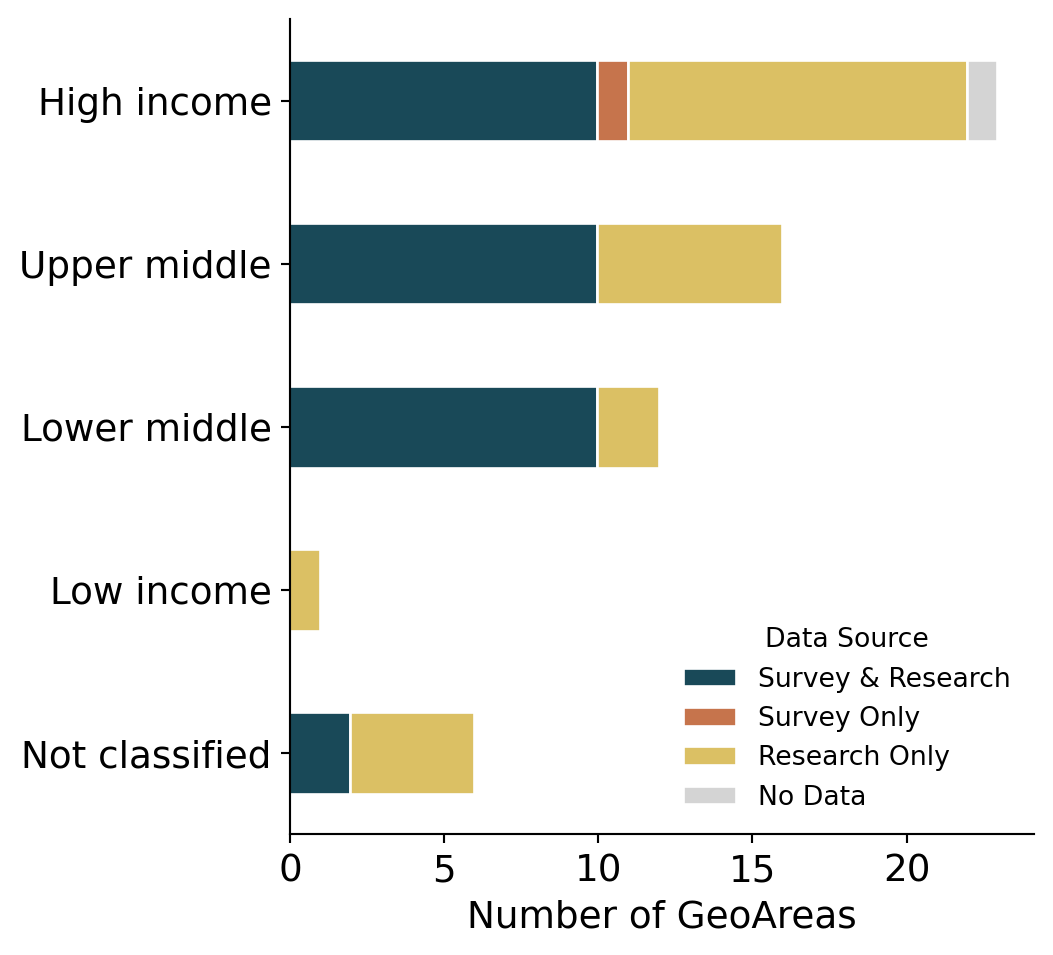

In [12]:
## Plot figure

w = 960
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)

    fig_data[region].loc[notTotalRow(fig_data[region]), :].iloc[::-1].plot(kind='barh', 
              stacked=True,
              fontsize=14,
              color=cat_03,
              edgecolor='white',
              ax=ax)
    ax.set_xlabel('Number of GeoAreas', fontsize=14)
    ax.set_ylabel('')
    plt.locator_params(axis='x', integer=True)
    barh_pixel_fix(ax)

    loc_tweaks = {'Africa': 'upper right', 'Oceania': 'lower right', 'SIDS': 'lower right'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
          title='Data Source', 
          fontsize=10, 
          title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='1', letter='B3')

## **Fig C1**&nbsp; Q1 & Research: Country representation

In [13]:
## Calculate values for plot

fig_data = {}
for region in region_list:
    fig_data[region] = (country_tableR[region][['geoarea', 'subregion', 'ocean']].groupby(['subregion', 'ocean'])
                                                            .count()
                                                            .rename(columns={'geoarea': 'count'})
                                                            .reset_index()
                                                            .pivot(columns='ocean',
                                                                   index='subregion',
                                                                   values='count'))

    fig_data[region].rename({
        'EEZ with Deep Ocean': 'EEZ with >1% deep ocean',
        'EEZ with no Deep Ocean': 'EEZ with <1% deep ocean',
        'No Ocean': 'No marine EEZ'},
        axis=1,
        inplace=True)
    columnorder = [
        'EEZ with >1% deep ocean',
        'EEZ with <1% deep ocean',
        'No marine EEZ'
    ]
    fig_data[region] = reorder_columns(fig_data[region], columnorder, createmissingcolumns=True)
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region)

    #display(fig_data[region])
    #show_totals(fig_data[region])

Adding missing column No marine EEZ


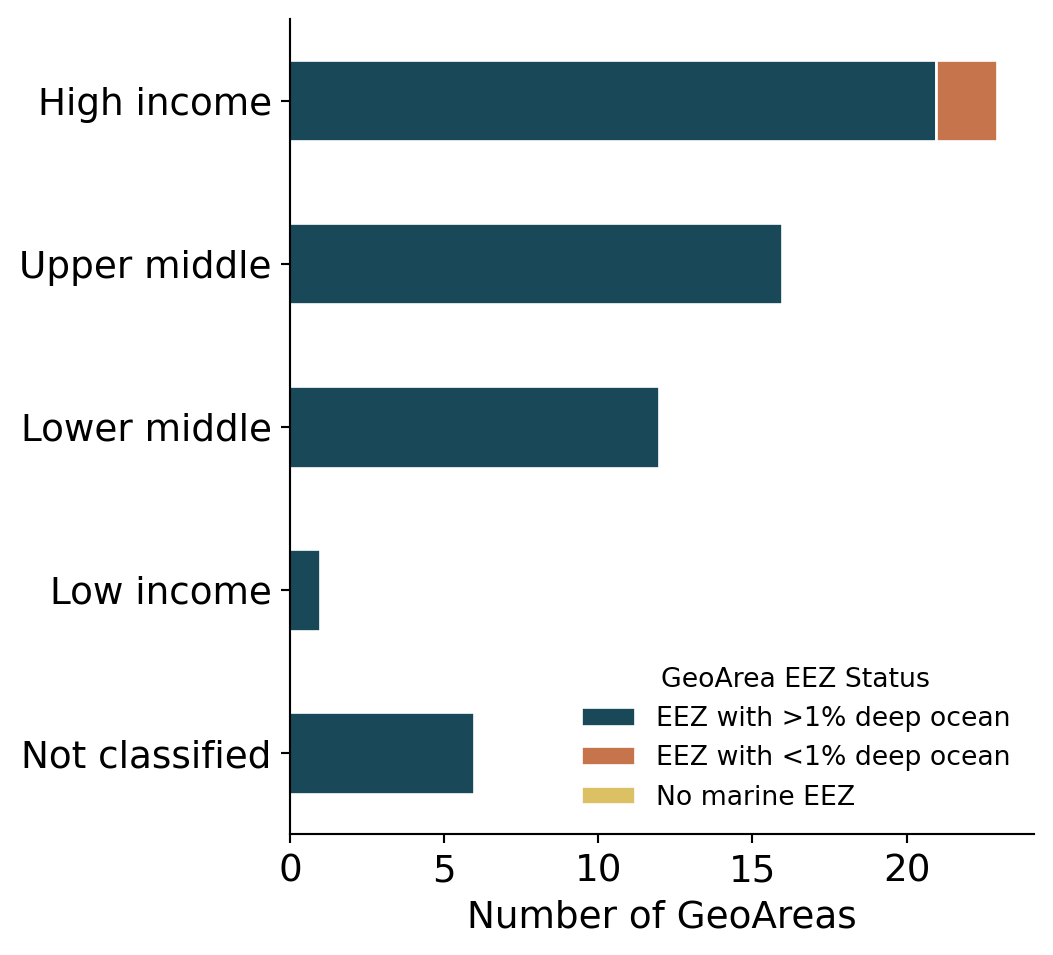

In [14]:
## Create horizontal bar plot 

w = 960
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)

    fig_data[region].iloc[::-1].plot(kind='barh', 
              stacked=True,
              legend=True,
              fontsize=14,
              color=cat_03,
              edgecolor='white',
              ax=ax)
    ax.set_xlabel('Number of GeoAreas', fontsize=14)
    ax.set_ylabel('')
    plt.locator_params(axis='x', integer=True)
    barh_pixel_fix(ax)

    loc_tweaks = {'Africa': 'upper right', 'Oceania': 'lower right', 'SIDS': 'lower right'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks), 
              title='GeoArea EEZ Status', 
              fontsize=10, 
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='1', letter='C1')

## **Fig C2**&nbsp; Country Ref: EEZ depth zones

In [15]:
## Calculate values for plot

cols = ['geoarea', 
        'subregion', 
        'eez_area_0_to_200m', 
        'eez_area_200_to_1000m', 
        'eez_area_1000_to_2000m',
        'eez_area_2000_to_4000m', 
        'eez_area_4000_to_6000m', 
        'eez_area_deeper_than_6000m']

fig_data = {}
for region in region_list:
    fig_data[region] = (country_tableR[region][cols].groupby(['subregion'])
                                  .sum())

    # Rename columns
    fig_data[region].columns = ['200 m', '1000 m', '2000 m', '4000 m', '6000 m', '6000+ m']

    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region)

    # Sort depths as Katy specified
    sorted_cols = ['6000+ m', '6000 m', '4000 m', '2000 m', '1000 m', '200 m']
    fig_data[region] = fig_data[region][sorted_cols]

    # Add 200+
    fig_data[region]['200 m +'] = fig_data[region].loc[:, '6000+ m':'1000 m'].sum(axis=1)

    # Add total
    fig_data[region]['Total'] = (country_tableR[region][['geoarea', 'subregion', 'total_eez_area']]
                         .groupby('subregion')['total_eez_area']
                         .sum())
    fig_data[region].loc['Total'] = fig_data[region].sum()

    #display(fig_data[region])

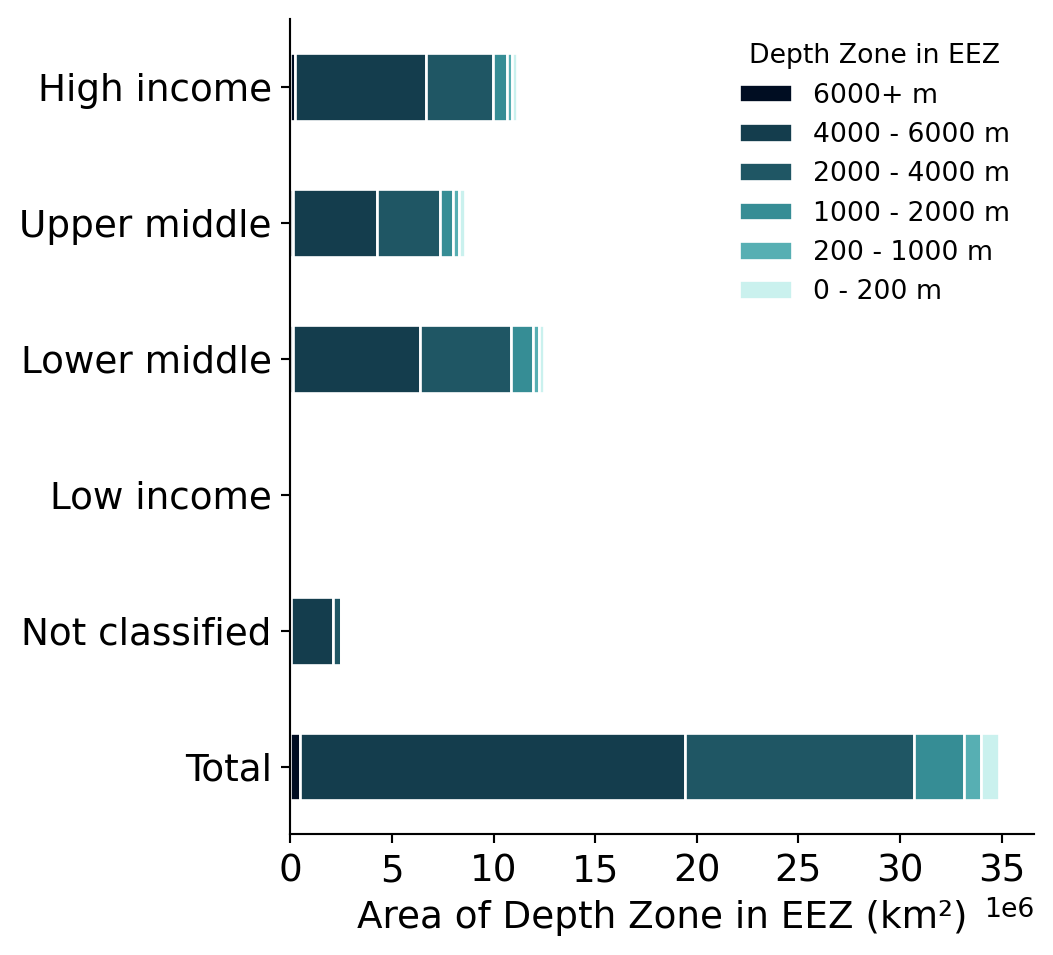

In [16]:
## Create plot

w = 960
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)

    fig_data[region].iloc[::-1].loc[:, '6000+ m':'200 m'].plot(kind='barh', 
              stacked=True,
              legend=True,
              fontsize=14,
              color=val_06,
              edgecolor='white',
              ax=ax)
    barh_pixel_fix(ax)
    ax.set_xlabel('Area of Depth Zone in EEZ (km²)', fontsize=14)
    ax.set_ylabel('')

    ax.ticklabel_format(axis='x', style='sci', scilimits=(6, 6))
    loc = matplotlib.ticker.MultipleLocator(base=5000000)
    ax.xaxis.set_major_locator(loc)
    xtick_count = len(ax.get_xticklabels())
    if xtick_count < 5:
        loc = matplotlib.ticker.MultipleLocator(base=1000000)
        ax.xaxis.set_major_locator(loc)
    elif xtick_count < 6:
        loc = matplotlib.ticker.MultipleLocator(base=2000000)
        ax.xaxis.set_major_locator(loc)

    loc_tweaks = {}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
          labels=['6000+ m',
                  '4000 - 6000 m',
                  '2000 - 4000 m',
                  '1000 - 2000 m',
                  '200 - 1000 m',
                  '0 - 200 m'], 
          title='Depth Zone in EEZ', 
          fontsize=10, 
          title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='1', letter='C2')

## **Fig C3**

In [17]:
## Calculate values for plot

renames = {
    'eez_area_0_to_200m':         '0 - 200', 
    'eez_area_200_to_1000m':      '200 - 1000', 
    'eez_area_1000_to_2000m':     '1000 - 2000',
    'eez_area_2000_to_4000m':     '2000 - 4000', 
    'eez_area_4000_to_6000m':     '4000 - 6000', 
    'eez_area_deeper_than_6000m': '6000+'
}
cols = list(renames.keys())

fig_data = {}
for region in region_list:
    fig_data[region] = (country_tableR[region][cols]
                                  .sum())
    # Rename columns
    fig_data[region] = fig_data[region].rename(index=renames)

    #display(fig_data[region])

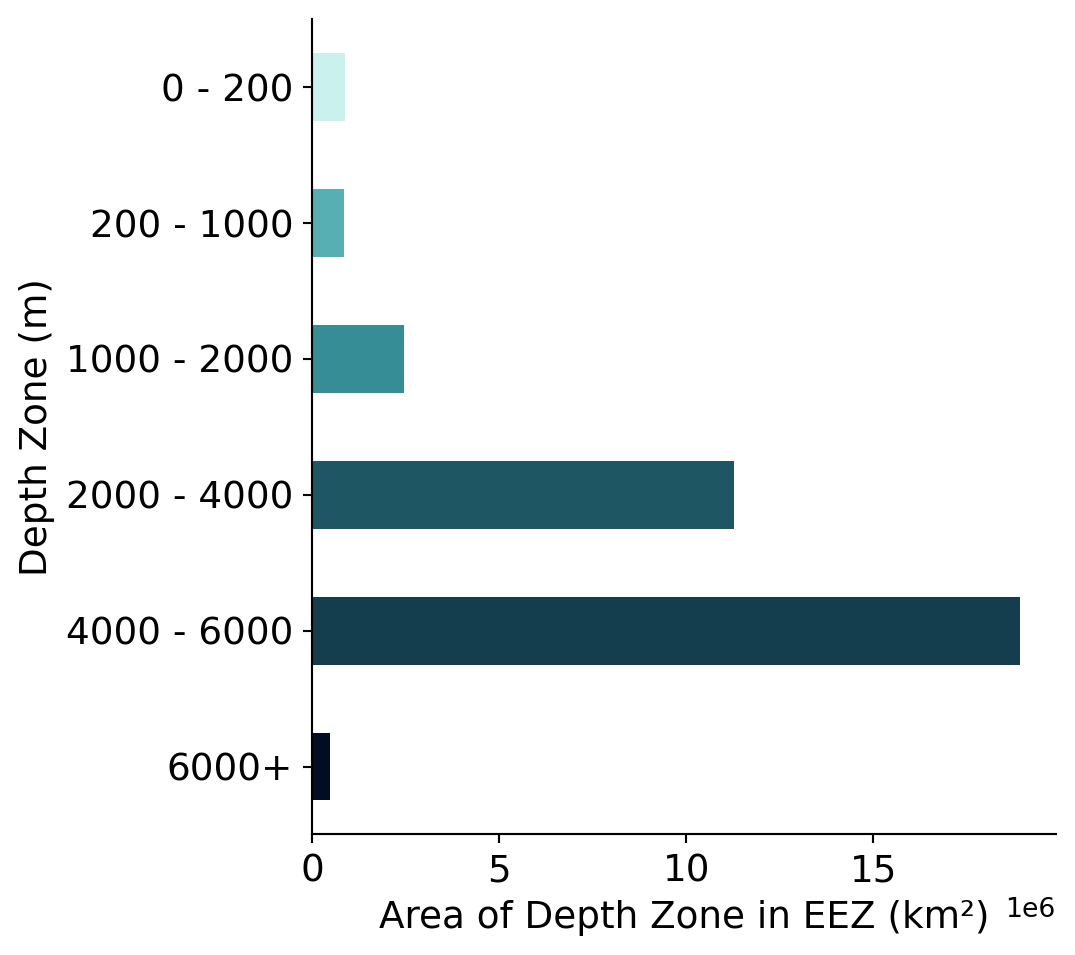

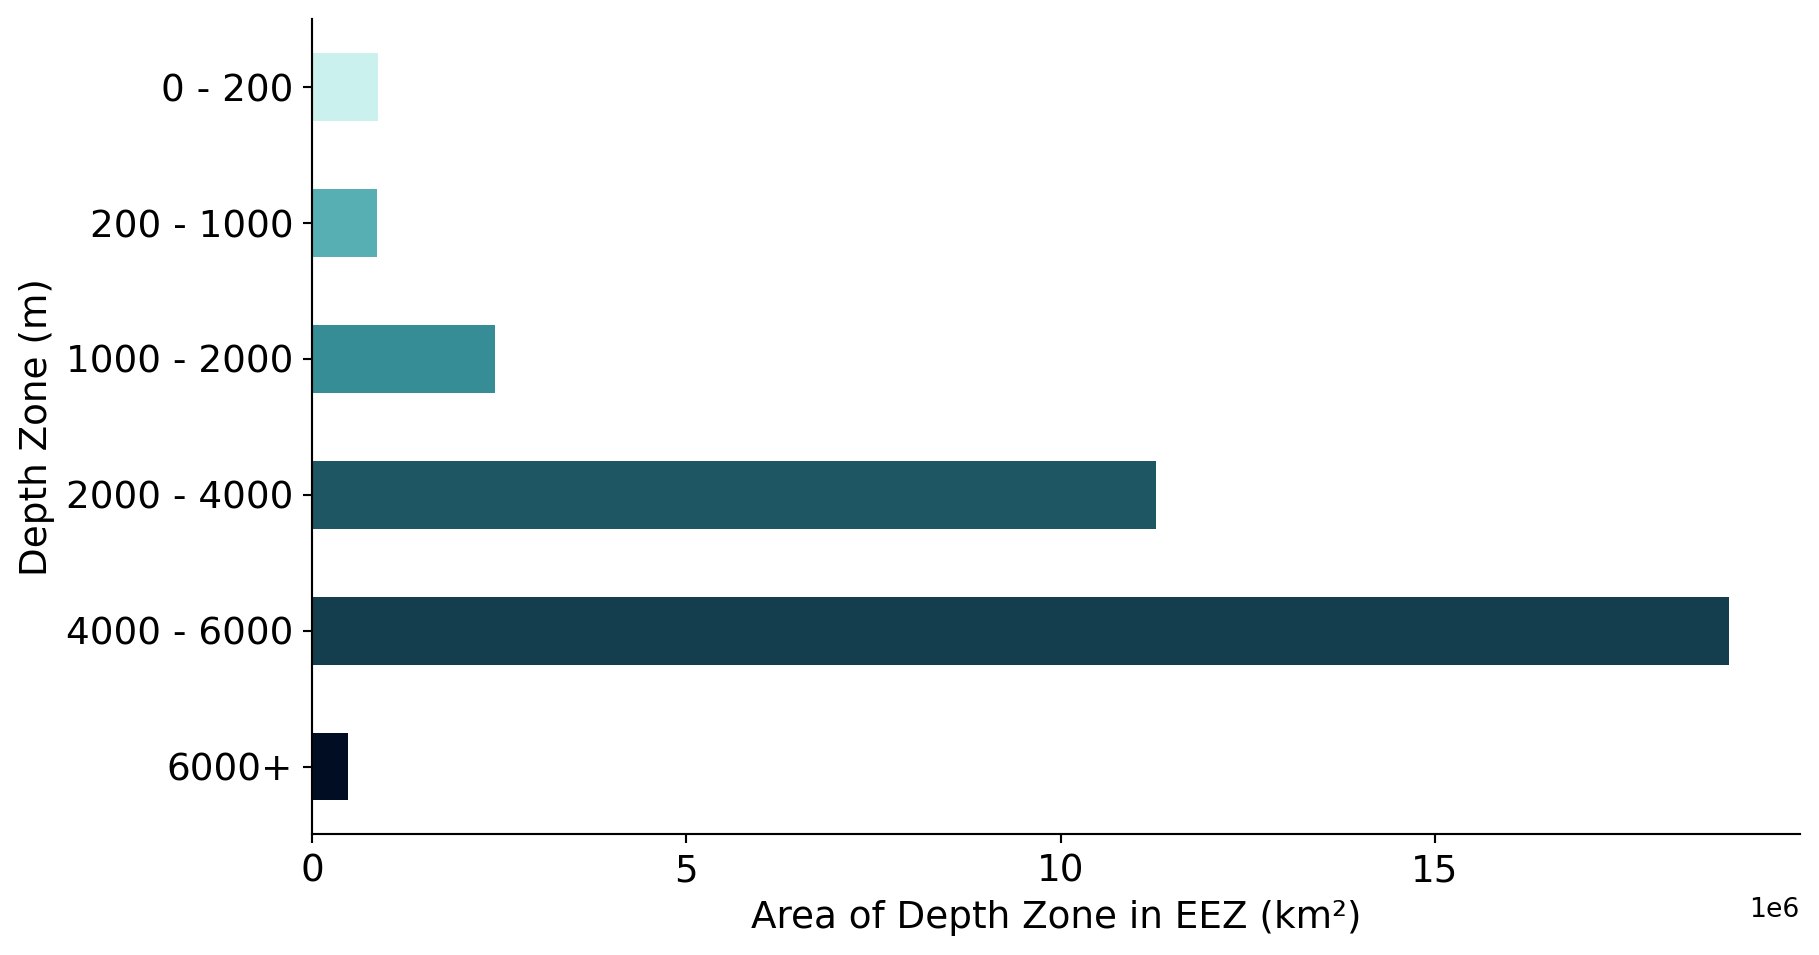

In [18]:
## Create plots

for region in region_list:
    w = 960
    h = 1080
    
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)

    fig_data[region].iloc[::-1].plot(kind='barh', 
              fontsize=14,
              color=val_06,
              ax=ax)
    ax.set_xlabel('Area of Depth Zone in EEZ (km²)', fontsize=14)
    ax.set_ylabel('Depth Zone (m)', fontsize=14)

    ax.ticklabel_format(axis='x', style='sci', scilimits=(6, 6))
    loc = matplotlib.ticker.MultipleLocator(base=5000000)
    ax.xaxis.set_major_locator(loc)
    xtick_count = len(ax.get_xticklabels())
    if xtick_count < 5:
        loc = matplotlib.ticker.MultipleLocator(base=1000000)
        ax.xaxis.set_major_locator(loc)
    elif xtick_count < 6:
        loc = matplotlib.ticker.MultipleLocator(base=2000000)
        ax.xaxis.set_major_locator(loc)

    outputfigs(plt, fig, ax, region, section='1', letter='C3')


    ### C4 - same graph in a wider size

    w = 1920
    h = 1080
    
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)

    fig_data[region].iloc[::-1].plot(kind='barh', 
              fontsize=14,
              color=val_06,
              ax=ax)
    ax.set_xlabel('Area of Depth Zone in EEZ (km²)', fontsize=14)
    ax.set_ylabel('Depth Zone (m)', fontsize=14)

    ax.ticklabel_format(axis='x', style='sci', scilimits=(6, 6))
    loc = matplotlib.ticker.MultipleLocator(base=5000000)
    ax.xaxis.set_major_locator(loc)
    xtick_count = len(ax.get_xticklabels())
    if xtick_count < 5:
        loc = matplotlib.ticker.MultipleLocator(base=1000000)
        ax.xaxis.set_major_locator(loc)
    elif xtick_count < 6:
        loc = matplotlib.ticker.MultipleLocator(base=2000000)
        ax.xaxis.set_major_locator(loc)

    outputfigs(plt, fig, ax, region, section='1', letter='C4')

---
# **Section 2**&nbsp; Demographics

## Q1 & Q40: Country representation

In [19]:
## Calculate statistics

region_data = {}
for region in region_list:
    region_data[region] = dataR[region][(dataR[region]['question'] == 'Q1') &
                 ~(dataR[region]['col_name'].str.endswith('other'))]

    display(Markdown('**'+region+'**'))
    print('Number of complete responses from region: {}'.format(region_data[region].shape[0]))
    print('Number of complete responses from each subregion:')
    #Because 'subregion' is wrong in the data spreadsheet. the true subregions are in the 'subregion' column, for some reason. ??
    display(region_data[region].groupby('subregion')['respondent_id'].count())

    print('Number of GeoAreas that submitted responses for region: {}'.format(region_data[region]['selection'].nunique()))

    print('Number of GeoAreas that submitted responses for each subregion:')
    display(region_data[region][['subregion', 'selection']].drop_duplicates().groupby('subregion')['selection'].nunique())

**SIDS**

Number of complete responses from region: 73
Number of complete responses from each subregion:


subregion
High income            25
Lower middle income    20
Not classified          6
Upper middle income    22
Name: respondent_id, dtype: int64

Number of GeoAreas that submitted responses for region: 33
Number of GeoAreas that submitted responses for each subregion:


subregion
High income            11
Lower middle income    10
Not classified          2
Upper middle income    10
Name: selection, dtype: int64

In [20]:
for region in region_list:
    print('Number of GeoAreas that submitted responses for region {}: {}'.format(region, region_data[region]['selection'].nunique()))

Number of GeoAreas that submitted responses for region SIDS: 33


In [21]:
for region in region_list:
    print()
    print('Number of GeoAreas that submitted responses for each subregion in {}:'.format(region))
    display(region_data[region][['subregion', 'selection']].drop_duplicates().groupby('subregion')['selection'].nunique())


Number of GeoAreas that submitted responses for each subregion in SIDS:


subregion
High income            11
Lower middle income    10
Not classified          2
Upper middle income    10
Name: selection, dtype: int64

In [22]:
for region in region_list:
    display(Markdown('**'+region+'**'))
    mode = region_data[region].groupby('geoarea')['respondent_id'].count().value_counts()
    if (mode.size):
        print('{mode} response was most common, and there were {num} GeoAreas that submitted {mode} each.'.format(
            mode=mode.index[0], num=mode.iloc[0]))
    else:
        print('no responses for region', region)
    print('3 GeoAreas that submitted the most, and how many:')
    top3 = region_data[region].groupby('geoarea')['respondent_id'].count().sort_values(ascending=False).iloc[0:3]
    display(top3)

**SIDS**

1 response was most common, and there were 18 GeoAreas that submitted 1 each.
3 GeoAreas that submitted the most, and how many:


geoarea
Trinidad and Tobago    7
Vanuatu                5
Barbados               5
Name: respondent_id, dtype: int64

In [23]:
for region in region_list:
    print()
    display(Markdown('**'+region+'**'))
    q1_q40_comparison = dataR[region].loc[(dataR[region]['question'] == 'Q40') &
                            ~(dataR[region]['col_name'].str.endswith('other')), ['respondent_id',
                                                                         'subregion',
                                                                         'selection_other', 
                                                                         'geoarea']]
    exceptions = q1_q40_comparison[q1_q40_comparison['selection_other'] != q1_q40_comparison['geoarea']]

    if region_data[region].shape[0] > 0:
        print('Responses from people living in-country: {:.0%}'.format(
            round(((region_data[region].shape[0] - exceptions.shape[0])/region_data[region].shape[0]), 2)))
    else:
        print('zero responses for region', region)
        continue

    for subregion in orderR[region]:
        rd = region_data[region]
        count_all = rd[rd['subregion'] == subregion].shape[0]
        count_exceptions = exceptions[exceptions['subregion'] == subregion].shape[0]
        if (count_all > 0):
            responses = ((count_all - count_exceptions) / count_all)
            print('Responses for '+subregion+': {:.0%}'.format(round(responses, 2)))
        else:
            print('zero responses for subregion '+subregion)

**SIDS**

Responses from people living in-country: 89%
Responses for High income: 88%
Responses for Upper middle income: 91%
Responses for Lower middle income: 85%
zero responses for subregion Low income
Responses for Not classified: 100%


## **Fig D2**&nbsp; Q41: Gender

In [24]:
## Calculate values for plot

fig_data = {}
for region in region_list:
    gender = dataR[region].loc[dataR[region]['col_name'] == 'Q41', ['respondent_id', 'subregion', 'selection']]


    fig_data[region] = (gender.groupby(['subregion', 'selection'])
                  .count()
                  .rename(columns={'respondent_id': 'count'})
                  .reset_index()
                  .pivot(columns='subregion',
                         index='selection',
                         values='count'))

    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')
    fig_data[region] = reorder_rows_and_rename(
        fig_data[region],
        [
            ['Male',                 'Male'],
            ['Female',               'Female'],
            ['Gender fluid',         'Fluid'],
            ['Agender',              'Agender'],
            ['Prefer not to answer', 'NR']
        ],
        createmissingrows=True
    )

    num_respondents = gender.shape[0]
    #show_totals(fig_data[region], num_respondents)

Adding missing column Low income
Adding missing row Male
Adding missing row Female
Adding missing row Gender fluid
Adding missing row Agender
Adding missing row Prefer not to answer


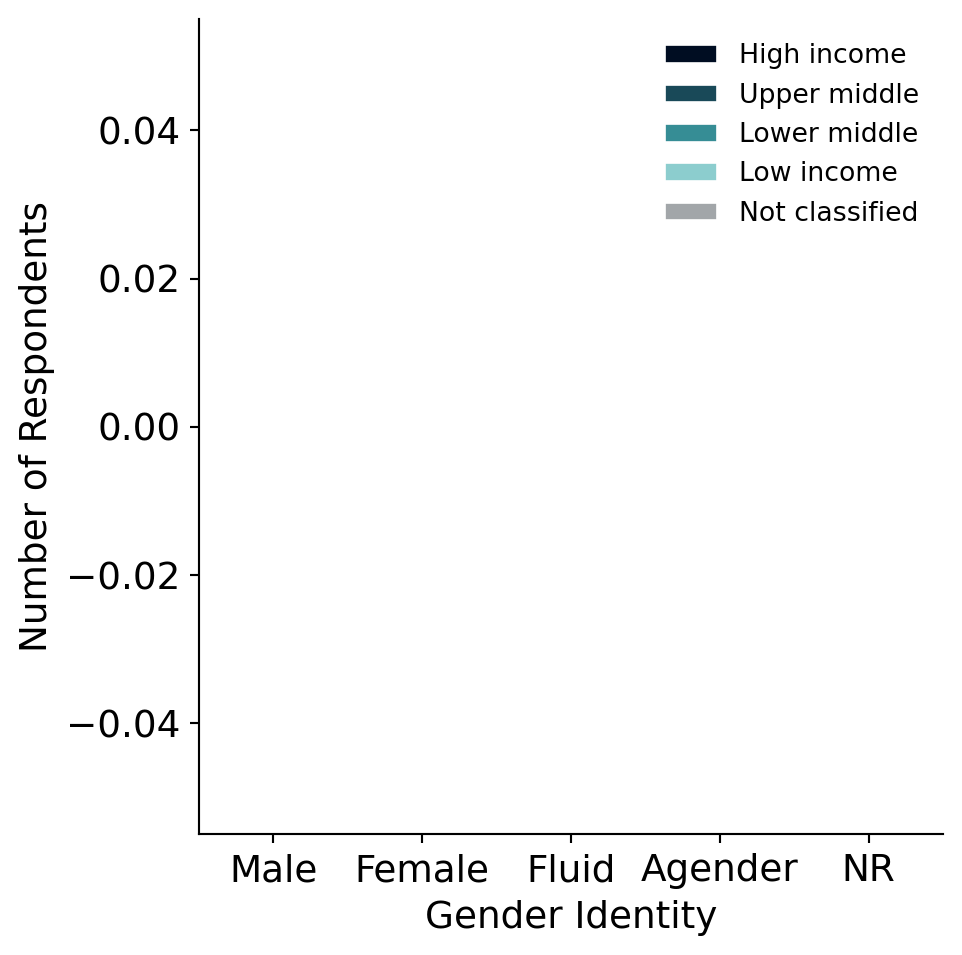

In [25]:
## Create plot

w = 960
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)

    fig_data[region].plot(kind='bar', 
              stacked=True,
              legend=True,
              fontsize=14,
              rot=0,
              color=cat_d23e123_by_region[region],
              edgecolor='white',
              ax=ax)

    ax.set_xlabel('Gender Identity', fontsize=14)
    ax.set_ylabel('Number of Respondents', fontsize=14)
    loc_tweaks = {}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              #title='Subregion', 
              fontsize=10, 
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='2', letter='D2')

## **Fig D3**&nbsp; Q39: Age

In [26]:
## Calculate values for plot

fig_data = {}
for region in region_list:
    age = dataR[region].loc[dataR[region]['col_name'] == 'Q39', ['respondent_id', 'subregion', 'selection']]

    fig_data[region] = (age.groupby(['subregion', 'selection'])
               .count()
               .rename(columns={'respondent_id': 'count'})
               .reset_index()
               .pivot(columns='subregion',
                      index='selection',
                      values='count'))

    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    num_respondents = age.shape[0]
    #show_totals(fig_data[region], num_respondents)

Adding missing column Low income


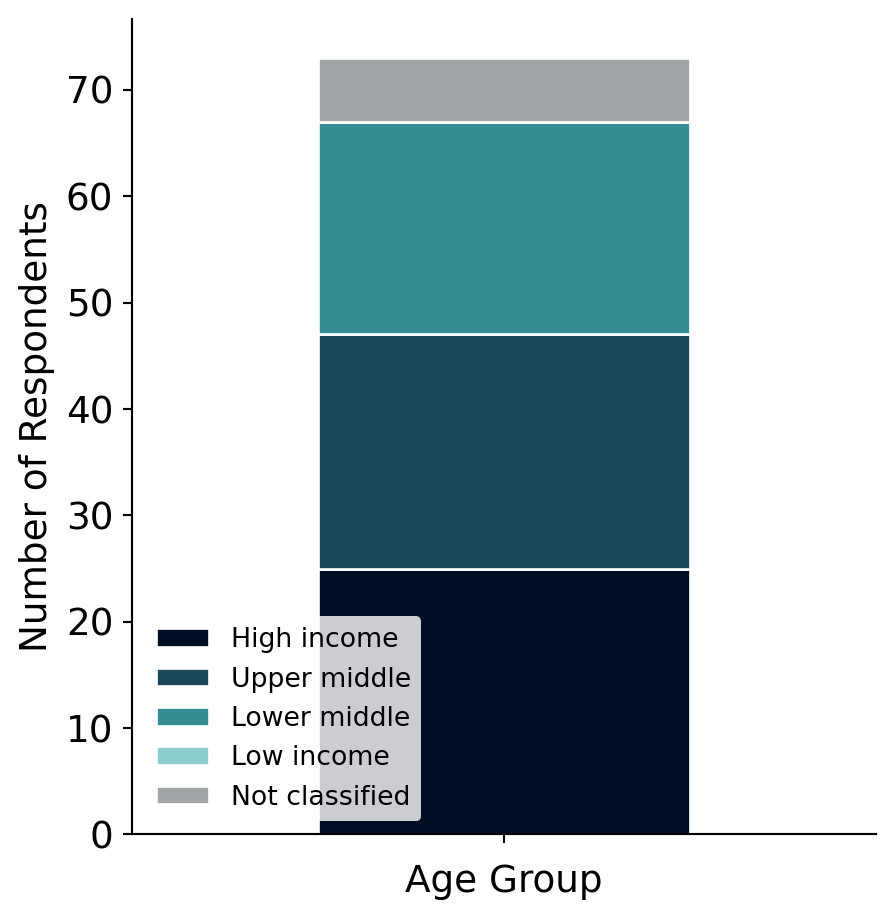

In [27]:
# Create plot

w = 960
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)

    fig_data[region].plot(kind='bar', 
                  stacked=True,
                  legend=True,
                  rot=0,
                  fontsize=14,
                  color=cat_d23e123_by_region[region],
                  edgecolor='white',
                  ax=ax)
    ax.set_xlabel('Age Group', fontsize=14)
    ax.set_ylabel('Number of Respondents', fontsize=14)
    loc_tweaks = {}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              fontsize=10, 
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='2', letter='D3')

## **Fig E1**&nbsp; Q42: Education

In [28]:
## Calculate values for plot

fig_data = {}
for region in region_list:
    education = dataR[region].loc[dataR[region]['col_name'] == 'Q42', ['respondent_id', 'subregion', 'selection_survey_clean']]
    education['education'] = education['selection_survey_clean'].copy()

    fig_data[region] = (education.groupby(['subregion', 'education'])
                         .count()
                         .rename(columns={'respondent_id': 'count'})
                         .reset_index()
                         .pivot(columns='subregion',
                                index='education',
                                values='count'))

    fig_data[region] = reorder_rows_and_rename(
        fig_data[region],
        [
            ['Doctoral Degree',    'PhD'],
            ['Master\'s Degree',   'MS'],
            ['Bachelor\'s Degree', 'BS'],
            ['Other',              'Other']
        ],
        createmissingrows=True,
        warnonly=True,
        ignorerows=ignoreR.get(region)
    )
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')
    #display(fig_data[region])
    num_respondents = education.shape[0]
    #show_totals(fig_data[region], num_respondents)

Adding missing row Doctoral Degree
Adding missing row Master's Degree
Adding missing row Bachelor's Degree
Adding missing row Other
Adding missing column Low income


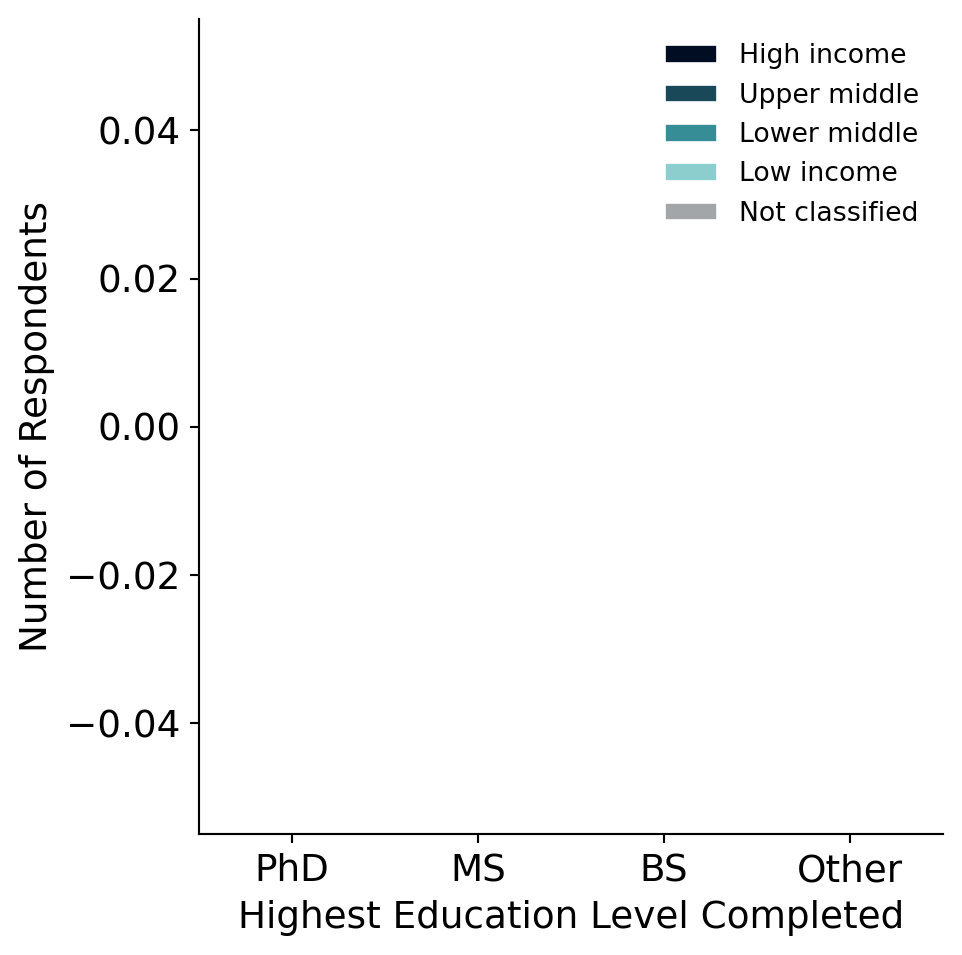

In [29]:
## Create plot

w = 960
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)

    fig_data[region].plot(kind='bar', 
                  stacked=True,
                  legend=True,
                  rot=0,
                  fontsize=14,
                  color=cat_d23e123_by_region[region],
                  edgecolor='white',
                  ax=ax)
    ax.set_xlabel('Highest Education Level Completed', fontsize=14)
    ax.set_ylabel('Number of Respondents', fontsize=14)
    loc_tweaks = {}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              #title='Subregion', 
              fontsize=10, 
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='2', letter='E1')

## **Fig E2**&nbsp; Q43: Sector

In [30]:
## Calculate values for plot

fig_data = {}
for region in region_list:
    # Select relevant survey data
    sector = dataR[region].loc[dataR[region]['col_name'] == 'Q43', ['respondent_id', 'subregion', 'selection_survey_clean']]
    sector['sector'] = sector['selection_survey_clean'].copy()

    fig_data[region] = (sector.groupby(['subregion', 'sector'])
                      .count()
                      .rename(columns={'respondent_id': 'count'})
                      .reset_index()
                      .pivot(columns='subregion',
                             index='sector',
                             values='count'))

    fig_data[region] = reorder_rows_and_rename(
        fig_data[region], [
            ['Academia',   'Acad'],
            ['Government', 'Gov'],
            ['Non-profit', 'NFP'],
            ['NGO',        'NGO'],
            ['Other',      'Other']
        ],
        createmissingrows=True
    )

    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')
    
    #display(fig_data[region])
    num_respondents = sector.shape[0]
    #show_totals(fig_data[region], num_respondents)

Adding missing row Academia
Adding missing row Government
Adding missing row Non-profit
Adding missing row NGO
Adding missing row Other
Adding missing column Low income


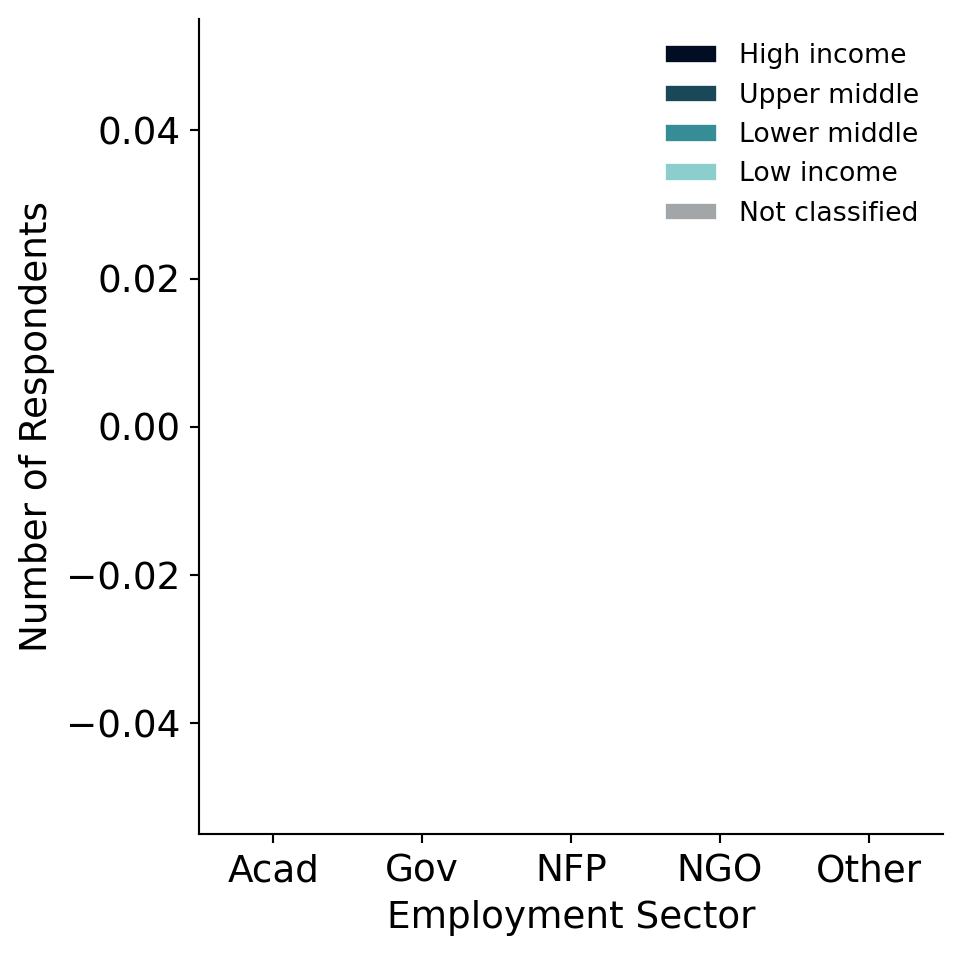

In [31]:
## Create plot

w = 960
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)

    fig_data[region].plot(kind='bar',
                  stacked=True,
                  legend=True,
                  rot=0,
                  fontsize=14,
                  color=cat_d23e123_by_region[region],
                  edgecolor='white',
                  ax=ax)
    ax.set_xlabel('Employment Sector', fontsize=14)
    ax.set_ylabel('Number of Respondents', fontsize=14)
    loc_tweaks = {}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              #title='Subregion', 
              fontsize=10, 
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='2', letter='E2')

## **Fig E3**&nbsp; Q5: Roles

In [32]:
## Calculate values for plot

fig_data = {}
for region in region_list:
    roles = dataR[region].loc[(dataR[region]['question'] == 'Q5') &
                 (dataR[region]['selection_survey_clean'] != ''), ['respondent_id', 'subregion', 'col_name', 'selection_survey_clean']]
    roles['roles'] = roles['selection_survey_clean'].copy()

    fig_data[region] = (roles.groupby(['subregion', 'roles'])
                     .count()
                     .rename(columns={'respondent_id': 'count'})
                     .reset_index()
                     .pivot(columns='subregion',
                            index='roles',
                            values='count'))

    order = [
        ['Scientist/Researcher',        'Sci'],
        ['Education/Outreach',          'Edu'],
        ['Conservation/Advocacy',       'Cons'],
        ['Policy/Law/Management',       'Mgt'],
        ['Student/Early Career',        'ECR'],
        ['Engineering/Technology',      'Eng'],
        ['Developing Nation/Community', 'Dev'],
        ['Aquatics/Recreation',         'Aqua'],
        ['Traditional Knowledge',       'TEK'],
        ['Government',                  'Gov'],
        ['Other',                       'Other']
    ]
    fig_data[region] = reorder_rows_and_rename(fig_data[region], order, createmissingrows=True)
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    #display(fig_data[region])
    num_respondents = roles.shape[0]
    #show_totals(fig_data[region], num_respondents)

Adding missing row Scientist/Researcher
Adding missing row Education/Outreach
Adding missing row Conservation/Advocacy
Adding missing row Policy/Law/Management
Adding missing row Student/Early Career
Adding missing row Engineering/Technology
Adding missing row Developing Nation/Community
Adding missing row Aquatics/Recreation
Adding missing row Traditional Knowledge
Adding missing row Government
Adding missing row Other
Adding missing column High income
Adding missing column Upper middle income
Adding missing column Lower middle income
Adding missing column Low income
Adding missing column Not classified


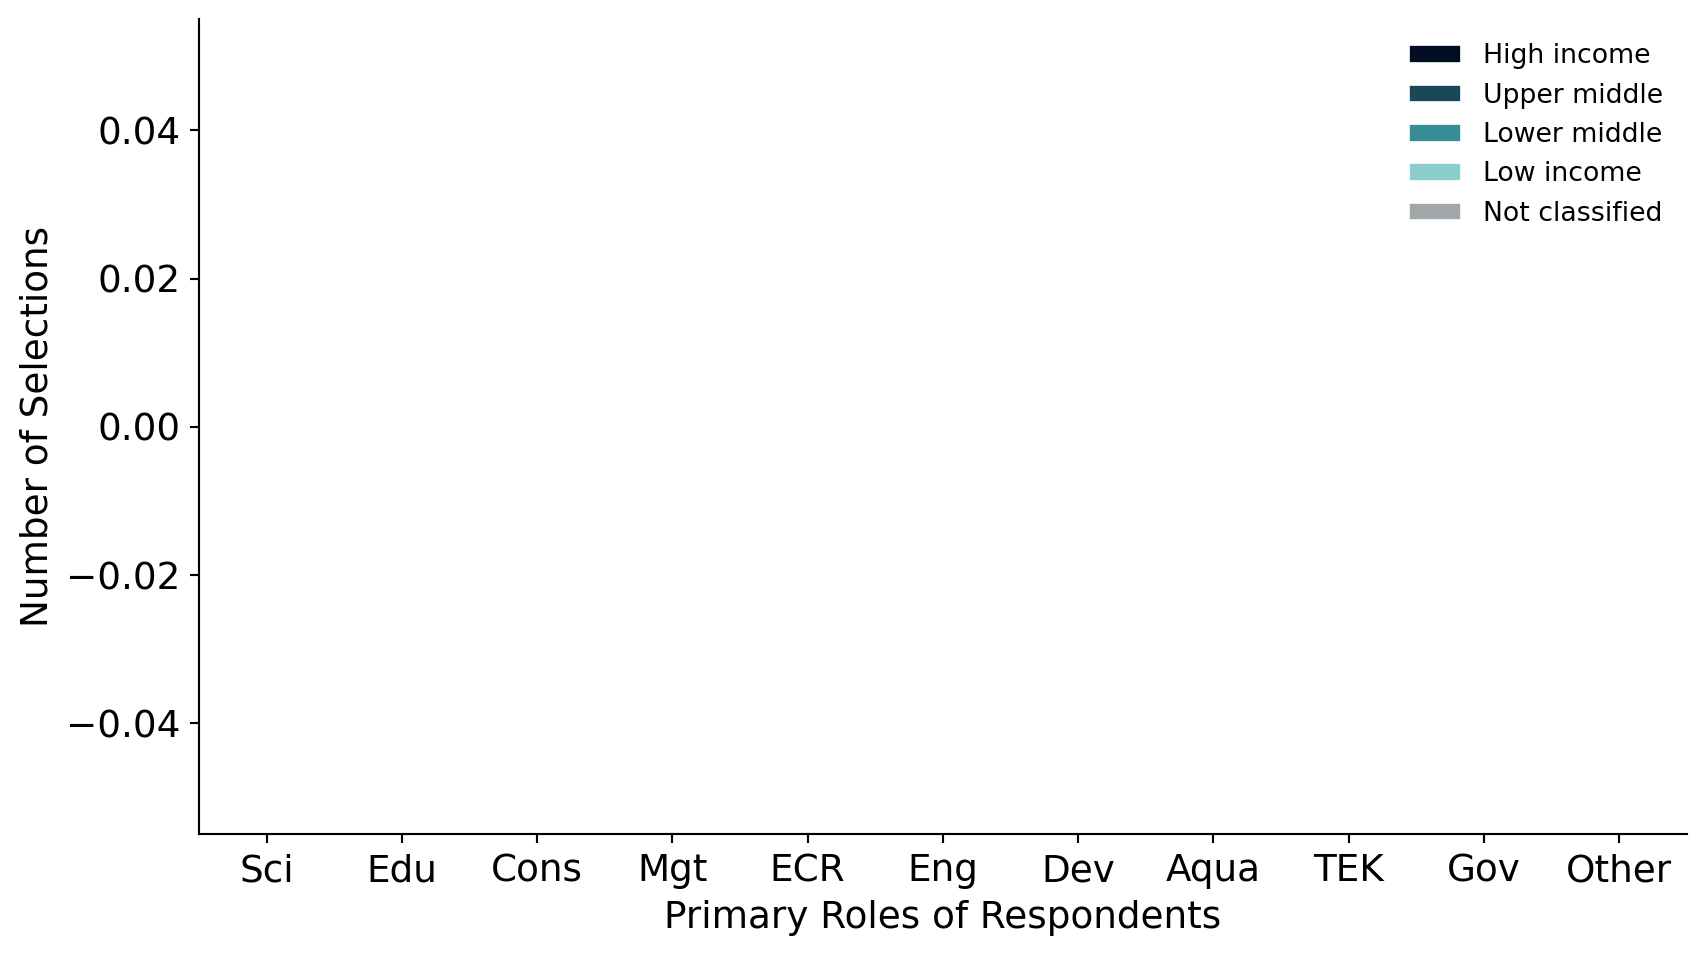

In [33]:
## Create plot

w = 1920
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)

    fig_data[region].plot(kind='bar', 
                  stacked=True,
                  legend=True,
                  rot=0,
                  fontsize=14,
                  color=cat_d23e123_by_region[region],
                  edgecolor='white',
                  ax=ax)
    ax.set_xlabel('Primary Roles of Respondents', fontsize=14)
    ax.set_ylabel('Number of Selections', fontsize=14)
    loc_tweaks = {}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              fontsize=10, 
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='2', letter='E3')

## **Fig F2**&nbsp; Q6: Field Work Environment

In [34]:
## Calculate values for plot

label_order = {}
fig_data = {}
for region in region_list:
    field_work = dataR[region].loc[dataR[region]['question'] == 'Q6', 
                      ['respondent_id', 'subregion', 'selection_survey_clean']]
    field_work = field_work[field_work['selection_survey_clean'] != '']
    
    covariate = 'subregion'

    selection_list = field_work['selection_survey_clean'].unique().tolist()
    selection_list.sort()

    fig_data[region] = (field_work.groupby([covariate, 'selection_survey_clean'])['respondent_id']
                      .count()
                      .rename('count')
                      .reset_index())
    
    renames = {
        'Inshore':                                 'Inshore',
        'Nearshore (within 3 miles of the coast)': 'Nearshore',
        'On the continental shelf (~<200 m)':      'Continental Shelf',
        'Deep water (>200 m)':                     'Deepwater',
        'Other':                                   'Other',
        'None of the above':                       'None of the above',
    }
    hue_order = renames.values()
    fig_data[region]['selection_survey_clean'].replace(renames, inplace=True)
    fig_data[region]['subregion'].replace(label_adjustments, inplace=True)
    label_order[region] = []
    for x in orderR[region]:
        if x in label_adjustments:
            label_order[region].append(label_adjustments[x])
        else:
            label_order[region].append(x)

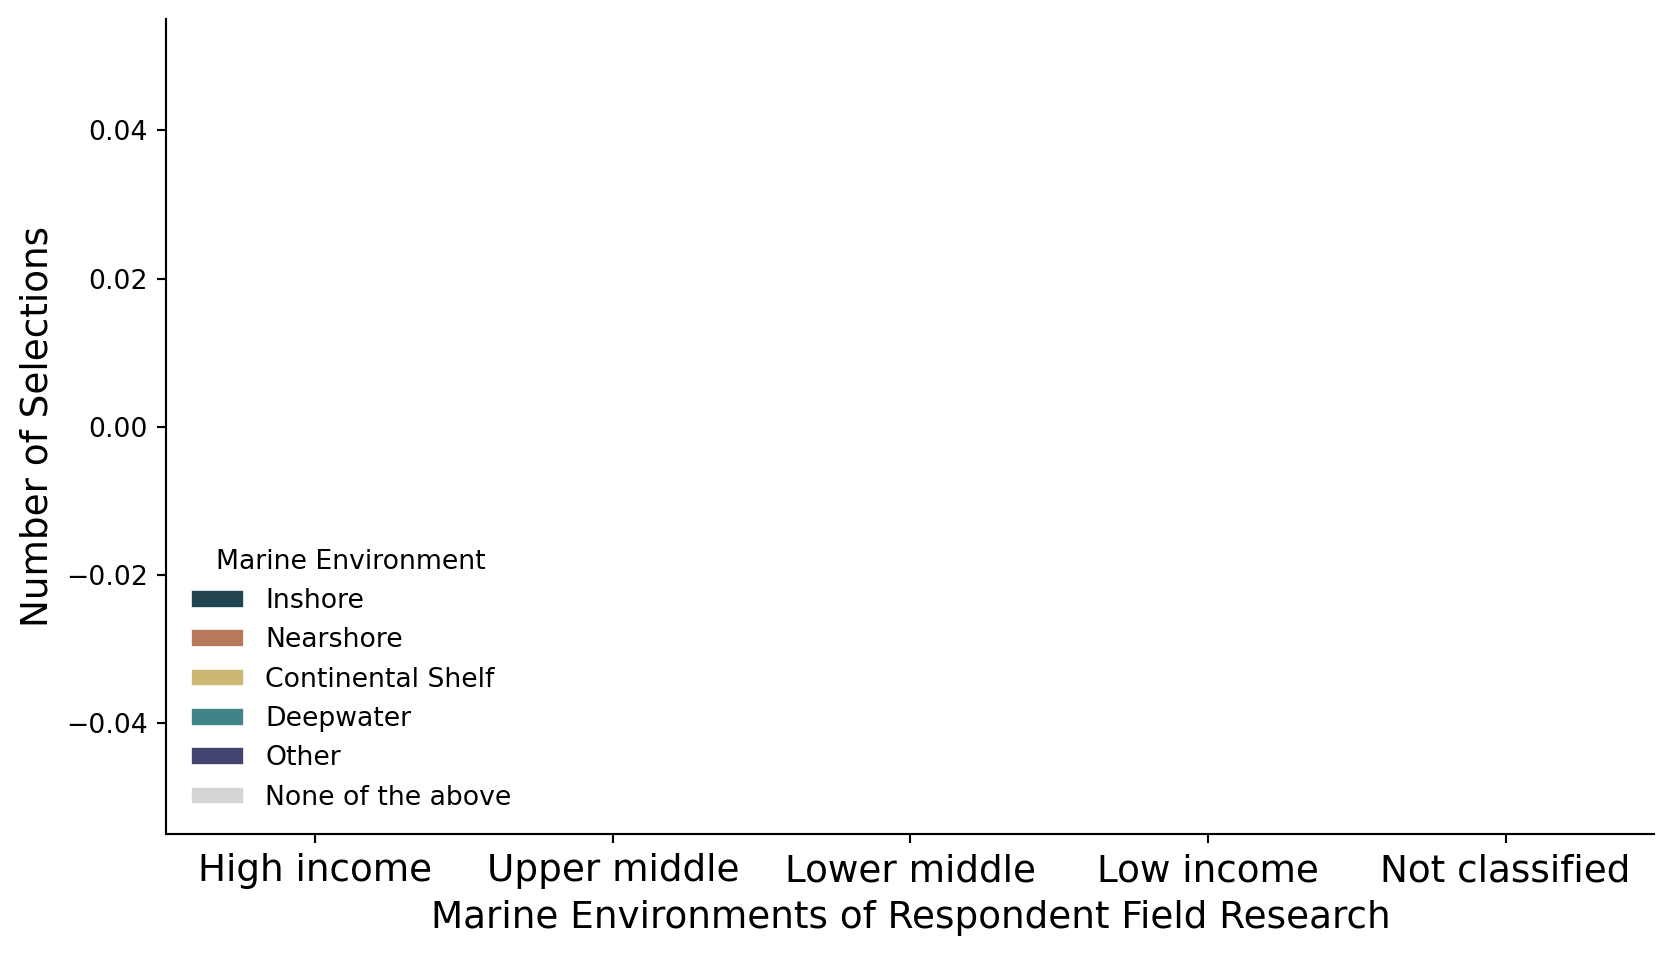

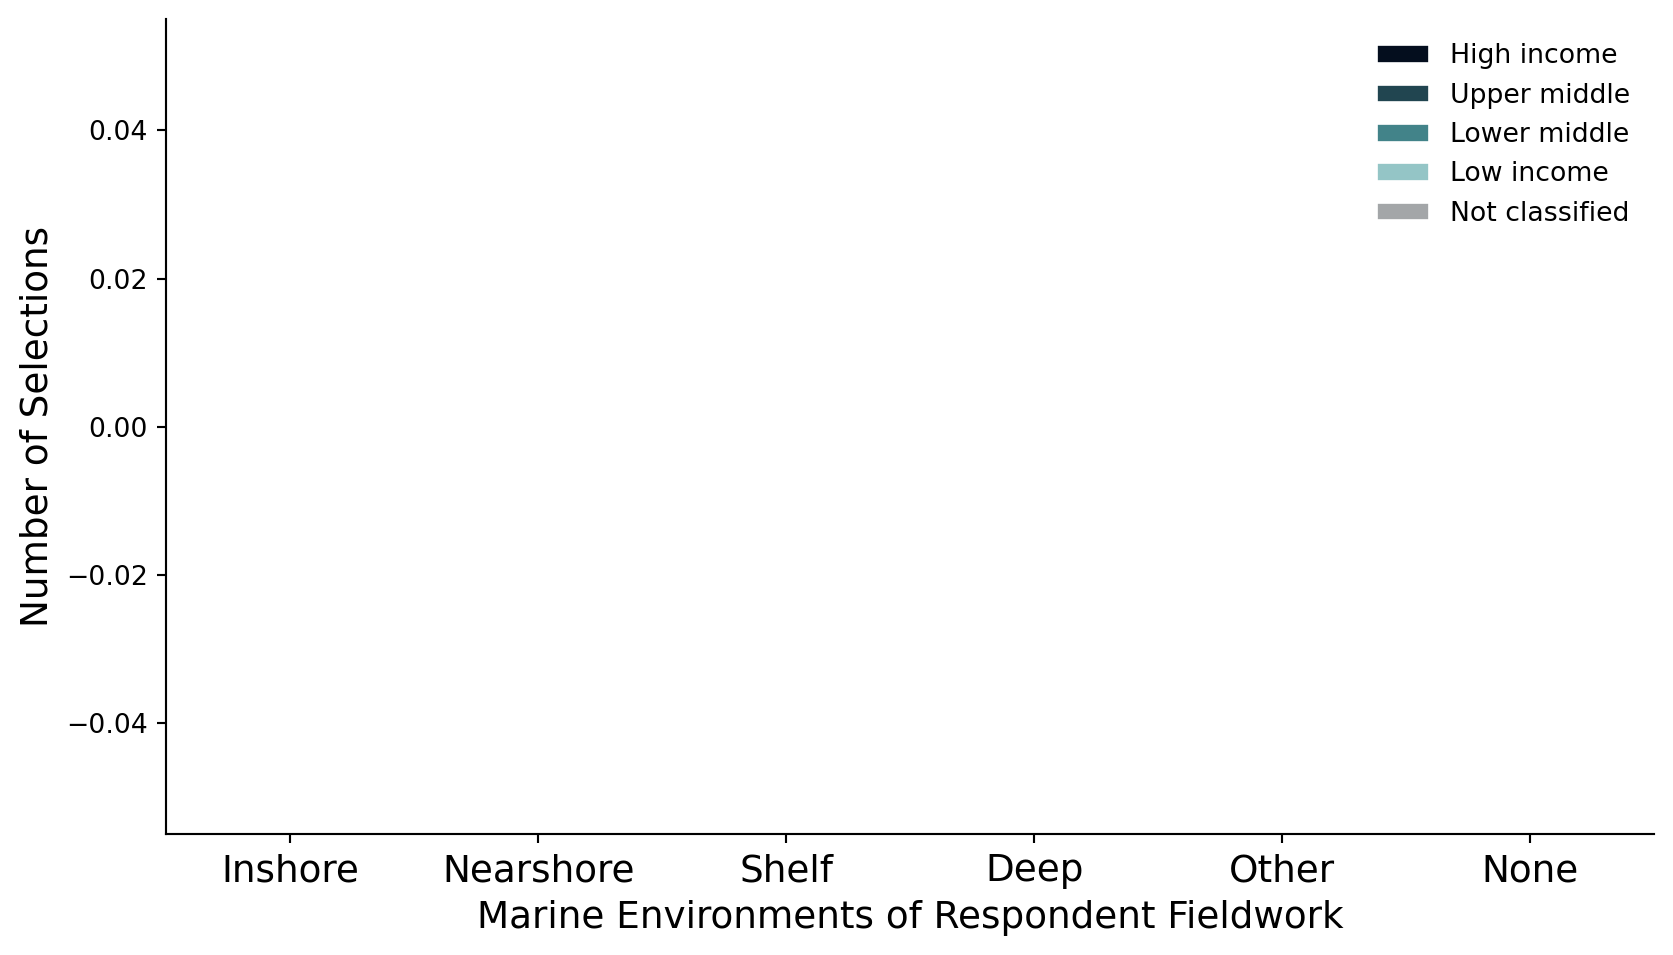

In [35]:
## Create plot

w = 1920
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
    ax = sns.barplot(x='subregion',
                     y='count',
                     order=label_order[region],
                     hue='selection_survey_clean',
                     hue_order=hue_order,
                     palette=cat_05,
                     edgecolor='white',
                     ci=None,
                     data=fig_data[region])            

    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=14)
    ax.set_xlabel('Marine Environments of Respondent Field Research', fontsize=14)
    ax.set_ylabel('Number of Selections', fontsize=14)
    plt.locator_params(axis='y', integer=True)
    loc_tweaks = {'Africa': 'upper right'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='Marine Environment',
              fontsize=10,
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='2', letter='F1')
    
    ## F2
    
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
    ax = sns.barplot(x='selection_survey_clean',
                     y='count',
                     order=hue_order,
                     hue='subregion',
                     hue_order=label_order[region],
                     palette=cat_d23e123_by_region[region],
                     edgecolor='white',
                     ci=None,
                     data=fig_data[region])            

    ax.set_xticklabels(['Inshore', 'Nearshore', 'Shelf', 'Deep', 'Other', 'None'], rotation=0, fontsize=14)
    ax.set(xlabel=None)
    ax.set_xlabel('Marine Environments of Respondent Fieldwork', fontsize=14)
    ax.set_ylabel('Number of Selections', fontsize=14)
    plt.locator_params(axis='y', integer=True)
    ax.legend(loc='upper right',
              fontsize=10,
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='2', letter='F2')

---
# **Section 3**

## **Fig G1**&nbsp; Q4a: Importance

In [36]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Strongly disagree', 'Disagree', "I don't agree or disagree", 'Agree', 'Strongly agree']

importance = {}
fig_data = {}
for region in region_list:
    # Select relevant survey data
    importance[region] = dataR[region].loc[dataR[region]['col_name'] == 'Q4_importance', 
                      ['respondent_id', 'subregion', 'col_name', 'selection']]

    fig_data[region] = importance[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({'1 - Strongly disagree': 'Strongly disagree',
                      '2 - Disagree': 'Disagree',
                      "3 - I don't agree or disagree": "I don't agree or disagree",
                      '4 - Agree': 'Agree',
                      '5 - Strongly agree': 'Strongly agree'}, inplace=True)

    #display(fig_data[region].head())

Adding missing column Low income


In [37]:
## Calculate statistics

for region in region_list:
    percent_data = (importance[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = importance[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

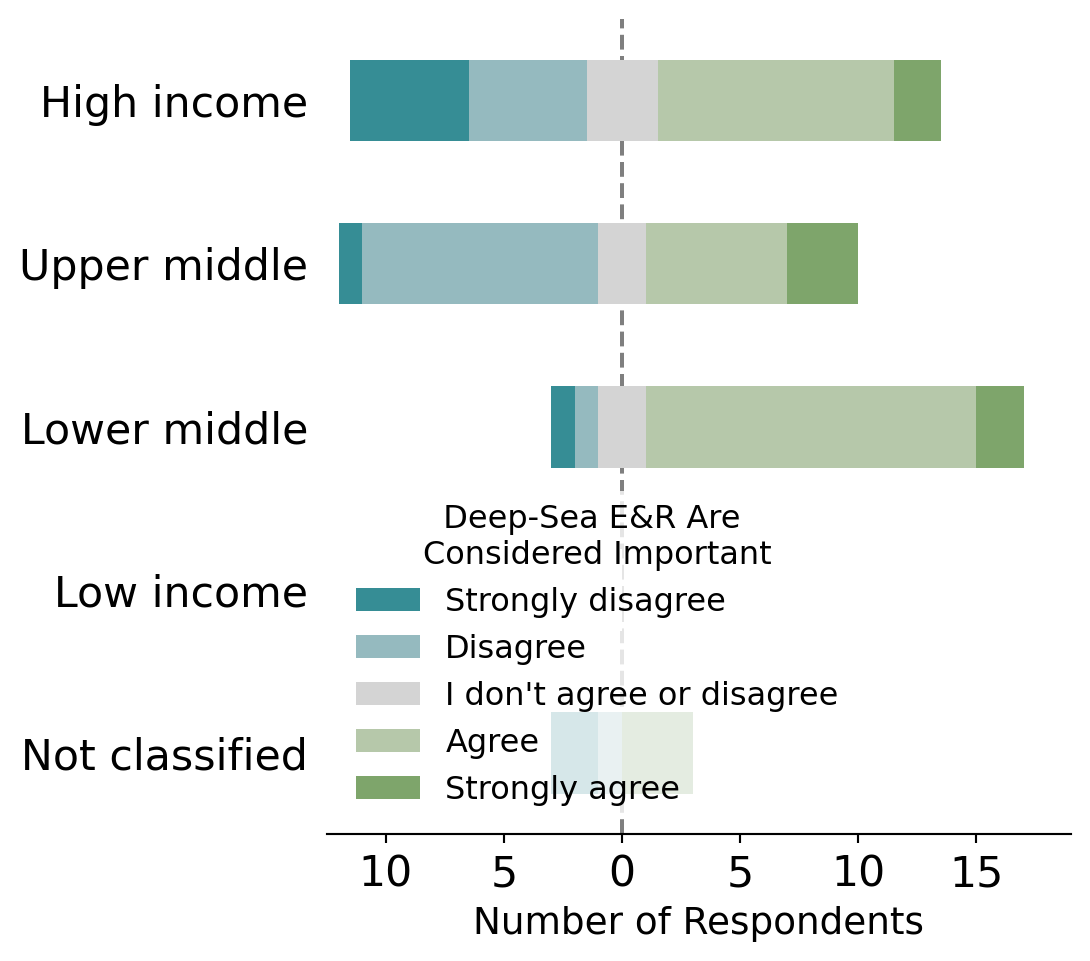

In [38]:
## Create plot

w = 960
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale,
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {'Africa': 'lower right', 'Asia': 'lower left'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='  Deep-Sea E&R Are\nConsidered Important',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='3', letter='G1')

## **Fig G3**&nbsp; Q4: Tools

In [39]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Strongly disagree', 'Disagree', "I don't agree or disagree", 'Agree', 'Strongly agree']

tools = {}
fig_data = {}
for region in region_list:
    # Select relevant survey data
    tools[region] = dataR[region].loc[dataR[region]['col_name'] == 'Q4_in-country_tools', 
                      ['respondent_id', 'subregion', 'col_name', 'selection']]

    fig_data[region] = tools[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({'1 - Strongly disagree': 'Strongly disagree',
                      '2 - Disagree': 'Disagree',
                      "3 - I don't agree or disagree": "I don't agree or disagree",
                      '4 - Agree': 'Agree',
                      '5 - Strongly agree': 'Strongly agree'}, inplace=True)

    #display(fig_data[region])

Adding missing column Low income


In [40]:
## Calculate statistics

for region in region_list:
    percent_data = (tools[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = tools[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

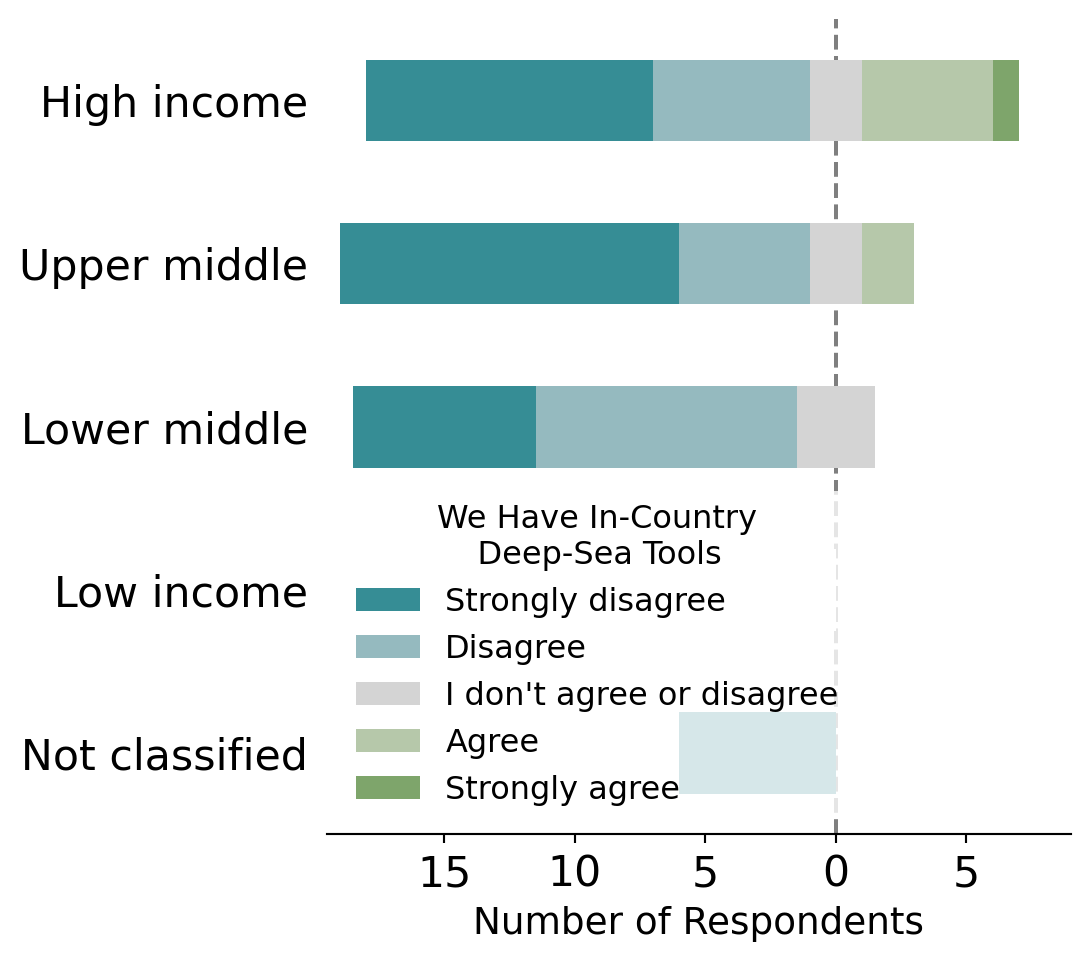

In [41]:
## Create plot

w = 960
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale,
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {'Africa': 'lower left', 'Americas': 'lower right', 'Economies': 'lower right'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='We Have In-Country\n    Deep-Sea Tools',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='3', letter='G3')

## **Fig G4**&nbsp; Q4: ExpertiseA

In [42]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Strongly disagree', 'Disagree', "I don't agree or disagree", 'Agree', 'Strongly agree']

expertise = {}
fig_data = {}

for region in region_list:
    # Select relevant survey data
    expertise[region] = dataR[region].loc[dataR[region]['col_name'] == 'Q4_in-country_expertise', 
                          ['respondent_id', 'subregion', 'col_name', 'selection']]

    fig_data[region] = expertise[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({'1 - Strongly disagree': 'Strongly disagree',
                      '2 - Disagree': 'Disagree',
                      "3 - I don't agree or disagree": "I don't agree or disagree",
                      '4 - Agree': 'Agree',
                      '5 - Strongly agree': 'Strongly agree'}, inplace=True)

    #display(fig_data[region])

Adding missing column Low income


In [43]:
## Calculate statistics

for region in region_list:
    percent_data = (expertise[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = expertise[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

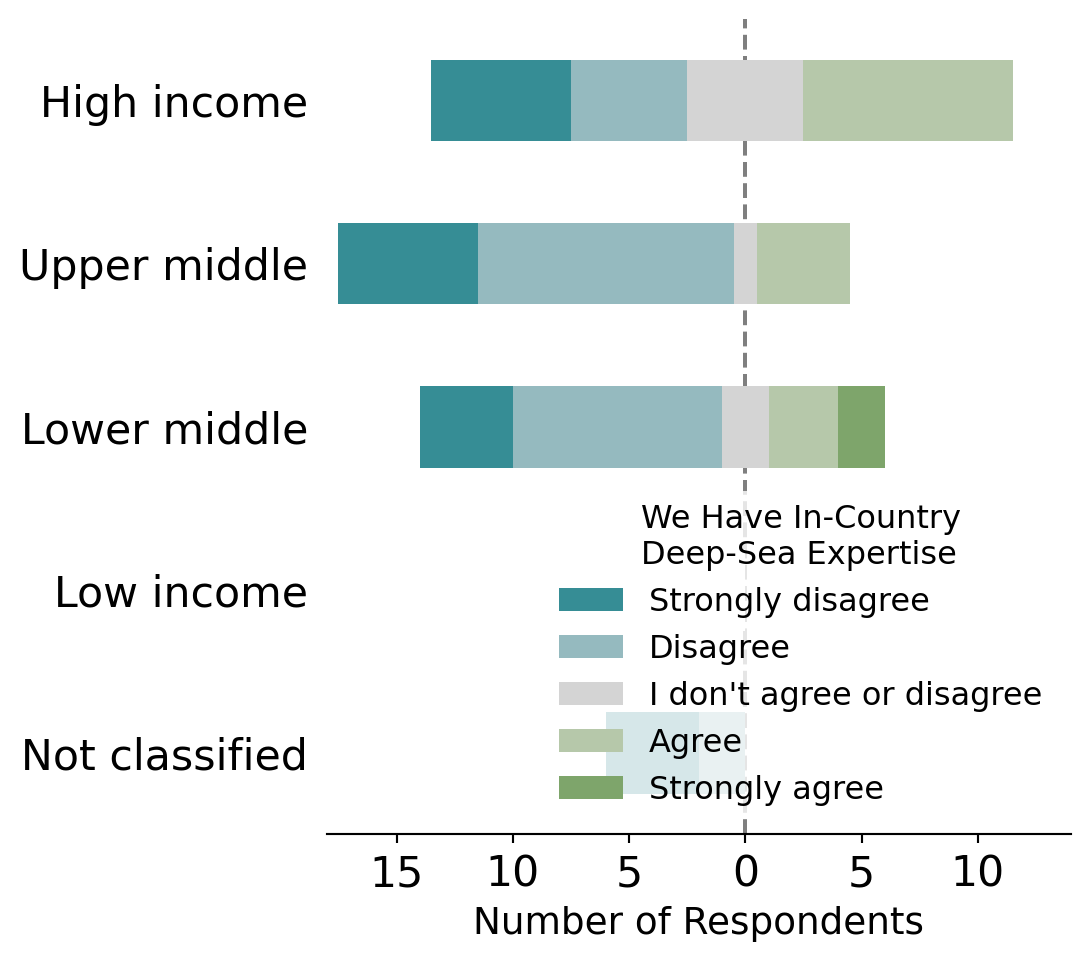

In [44]:
## Create plot

w = 960
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale,
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {'Africa': 'lower left', 'Economies': 'lower right', 'SIDS': 'lower right'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='We Have In-Country\nDeep-Sea Expertise',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='3', letter='G4')

## **Figs G6 G7 G8**

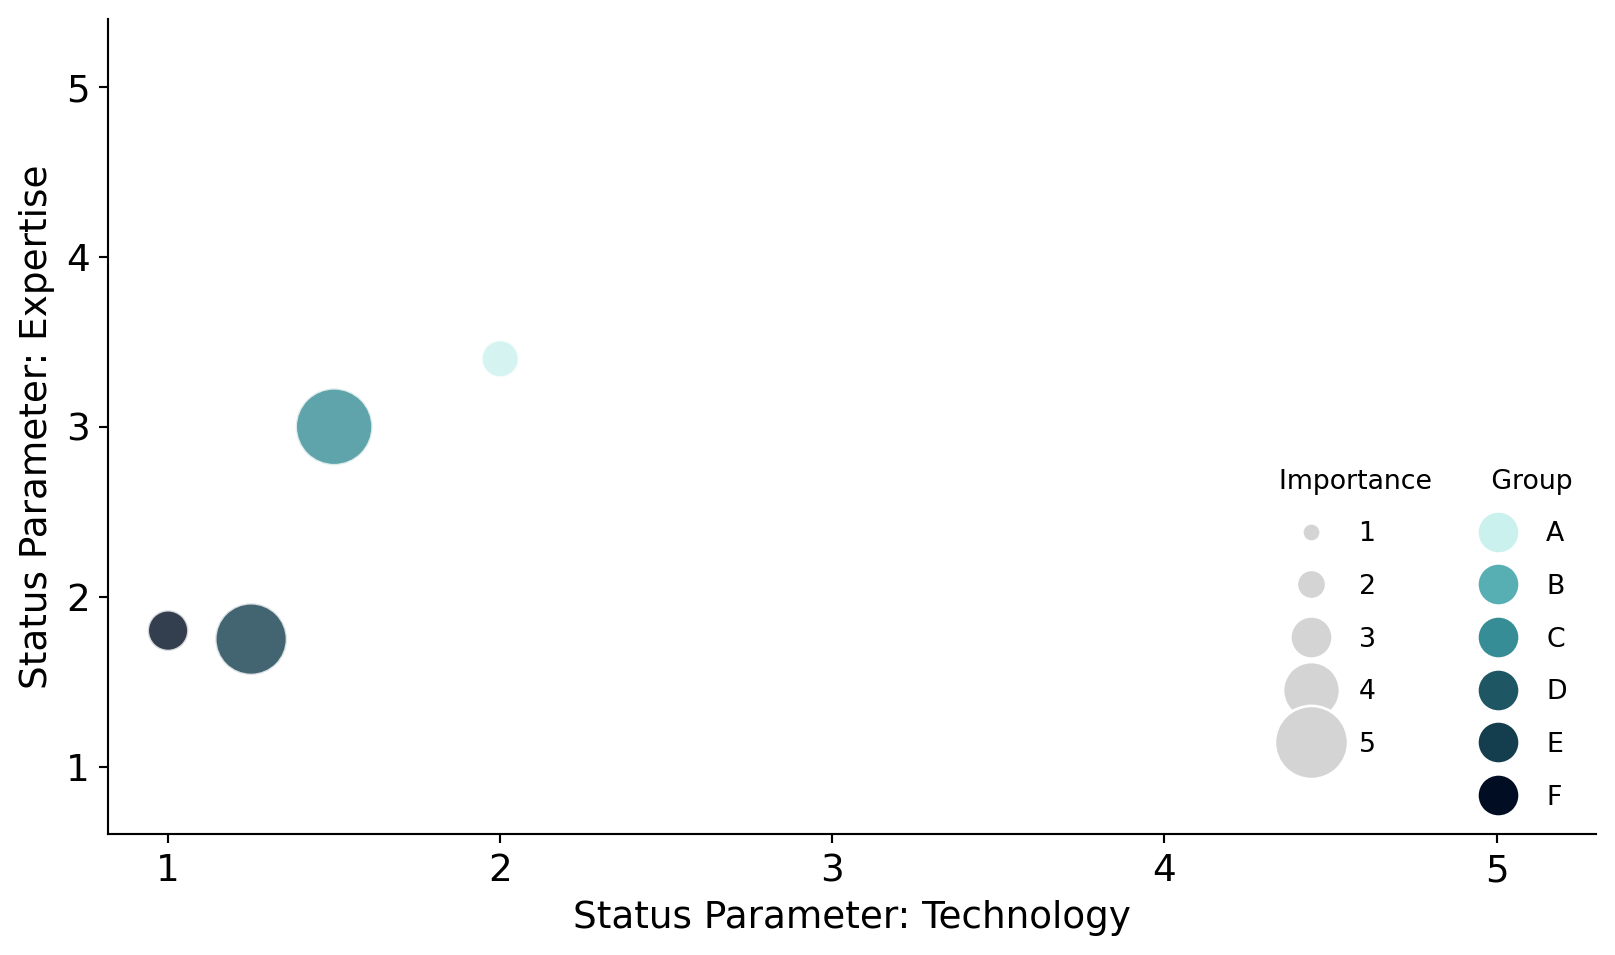

In [45]:
##### Calculate fig data

fig_data = {}
for region in region_list:
    fig_data[region] = (country_tableR[region][['subregion_orig', 'dscsr-group', 'dscsr-group-tools', 'dscsr-group-exp', 'dscsr-group-imp']]
                        .groupby('dscsr-group')
                        .mean())
    # sort by reverse bubble size so small bubbles are not obscured by larger ones
    fig_data[region] = fig_data[region].sort_values('dscsr-group-imp', ascending=False)

    #display(fig_data[region])

## Plot figure

w = 1920
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)

    sizes = [((x+1)**3)*5 for x in fig_data[region]['dscsr-group-imp'].tolist()]
    groups=['A', 'B', 'C', 'D', 'E', 'F']
    colors = [groups.index(x) for x in fig_data[region].index.tolist()]

    fig_data[region].plot('dscsr-group-tools', 'dscsr-group-exp', kind='scatter', 
                  legend=False,
                  rot=0,
                  fontsize=14,
                  s=sizes,
                  c=colors,
                  cmap=matplotlib.colors.ListedColormap(val_06_rev[0:-1]),
                  edgecolor='white',
                  alpha=0.8,
                  ax=ax)
    ax.set_xlabel('Status Parameter: Technology', fontsize=14)
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.set_xticklabels(['1','2','3','4','5'])
    ax.set_ylabel('Status Parameter: Expertise', fontsize=14)
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.set_yticklabels(['1','2','3','4','5'])
    plt.xlim(0.82,5.3)
    plt.ylim(0.6,5.4)

    markers = []
    labels = []
    for i in range(0, 5):
        size = math.sqrt(((i+2)**3)*3)+2
        color = '#d4d4d4'
        labels.append(str(i+1)+'     ')
        markers.append(matplotlib.lines.Line2D(range(1), range(1), color='white',
                                               marker='o', markersize=size, markerfacecolor=color, markeredgecolor='white'))
        markers[i].set_zorder(6-i)
    markers.append(matplotlib.lines.Line2D(range(1), range(1), color='none', marker='o', markersize=0, markerfacecolor='none'))
    labels.append('')
    for i in range(0,6):
        size = math.sqrt(((2+2)**3)*3)+2
        color = val_06_rev[i]
        labels.append(groups[i])
        markers.append(matplotlib.lines.Line2D(range(1), range(1), color='white', marker='o', markersize=size, markerfacecolor=color))
    legend = plt.legend(markers, labels, numpoints=1, fontsize=10, labelspacing=1, ncol=2, title='Importance       Group',
                             loc='lower right')
    ax.add_artist(legend)

    outputfigs(plt, fig, ax, region, section='5', letter='G5')

In [46]:
##### Calculate fig data

regions_to_skip = ['Global', 'Economies', 'SIDS']

fig_data_global = (country_tableR['Global'][['subregion_orig', 'dscsr-group', 'dscsr-group-tools', 'dscsr-group-exp', 'dscsr-group-imp']]
                    .groupby(['subregion_orig', 'dscsr-group'])
                    .head(1))
fig_data_global = fig_data_global.set_index('subregion_orig')
#display(fig_data_global)

colors = {}
fig_data = {}
for region in region_list:
    if region in regions_to_skip:
        print('Skipping region', region);
        continue

    fig_data[region] = fig_data_global.copy()
    # sort by reverse bubble size so small bubbles are not obscured by larger ones
    fig_data[region] = fig_data[region].sort_values('dscsr-group-imp', ascending=False)
    
    # move bubbles to be colored to the end so they are plotted last
    # and not obscured by gray bubbles in the same position
    these_subregions = orderR[region]
    color = fig_data[region].query('subregion_orig in @these_subregions')
    grays = fig_data[region].query('subregion_orig not in @these_subregions')
    fig_data[region] = pd.concat([grays, color])
    
    groups=['A', 'B', 'C', 'D', 'E', 'F']
    colors[region] = []
    for index in fig_data[region].index:
        if index in orderR[region]:
            group = fig_data[region].loc[index]['dscsr-group']
            colors[region].append(val_06_rev[groups.index(group)])
        else:
            colors[region].append('#d4d4d4')

## Plot figure

w = 1920
h = 1080

for region in region_list:
    if region in regions_to_skip:
        continue

    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)

    sizes = [((x+1)**3)*5 for x in fig_data[region]['dscsr-group-imp'].tolist()]
    fig_data[region].plot('dscsr-group-tools', 'dscsr-group-exp', kind='scatter', 
                  legend=False,
                  rot=0,
                  fontsize=14,
                  s=sizes,
                  c=colors[region],
                  edgecolor='white',
                  alpha=0.8,
                  ax=ax)
    ax.set_xlabel('Status Parameter: Technology', fontsize=14)
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.set_xticklabels(['1','2','3','4','5'])
    ax.set_ylabel('Status Parameter: Expertise', fontsize=14)
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.set_yticklabels(['1','2','3','4','5'])
    plt.xlim(0.82,5.3)
    plt.ylim(0.6,5.4)

    markers = []
    labels = []
    for i in range(0, 5):
        size = math.sqrt(((i+2)**3)*3)+2
        color = '#d4d4d4'
        labels.append(str(i+1)+'     ')
        markers.append(matplotlib.lines.Line2D(range(1), range(1), color='white', marker='o', markersize=size, markerfacecolor=color, markeredgecolor='white'))
    markers.append(matplotlib.lines.Line2D(range(1), range(1), color='none', marker='o', markersize=0, markerfacecolor='none'))
    labels.append('')
    for i in range(0,6):
        size = math.sqrt(((2+2)**3)*3)+2
        color = val_06_rev[i]
        labels.append(groups[i])
        markers.append(matplotlib.lines.Line2D(range(1), range(1), color='white', marker='o', markersize=size, markerfacecolor=color))
    ax.add_artist(plt.legend(markers, labels, numpoints=1, fontsize=10, labelspacing=1, ncol=2, title='Importance       Group',
                             loc='lower right'))

    outputfigs(plt, fig, ax, region, section='5', letter='G5b')

Skipping region SIDS


adding empty row for 1
Adding missing column Low income


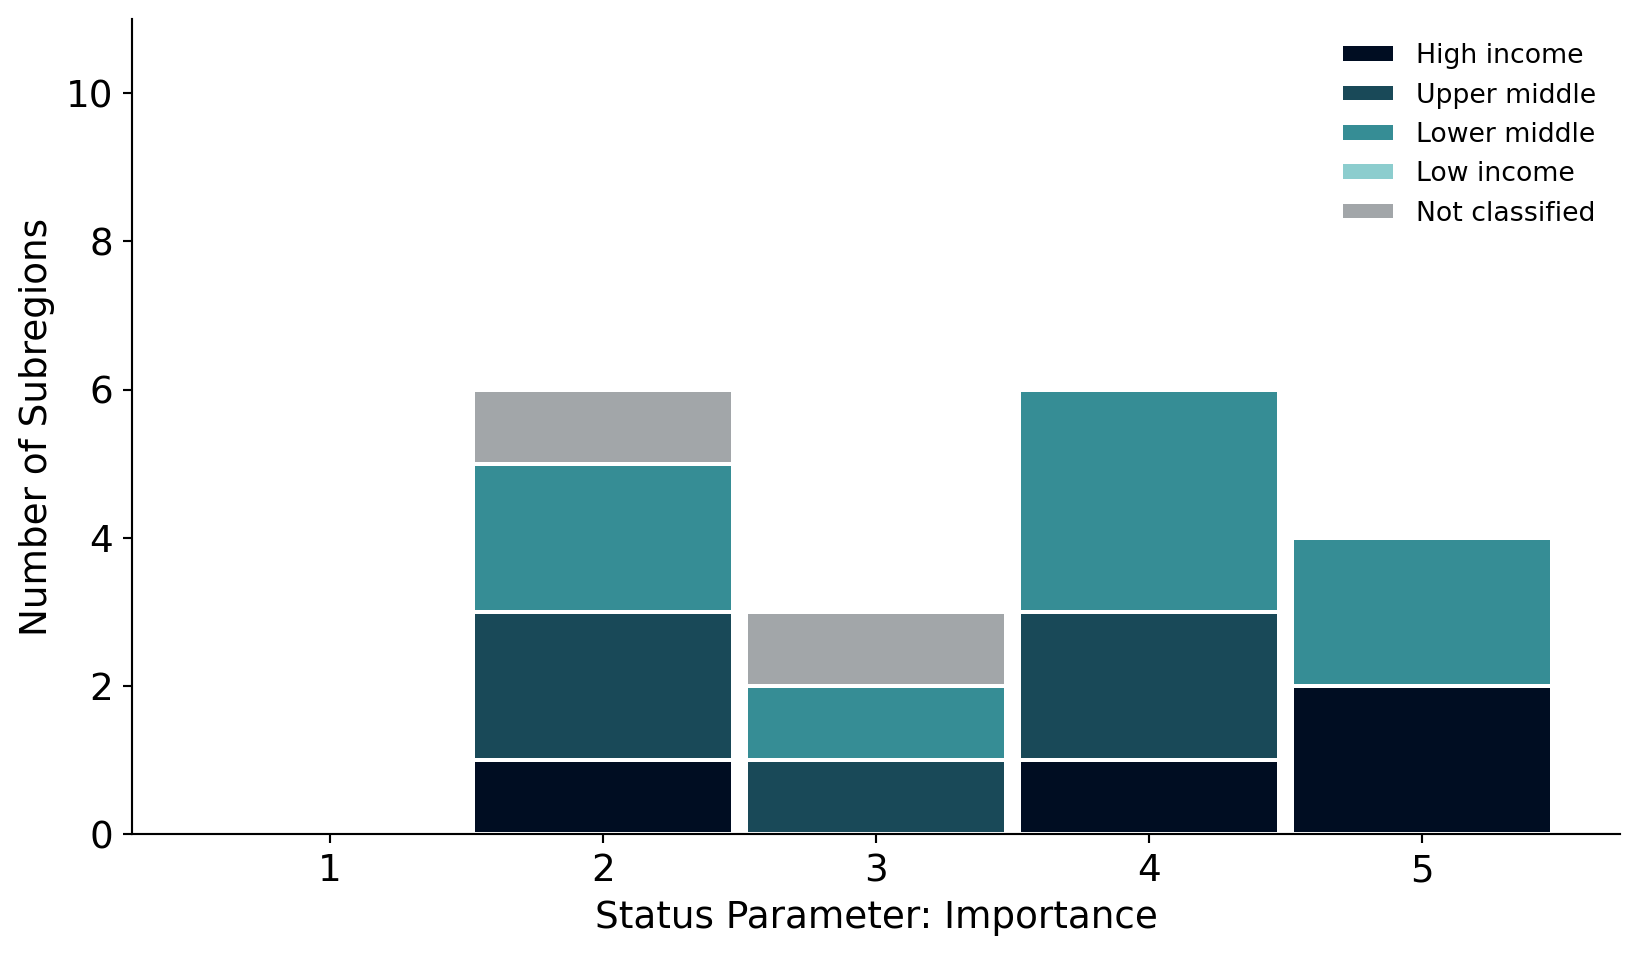

adding empty row for 3
adding empty row for 4
adding empty row for 5
Adding missing column Low income


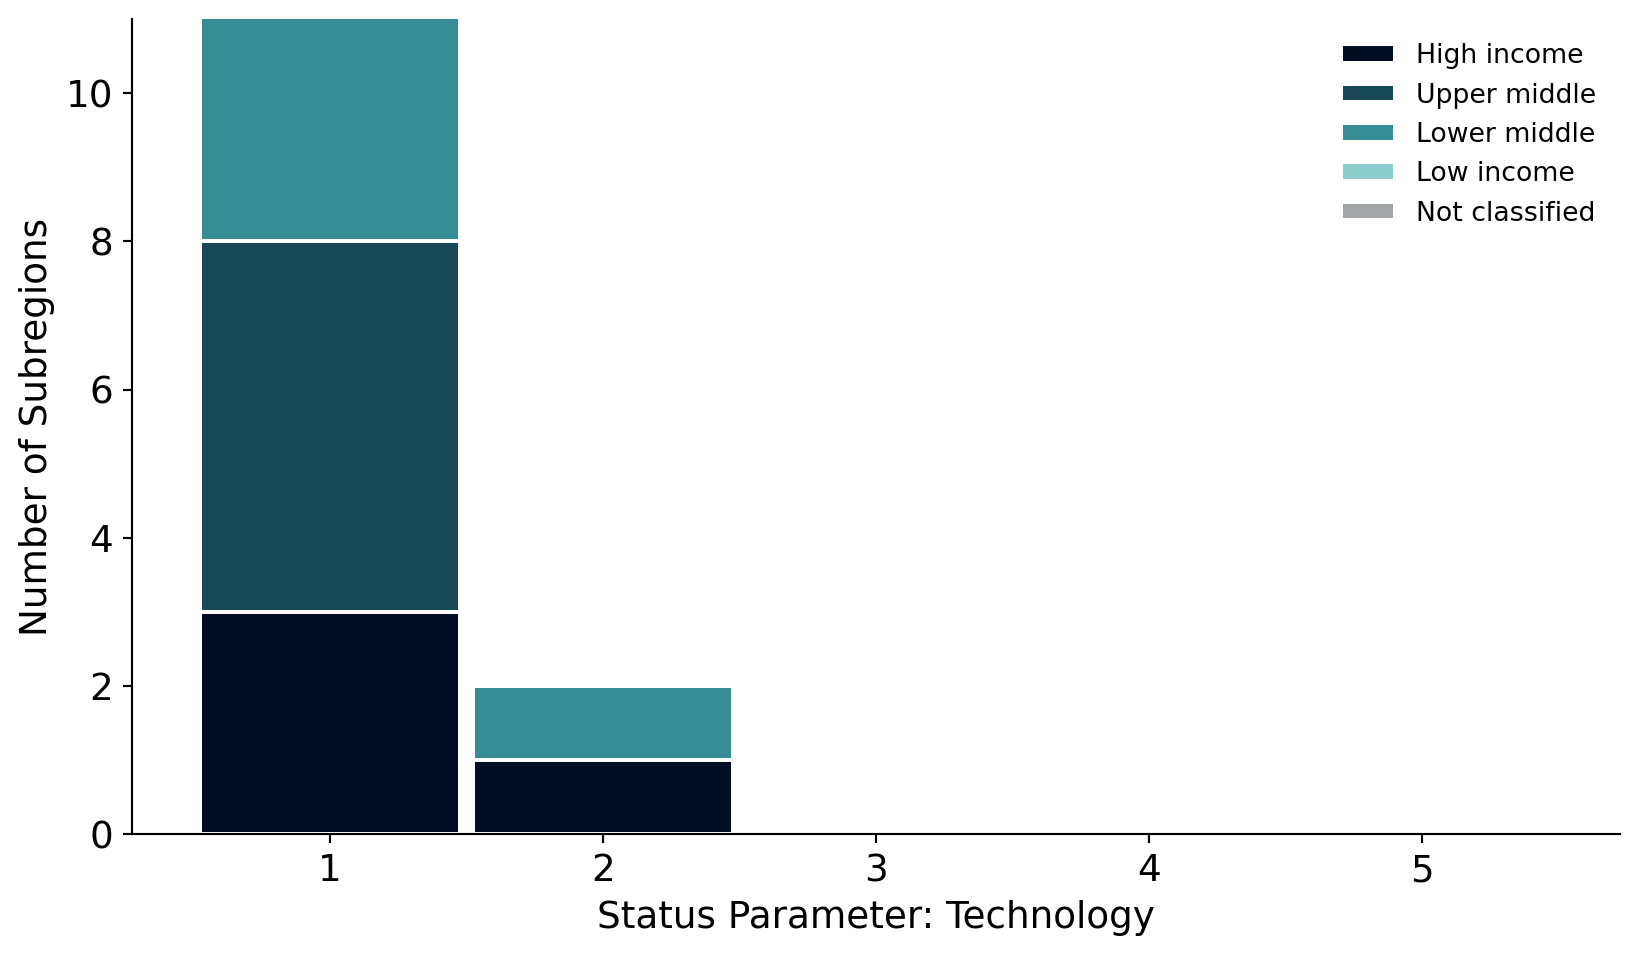

adding empty row for 4
adding empty row for 5
Adding missing column Low income


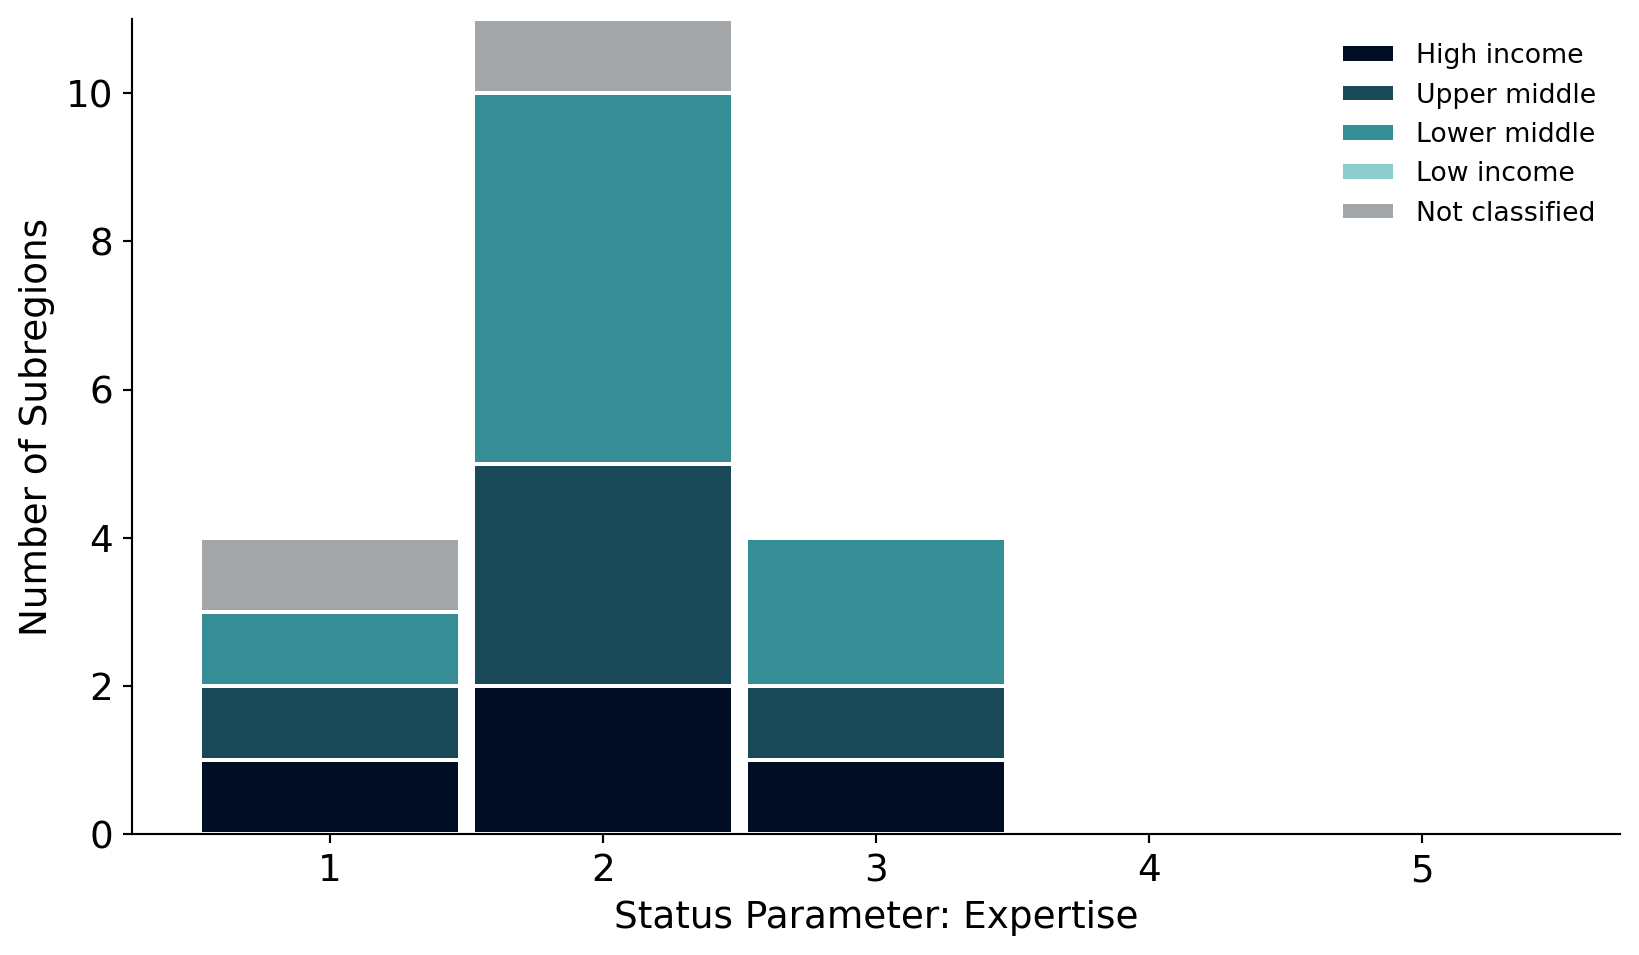

In [47]:
## Calculate fig data

dsc_types = {
    'dscsr-imp':
        { 'x-label': 'Status Parameter: Importance',
          'y-label': 'Number of Subregions',
          'fig-letter': 'G6'
        },
    'dscsr-tools':
        { 'x-label': 'Status Parameter: Technology',
          'y-label': 'Number of Subregions',
          'fig-letter': 'G7'
        },
    'dscsr-exp':
        { 'x-label': 'Status Parameter: Expertise',
          'y-label': 'Number of Subregions',
          'fig-letter': 'G8'
        }
}

for dsc_type, labels in dsc_types.items():
    fig_data = {}
    for region in region_list:
        fig_data[region] = (country_tableR[region]
                    .groupby([dsc_type, 'subregion', 'subregion_orig'])[dsc_type]
                    .mean()
                    .rename('mean')
                    .reset_index())
        fig_data[region] = (fig_data[region]
                    .groupby(['mean', 'subregion'])['mean']
                    .count()
                    .rename('count')
                    .reset_index())
        fig_data[region]['mean'] = fig_data[region]['mean'].astype(int)
        fig_data[region] = fig_data[region].pivot(index='mean', columns=['subregion'], values='count')
        for n in range(1,6):
            if n not in fig_data[region].index:
                print('adding empty row for', n)
                fig_data[region].loc[n] = 0
        fig_data[region] = fig_data[region].sort_index()
        fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis=1)
        #display(fig_data[region])

    ## Plot figure

    w = 1920
    h = 1080
    
    for region in region_list:
        fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)

        fig_data[region].plot(kind='bar', 
                      stacked=True,
                      rot=0,
                      fontsize=14,
                      width=0.95,
                      color=cat_d23e123_by_region[region],
                      edgecolor='white',
                      linewidth=1.5,
                      ax=ax)
        ax.set_xlabel(labels['x-label'], fontsize=14)
        ax.set_ylabel(labels['y-label'], fontsize=14)
        plt.locator_params(axis='y', integer=True)
        plt.ylim(0, 11)

        ax.legend(fontsize=10,
                  title_fontsize=10)

        outputfigs(plt, fig, ax, region, section='5', letter=labels['fig-letter'])

## **Figs G6b G7b G8b**

In [48]:
## Calculate fig data

dsc_types = {
    'dscsr-imp':
        { 'x-label': 'Status Parameter: Importance',
          'y-label': 'Number of Subregions',
          'fig-letter': 'G6b'
        },
    'dscsr-tools':
        { 'x-label': 'Status Parameter: Technology',
          'y-label': 'Number of Subregions',
          'fig-letter': 'G7b'
        },
    'dscsr-exp':
        { 'x-label': 'Status Parameter: Expertise',
          'y-label': 'Number of Subregions',
          'fig-letter': 'G8b'
        }
}

regions_to_skip = ['Global', 'Economies', 'SIDS']

for dsc_type, labels in dsc_types.items():
    fig_data = {}
    for region in region_list:
        if region in regions_to_skip:
            print('Skipping region', region);
            continue

        for r in ['Global', region]:
            fig_data[r] = (country_tableR[r]
                        .groupby([dsc_type, 'subregion', 'subregion_orig'])[dsc_type]
                        .mean()
                        .rename('mean')
                        .reset_index())
            fig_data[r] = (fig_data[r]
                        .groupby(['mean', 'subregion'])['mean']
                        .count()
                        .rename('count')
                        .reset_index())
            fig_data[r]['mean'] = fig_data[r]['mean'].astype(int)

            fig_data[r] = fig_data[r].pivot(index='mean', columns=['subregion'], values='count')
            for n in range(1,6):
                if n not in fig_data[r].index:
                    print('adding empty row for', n)
                    fig_data[r].loc[n] = 0
            fig_data[r] = fig_data[r].sort_index()
            fig_data[r] = prep_fig_data_for_plotting(fig_data[r], r, axis=1)

        if region == 'Americas':
            colnum = fig_data['Global'].columns.get_loc('N America')
            fig_data['Global'] = fig_data['Global'].rename(columns={'N America': 'Old N America'})
            i=0
            for columnname, column in fig_data[region].iteritems():
                fig_data['Global'].insert(colnum+i, columnname, column)
                i+=1
            fig_data['Global'] = fig_data['Global'].drop(columns=['Old N America', 'L Amer & Carib'])
        else:
            colnum = fig_data['Global'].columns.get_loc(region)
            i=0
            for columnname, column in fig_data[region].iteritems():
                fig_data['Global'].insert(colnum+i, columnname, column)
                i+=1
            fig_data['Global'] = fig_data['Global'].drop(columns=region)
        fig_data[region] = fig_data['Global']

        #display(fig_data['Global'])

    ## Plot figures

    w = 1920
    h = 1080
    
    for region in region_list:
        if region in regions_to_skip:
            continue

        fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
        fig_data[region].plot(kind='bar',
                      stacked=True,
                      rot=0,
                      fontsize=14,
                      width=0.95,
                      edgecolor='white',
                      linewidth=1,
                      ax=ax)
        ax.set_xlabel(labels['x-label'], fontsize=14)
        ax.set_ylabel(labels['y-label'], fontsize=14)
        plt.locator_params(axis='y', integer=True)
        plt.ylim(0, 11)
        
        colors = []
        edgecolors = []
        for (columnname, data) in fig_data[region].iteritems():
            for datum in data:
                orig_columnname = undo_label_adjustment(columnname)
                if orig_columnname in orderR[region]:
                    colors.append(cat_d23e123_by_region[region][orderR[region].index(orig_columnname)])
                    edgecolors.append('black')
                else:
                    colors.append('#d4d4d4')
                    edgecolors.append('white')
        for p,color in zip(ax.patches,colors):
            p.set_facecolor(color)
        for p,edgecolor in zip(ax.patches,edgecolors):
            p.set_edgecolor(edgecolor)
            if edgecolor != 'white':
                p.set_zorder(10)

        prunedhandles = []
        prunedlabels = []
        currenthandles, currentlabels = ax.get_legend_handles_labels()   #get the handles
        for handle, label in zip(currenthandles, currentlabels):
            if undo_label_adjustment(label) in orderR[region]:
                prunedhandles.append(handle)
                prunedlabels.append(label)
        patch = matplotlib.patches.Patch(facecolor='#d4d4d4', edgecolor='white')
        prunedhandles.append(patch)
        prunedlabels.append('All other regions')

        ax.legend(prunedhandles,
                  prunedlabels,
                  fontsize=10,
                  title_fontsize=10)

        outputfigs(plt, fig, ax, region, section='5', letter=labels['fig-letter'])

Skipping region SIDS
Skipping region SIDS
Skipping region SIDS


---
# **Section 4**

## **Fig H1**&nbsp; Q3: Issues

In [49]:
## Calculate values for plot

issues = {}
fig_data = {}
for region in region_list:
    issues[region] = dataR[region].loc[(dataR[region]['question'] == 'Q3') &
                  (dataR[region]['selection_survey_clean'] != ''),
                  ['respondent_id', 'subregion', 'selection_survey_clean']].copy()

    covariate = 'subregion'

    selection_list = issues[region]['selection_survey_clean'].unique().tolist()
    selection_list.sort()

    fig_data[region] = (issues[region].groupby([covariate, 'selection_survey_clean'])['respondent_id']
                         .count()
                         .rename('count')
                         .reset_index())

    fig_data[region]['total'] = fig_data[region]['count'].groupby(fig_data[region]['subregion']).transform('sum')
    fig_data[region]['percent'] = round((fig_data[region]['count']/fig_data[region]['total'])*100, 2)
    fig_data[region] = fig_data[region].pivot(columns='selection_survey_clean', index='subregion', values='percent')

    sorted_cols = ['Conservation & protection',
                   'Basic science & exploration',
                   'Fisheries & aquaculture',
                   'Offshore oil & gas',
                   'Climate change',
                   'Seabed mining',
                   'Safety & security',
                   'Maritime archaeology & history',
                   'Renewable energy',
                   'Telecommunications',
                   'Other']
    fig_data[region] = reorder_columns(fig_data[region], sorted_cols, createmissingcolumns=True)

    # Change table to print better below
    percent_data = fig_data[region].copy()
    percent_data.rename(columns={'Telecommunications': 'Telecomm.'}, inplace=True)

    #display(percent_data)
    percent_data.fillna(0)

In [50]:
## Calculate statistics

for region in region_list:
    count_data = (issues[region].groupby(['subregion', 'selection_survey_clean'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())

    pivoted = count_data.pivot(columns='selection_survey_clean', index='subregion', values='count')

    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region)

    pivoted.loc['Total'] = pivoted.sum()

    # Sort subregions as Katy specified
    sorted_cols = ['Conservation & protection',
                   'Basic science & exploration',
                   'Fisheries & aquaculture',
                   'Offshore oil & gas',
                   'Climate change',
                   'Seabed mining',
                   'Safety & security',
                   'Maritime archaeology & history',
                   'Renewable energy',
                   'Telecommunications',
                   'Other']
    pivoted = reorder_columns(pivoted, sorted_cols, createmissingcolumns=True)

    pivoted['Total'] = pivoted.sum(axis=1)

    pivoted.rename(columns={'Telecommunications': 'Telecomm.'}, inplace=True)
    #display(pivoted)

Adding missing row Low income


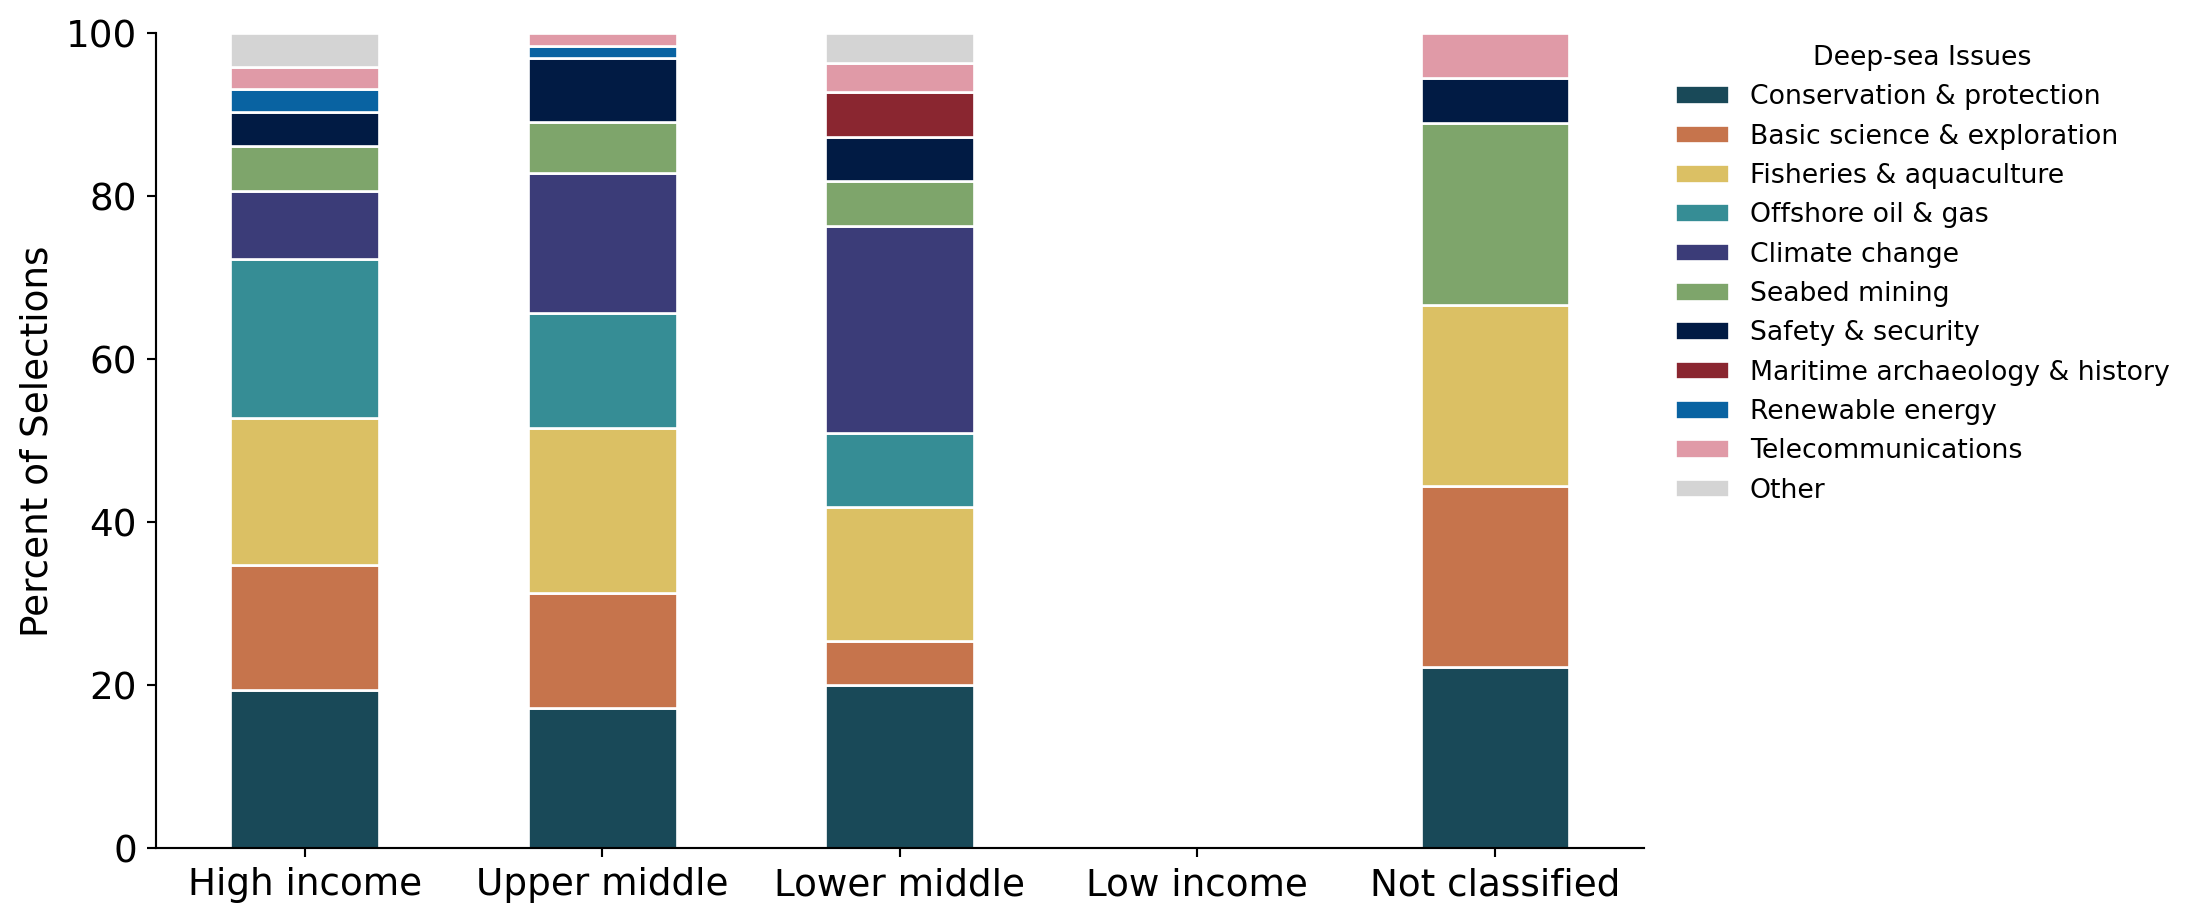

In [51]:
## Create plot

w = 1920
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)

    fig_data[region].plot(kind='bar', 
                  stacked=True,
                  legend=True,
                  fontsize=14,
                  rot=0,
                  color=cat_10,
                  edgecolor='white',
                  ax=ax)

    ax.set_xlabel('', fontsize=14)
    ax.set_ylabel('Percent of Selections', fontsize=14)
    ax.set_ylim([0, 100])
    loc_tweaks = {'Africa': 'upper left'}
    ax.legend(bbox_to_anchor=(1.005, 1.015), loc=loc_tweaker(region, loc_tweaks),
              title='Deep-sea Issues', 
              fontsize=10, 
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='4', letter='H1')

## **Fig I1**&nbsp; Q33: Challenges

In [52]:
## Calculate values for plot

challenges = {}
fig_data = {}
for region in region_list:
    # Select relevant survey data
    challenges[region] = dataR[region].loc[(dataR[region]['question'] == 'Q33') &
                      (dataR[region]['selection_survey_clean'] != ''),
                        ['respondent_id', 'subregion', 'selection_survey_clean']].copy()

    #display(challenges[region])
    covariate = 'subregion'
    fig_data[region] = (challenges[region].groupby([covariate, 'selection_survey_clean'])['respondent_id']
                         .count()
                         .rename('count')
                         .reset_index())

    fig_data[region]['total'] = fig_data[region]['count'].groupby(fig_data[region]['subregion']).transform('sum')
    fig_data[region]['percent'] = round((fig_data[region]['count']/fig_data[region]['total'])*100, 2)
    fig_data[region] = fig_data[region].pivot(columns='selection_survey_clean', index='subregion', values='percent')

    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region)

    # Sort subregions as Katy specified
    sorted_cols = ['Funding',
                   'Human capacity/knowledge to do deep sea research',
                   'Access to vessels',
                   'Access to deep submergence vehicles',
                   'Access to deep sea sensors',
                   'Scalability of technologies',
                   'Lack of connections with other deep sea researchers',
                   'Access to data tools',
                   'Other']
    #display(fig_data[region])
    fig_data[region] = reorder_columns(fig_data[region], sorted_cols)
    #display(fig_data[region])

Adding missing row Low income


In [53]:
## Calculate statistics

for region in region_list:
    count_data = (challenges[region].groupby(['subregion', 'selection_survey_clean'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())

    pivoted = count_data.pivot(columns='selection_survey_clean', index='subregion', values='count')
    pivoted = prep_fig_data_for_plotting(pivoted, region)
    pivoted.loc['Total'] = pivoted.sum()

    # Sort subregions as Katy specified
    sorted_cols = ['Funding',
                   'Human capacity/knowledge to do deep sea research',
                   'Access to vessels',
                   'Access to deep submergence vehicles',
                   'Access to deep sea sensors',
                   'Scalability of technologies',
                   'Lack of connections with other deep sea researchers',
                   'Access to data tools',
                   'Other']
    pivoted = reorder_columns(pivoted, sorted_cols, createmissingcolumns=True)

    pivoted['Total'] = pivoted.sum(axis=1)

    #display(pivoted)

Adding missing row Low income


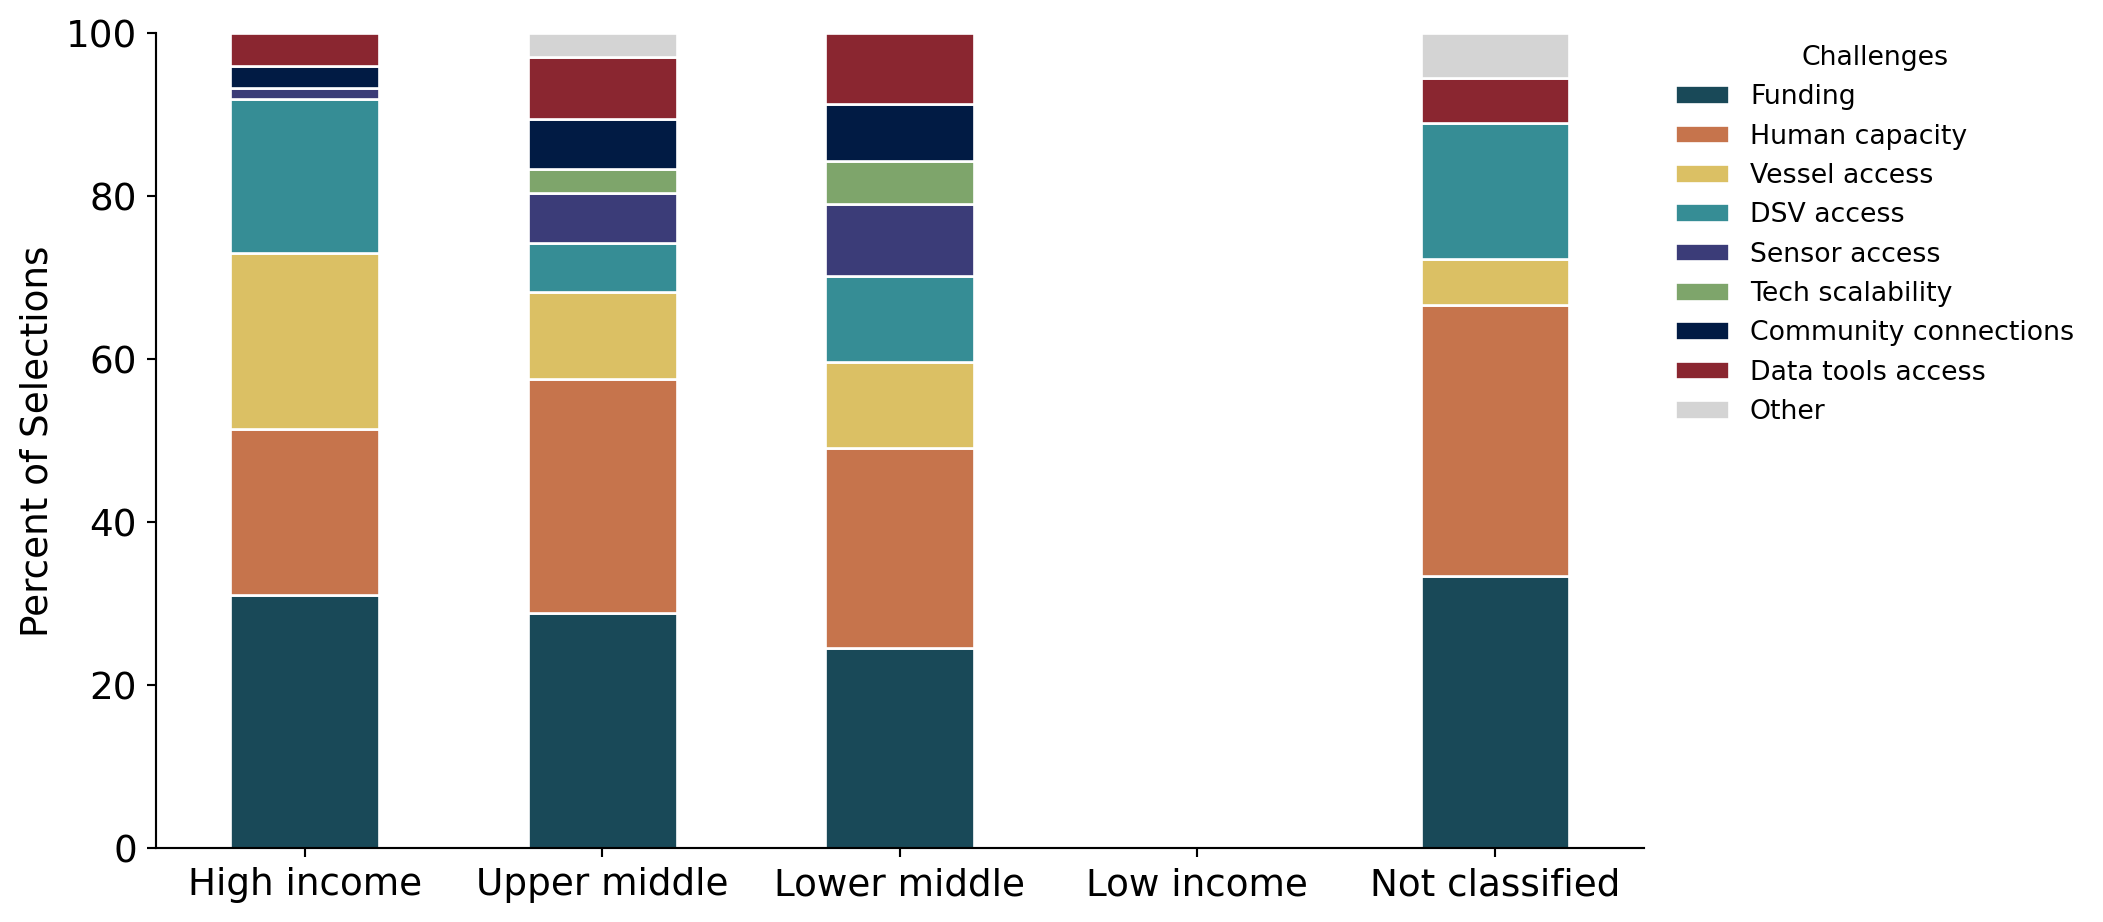

In [54]:
## Create plot

w = 1920
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)

    fig_data[region].plot(kind='bar', 
                  stacked=True,
                  legend=True,
                  fontsize=14,
                  rot=0,
                  color=cat_08,
                  edgecolor='white',
                  ax=ax)

    ax.set_xlabel('', fontsize=14)
    ax.set_ylabel('Percent of Selections', fontsize=14)
    ax.set_ylim([0, 100])
    loc_tweaks = {'Africa': 'upper left'}
    ax.legend(bbox_to_anchor=(1.005, 1.015), loc=loc_tweaker(region, loc_tweaks),
              labels=['Funding',
                      'Human capacity',
                      'Vessel access',
                      'DSV access',
                      'Sensor access',
                      'Tech scalability',
                      'Community connections',
                      'Data tools access',
                      'Other'],
              title='Challenges', 
              fontsize=10, 
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='4', letter='I1')

## **Fig J1**&nbsp; Q34: Opportunities

In [55]:
## Calculate values for plot

opportunities = {}
fig_data = {}
for region in region_list:
    # Select relevant survey data
    opportunities[region] = dataR[region].loc[(dataR[region]['question'] == 'Q34') &
                  (dataR[region]['selection_survey_clean'] != ''),
                         ['respondent_id', 'subregion', 'selection_survey_clean']].copy()  
    
    covariate = 'subregion'

    fig_data[region] = (opportunities[region].groupby([covariate, 'selection_survey_clean'])['respondent_id']
                         .count()
                         .rename('count')
                         .reset_index())

    fig_data[region]['total'] = fig_data[region]['count'].groupby(fig_data[region]['subregion']).transform('sum')
    fig_data[region]['percent'] = round((fig_data[region]['count']/fig_data[region]['total'])*100, 2)
    fig_data[region] = fig_data[region].pivot(columns='selection_survey_clean', index='subregion', values='percent')

    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region)
    # Sort subregions as Katy specified
    sorted_cols = ['Training opportunities',
                   'Less expensive data collection technologies',
                   'Better data access and analysis tools',
                   'Networking/connecting with others',
                   'Better/more precise data collection technologies',
                   'Technology that can go deeper',
                   'Scalable platforms & sensors',
                   'Other']
    fig_data[region] = reorder_columns(fig_data[region], sorted_cols, createmissingcolumns=True)

Adding missing row Low income


In [56]:
## Calculate statistics

for region in region_list:
    count_data = (opportunities[region].groupby(['subregion', 'selection_survey_clean'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())

    pivoted = count_data.pivot(columns='selection_survey_clean', index='subregion', values='count')
    pivoted.loc['Total'] = pivoted.sum()

    pivoted = prep_fig_data_for_plotting(pivoted, region)
    # Sort subregions as Katy specified
    sorted_cols = ['Training opportunities',
                   'Less expensive data collection technologies',
                   'Better data access and analysis tools',
                   'Networking/connecting with others',
                   'Better/more precise data collection technologies',
                   'Technology that can go deeper',
                   'Scalable platforms & sensors',
                   'Other']
    pivoted = reorder_columns(pivoted, sorted_cols, createmissingcolumns=True)

    pivoted['Total'] = pivoted.sum(axis=1)

    #display(pivoted)

Adding missing row Low income


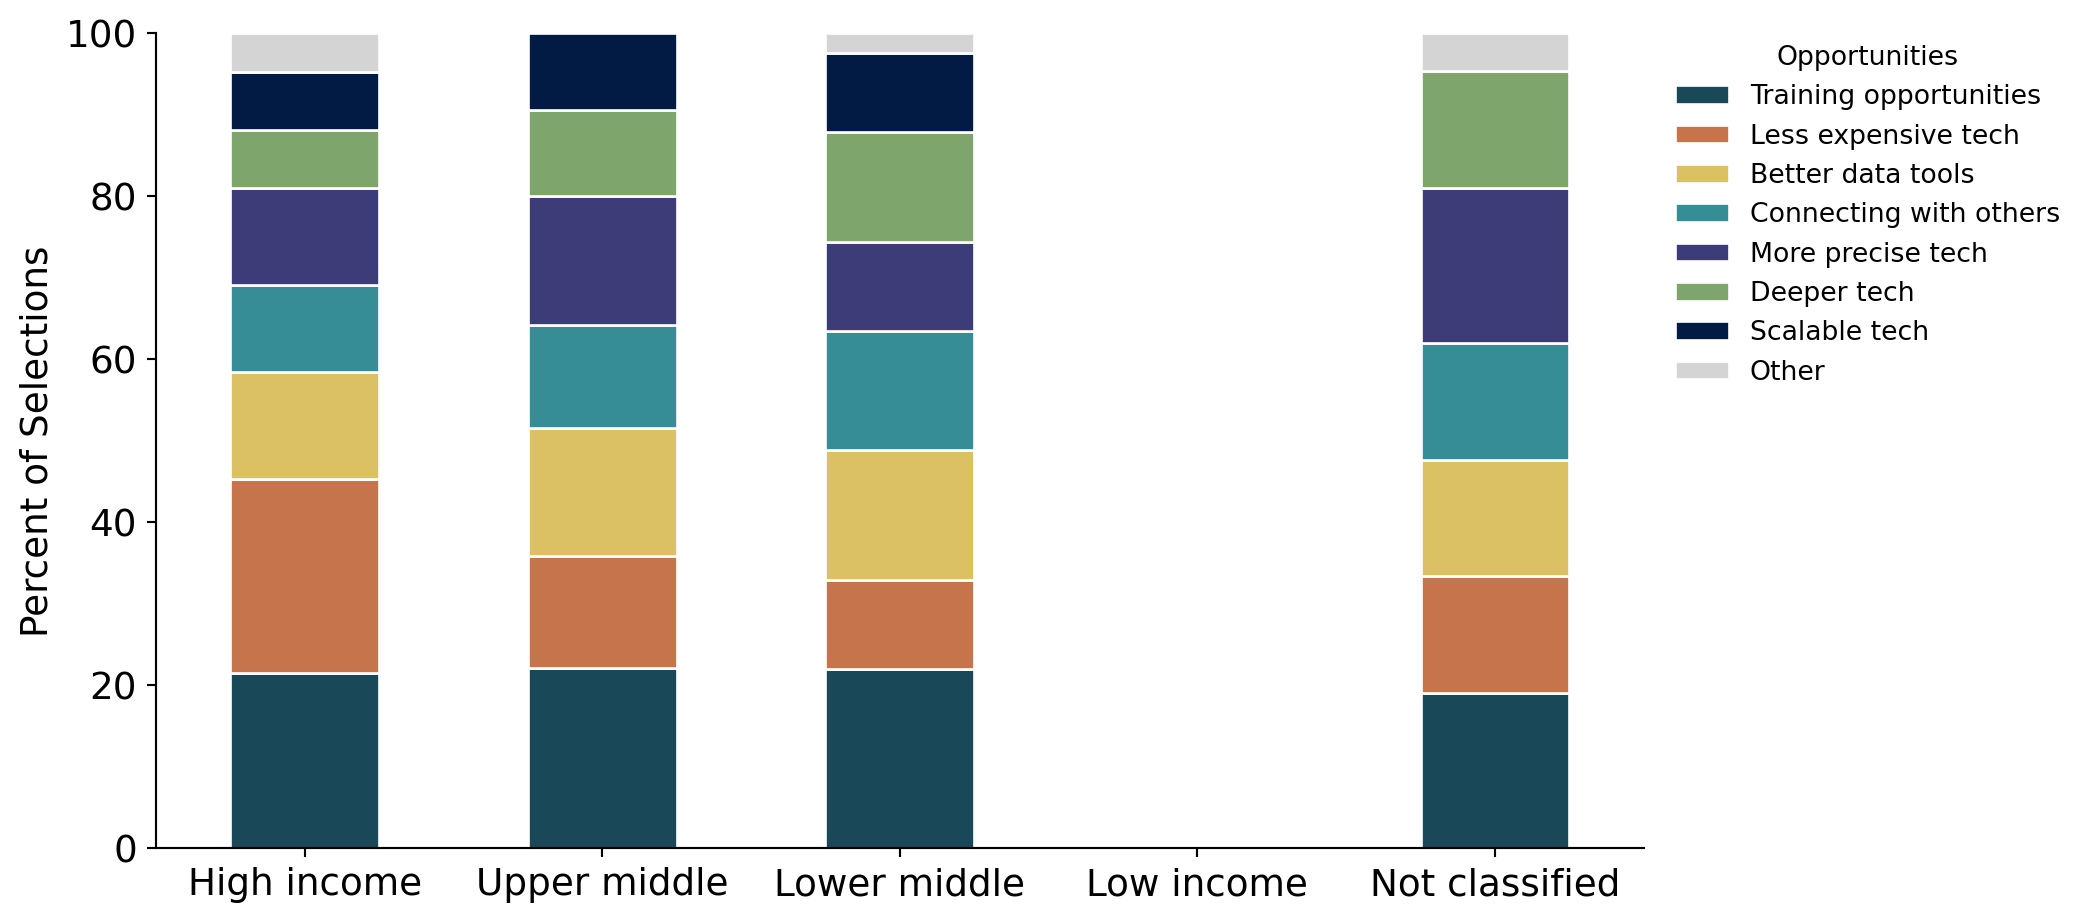

In [57]:
## Create plot

w = 1920
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)

    fig_data[region].plot(kind='bar', 
                  stacked=True,
                  legend=True,
                  fontsize=14,
                  rot=0,
                  color=cat_07,
                  edgecolor='white',
                  ax=ax)

    ax.set_xlabel('', fontsize=14)
    ax.set_ylabel('Percent of Selections', fontsize=14)
    ax.set_ylim([0, 100])
    loc_tweaks = {'Africa': 'upper left'}
    ax.legend(bbox_to_anchor=(1.005, 1.015), loc=loc_tweaker(region, loc_tweaks),
              labels=['Training opportunities',
                      'Less expensive tech',
                      'Better data tools',
                      'Connecting with others',
                      'More precise tech',
                      'Deeper tech',
                      'Scalable tech',
                      'Other'],
              title='Opportunities', 
              fontsize=10, 
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='4', letter='J1')

---
# **Section 5**

## **Figs AA1 AA1b**&nbsp; Marine industries (research)

In [58]:
## Calculate values for plot
industries = {}
num_areas_per_subregion = {}
label_order = {}
fig_data = {}
for region in region_list:
    industries[region] = researchR[region].loc[(researchR[region]['question'] == 'Q10') &
                          (researchR[region]['col_name'] != 'Q10_comments'), ['subregion', 
                                                                     'geoarea',
                                                                     'col_name', 
                                                                     'research_tech_clean']]
    industries[region]['selection_binary'] = industries[region]['research_tech_clean']
    
    # Aggregate selections
    industries[region].loc[industries[region]['col_name'] == 'Q10_aquaculture',   'col_name'] = 'Q10_fisheries'
    industries[region].loc[industries[region]['col_name'] == 'Q10_biotechnology', 'col_name'] = 'Q10_research'
    industries[region].loc[industries[region]['col_name'] == 'Q10_shipping',      'col_name'] = 'Q10_transport'
    
    # Drop duplicates to accomodate "OR" logic
    industries[region].drop_duplicates(inplace=True)
    #display(industries[region])
    
    fig_data[region] = (industries[region].groupby(['subregion', 'col_name'])['selection_binary']
                    .sum()
                    .rename('count')
                    .reset_index())

    num_areas_per_subregion[region] = industries[region].groupby('subregion')['geoarea'].nunique()
    num_areas_dict = dict(zip(num_areas_per_subregion[region].index, num_areas_per_subregion[region].values))
    fig_data[region]['total'] = fig_data[region]['subregion']
    fig_data[region]['total'].replace(num_areas_dict, inplace=True)

    fig_data[region]['percent'] = round((fig_data[region]['count']/fig_data[region]['total'])*100, 2)

    renames = {
        'Q10_fisheries':        'Fisheries & Aquaculture',
        'Q10_transport':        'Marine Transportation',
        'Q10_tourism':          'Tourism',
        'Q10_conservation':     'Conservation & Protection',
        'Q10_offshore_oil':     'Offshore Oil & Gas',
        'Q10_safety':           'Safety & Surveillance',
        'Q10_construction':     'Marine Construction',
        'Q10_research':         'Marine R&D',
        'Q10_renewable_energy': 'Ocean Renewable Energy',
        'Q10_mining':           'Deep-sea Mining',
    }
    fig_data[region]['col_name'].replace(renames, inplace=True)
    hue_order = renames.values()

    fig_data[region]['subregion'].replace(label_adjustments, inplace=True)
    label_order[region] = []
    for x in orderR[region]:
        if x in label_adjustments:
            label_order[region].append(label_adjustments[x])
        else:
            label_order[region].append(x)

    pivoted = fig_data[region].pivot(columns='col_name', index='subregion', values=['count', 'percent'])
    
    pivoted.loc['Total'] = pivoted.sum()
    total_yes_in_region = pivoted.loc['Total', ('count', 'conservation'):('count', 'transport')].sum()
    pivoted.loc['Total', ('percent', 'conservation'):('percent', 'transport')] = \
        ((pivoted.loc['Total', ('count', 'conservation'):('count', 'transport')]/total_yes_in_region).values)*100

    #display(round(pivoted, 2))

In [59]:
## Percent of areas in subregion that have all industry types

for region in region_list:
    num_types = (industries[region].groupby(['subregion', 'geoarea'])['selection_binary']
                     .sum()
                     .rename('num_types')
                     .reset_index())

    num_types['has_all'] = 0
    num_types.loc[num_types['num_types'] == 10, 'has_all'] = 1

    all_types = num_types.groupby('subregion')['has_all'].sum().reset_index()
    all_types['total'] = num_areas_per_subregion[region].values
    all_types['percent'] = round((all_types['has_all']/all_types['total'])*100, 2)

    #display(all_types)

    ## Percent of areas in subregion that have < 3 industry types
    num_types['less_than_3'] = 0
    num_types.loc[num_types['num_types'] < 3, 'less_than_3'] = 1

    few_types = num_types.groupby('subregion')['less_than_3'].sum().reset_index()
    few_types['total'] = num_areas_per_subregion[region].values
    few_types['percent'] = round((few_types['less_than_3']/few_types['total'])*100, 2)

    #display(few_types)

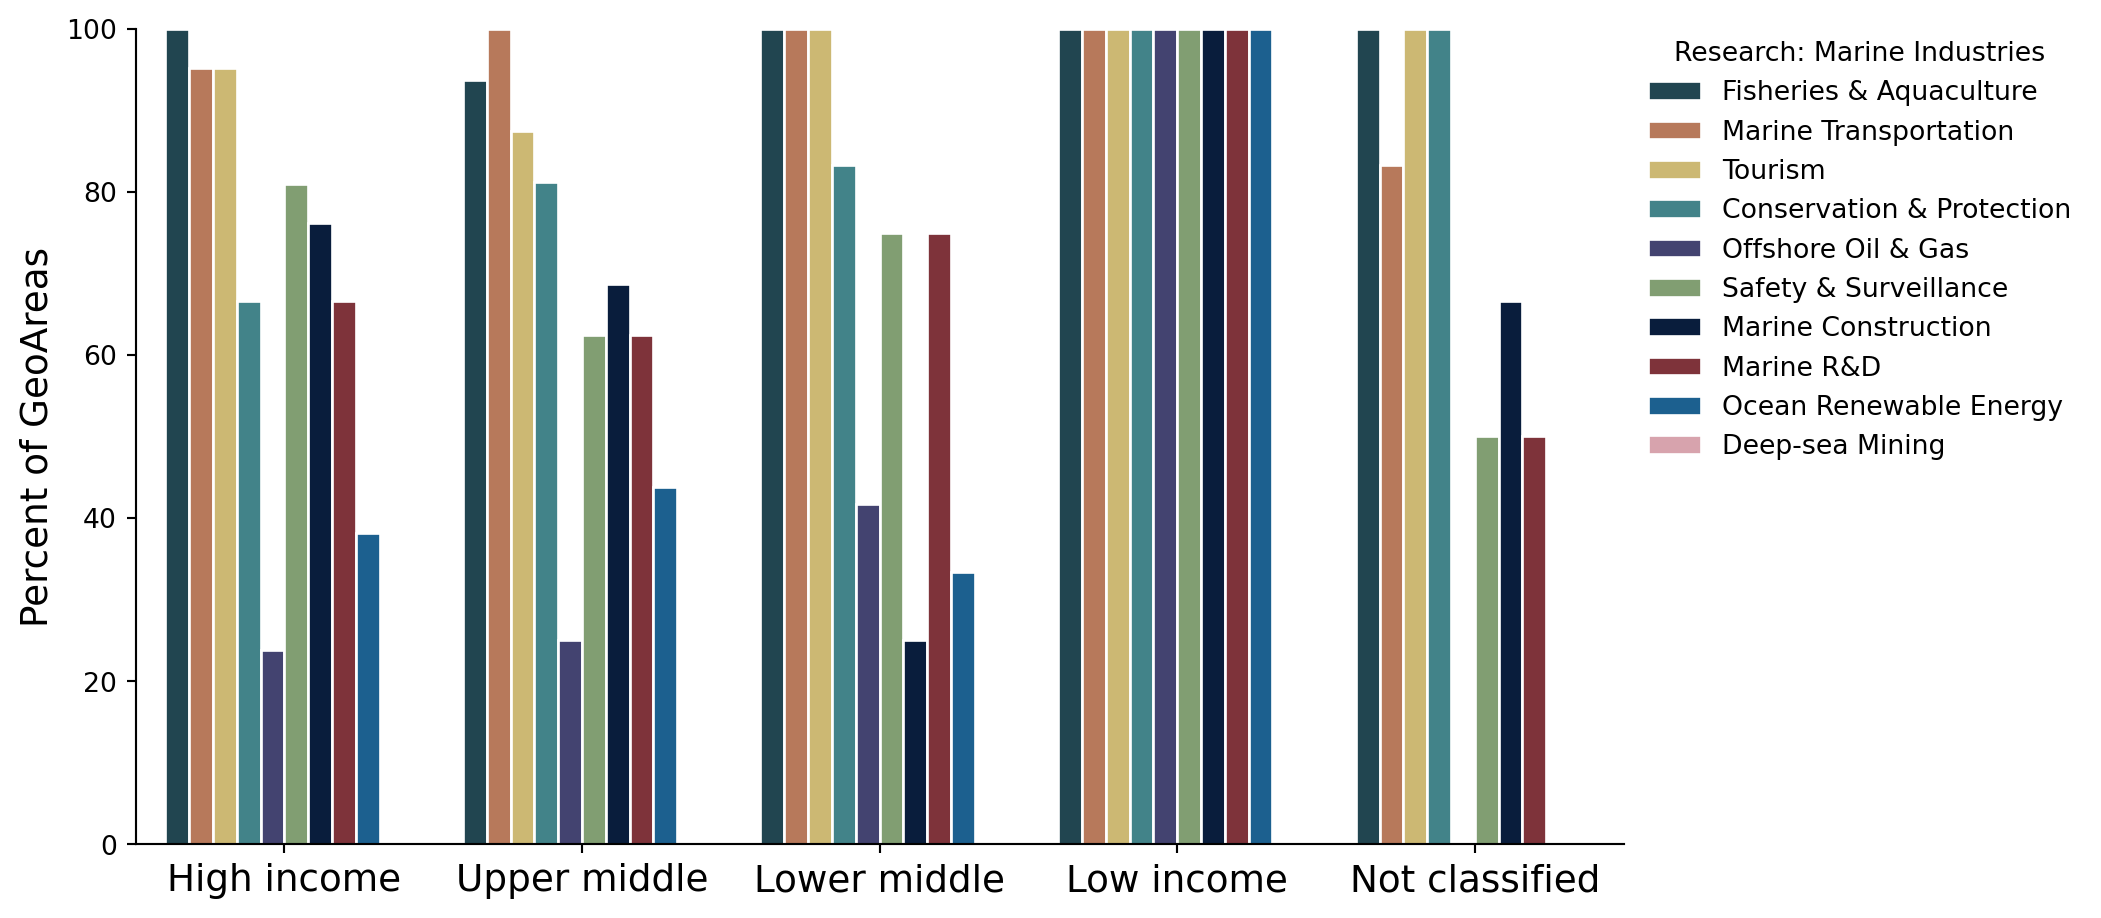

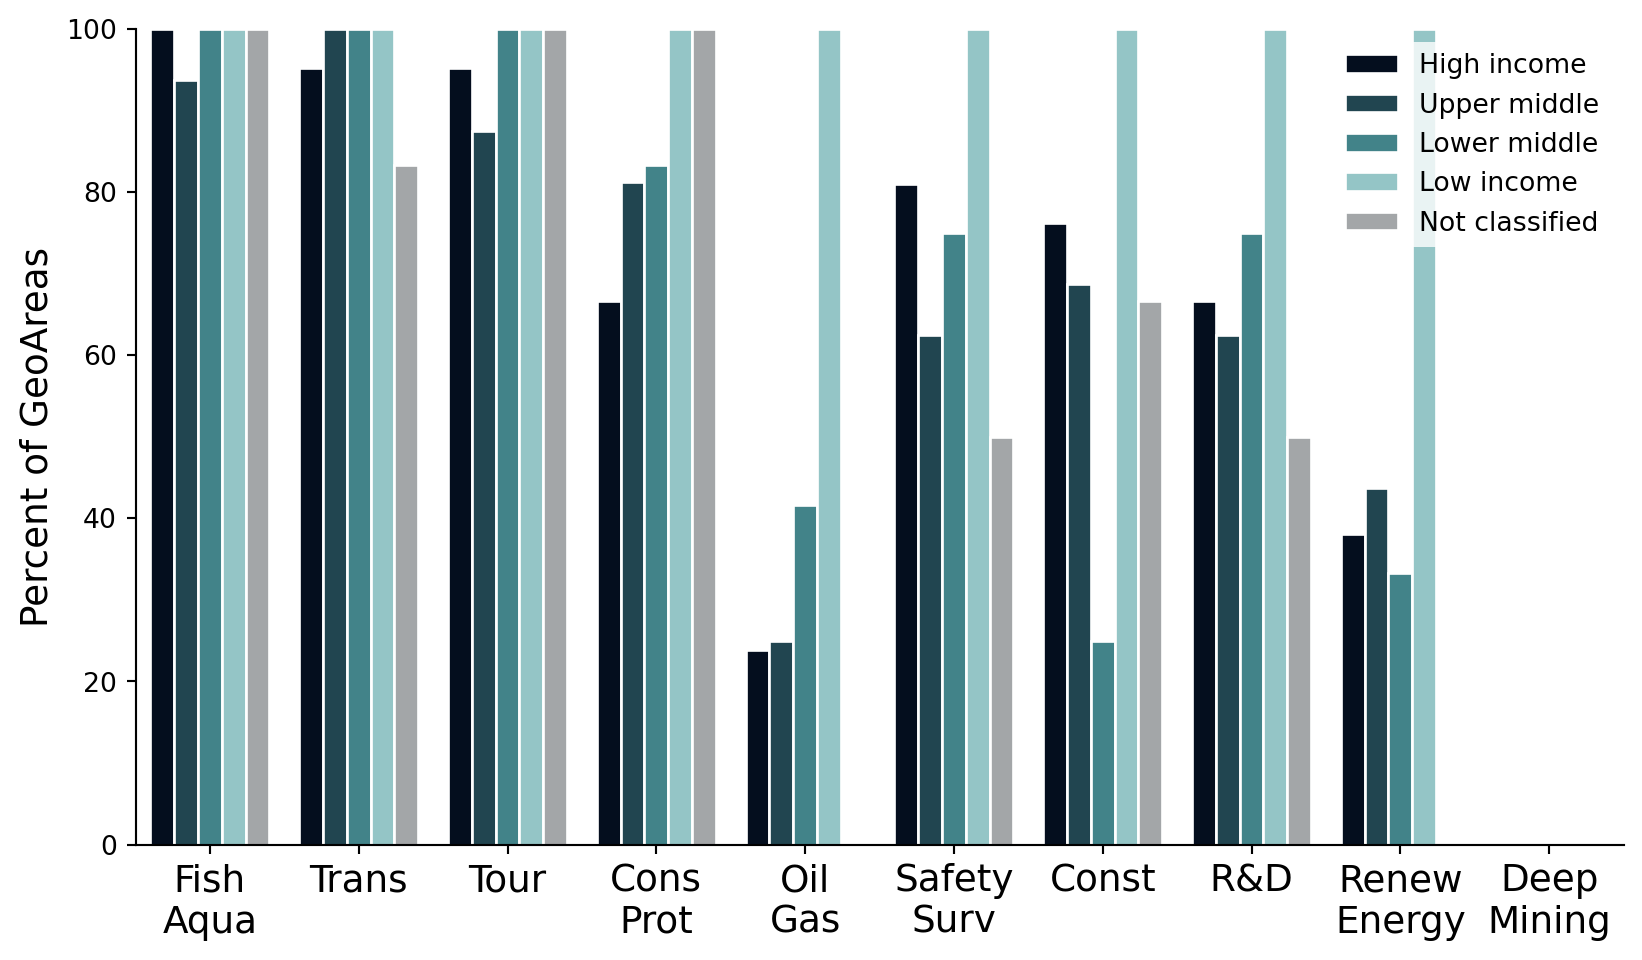

In [60]:
## Create plot

w = 1920
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
    ax = sns.barplot(x='subregion',
                     y='percent',
                     hue='col_name',
                     order=label_order[region],
                     hue_order=hue_order,
                     palette=cat_10,
                     edgecolor='white',
                     ci=None,
                     data=fig_data[region])            

    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=14)
    ax.set(xlabel=None)
    ax.set_ylim([0, 100])
    ax.set_ylabel('Percent of GeoAreas', fontsize=14)
    ax.legend(bbox_to_anchor=(1, 1.015),
              loc='upper left',
              title='Research: Marine Industries',
              fontsize=10,
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='5', letter='AA1')

    ### AA1b

    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
    ax = sns.barplot(x='col_name',
                     y='percent',
                     hue='subregion',
                     order=hue_order,
                     hue_order=label_order[region],
                     palette=cat_d23e123_by_region[region],
                     edgecolor='white',
                     ci=None,
                     data=fig_data[region])            

    ax.set_xticklabels(["Fish\nAqua", "Trans", "Tour", "Cons\nProt", "Oil\nGas", "Safety\nSurv", "Const", "R&D", "Renew\nEnergy", "Deep\nMining"], rotation=0, fontsize=14)
    ax.set_xlabel('', fontsize=14)
    ax.set_ylim([0, 100])
    ax.set_ylabel('Percent of GeoAreas', fontsize=14)

    xaxis_key = [
        'Fisheries & Aquaculture',
        'Marine Transportation',
        'Tourism',
        'Conservation & Protection',
        'Offshore Oil & Gas',
        'Safety & Surveillance',
        'Marine Construction',
        'Marine R&D',
        'Ocean Renewable Energy',
        'Deep-sea Mining'
    ]

    ax.legend(loc='upper right',
              fontsize=10,
              title_fontsize=10)
                  
    outputfigs(plt, fig, ax, region, section='5', letter='AA1b')

## **Figs AA2 AA2b**&nbsp; Marine industries (survey)

In [61]:
### Calculate values for plot
industries = {}
label_order = {}
fig_data = {}
num_areas_per_subregion = {}
for region in region_list:
    industries[region] = dataR[region].loc[(dataR[region]['question'] == 'Q10'), ['subregion', 
                                                  'geoarea',
                                                  'selection_survey_clean']]

    industries[region] = industries[region][industries[region]['selection_survey_clean'] != '']

    fig_data[region] = (industries[region].groupby(['subregion', 'selection_survey_clean'])['geoarea']
                .count()
                .rename('count')
                .reset_index())
    
    hue_order = [
        'Fisheries & Aquaculture',
        'Marine Transportation',
        'Tourism',
        'Conservation & Protection',
        'Offshore Oil & Gas',
        'Safety & Surveillance',
        'Marine Construction',
        'Marine R&D',
        'Ocean Renewable Energy',
        'Deep-sea Mining',
        'Other'
    ]

    country_num_survey = country_tableR[region].groupby(['subregion'])[['subregion', 'num_survey']].sum()
    #display(country_num_survey)

    num_survey_dict = dict(zip(country_num_survey.index, country_num_survey.values))
    fig_data[region]['total'] = fig_data[region]['subregion']
    fig_data[region]['total'].replace(num_survey_dict, inplace=True)
    #display(fig_data[region])

    fig_data[region]['percent'] = round((fig_data[region]['count']/fig_data[region]['total'])*100, 2)
    
    fig_data[region]['subregion'].replace(label_adjustments, inplace=True)
    label_order[region] = []
    for x in orderR[region]:
        if x in label_adjustments:
            label_order[region].append(label_adjustments[x])
        else:
            label_order[region].append(x)
    #display(fig_data[region])


    if industries[region].shape[0] == 0:
        print('zero results for region', region, 'skipping it', file=sys.stderr)
        continue
    pivoted = fig_data[region].pivot(columns='selection_survey_clean', index='subregion', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()
    total_in_region = pivoted.loc['Total', ('count', 'Deep sea mining'):('count', 'Tourism')].sum()
    pivoted.loc['Total', ('percent', 'Deep sea mining'):('percent', 'Tourism')] = \
        ((pivoted.loc['Total', ('count', 'Deep sea mining'):('count', 'Tourism')]/total_in_region).values)*100

    out = round(pivoted['count'], 2)
    #display(Markdown('**'+region+'**'), out)

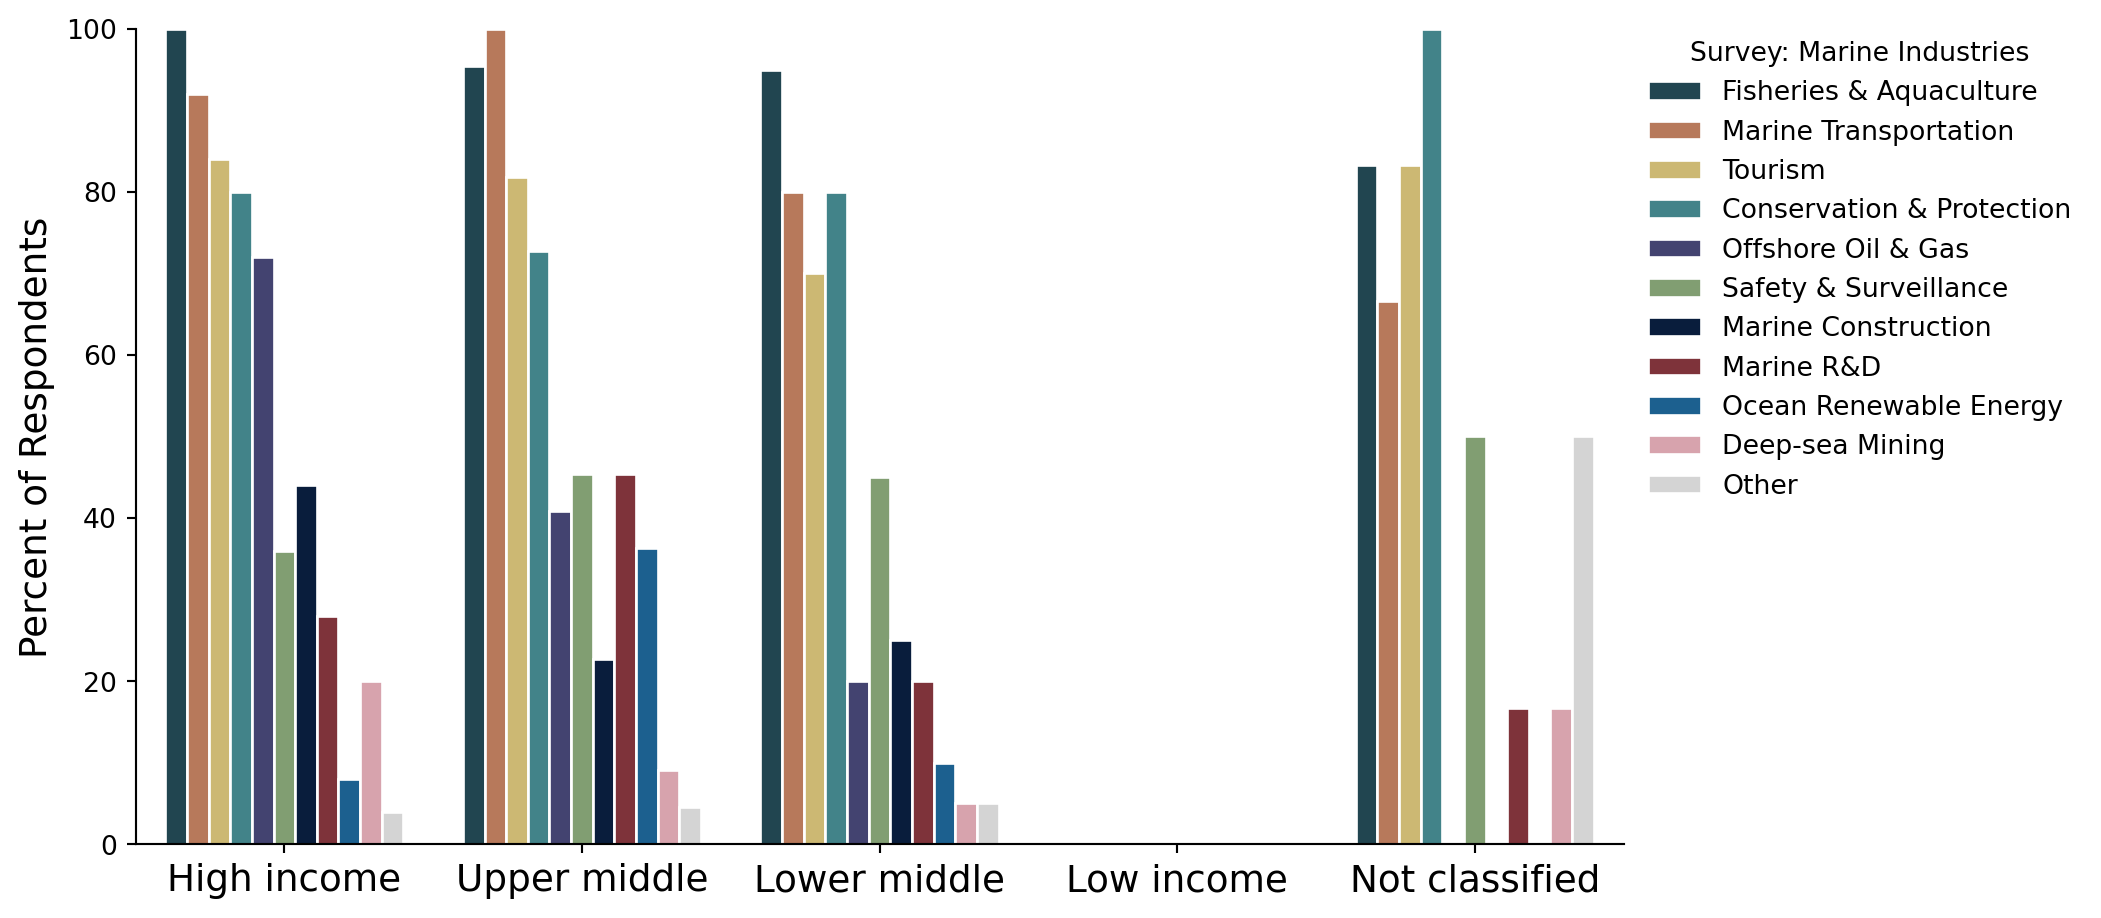

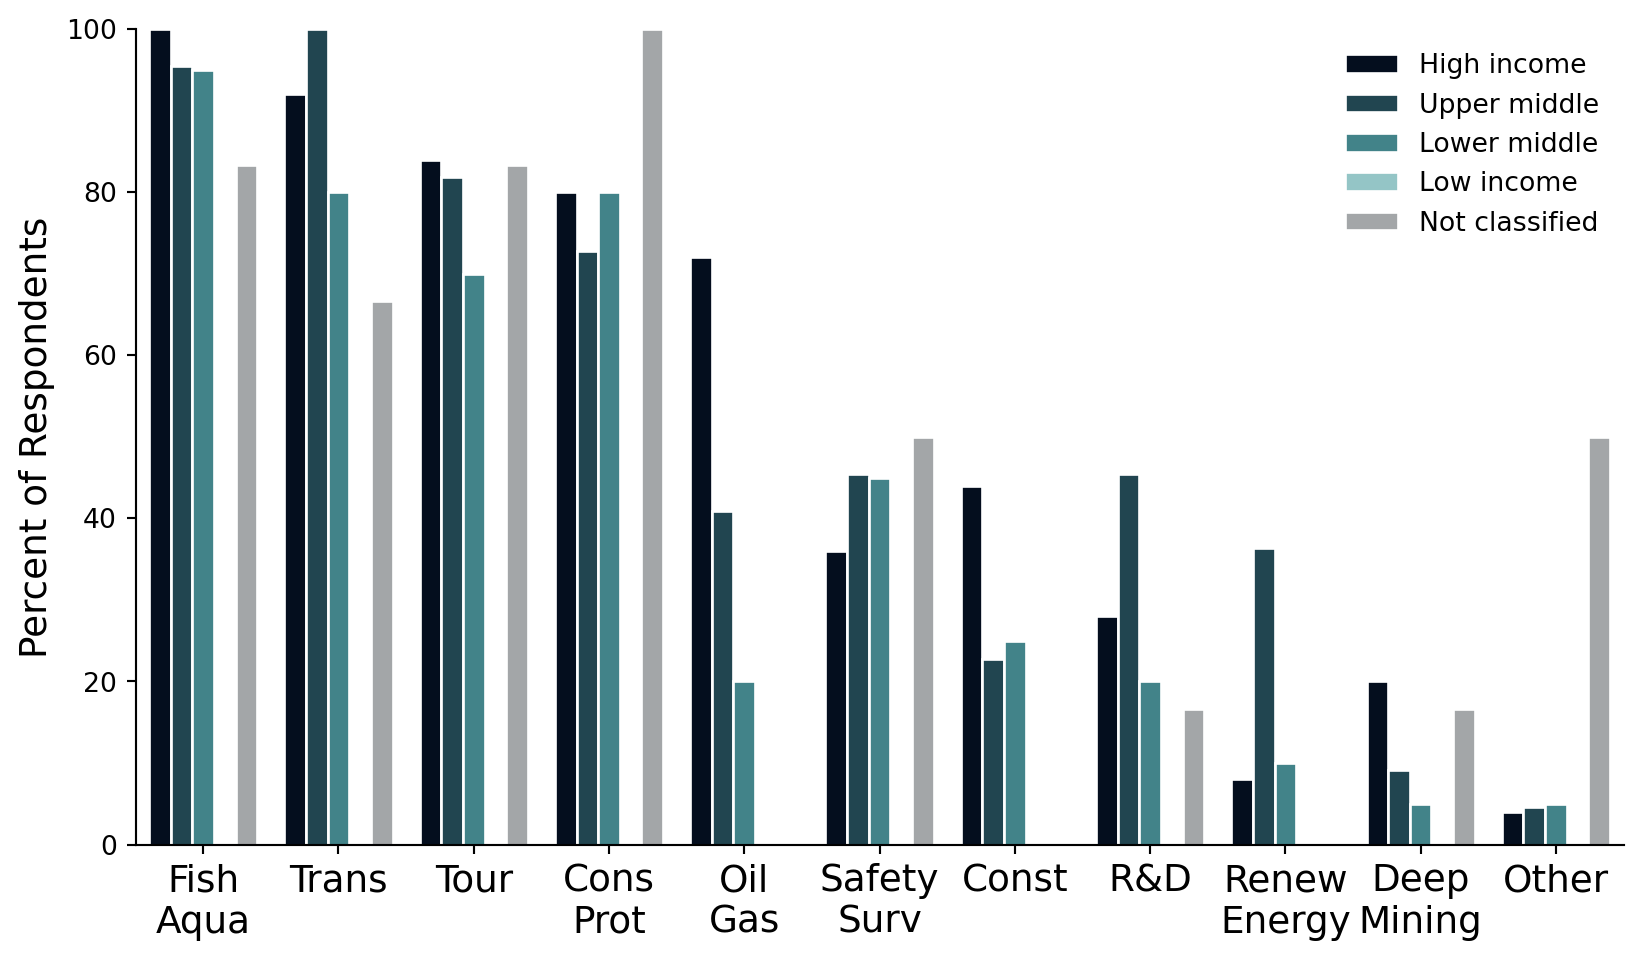

In [62]:
## Create plot

w = 1920
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
    ax = sns.barplot(x='subregion',
                 y='percent',
                 hue='selection_survey_clean',
                 order=label_order[region],
                 hue_order=hue_order,
                 palette=cat_10,
                 edgecolor='white',
                 ci=None,
                 data=fig_data[region][fig_data[region]['selection_survey_clean'] != 'None of the above'])            

    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=14)
    ax.set(xlabel=None)
    ax.set_ylim([0, 100])
    ax.set_ylabel('Percent of Respondents', fontsize=14)
    loc_tweaks = {'Africa': 'upper left'}
    ax.legend(bbox_to_anchor=(1, 1.015),
          loc=loc_tweaker(region, loc_tweaks),
          labels=hue_order,
          title='Survey: Marine Industries',
          fontsize=10,
          title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='5', letter='AA2')

    ### AA2b

    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
    ax = sns.barplot(x='selection_survey_clean',
                 y='percent',
                 hue='subregion',
                 order=hue_order,
                 hue_order=label_order[region],
                 palette=cat_d23e123_by_region[region],
                 edgecolor='white',
                 ci=None,
                 data=fig_data[region][fig_data[region]['selection_survey_clean'] != 'None of the above'])            

    ax.set_xticklabels(["Fish\nAqua",
                        "Trans",
                        "Tour",
                        "Cons\nProt",
                        "Oil\nGas",
                        "Safety\nSurv",
                        "Const",
                        "R&D",
                        "Renew\nEnergy",
                        "Deep\nMining",
                        "Other"],
                       rotation=0,
                       fontsize=14)

    ax.set_xlabel('', fontsize=14)
    ax.set_ylim([0, 100])
    ax.set_ylabel('Percent of Respondents', fontsize=14)
    loc_tweaks = {'Africa': 'upper left'}
    ax.legend(bbox_to_anchor=(1, 1.015),
          loc=loc_tweaker(region, loc_tweaks),
          labels=['Fisheries & Aquaculture',
                  'Marine Transportation',
                  'Tourism',
                  'Conservation & Protection',
                  'Offshore Oil & Gas',
                  'Safety & Surveillance',
                  'Marine Construction',
                  'Marine R&D',
                  'Ocean Renewable Energy',
                  'Deep-sea Mining',
                  'Other'],
          title='Survey: Marine Industries',
          fontsize=10,
          title_fontsize=10)

    xaxis_key = [
        'Fisheries & Aquaculture',
        'Marine Transportation',
        'Tourism',
        'Conservation & Protection',
        'Offshore Oil & Gas',
        'Safety & Surveillance',
        'Marine Construction',
        'Marine R&D',
        'Ocean Renewable Energy',
        'Deep-sea Mining'
    ]

    ax.legend(loc='upper right',
              fontsize=10,
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='5', letter='AA2b')

## **Fig AA3**

In [63]:
# Select relevant data for bar plot
research_q7q8q9 = {}
orgtype_count = {}
for region in region_list:
    research_q7q8q9[region] = researchR[region].loc[researchR[region]['question'].isin(['Q7', 'Q8', 'Q9'])]

    orgtype_count[region] = (
        research_q7q8q9[region].loc[research_q7q8q9[region]['research_org_clean'] != 'FALSE', 
                        ['geoarea', 'subregion', 'research_org_clean']]
                                .copy()
                                #.drop_duplicates() # no!
                                .groupby(['subregion', 'research_org_clean'])['geoarea']
                                #.nunique() # nope!
                                .count()
                                .rename('count')
                                .reset_index())

    #display(orgtype_count[region])

In [64]:
fig_data = {}
for region in region_list:
    fig_data[region] = pd.pivot_table(data=orgtype_count[region], index=['subregion'], columns=['research_org_clean'], values='count')

    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region)

    #display(fig_data[region])

In [65]:
# Select relevant data for line plot

fig_data_2 = {}
for region in region_list:
    country_survey_and_research_geo = country_tableR[region][['subregion','num_survey','num_research_geo']]
    country_survey_and_research_geo.set_index('subregion')

    fig_data_2[region] = country_survey_and_research_geo[['subregion','num_survey','num_research_geo']].groupby('subregion').sum()

    surveys_plus_research = fig_data_2[region][['num_survey','num_research_geo']].sum(axis=1)
    fig_data_2[region]['total'] = surveys_plus_research

    fig_data_2[region] = prep_fig_data_for_plotting(fig_data_2[region], region)
    #display(fig_data_2[region])


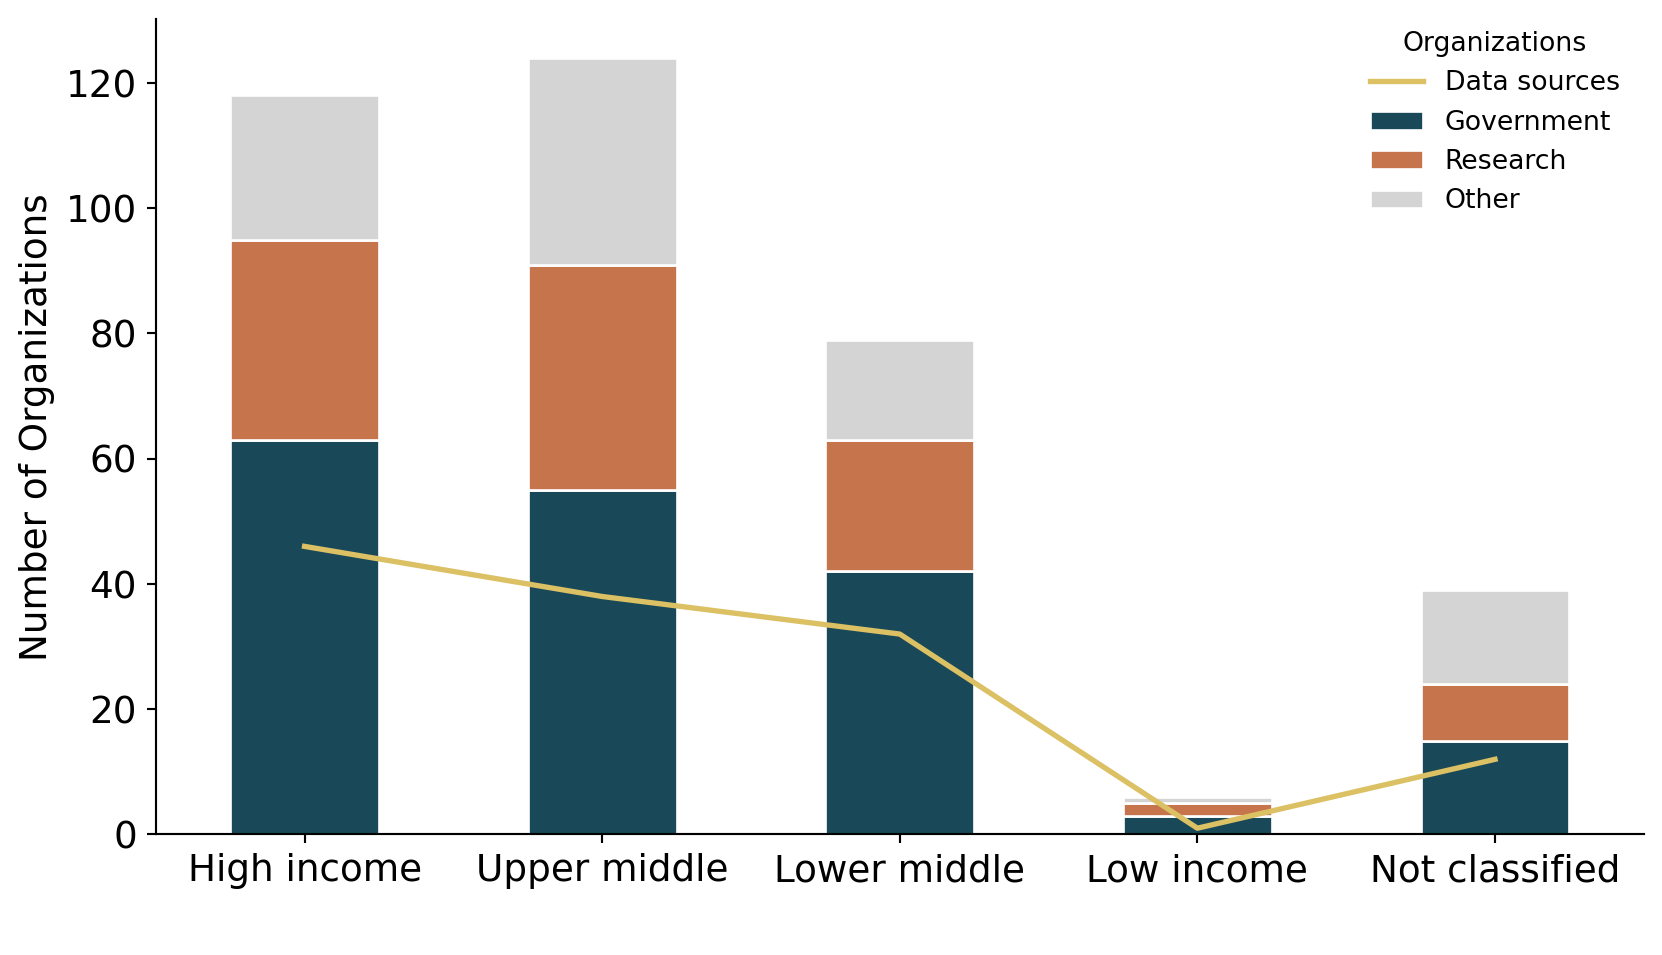

In [66]:
### Create plots

w = 1920
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
    
    fig_data[region].plot(kind='bar', 
              stacked=True,
              legend=True,
              fontsize=14,
              color=cat_02,
              edgecolor='white',
              ax=ax)
    ax.set_xlabel('Number of GeoAreas', fontsize=14)
    ax.set_ylabel('')
    loc_tweaks = {'Africa': 'upper right'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
          labels=['Sovereign Country', 
                  'Dependent Territory'], title='GeoArea Status', fontsize=10, title_fontsize=10)


    sns.lineplot(x='subregion',
                  y='total',
                  color='#DBC064',
                  linewidth=2,
                  ci=None,
                  data=fig_data_2[region])

    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=14)
    ax.set(xlabel=None)
    ax.set_xlabel(' ', fontsize=14)
    ax.set_ylabel('Number of Organizations', fontsize=14)
    loc_tweaks = {'Africa': 'upper left'}
    ax.legend(bbox_to_anchor=(1, 1.015),
          loc=loc_tweaker(region, loc_tweaks),          
          labels=['Data sources',
                  'Government', 'Research', 'Other'],
          title='Organizations',
          fontsize=10,
          title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='5', letter='AA3')

## **Fig AB1**&nbsp; DSC Access / Presence / Satisfaction

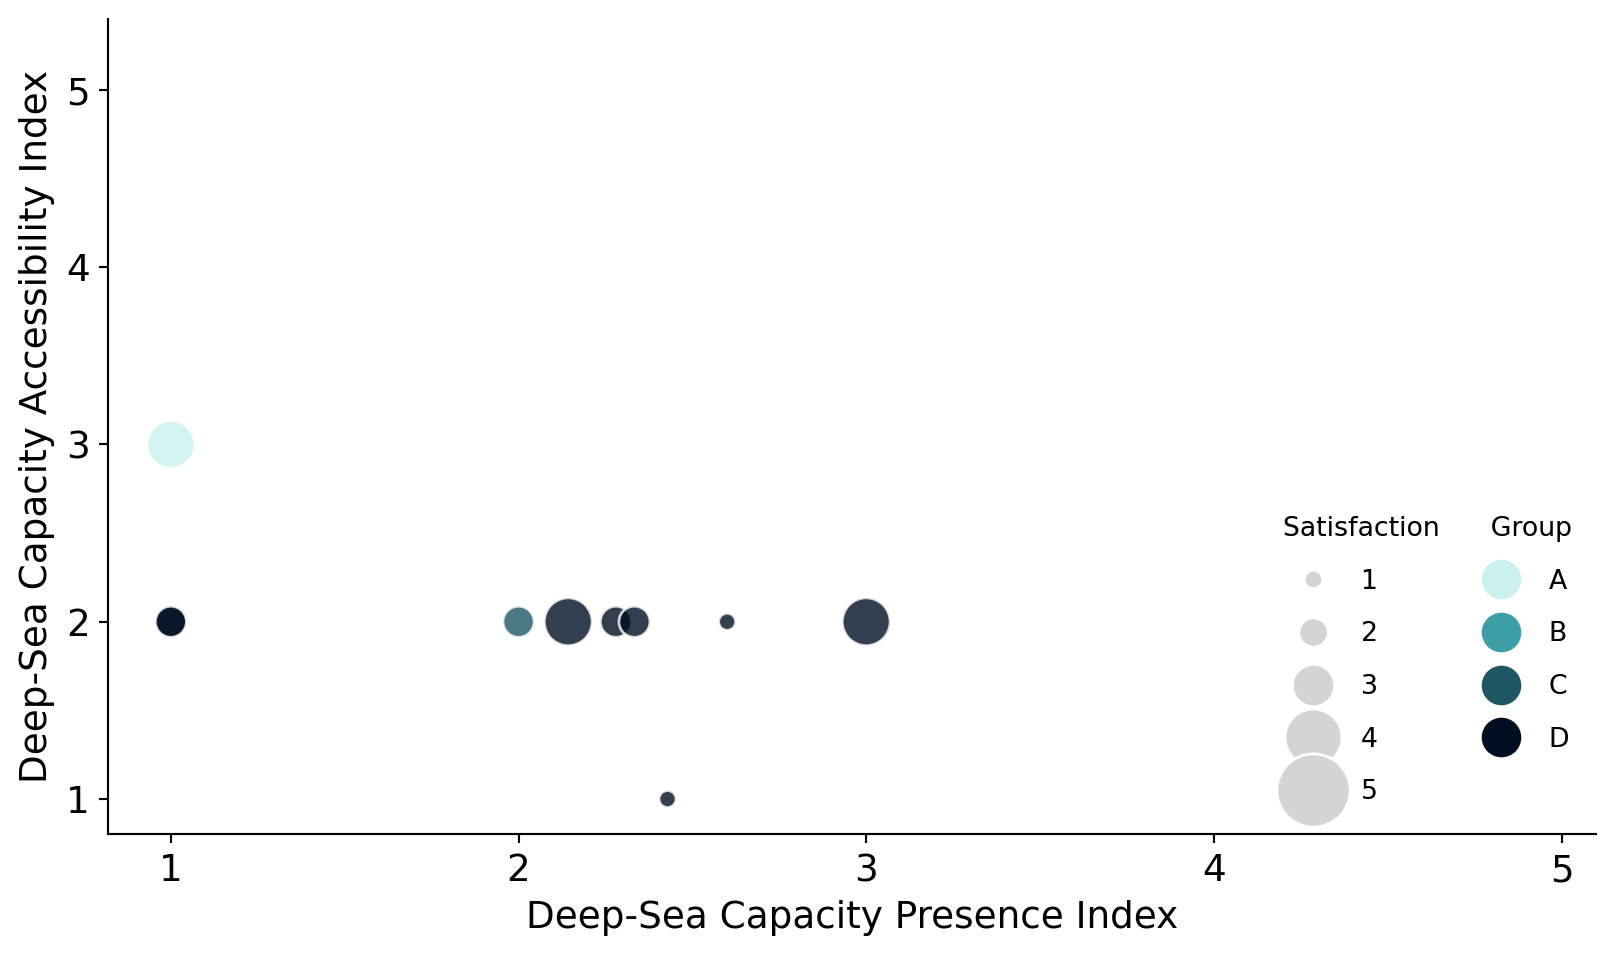

In [67]:
## Calculate fig data

fig_data = {}
for region in region_list:
    dsc_pi_means = (country_tableR[region]
                .groupby('subregion_orig')['dsc-pi-all']
                .mean()
                .rename('dsc-pi-mean'))
    dsc_ai = (country_tableR[region]
                .groupby('subregion_orig')['dsc-ai-all']
                .mean()
                .rename('dsc-ai-mean'))
    dsc_si = (country_tableR[region]
                .groupby('subregion_orig')['dsc-si-all']
                .mean()
                .fillna(0)
                .astype(int)
                .rename('dsc-si-mean'))
    dsc_group = (country_tableR[region].loc[country_tableR[region]['dsc-index-group'].notna()]
                .groupby('subregion_orig')[['subregion_orig', 'dsc-index-group']]
                .head(1))
    dsc_group = dsc_group.set_index('subregion_orig')
        
    fig_data[region] = pd.concat([dsc_pi_means, dsc_ai, dsc_si, dsc_group], axis=1)
    drops = []
    for key in ignoreR:
        drops += ignoreR[key]
    fig_data[region] = fig_data[region].drop(drops, errors='ignore')
    
    nancount = fig_data[region].isnull().sum().sum()
    if nancount > 0:
        print('warning: found {} NaNs in the data for region {}, dropping rows with NaN'.format(nancount, region), file=sys.stderr)
        rows_before = fig_data[region].shape[0]
        fig_data[region] = fig_data[region].dropna()
        rows_after = fig_data[region].shape[0]
        print('warning: dropped {} rows with NaN for region {}'.format(rows_before - rows_after, region), file=sys.stderr)
    # sort by reverse bubble size so small bubbles are not obscured by larger ones
    fig_data[region] = fig_data[region].sort_values('dsc-si-mean', ascending=False)


## Plot figure

w = 1920
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)

    sizes = [((x+1)**3)*5 for x in fig_data[region]['dsc-si-mean'].tolist()]
    groups=['A', 'B', 'C', 'D']
    colors = [groups.index(x) for x in fig_data[region]['dsc-index-group'].tolist()]

    fig_data[region].plot('dsc-pi-mean', 'dsc-ai-mean', kind='scatter', 
                  rot=0,
                  fontsize=14,
                  s=sizes,
                  c=colors,
                  cmap=matplotlib.colors.ListedColormap(val_04_rev),
                  edgecolor='white',
                  alpha=0.8,
                  ax=ax)

    ax.set_xlabel('Deep-Sea Capacity Presence Index', fontsize=14)
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.set_xticklabels(['1','2','3','4','5'])
    ax.set_ylabel('Deep-Sea Capacity Accessibility Index', fontsize=14)
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.set_yticklabels(['1','2','3','4','5'])
    plt.xlim(0.82,5.1)
    plt.ylim(0.8,5.4)

    markers = []
    labels = []
    for i in range(0, 5):
        size = math.sqrt(((i+2)**3)*3)+2
        color = '#d4d4d4'
        labels.append(str(i+1)+'     ')
        markers.append(matplotlib.lines.Line2D(range(1), range(1), color='white', marker='o', markersize=size, markerfacecolor=color, markeredgecolor='white'))
    for i in range(0,4):
        size = math.sqrt(((2+2)**3)*3)+2
        color = val_04_rev[i]
        labels.append(groups[i])
        markers.append(matplotlib.lines.Line2D(range(1), range(1), color='white', marker='o', markersize=size, markerfacecolor=color))
    ax.add_artist(plt.legend(markers, labels, numpoints=1, fontsize=10, labelspacing=1, ncol=2, title='Satisfaction      Group',
                             bbox_to_anchor=(1, 0.42),
                             loc='upper right'))

    outputfigs(plt, fig, ax, region, section='5', letter='AB1')

## **Fig AB1b**

In [68]:
## Calculate fig data

regions_to_skip = ['Global', 'Economies', 'SIDS']

dsc_pi_means = (country_tableR['Global']
            .groupby('subregion_orig')['dsc-pi-all']
            .mean()
            .rename('dsc-pi-mean'))
dsc_ai = (country_tableR['Global']
            .groupby('subregion_orig')['dsc-ai-all']
            .mean()
            .rename('dsc-ai-mean'))
dsc_si = (country_tableR['Global']
            .groupby('subregion_orig')['dsc-si-all']
            .mean()
            .fillna(0)
            .astype(int)
            .rename('dsc-si-mean'))
dsc_group = (country_tableR['Global'].loc[country_tableR['Global']['dsc-index-group'].notna()]
            .groupby('subregion_orig')[['subregion_orig', 'dsc-index-group']]
            .head(1))
dsc_group = dsc_group.set_index('subregion_orig')

fig_data_global = pd.concat([dsc_pi_means, dsc_ai, dsc_si, dsc_group], axis=1)
drops = []
for key in ignoreR:
    drops += ignoreR[key]
fig_data_global = fig_data_global.drop(drops, errors='ignore')

colors = {}
fig_data = {}
for region in region_list:
    if region in regions_to_skip:
        print('Skipping region', region);
        continue

    fig_data[region] = fig_data_global.copy()
    # sort by reverse bubble size so small bubbles are not obscured by larger ones
    fig_data[region] = fig_data[region].sort_values('dsc-si-mean', ascending=False)

    groups=['A', 'B', 'C', 'D']
    colors[region] = []
    for index in fig_data[region].index:
        if index in orderR[region]:
            group = fig_data[region].loc[index]['dsc-index-group']
            colors[region].append(val_04_rev[groups.index(group)])
        else:
            colors[region].append('#d4d4d4')


## Plot figure

w = 1920
h = 1080

for region in region_list:
    if region in regions_to_skip:
        continue

    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)

    sizes = [((x+1)**3)*5 for x in fig_data[region]['dsc-si-mean'].tolist()]

    fig_data[region].plot('dsc-pi-mean', 'dsc-ai-mean', kind='scatter', 
                  rot=0,
                  fontsize=14,
                  s=sizes,
                  c=colors[region],
                  edgecolor='white',
                  alpha=0.8,
                  ax=ax)
    ax.set_xlabel('Deep-Sea Capacity Presence Index', fontsize=14)
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.set_xticklabels(['1','2','3','4','5'])
    ax.set_ylabel('Deep-Sea Capacity Accessibility Index', fontsize=14)
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.set_yticklabels(['1','2','3','4','5'])
    plt.xlim(0.82,5.1)
    plt.ylim(0.8,5.4)

    markers = []
    labels = []
    for i in range(0, 5):
        size = math.sqrt(((i+2)**3)*3)+2
        color = '#d4d4d4'
        labels.append(str(i+1)+'     ')
        markers.append(matplotlib.lines.Line2D(range(1), range(1), color='white', marker='o', markersize=size, markerfacecolor=color, markeredgecolor='white'))
    for i in range(0,4):
        size = math.sqrt(((2+2)**3)*3)+2
        color = val_04_rev[i]
        labels.append(groups[i])
        markers.append(matplotlib.lines.Line2D(range(1), range(1), color='white', marker='o', markersize=size, markerfacecolor=color))
    ax.add_artist(plt.legend(markers, labels, numpoints=1, fontsize=10, labelspacing=1, ncol=2, title='Satisfaction      Group',
                             bbox_to_anchor=(1, 0.42),
                             loc='upper right'))

    outputfigs(plt, fig, ax, region, section='5', letter='AB1b')

Skipping region SIDS


## **Figs AC1-AC7**&nbsp; Distribution of DSC-PI-vessel presence (country)

adding empty row for 5


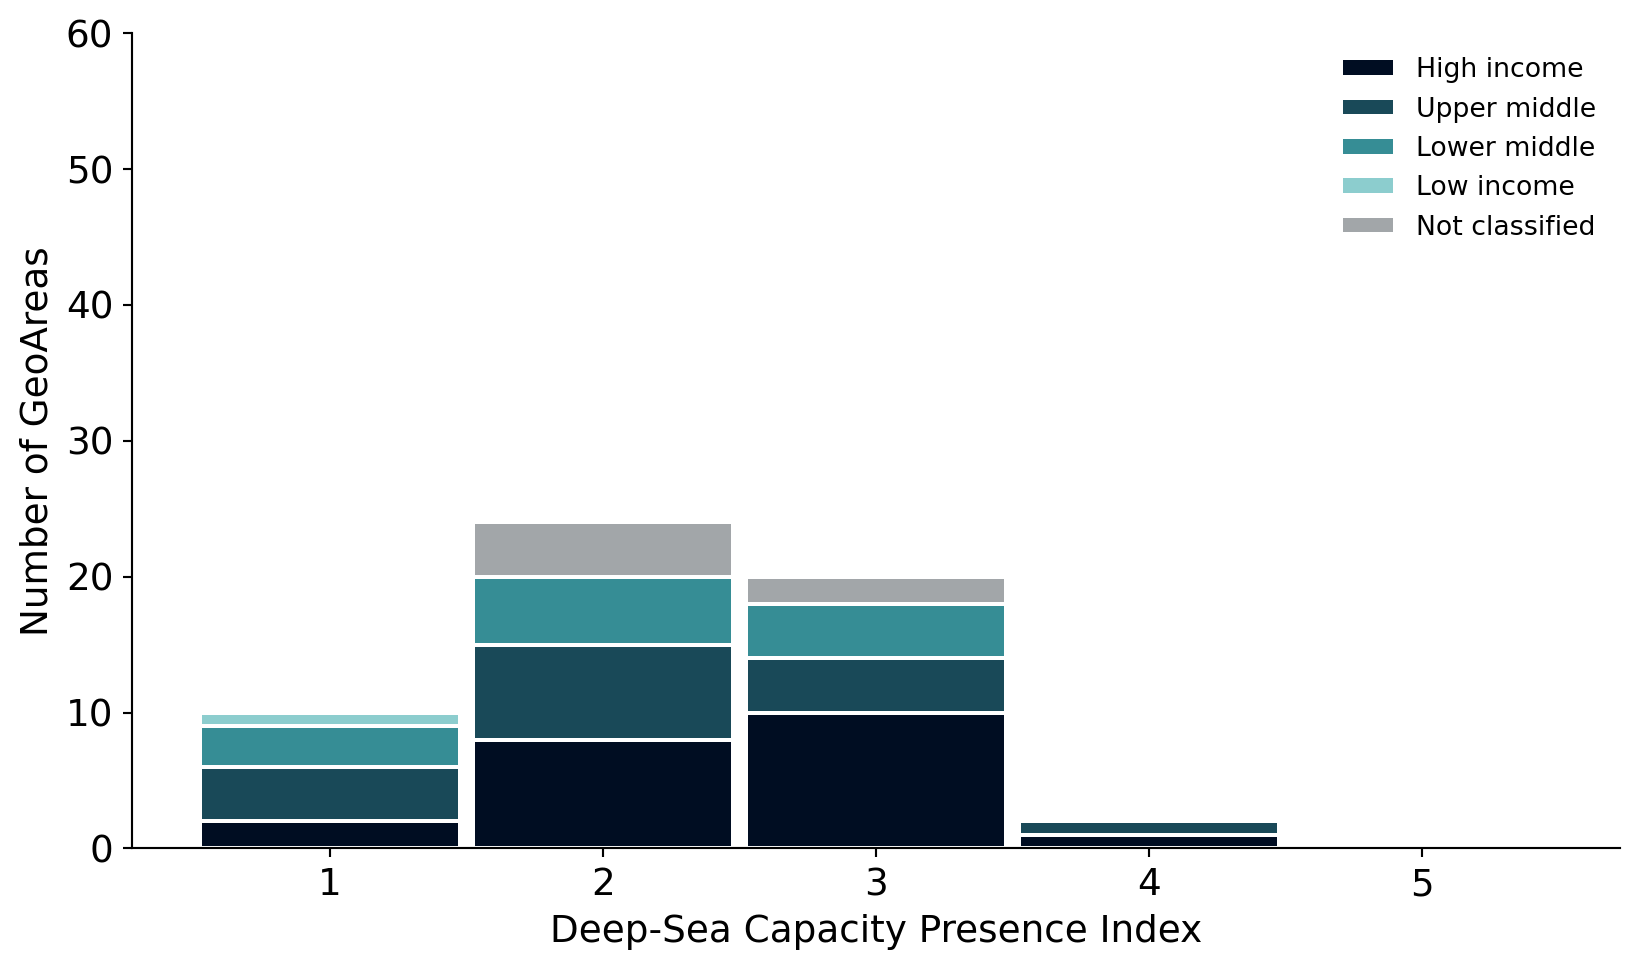

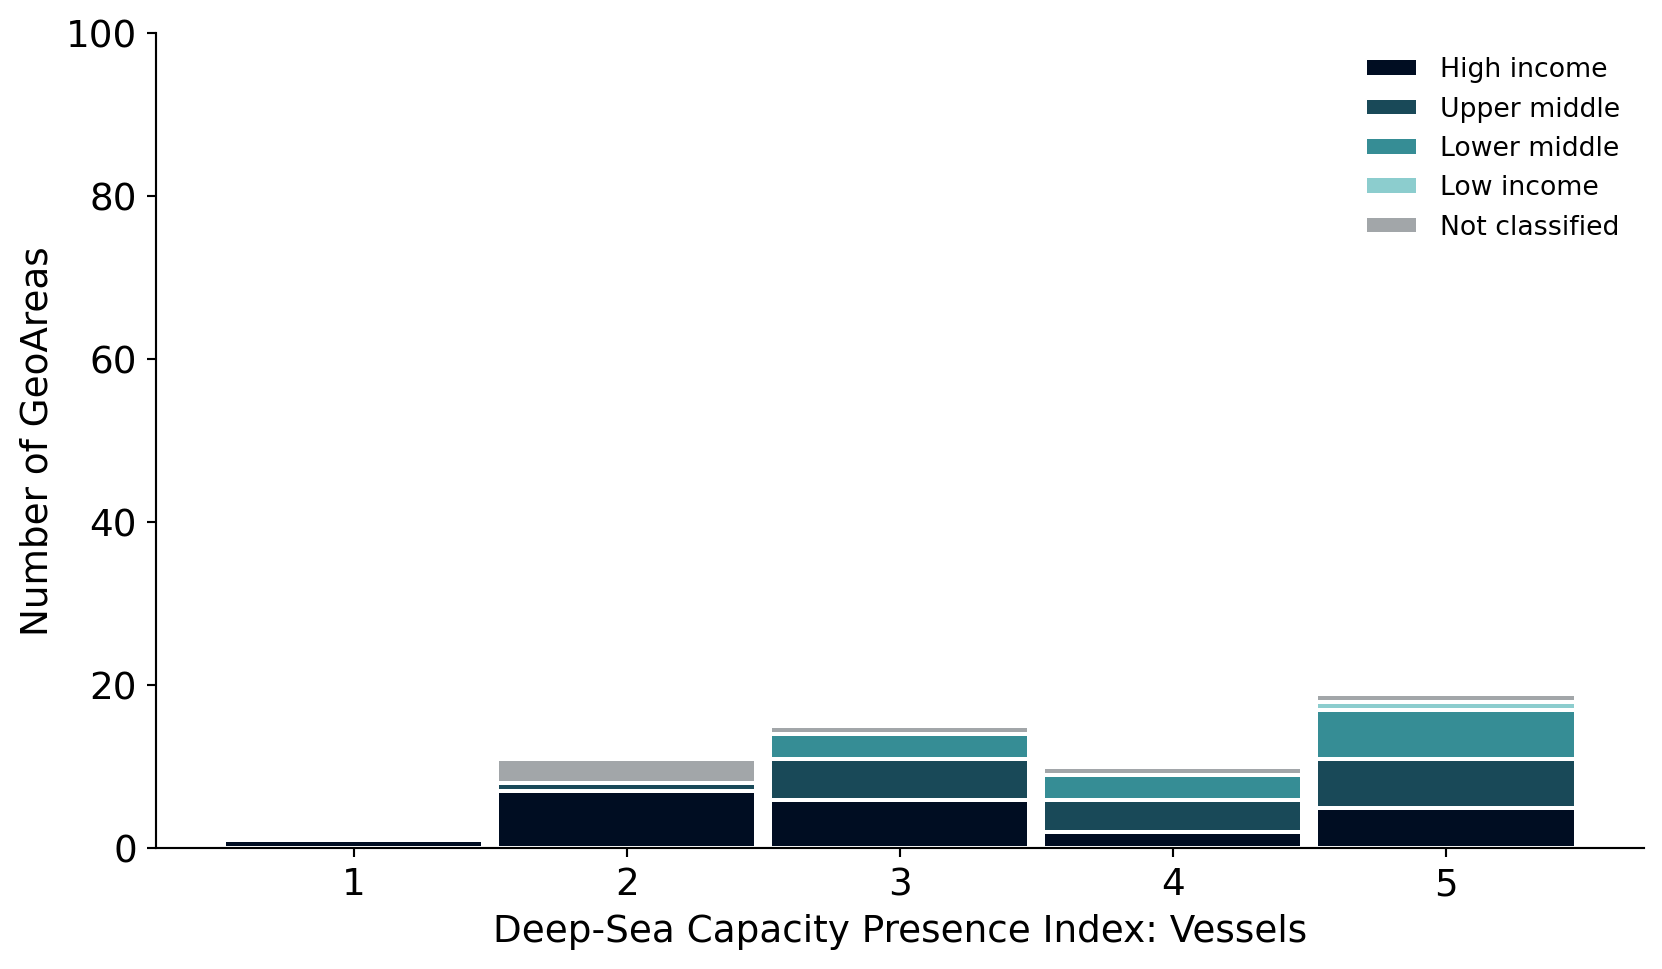

adding empty row for 5


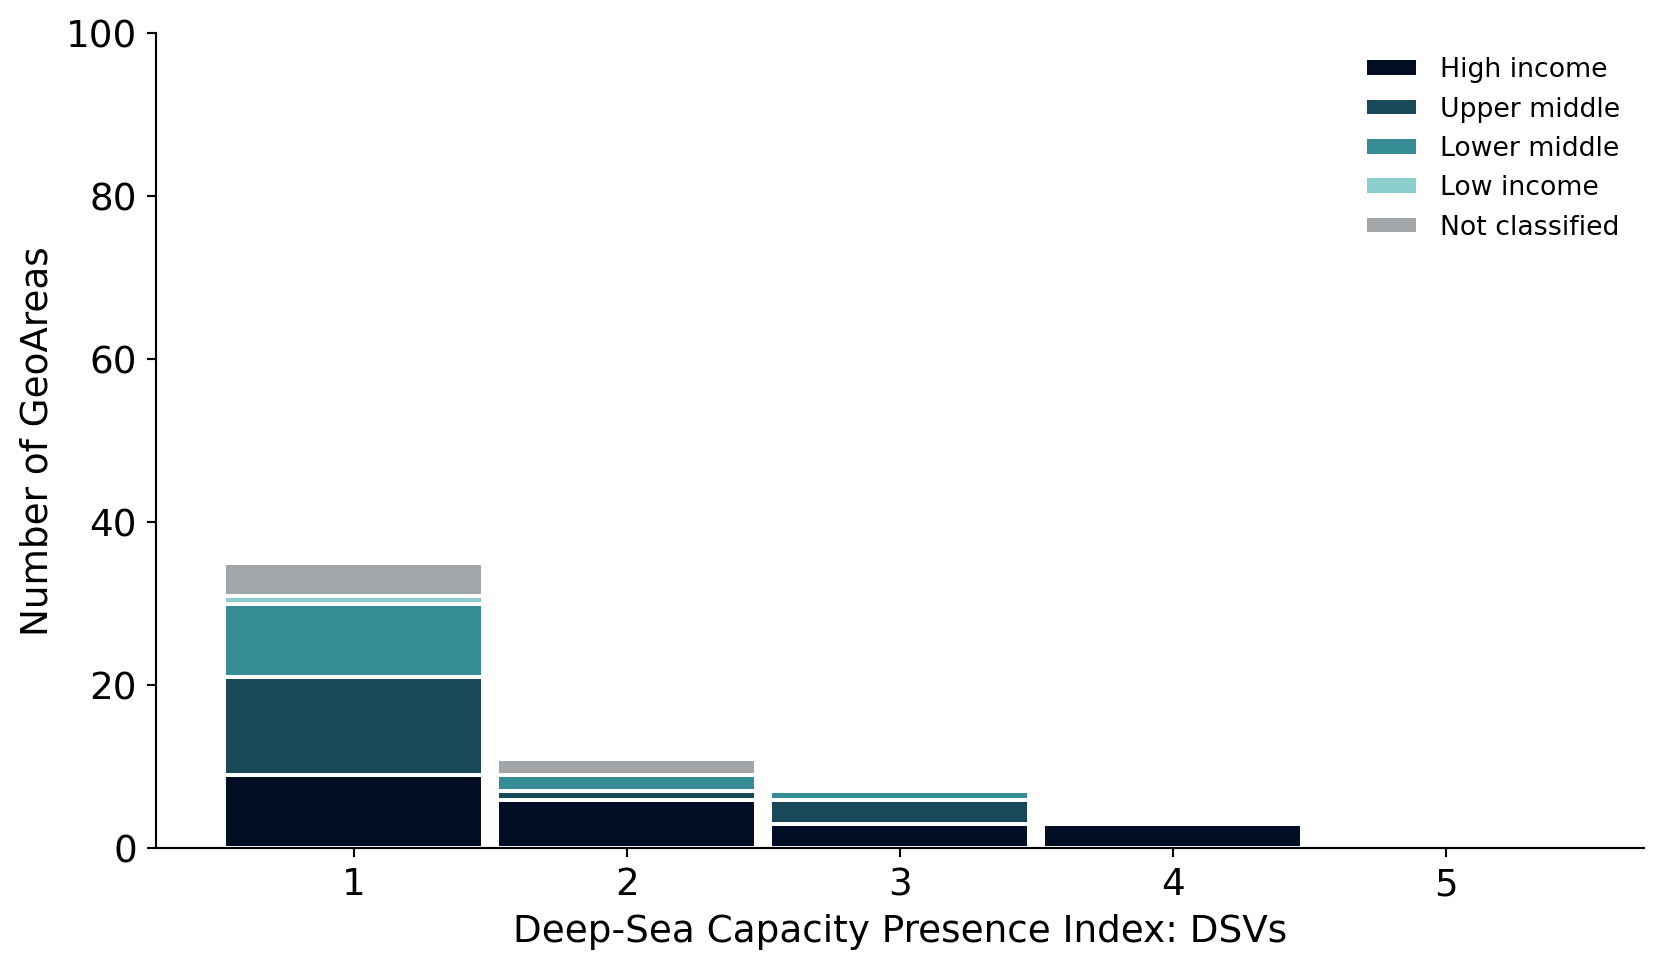

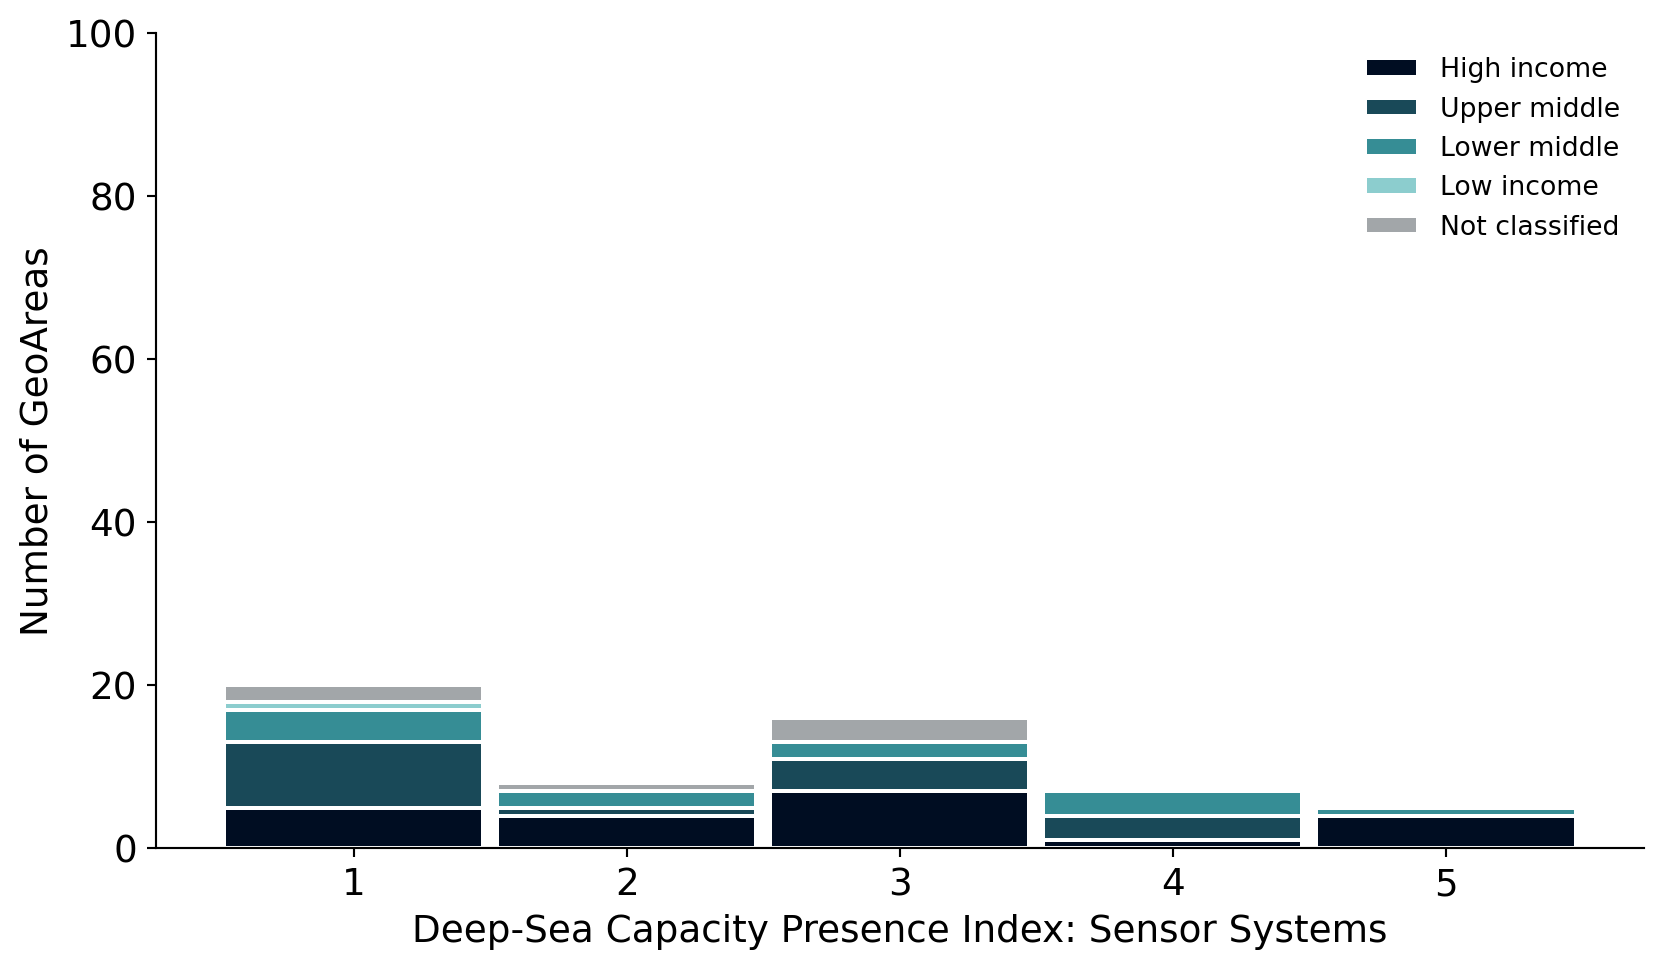

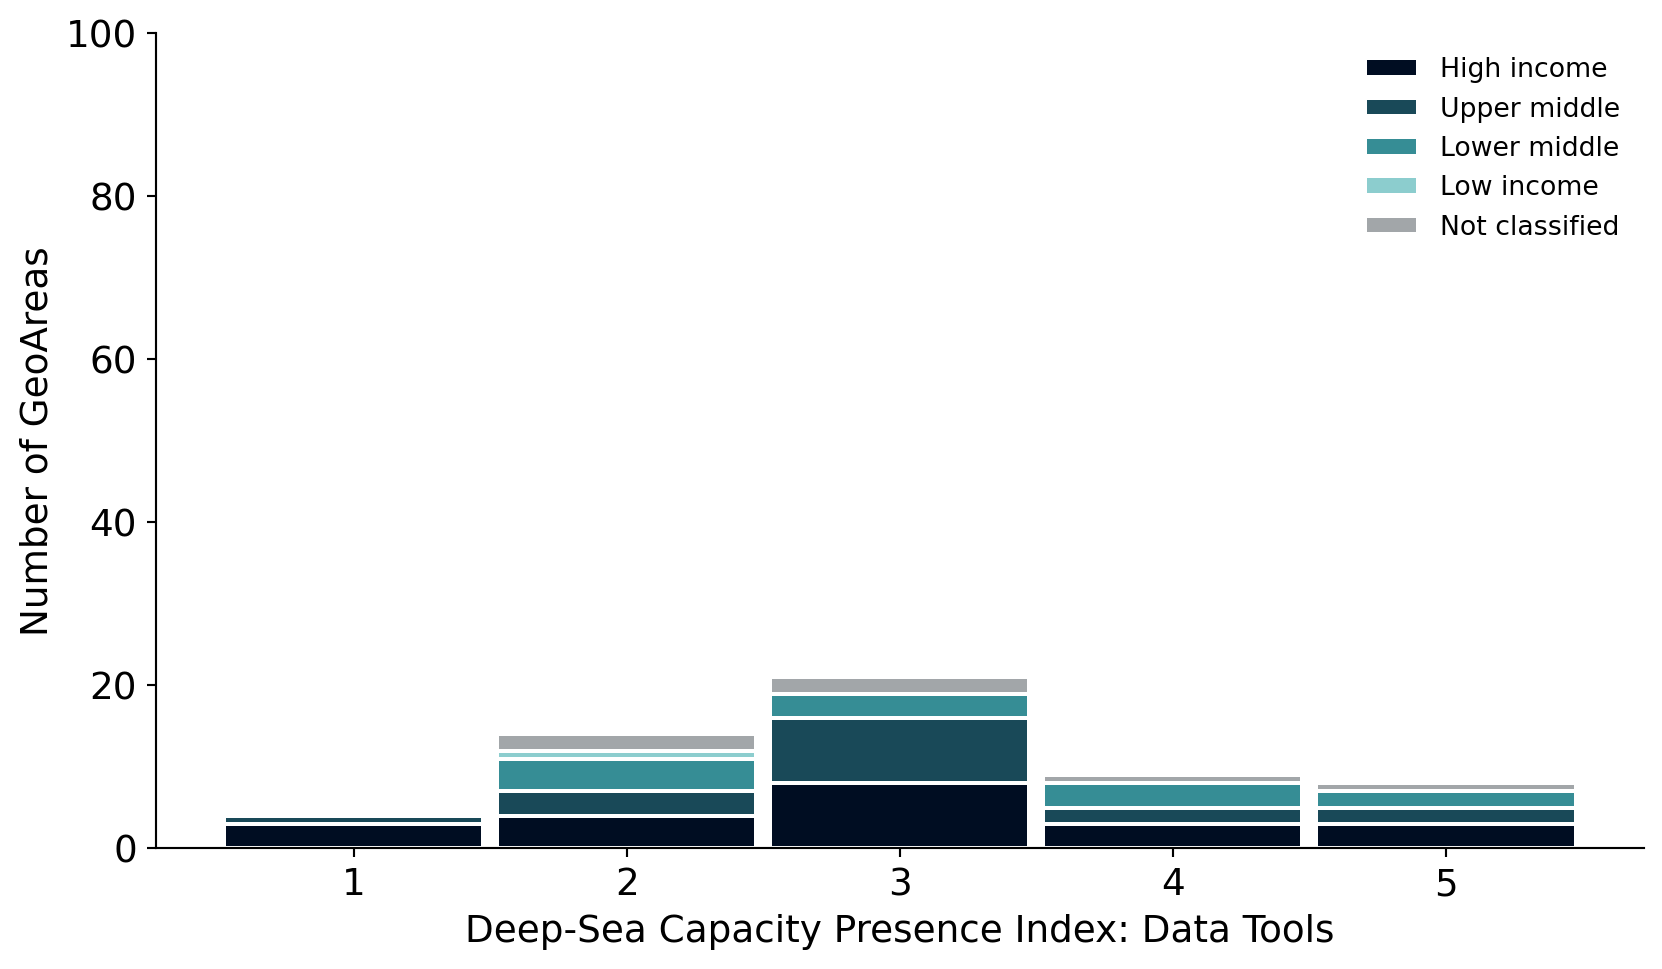

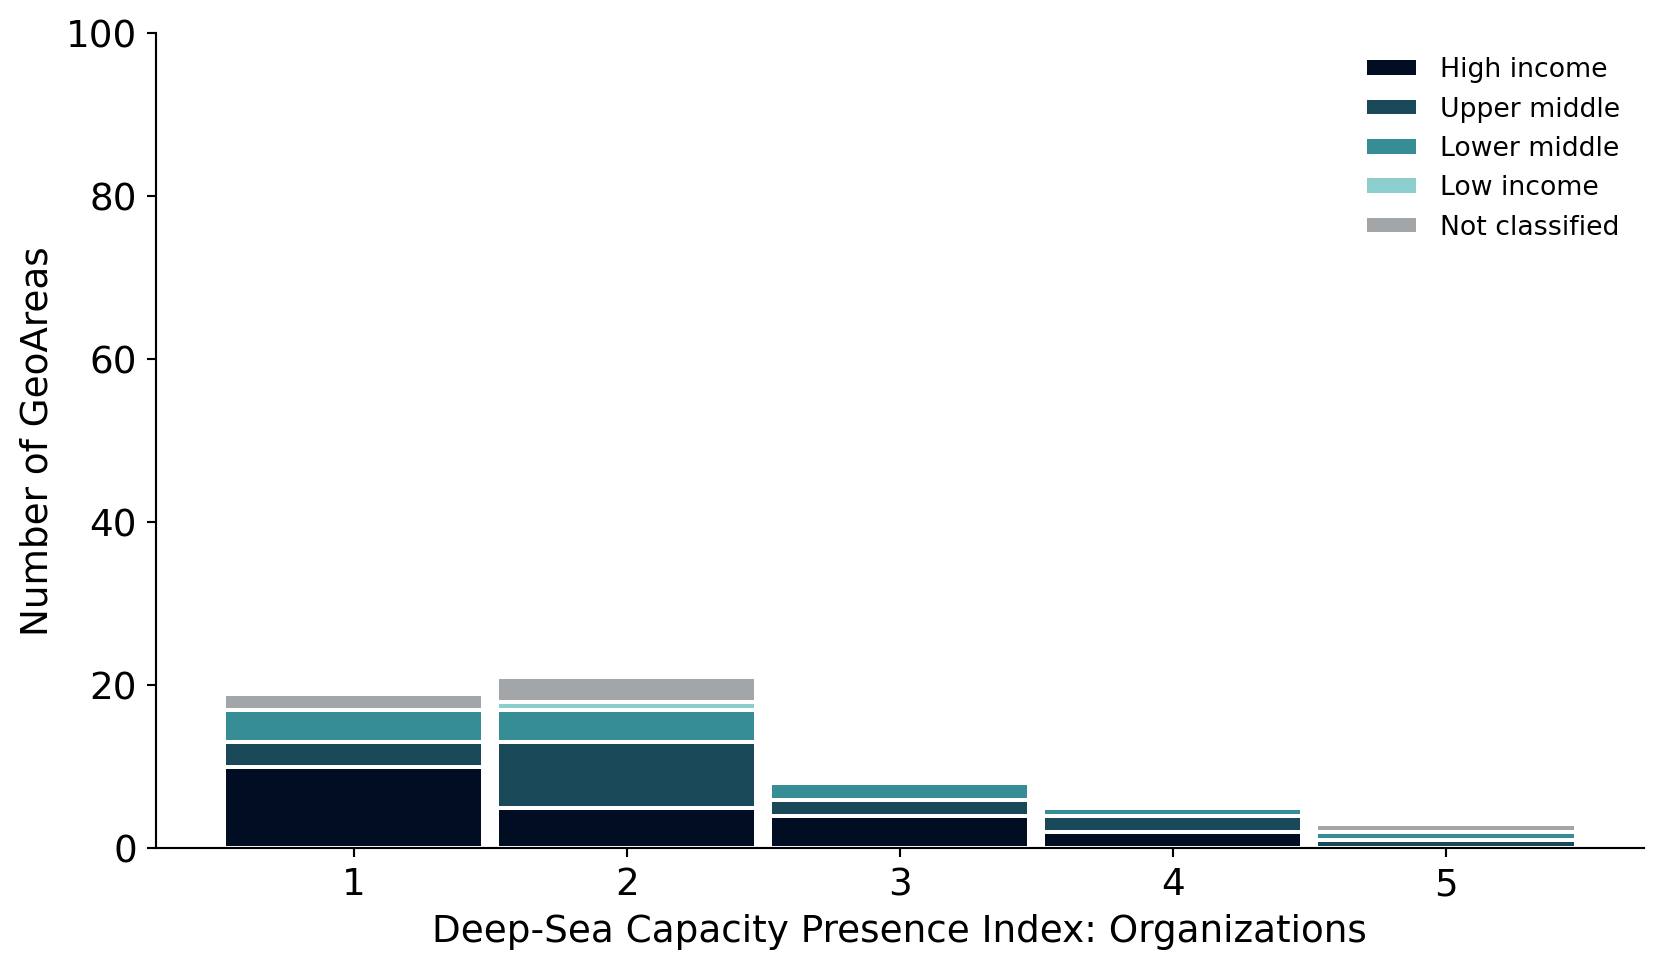

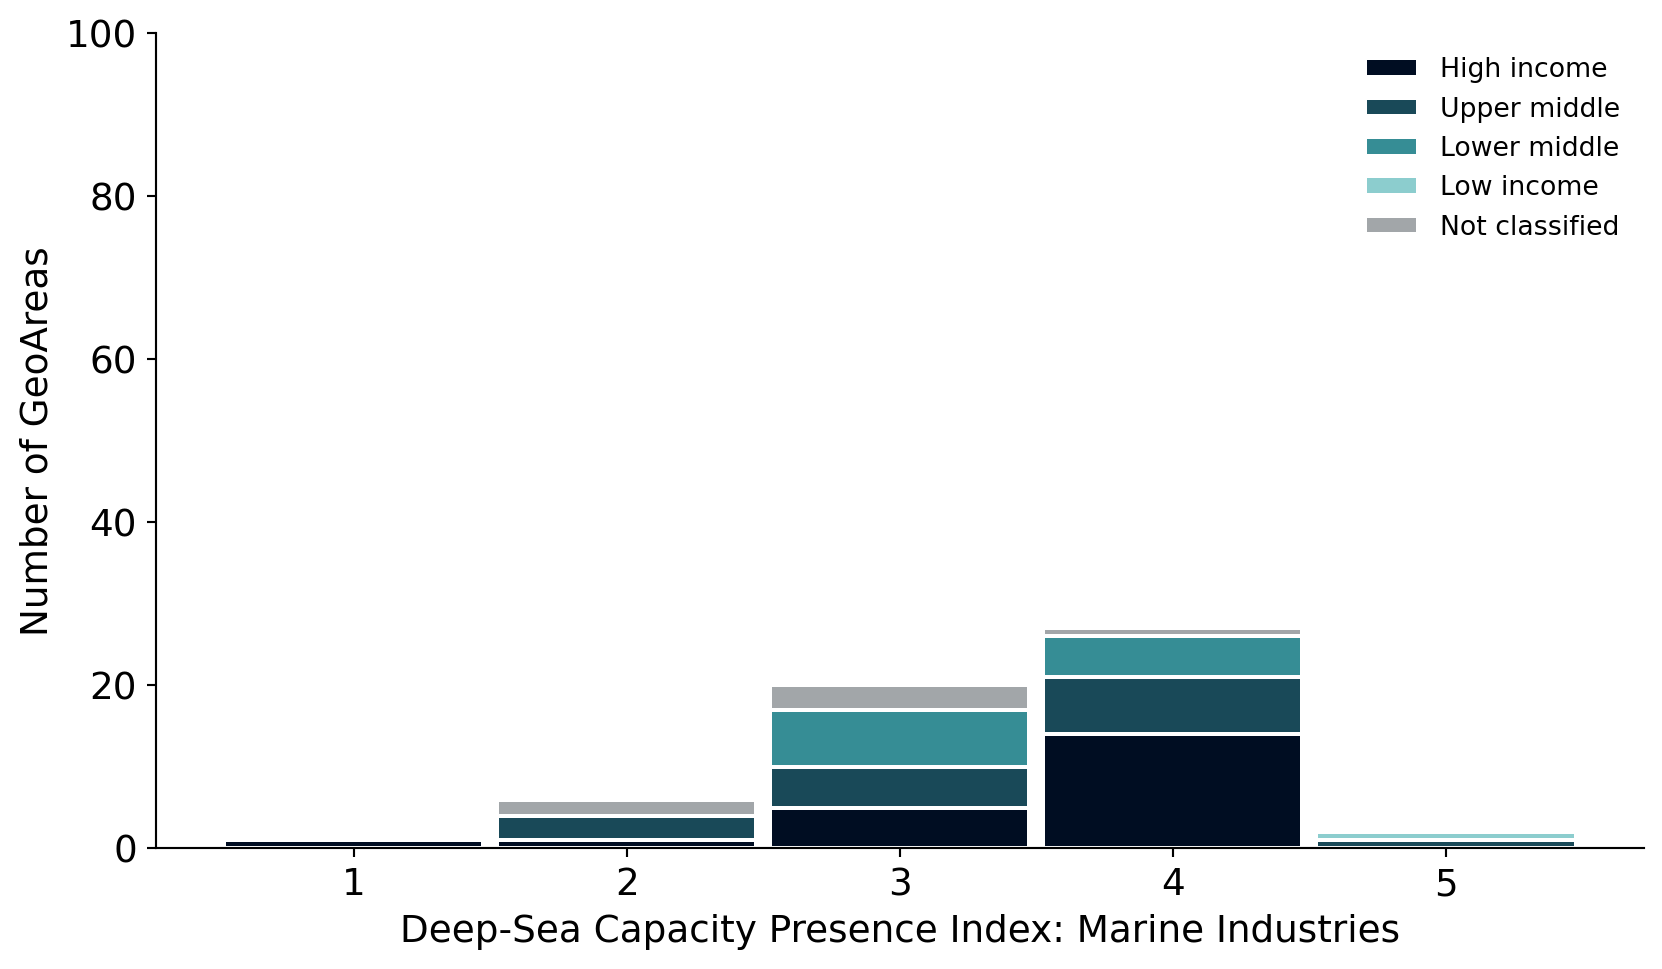

In [69]:
## Calculate fig data

dsc_types = {
    'dsc-pi-all':
        { 'x-label': 'Deep-Sea Capacity Presence Index',
          'y-label': 'Number of GeoAreas',
          'y-limit-override': 60,
          'fig-letter': 'AC1',
        },
    'dsc-pi-vessel':
        { 'x-label': 'Deep-Sea Capacity Presence Index: Vessels',
          'y-label': 'Number of GeoAreas',
          'fig-letter': 'AC2'
        },
    'dsc-pi-dsv':
        { 'x-label': 'Deep-Sea Capacity Presence Index: DSVs',
          'y-label': 'Number of GeoAreas',
          'fig-letter': 'AC3'
        },
    'dsc-pi-sensor':
        { 'x-label': 'Deep-Sea Capacity Presence Index: Sensor Systems',
          'y-label': 'Number of GeoAreas',
          'fig-letter': 'AC4'
        },
    'dsc-pi-data':
        { 'x-label': 'Deep-Sea Capacity Presence Index: Data Tools',
          'y-label': 'Number of GeoAreas',
          'fig-letter': 'AC5'
        },
    'dsc-pi-org':
        { 'x-label': 'Deep-Sea Capacity Presence Index: Organizations',
          'y-label': 'Number of GeoAreas',
          'fig-letter': 'AC6'
        },
    'dsc-pi-ind':
        { 'x-label': 'Deep-Sea Capacity Presence Index: Marine Industries',
          'y-label': 'Number of GeoAreas',
          'fig-letter': 'AC7'
        }
}

for dsc_type, labels in dsc_types.items():
    fig_data = {}
    for region in region_list:
        fig_data[region] = (country_tableR[region]
                    .groupby([dsc_type, 'subregion'])[dsc_type]
                    .count()
                    .rename('count')
                    .reset_index())
        fig_data[region][dsc_type] = fig_data[region][dsc_type].astype(int)
        fig_data[region] = fig_data[region].pivot(index=dsc_type, columns=['subregion'], values='count')
        for n in range(1,6):
            if n not in fig_data[region].index:
                print('adding empty row for', n)
                fig_data[region].loc[n] = 0
        fig_data[region] = fig_data[region].sort_index()
        fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis=1)
        #display(fig_data[region])

    ## Plot figure

    w = 1920
    h = 1080
    
    for region in region_list:
        fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)

        fig_data[region].plot(kind='bar', 
                      stacked=True,
                      rot=0,
                      fontsize=14,
                      width=0.95,
                      color=cat_d23e123_by_region[region],
                      edgecolor='white',
                      linewidth=1.5,
                      ax=ax)
        ax.set_xlabel(labels['x-label'], fontsize=14)
        ax.set_ylabel(labels['y-label'], fontsize=14)
        plt.locator_params(axis='y', integer=True)
        ylim_max = 100
        if 'y-limit-override' in labels:
            ylim_max = labels['y-limit-override']
        ax.set_ylim([0, ylim_max])

        ax.legend(fontsize=10,
                  title_fontsize=10)

        outputfigs(plt, fig, ax, region, section='5', letter=labels['fig-letter'])

## **Figs AC1b-AC7b**

In [70]:
## Calculate fig data

dsc_types = {
    'dsc-pi-all':
        { 'x-label': 'Deep-Sea Capacity Presence Index',
          'y-label': 'Number of GeoAreas',
          'y-limit-override': 60,
          'fig-letter': 'AC1b'
        },
    'dsc-pi-vessel':
        { 'x-label': 'Deep-Sea Capacity Presence Index: Vessels',
          'y-label': 'Number of GeoAreas',
          'fig-letter': 'AC2b'
        },
    'dsc-pi-dsv':
        { 'x-label': 'Deep-Sea Capacity Presence Index: DSVs',
          'y-label': 'Number of GeoAreas',
          'fig-letter': 'AC3b'
        },
    'dsc-pi-sensor':
        { 'x-label': 'Deep-Sea Capacity Presence Index: Sensor Systems',
          'y-label': 'Number of GeoAreas',
          'fig-letter': 'AC4b'
        },
    'dsc-pi-data':
        { 'x-label': 'Deep-Sea Capacity Presence Index: Data Tools',
          'y-label': 'Number of GeoAreas',
          'fig-letter': 'AC5b'
        },
    'dsc-pi-org':
        { 'x-label': 'Deep-Sea Capacity Presence Index: Organizations',
          'y-label': 'Number of GeoAreas',
          'fig-letter': 'AC6b'
        },
    'dsc-pi-ind':
        { 'x-label': 'Deep-Sea Capacity Presence Index: Marine Industries',
          'y-label': 'Number of GeoAreas',
          'fig-letter': 'AC7b'
        }
}

regions_to_skip = ['Global', 'Economies', 'SIDS']

for dsc_type, labels in dsc_types.items():
    fig_data = {}
    for region in region_list:
        if region in regions_to_skip:
            print('Skipping region', region);
            continue

        for r in ['Global', region]:
            fig_data[r] = (country_tableR[r]
                        .groupby([dsc_type, 'subregion'])[dsc_type]
                        .count()
                        .rename('count')
                        .reset_index())
            fig_data[r][dsc_type] = fig_data[r][dsc_type].astype(int)
            fig_data[r] = fig_data[r].pivot(index=dsc_type, columns=['subregion'], values='count')
            for n in range(1,6):
                if n not in fig_data[r].index:
                    print('adding empty row for', n)
                    fig_data[r].loc[n] = 0
            fig_data[r] = fig_data[r].sort_index()
            fig_data[r] = prep_fig_data_for_plotting(fig_data[r], r, axis=1)

        #display(fig_data[region])

        if region == 'Americas':
            colnum = fig_data['Global'].columns.get_loc('N America')
            fig_data['Global'] = fig_data['Global'].rename(columns={'N America': 'Old N America'})
            i=0
            for columnname, column in fig_data[region].iteritems():
                fig_data['Global'].insert(colnum+i, columnname, column)
                i+=1
            fig_data['Global'] = fig_data['Global'].drop(columns=['Old N America', 'L Amer & Carib'])
        else:
            colnum = fig_data['Global'].columns.get_loc(region)
            i=0
            for columnname, column in fig_data[region].iteritems():
                fig_data['Global'].insert(colnum+i, columnname, column)
                i+=1
            fig_data['Global'] = fig_data['Global'].drop(columns=region)
        fig_data[region] = fig_data['Global']

        #display(fig_data['Global'])

    ## Plot figures

    w = 1920
    h = 1080
    
    for region in region_list:
        if region in regions_to_skip:
            continue

        fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
        fig_data[region].plot(kind='bar',
                      stacked=True,
                      rot=0,
                      fontsize=14,
                      width=0.95,
                      edgecolor='white',
                      linewidth=1,
                      ax=ax)
        ax.set_xlabel(labels['x-label'], fontsize=14)
        ax.set_ylabel(labels['y-label'], fontsize=14)
        plt.locator_params(axis='y', integer=True)
        ylim_max = 100
        if 'y-limit-override' in labels:
            ylim_max = labels['y-limit-override']
        ax.set_ylim([0, ylim_max])

        colors = []
        edgecolors = []
        for (columnname, data) in fig_data[region].iteritems():
            for datum in data:
                orig_columnname = undo_label_adjustment(columnname)
                if orig_columnname in orderR[region]:
                    colors.append(cat_d23e123_by_region[region][orderR[region].index(orig_columnname)])
                    edgecolors.append('black')
                else:
                    colors.append('#d4d4d4')
                    edgecolors.append('white')
        for p,color in zip(ax.patches,colors):
            p.set_facecolor(color)
        for p,edgecolor in zip(ax.patches,edgecolors):
            p.set_edgecolor(edgecolor)
            if edgecolor != 'white':
                p.set_zorder(10)

        prunedhandles = []
        prunedlabels = []
        currenthandles, currentlabels = ax.get_legend_handles_labels()   #get the handles
        for handle, label in zip(currenthandles, currentlabels):
            if undo_label_adjustment(label) in orderR[region]:
                prunedhandles.append(handle)
                prunedlabels.append(label)
        patch = matplotlib.patches.Patch(facecolor='#d4d4d4', edgecolor='white')
        prunedhandles.append(patch)
        prunedlabels.append('All other regions')

        ax.legend(prunedhandles,
                  prunedlabels,
                  fontsize=10,
                  title_fontsize=10)

        outputfigs(plt, fig, ax, region, section='5', letter=labels['fig-letter'])

Skipping region SIDS
Skipping region SIDS
Skipping region SIDS
Skipping region SIDS
Skipping region SIDS
Skipping region SIDS
Skipping region SIDS


## **Figs AD1-AD5 AE1-5**&nbsp; DSC Accessibility/Satisfaction Indexes

adding empty row for 4
adding empty row for 5
Adding missing column Low income
adding empty row for 4
adding empty row for 5
Adding missing column Low income


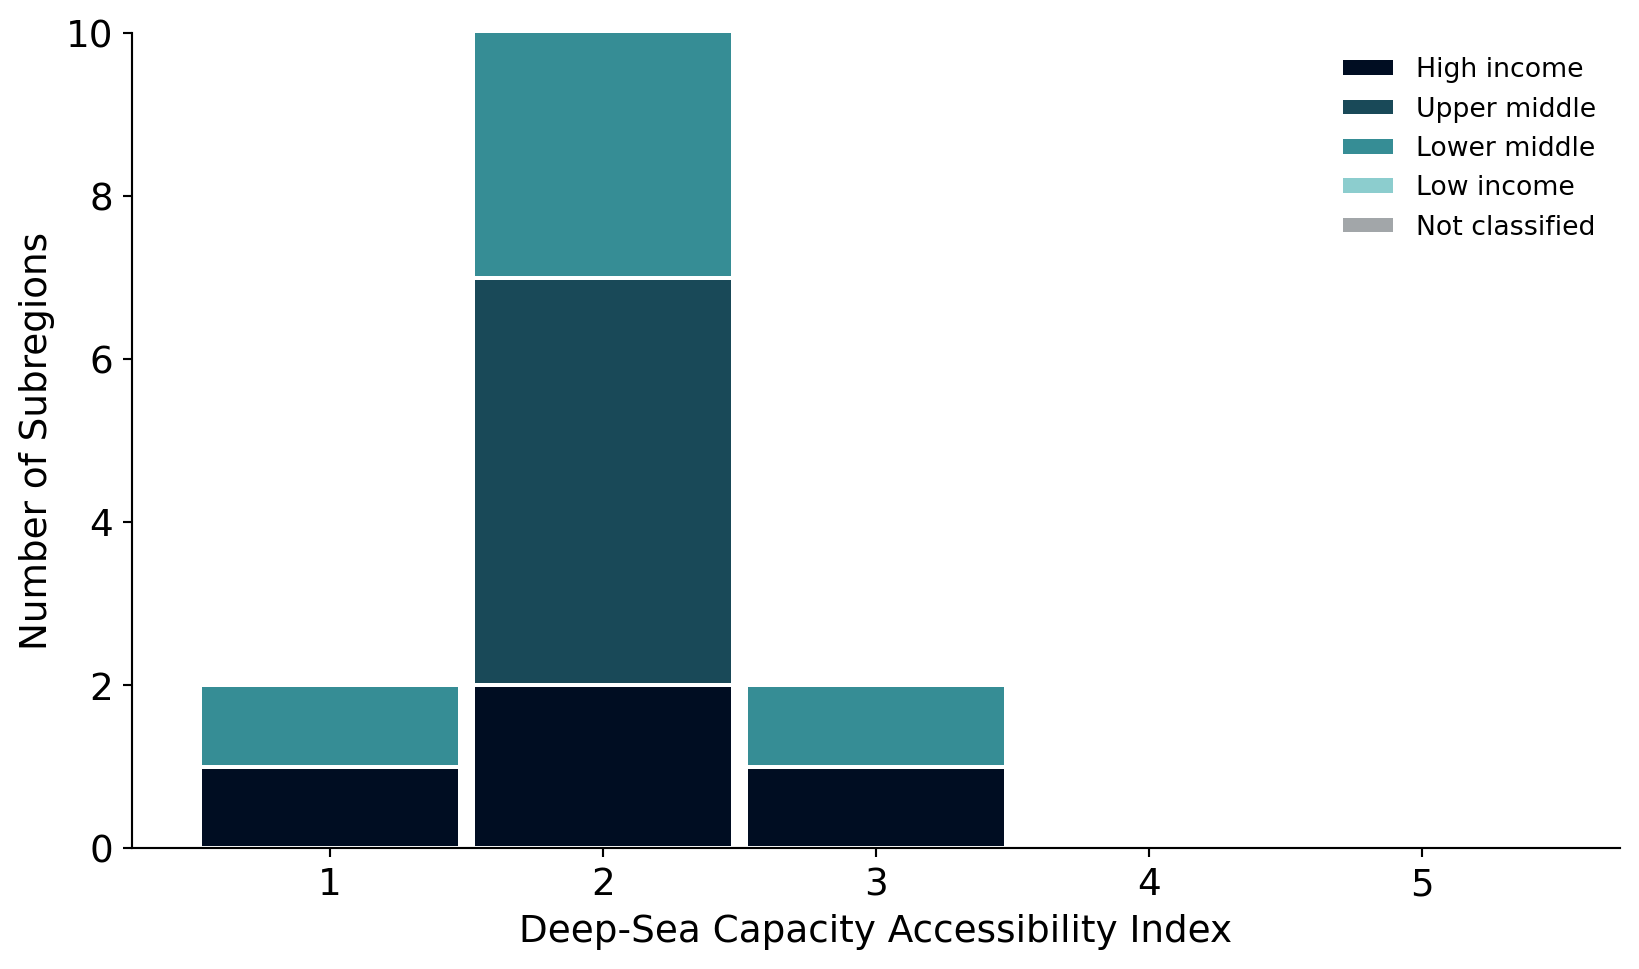

adding empty row for 3
adding empty row for 5
Adding missing column Low income
adding empty row for 3
adding empty row for 5
Adding missing column Low income


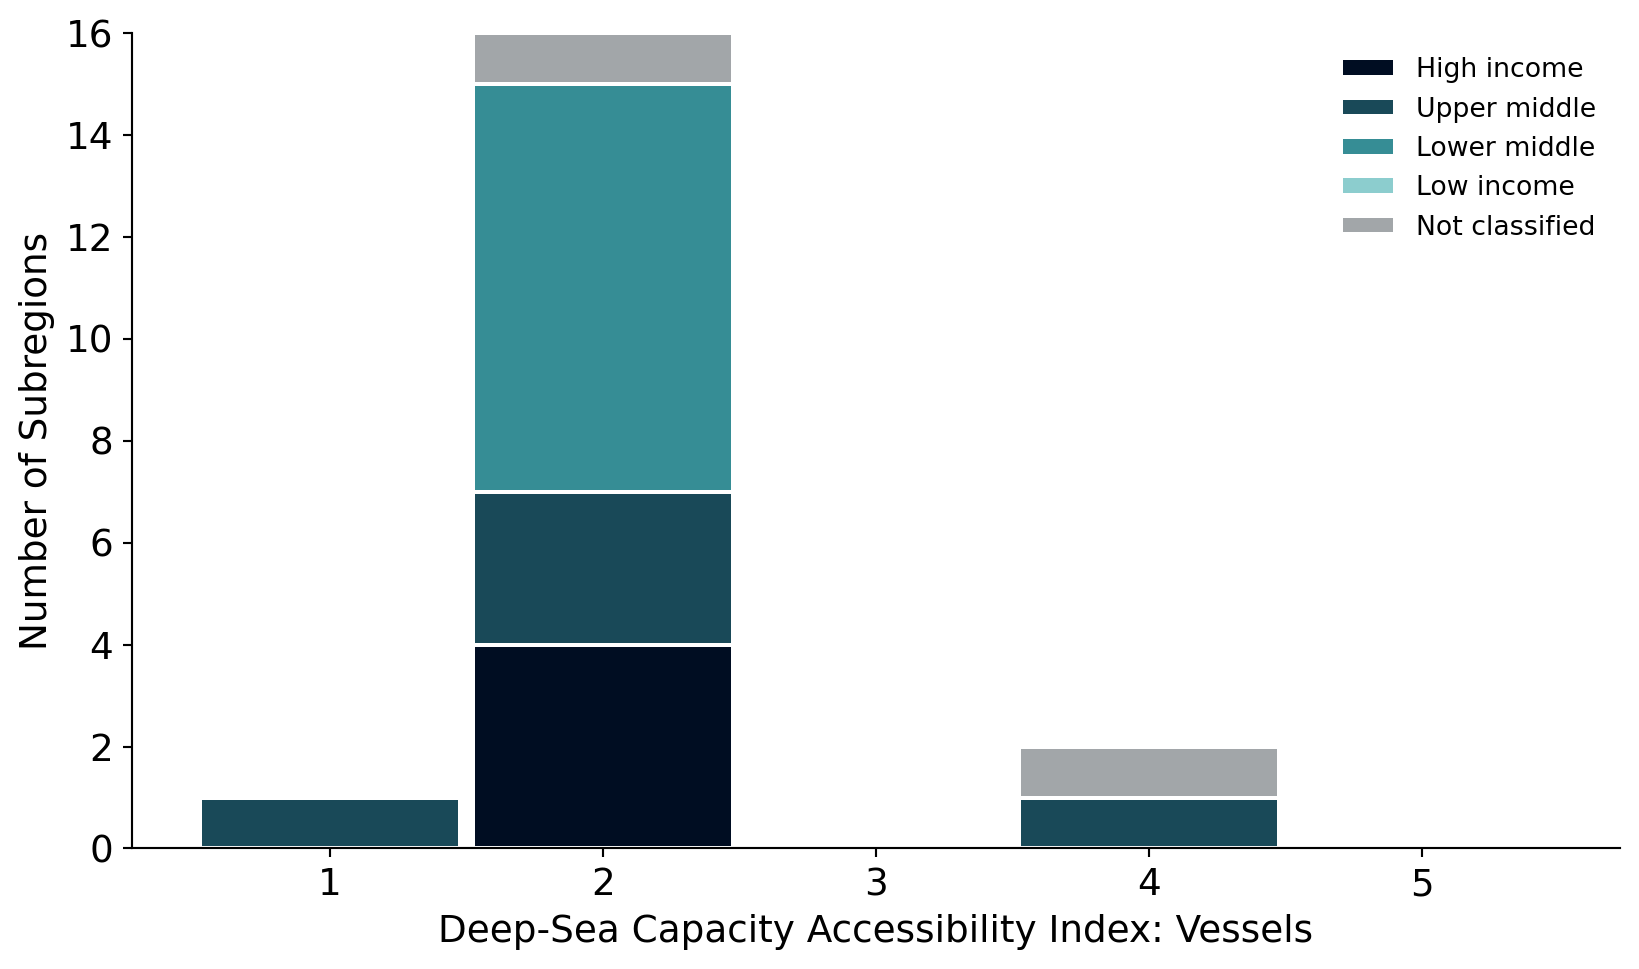

adding empty row for 2
adding empty row for 3
adding empty row for 4
adding empty row for 5
Adding missing column Low income
adding empty row for 2
adding empty row for 3
adding empty row for 4
adding empty row for 5
Adding missing column Low income


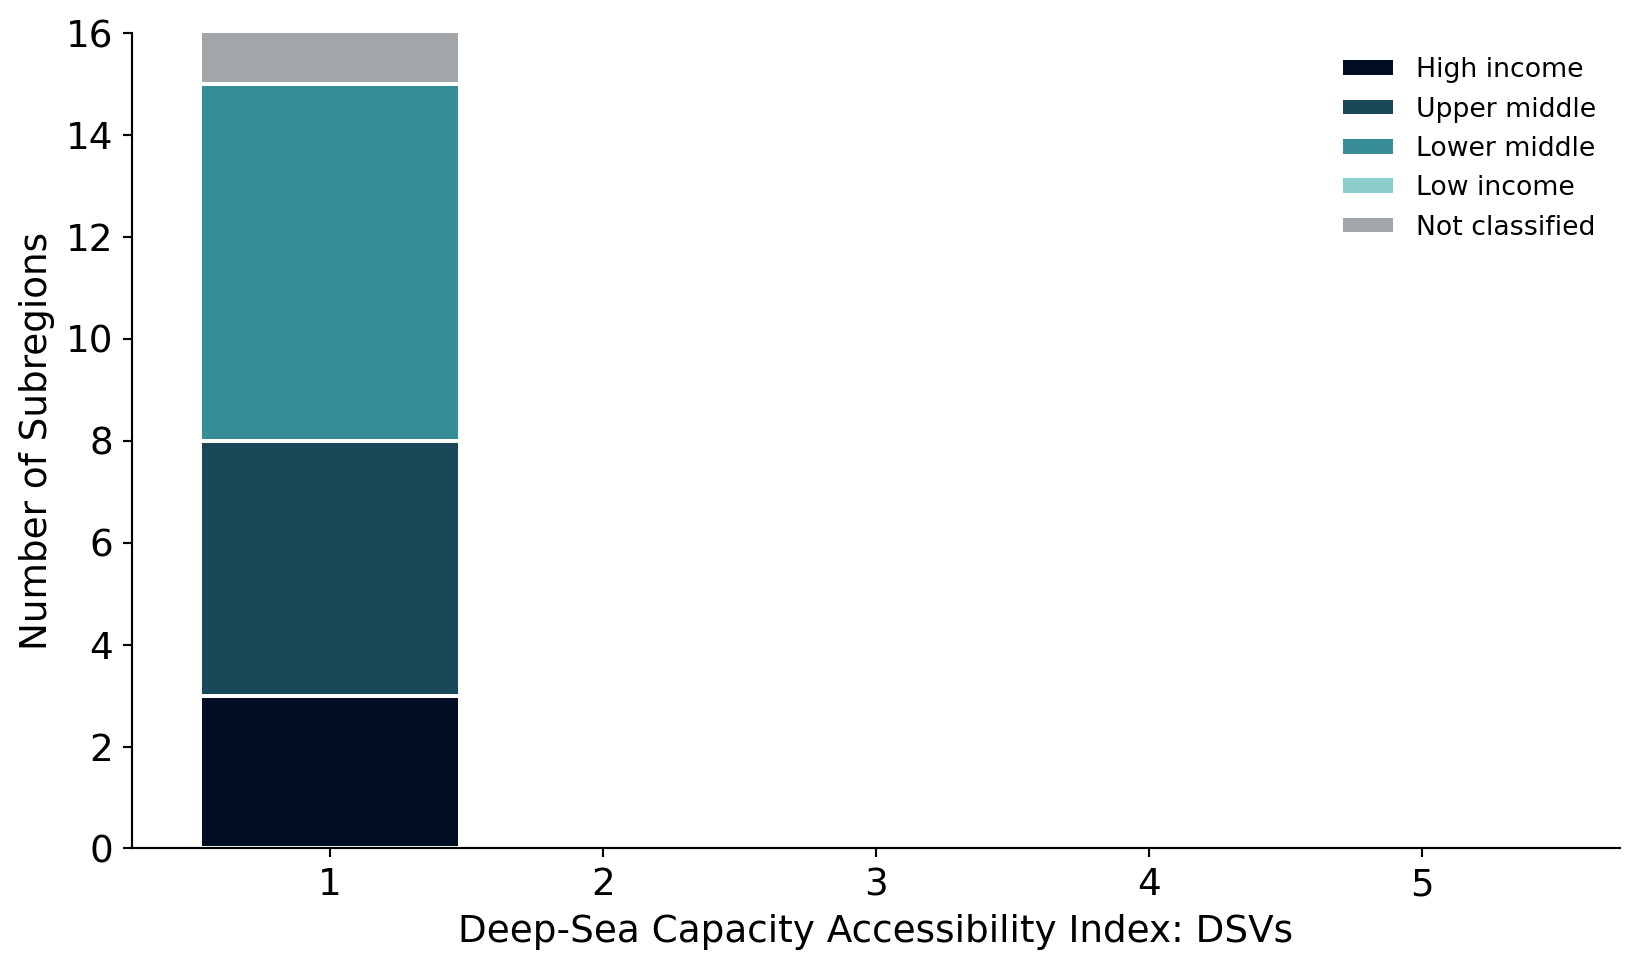

adding empty row for 4
adding empty row for 5
Adding missing column Low income
adding empty row for 4
adding empty row for 5
Adding missing column Low income


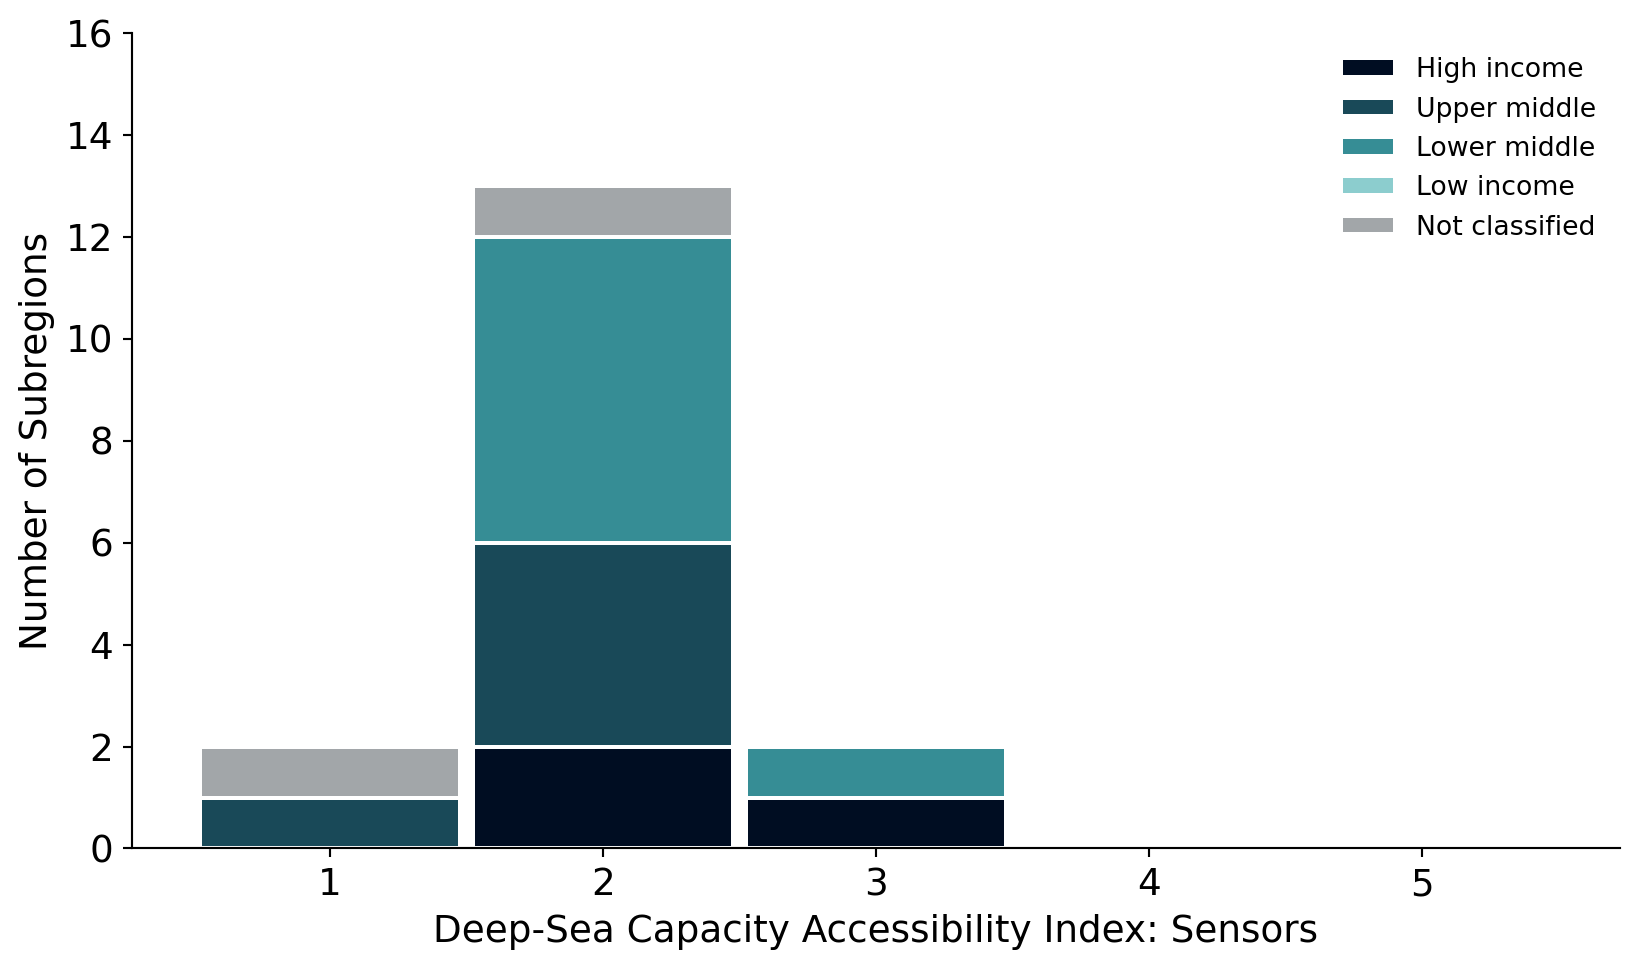

adding empty row for 1
adding empty row for 5
Adding missing column Low income
adding empty row for 1
adding empty row for 5
Adding missing column Low income


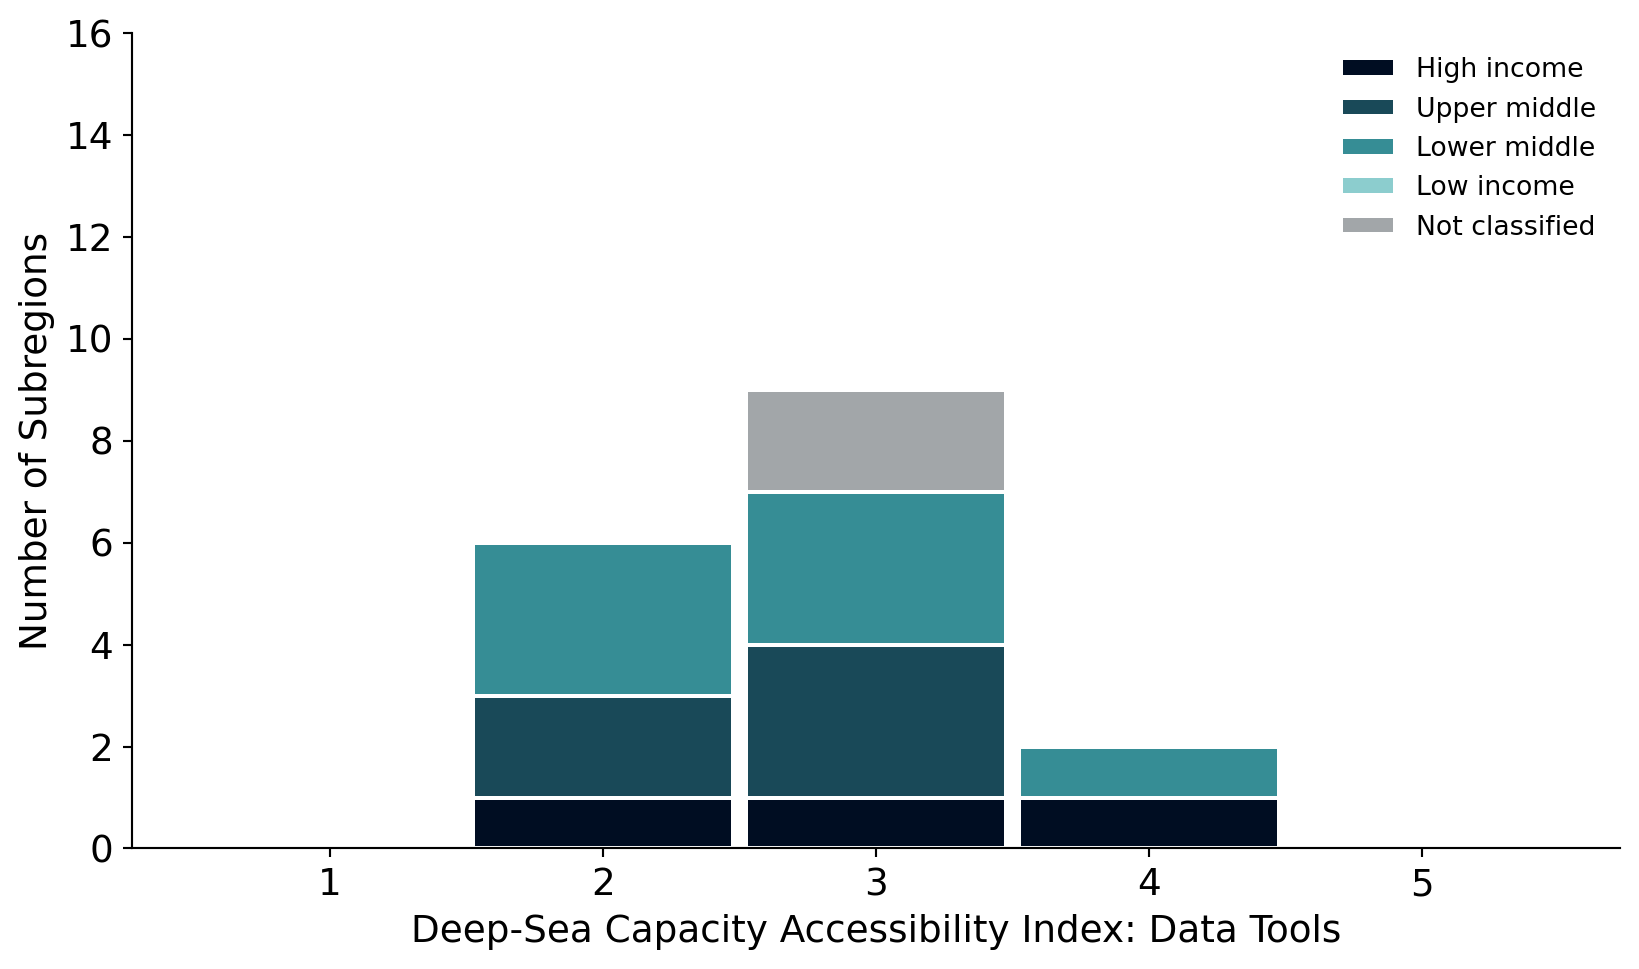

adding empty row for 4
adding empty row for 5
Adding missing column Low income
adding empty row for 4
adding empty row for 5
Adding missing column Low income


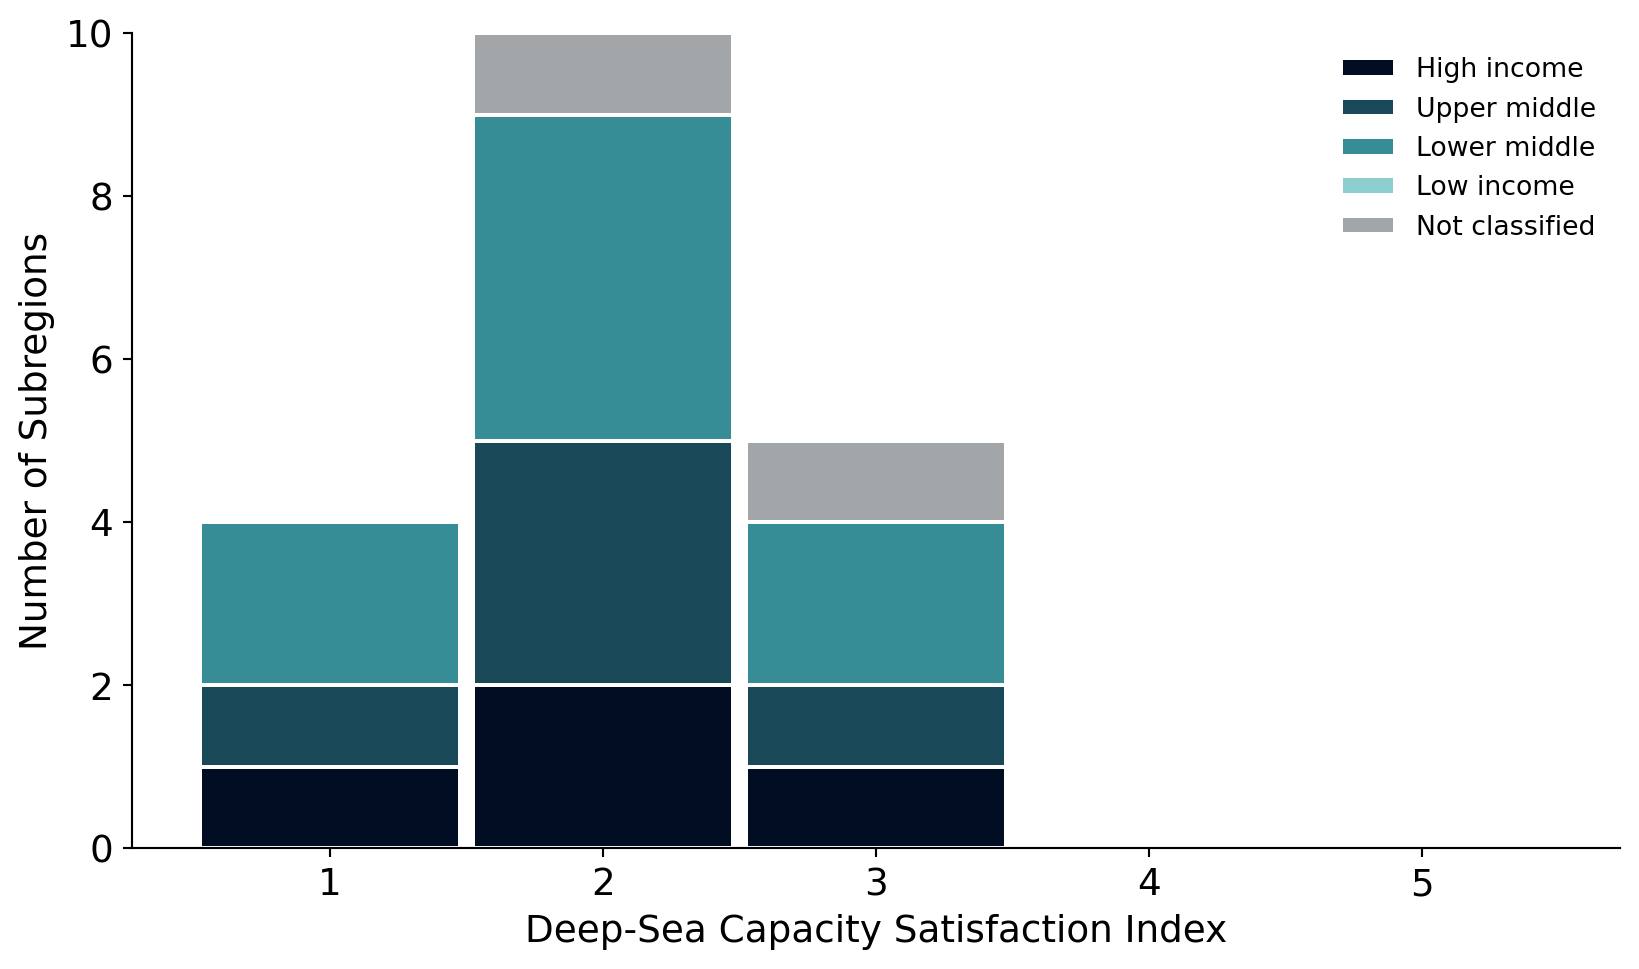

adding empty row for 4
adding empty row for 5
Adding missing column Low income
adding empty row for 4
adding empty row for 5
Adding missing column Low income


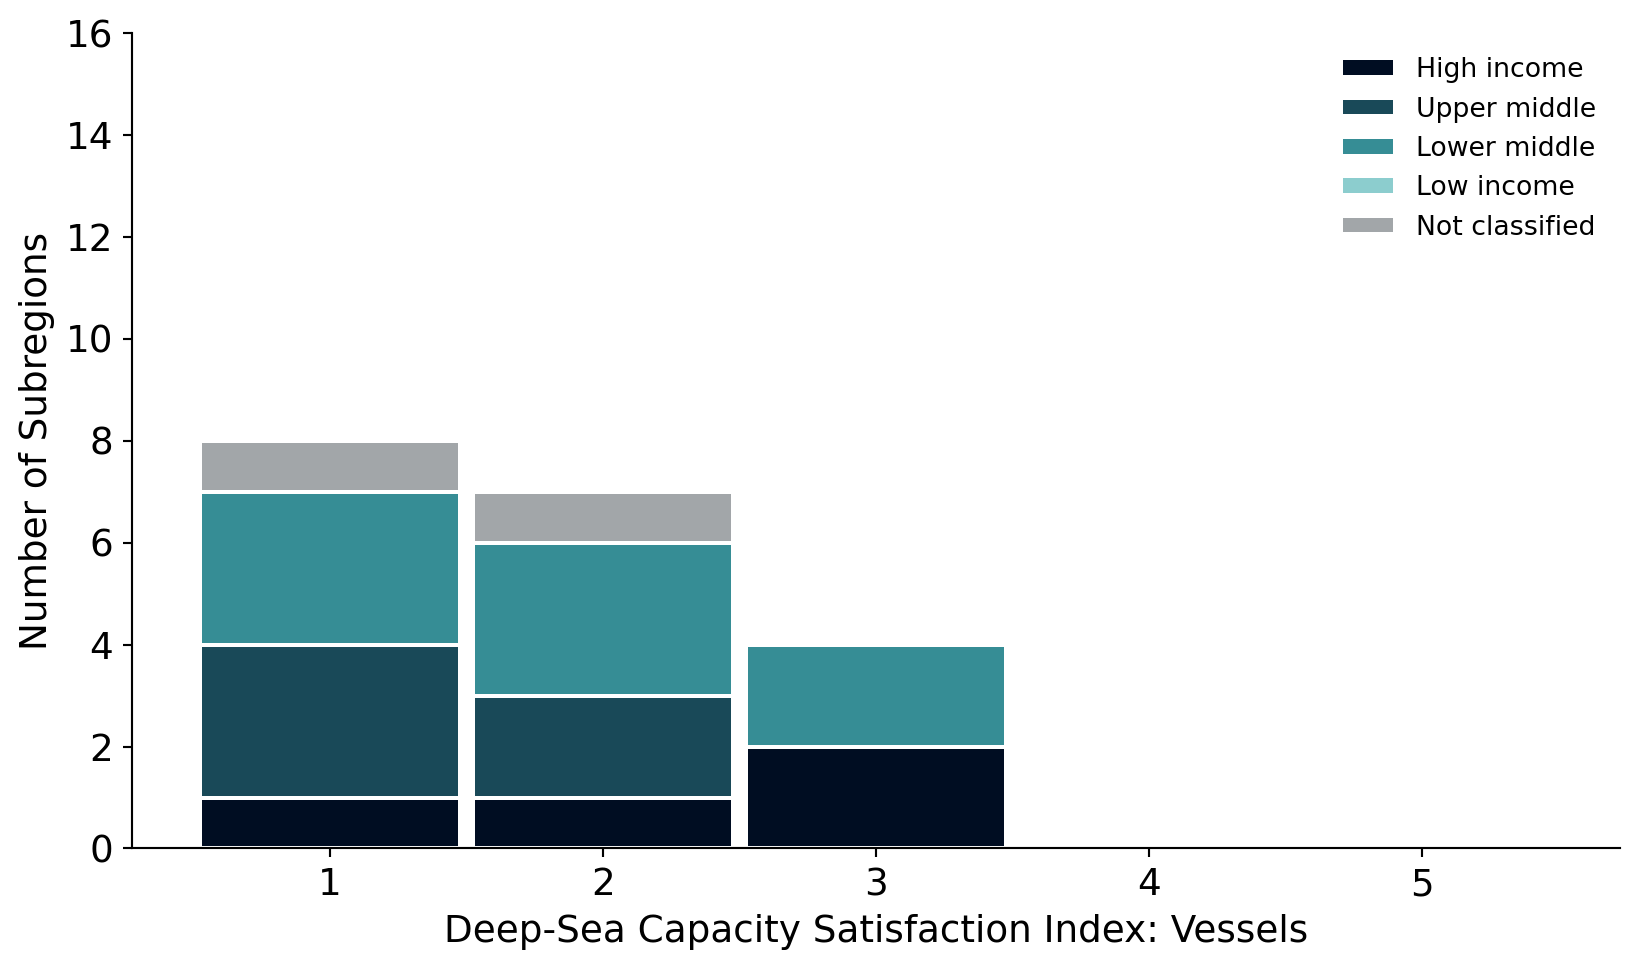

adding empty row for 4
adding empty row for 5
Adding missing column Low income
adding empty row for 4
adding empty row for 5
Adding missing column Low income


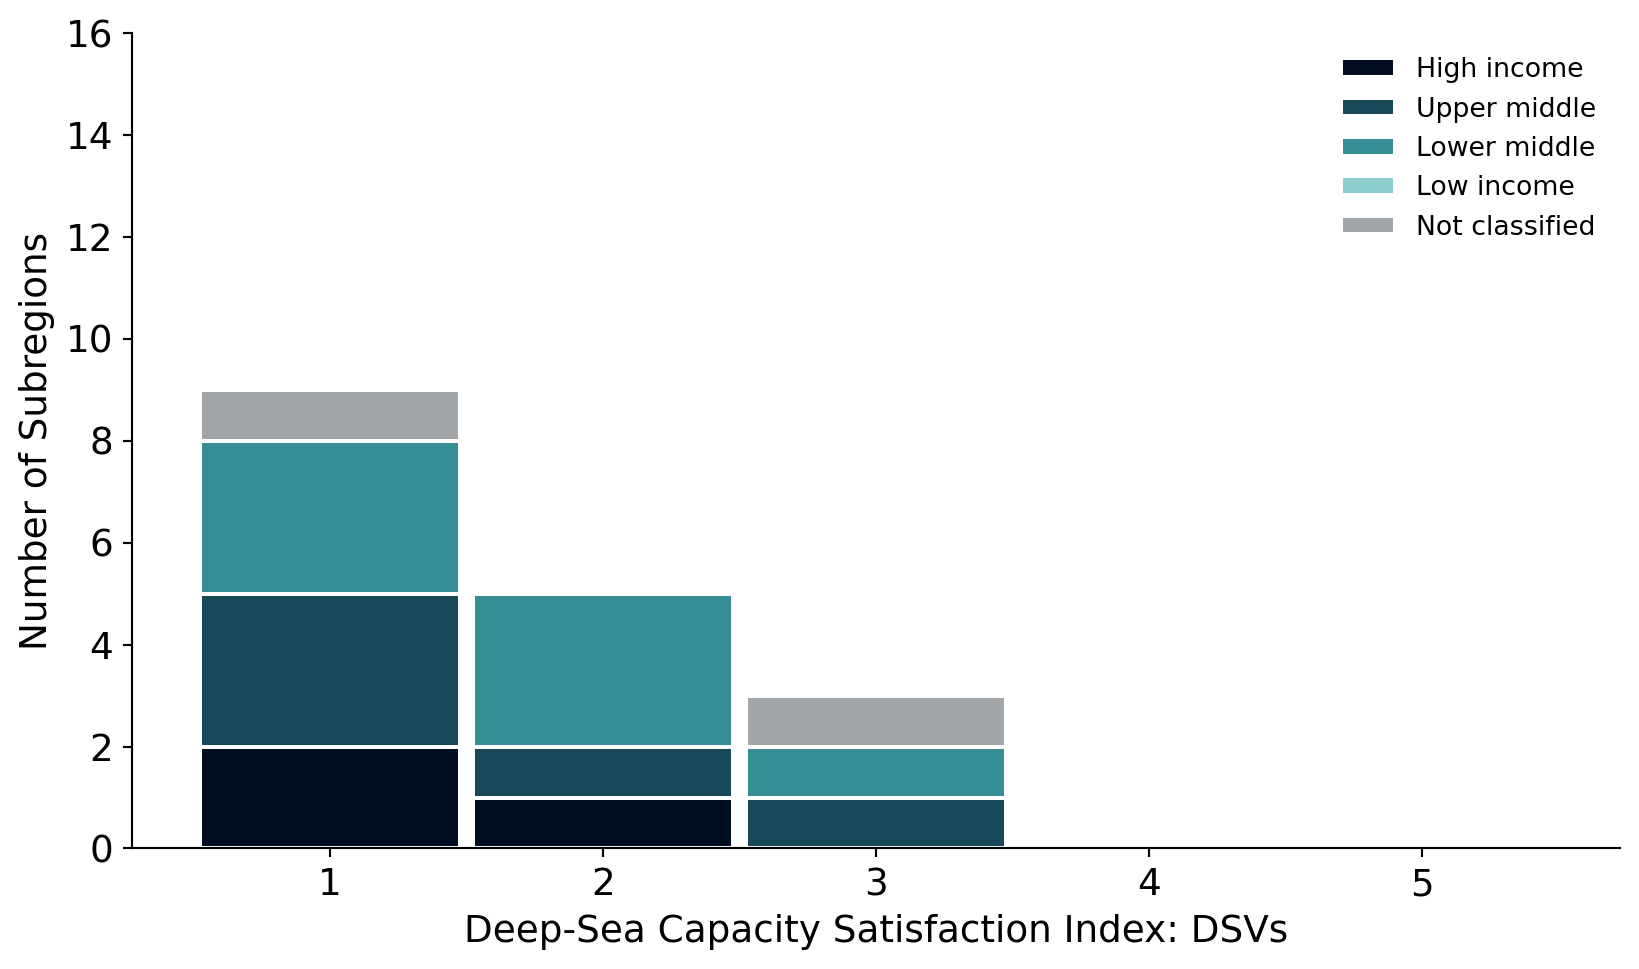

adding empty row for 5
Adding missing column Low income
adding empty row for 5
Adding missing column Low income


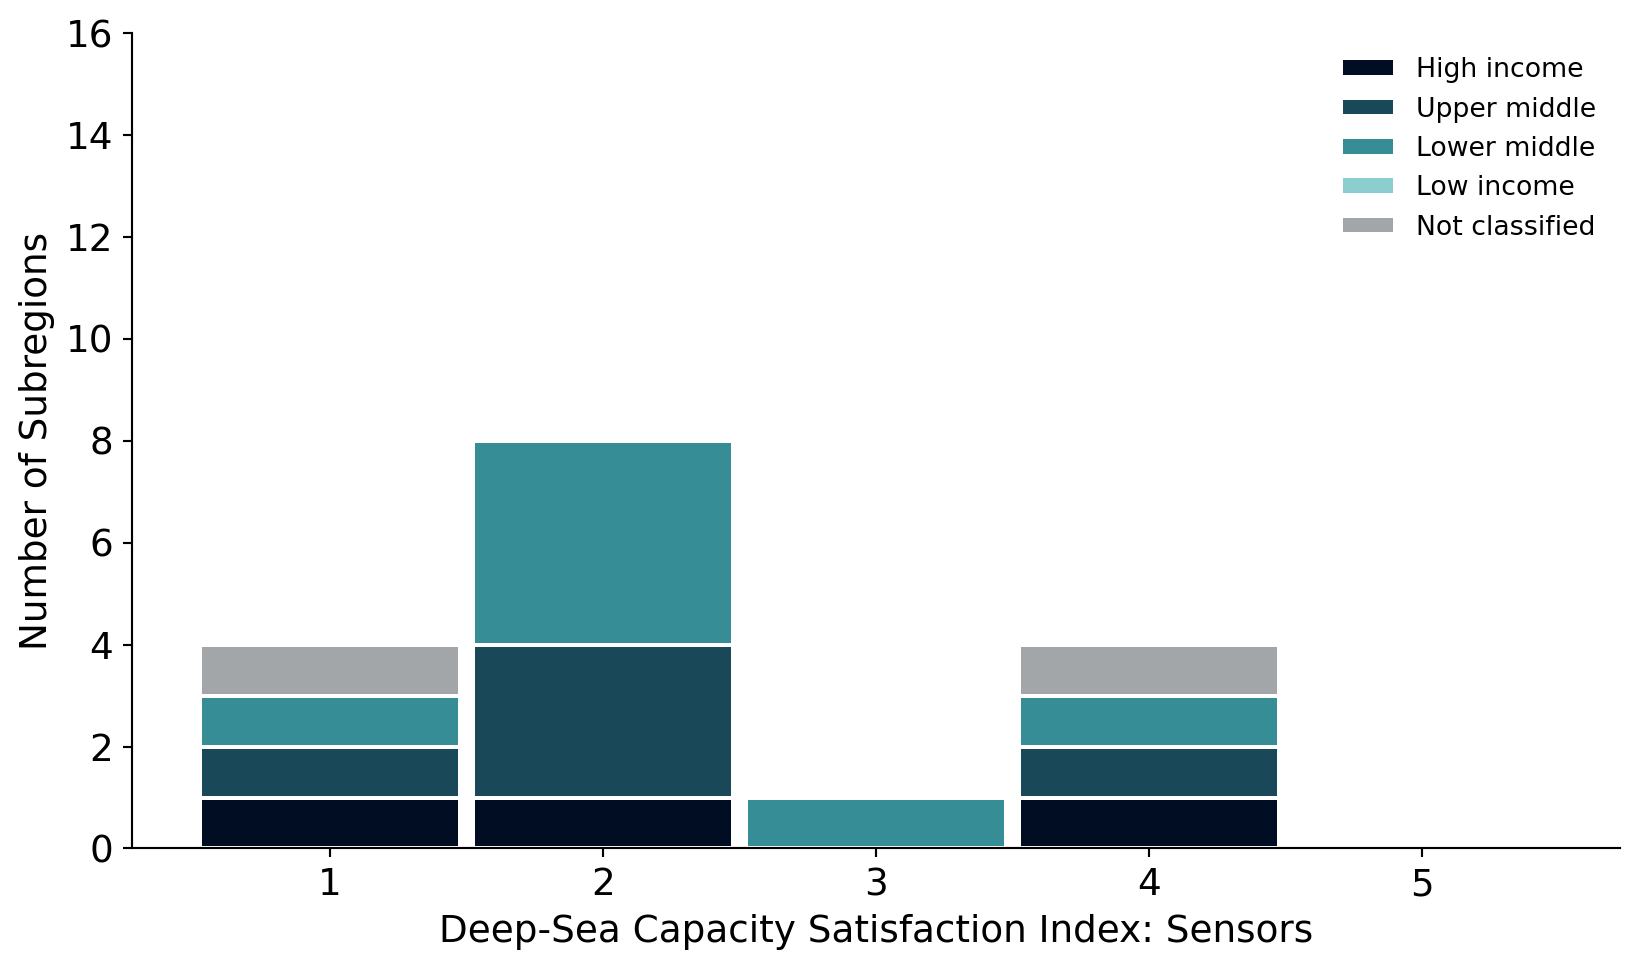

adding empty row for 4
adding empty row for 5
Adding missing column Low income
adding empty row for 4
adding empty row for 5
Adding missing column Low income


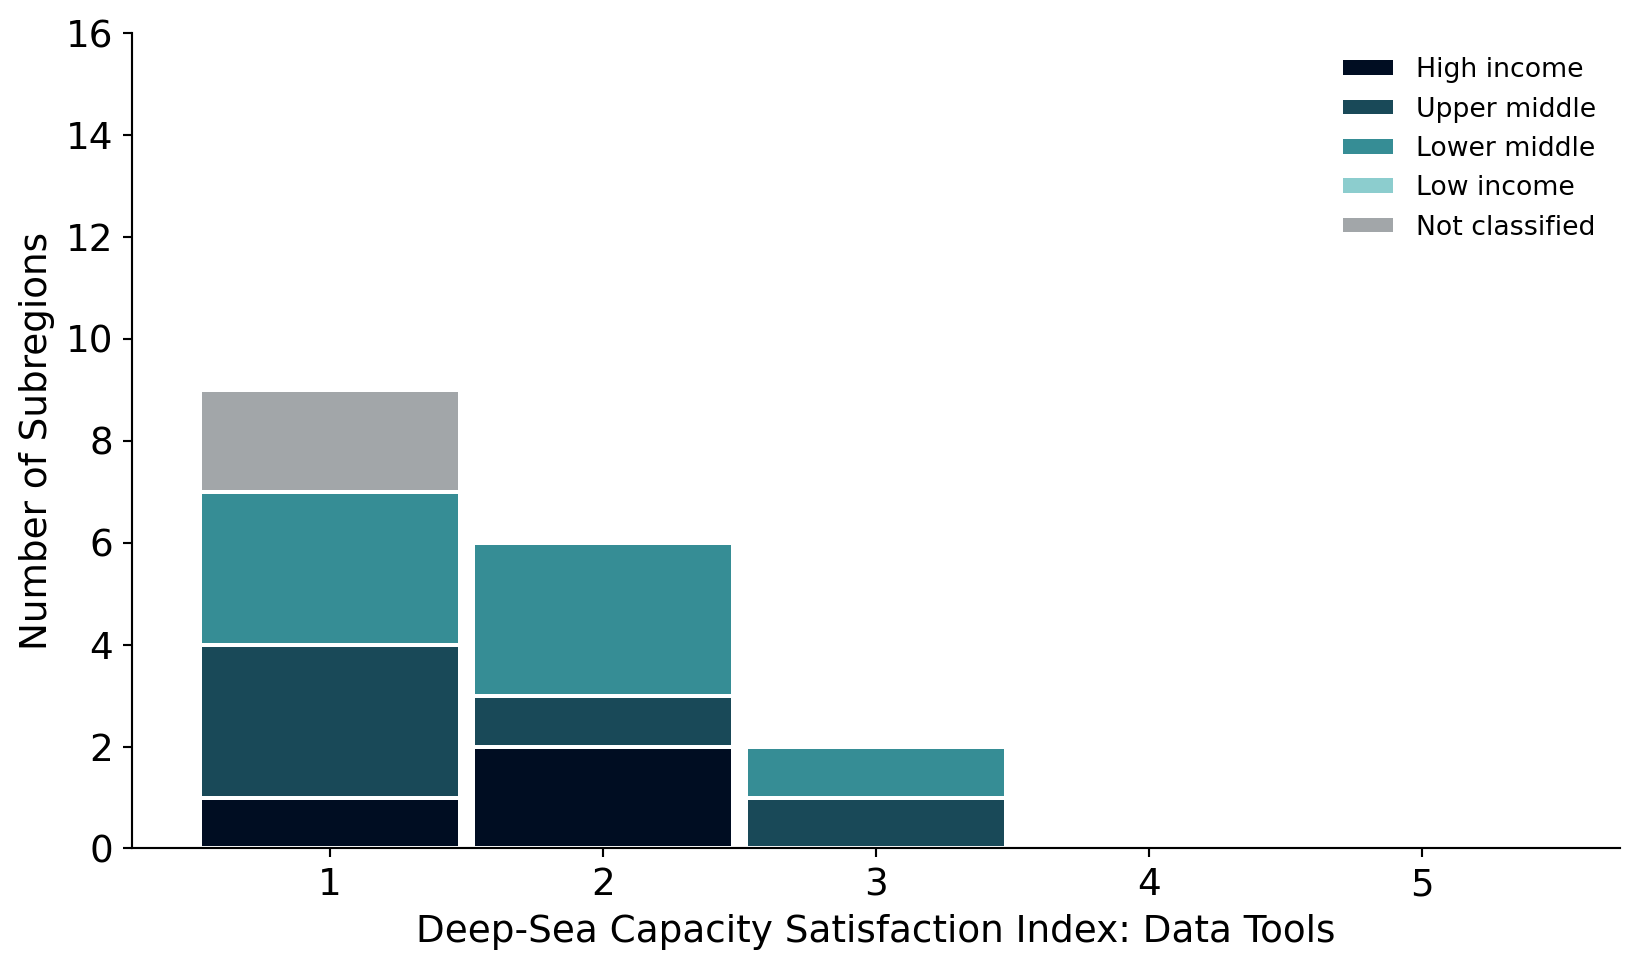

In [71]:
## Calculate fig data

dsc_types = {
    'dsc-ai-all':
        { 'x-label': 'Deep-Sea Capacity Accessibility Index',
          'y-label': 'Number of Subregions',
          'y-limit-override': 10,
          'fig-letter': 'AD1'
        },
    'dsc-ai-vessel':
        { 'x-label': 'Deep-Sea Capacity Accessibility Index: Vessels',
          'y-label': 'Number of Subregions',
          'fig-letter': 'AD2'
        },
    'dsc-ai-dsv':
        { 'x-label': 'Deep-Sea Capacity Accessibility Index: DSVs',
          'y-label': 'Number of Subregions',
          'fig-letter': 'AD3'
        },
    'dsc-ai-sensor':
        { 'x-label': 'Deep-Sea Capacity Accessibility Index: Sensors',
          'y-label': 'Number of Subregions',
          'fig-letter': 'AD4'
        },
    'dsc-ai-data':
        { 'x-label': 'Deep-Sea Capacity Accessibility Index: Data Tools',
          'y-label': 'Number of Subregions',
          'fig-letter': 'AD5'
        },
    'dsc-si-all':
        { 'x-label': 'Deep-Sea Capacity Satisfaction Index',
          'y-label': 'Number of Subregions',
          'y-limit-override': 10,
          'fig-letter': 'AE1'
        },
    'dsc-si-vessel':
        { 'x-label': 'Deep-Sea Capacity Satisfaction Index: Vessels',
          'y-label': 'Number of Subregions',
          'fig-letter': 'AE2'
        },
    'dsc-si-dsv':
        { 'x-label': 'Deep-Sea Capacity Satisfaction Index: DSVs',
          'y-label': 'Number of Subregions',
          'fig-letter': 'AE3'
        },
    'dsc-si-sensor':
        { 'x-label': 'Deep-Sea Capacity Satisfaction Index: Sensors',
          'y-label': 'Number of Subregions',
          'fig-letter': 'AE4'
        },
    'dsc-si-data':
        { 'x-label': 'Deep-Sea Capacity Satisfaction Index: Data Tools',
          'y-label': 'Number of Subregions',
          'fig-letter': 'AE5'
        }
}

for dsc_type, labels in dsc_types.items():
    fig_data = {}
    for region in region_list:
        fig_data[region] = (country_tableR[region]
                    .groupby([dsc_type, 'subregion', 'subregion_orig'])[dsc_type]
                    .mean()
                    .rename('mean')
                    .reset_index())
        fig_data[region] = (fig_data[region]
                    .groupby(['mean', 'subregion'])['mean']
                    .count()
                    .rename('count')
                    .reset_index())
        fig_data[region]['mean'] = fig_data[region]['mean'].astype(int)
        fig_data[region] = fig_data[region].pivot(index='mean', columns=['subregion'], values='count')
        for n in range(1,6):
            if n not in fig_data[region].index:
                print('adding empty row for', n)
                fig_data[region].loc[n] = 0
        fig_data[region] = fig_data[region].sort_index()
        fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis=1)
        #display(fig_data[region])

    ## Plot figures

    w = 1920
    h = 1080
    
    for region in region_list:
        r = region
        fig_data[region] = (country_tableR[region]
                    .groupby([dsc_type, 'subregion', 'subregion_orig'])[dsc_type]
                    .mean()
                    .rename('mean')
                    .reset_index())
        fig_data[region] = (fig_data[region]
                    .groupby(['mean', 'subregion'])['mean']
                    .count()
                    .rename('count')
                    .reset_index())
        fig_data[region]['mean'] = fig_data[region]['mean'].astype(int)

        fig_data[region] = fig_data[region].pivot(index='mean', columns=['subregion'], values='count')
        for n in range(1,6):
            if n not in fig_data[region].index:
                print('adding empty row for', n)
                fig_data[region].loc[n] = 0
        fig_data[region] = fig_data[region].sort_index()
        fig_data[region] = prep_fig_data_for_plotting(fig_data[region], r, axis=1)

        fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
        fig_data[region].plot(kind='bar',
                      stacked=True,
                      rot=0,
                      fontsize=14,
                      width=0.95,
                      color=cat_d23e123_by_region[region],
                      edgecolor='white',
                      linewidth=1.5,
                      ax=ax)
        ax.set_xlabel(labels['x-label'], fontsize=14)
        ax.set_ylabel(labels['y-label'], fontsize=14)
        plt.locator_params(axis='y', integer=True)
        ylim_max = 16
        if 'y-limit-override' in labels:
            ylim_max = labels['y-limit-override']
        ax.set_ylim([0, ylim_max])

        ax.legend(fontsize=10,
                  title_fontsize=10)

        outputfigs(plt, fig, ax, region, section='5', letter=labels['fig-letter'])

## **Figs AD1b-AD5b AE1b-AE5b**

In [72]:
## Calculate fig data

dsc_types = {
    'dsc-ai-all':
        { 'x-label': 'Deep-Sea Capacity Accessibility Index',
          'y-label': 'Number of Subregions',
          'y-limit-override': 10,
          'fig-letter': 'AD1b'
        },
    'dsc-ai-vessel':
        { 'x-label': 'Deep-Sea Capacity Accessibility Index: Vessels',
          'y-label': 'Number of Subregions',
          'fig-letter': 'AD2b'
        },
    'dsc-ai-dsv':
        { 'x-label': 'Deep-Sea Capacity Accessibility Index: DSVs',
          'y-label': 'Number of Subregions',
          'fig-letter': 'AD3b'
        },
    'dsc-ai-sensor':
        { 'x-label': 'Deep-Sea Capacity Accessibility Index: Sensors',
          'y-label': 'Number of Subregions',
          'fig-letter': 'AD4b'
        },
    'dsc-ai-data':
        { 'x-label': 'Deep-Sea Capacity Accessibility Index: Data Tools',
          'y-label': 'Number of Subregions',
          'fig-letter': 'AD5b'
        },
    'dsc-si-all':
        { 'x-label': 'Deep-Sea Capacity Satisfaction Index',
          'y-label': 'Number of Subregions',
          'y-limit-override': 10,
          'fig-letter': 'AE1b'
        },
    'dsc-si-vessel':
        { 'x-label': 'Deep-Sea Capacity Satisfaction Index: Vessels',
          'y-label': 'Number of Subregions',
          'fig-letter': 'AE2b'
        },
    'dsc-si-dsv':
        { 'x-label': 'Deep-Sea Capacity Satisfaction Index: DSVs',
          'y-label': 'Number of Subregions',
          'fig-letter': 'AE3b'
        },
    'dsc-si-sensor':
        { 'x-label': 'Deep-Sea Capacity Satisfaction Index: Sensors',
          'y-label': 'Number of Subregions',
          'fig-letter': 'AE4b'
        },
    'dsc-si-data':
        { 'x-label': 'Deep-Sea Capacity Satisfaction Index: Data Tools',
          'y-label': 'Number of Subregions',
          'fig-letter': 'AE5b'
        }
}

regions_to_skip = ['Global', 'Economies', 'SIDS']

for dsc_type, labels in dsc_types.items():
    fig_data = {}
    for region in region_list:
        if region in regions_to_skip:
            print('Skipping region', region);
            continue

        for r in ['Global', region]:
            fig_data[r] = (country_tableR[r]
                        .groupby([dsc_type, 'subregion', 'subregion_orig'])[dsc_type]
                        .mean()
                        .rename('mean')
                        .reset_index())
            fig_data[r] = (fig_data[r]
                        .groupby(['mean', 'subregion'])['mean']
                        .count()
                        .rename('count')
                        .reset_index())
            fig_data[r]['mean'] = fig_data[r]['mean'].astype(int)

            fig_data[r] = fig_data[r].pivot(index='mean', columns=['subregion'], values='count')
            for n in range(1,6):
                if n not in fig_data[r].index:
                    print('adding empty row for', n)
                    fig_data[r].loc[n] = 0
            fig_data[r] = fig_data[r].sort_index()
            fig_data[r] = prep_fig_data_for_plotting(fig_data[r], r, axis=1)

        if region == 'Americas':
            colnum = fig_data['Global'].columns.get_loc('N America')
            fig_data['Global'] = fig_data['Global'].rename(columns={'N America': 'Old N America'})
            i=0
            for columnname, column in fig_data[region].iteritems():
                fig_data['Global'].insert(colnum+i, columnname, column)
                i+=1
            fig_data['Global'] = fig_data['Global'].drop(columns=['Old N America', 'L Amer & Carib'])
        else:
            colnum = fig_data['Global'].columns.get_loc(region)
            i=0
            for columnname, column in fig_data[region].iteritems():
                fig_data['Global'].insert(colnum+i, columnname, column)
                i+=1
            fig_data['Global'] = fig_data['Global'].drop(columns=region)
        fig_data[region] = fig_data['Global']
        #display(fig_data['Global'])


    ## Plot figures

    w = 1920
    h = 1080
    
    for region in region_list:
        if region in regions_to_skip:
            continue

        fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
        fig_data[region].plot(kind='bar',
                      stacked=True,
                      rot=0,
                      fontsize=14,
                      width=0.95,
                      edgecolor='white',
                      linewidth=1,
                      ax=ax)
        ax.set_xlabel(labels['x-label'], fontsize=14)
        ax.set_ylabel(labels['y-label'], fontsize=14)
        plt.locator_params(axis='y', integer=True)
        ylim_max = 16
        if 'y-limit-override' in labels:
            ylim_max = labels['y-limit-override']
        ax.set_ylim([0, ylim_max])
        
        colors = []
        edgecolors = []
        linewidths = []
        for (columnname, data) in fig_data[region].iteritems():
            for datum in data:
                orig_columnname = undo_label_adjustment(columnname)
                if orig_columnname in orderR[region]:
                    colors.append(cat_d23e123_by_region[region][orderR[region].index(orig_columnname)])
                    edgecolors.append('black')
                    linewidths.append(1)
                else:
                    colors.append('#d4d4d4')
                    edgecolors.append('white')
                    linewidths.append(1)
        for p,color in zip(ax.patches,colors):
            p.set_facecolor(color)
        for p,edgecolor in zip(ax.patches,edgecolors):
            p.set_edgecolor(edgecolor)
            if edgecolor != 'white':
                p.set_zorder(10)
        for p,linewidth in zip(ax.patches,linewidths):
            p.set_linewidth(linewidth)

        prunedhandles = []
        prunedlabels = []
        currenthandles, currentlabels = ax.get_legend_handles_labels()   #get the handles
        for handle, label in zip(currenthandles, currentlabels):
            if undo_label_adjustment(label) in orderR[region]:
                prunedhandles.append(handle)
                prunedlabels.append(label)
        patch = matplotlib.patches.Patch(facecolor='#d4d4d4', edgecolor='white')
        prunedhandles.append(patch)
        prunedlabels.append('All other regions')

        ax.legend(prunedhandles,
                  prunedlabels,
                  fontsize=10,
                  title_fontsize=10)

        outputfigs(plt, fig, ax, region, section='5', letter=labels['fig-letter'])

Skipping region SIDS
Skipping region SIDS
Skipping region SIDS
Skipping region SIDS
Skipping region SIDS
Skipping region SIDS
Skipping region SIDS
Skipping region SIDS
Skipping region SIDS
Skipping region SIDS


---
# **Section 6**

## **Fig K2**&nbsp; Research: Vessel presence

In [73]:
## Calculate values for plot

vessel_presence = {}
label_order = {}
fig_data = {}
for region in region_list:
    vessel_presence[region] = researchR[region].loc[(researchR[region]['question'] == 'Q13')
                                   & (researchR[region]['col_name'] != 'Q13_comments')
                                   & (researchR[region]['col_name'] != 'Q13_other'),
                                                                             ['geoarea',
                                                                              'col_name',
                                                                              'subregion',
                                                                              'research_tech_clean']]
    vessel_presence[region]['selection_binary'] = vessel_presence[region]['research_tech_clean']
    fig_data[region] = (vessel_presence[region].groupby(['subregion', 'col_name'])['selection_binary']
                    .sum()
                    .rename('count')
                    .reset_index())

    num_areas_per_subregion = vessel_presence[region].groupby('subregion')['geoarea'].nunique()
    num_areas_dict = dict(zip(num_areas_per_subregion.index, num_areas_per_subregion.values))
    fig_data[region]['total'] = fig_data[region]['subregion']
    fig_data[region]['total'].replace(num_areas_dict, inplace=True)

    fig_data[region]['percent'] = round((fig_data[region]['count']/fig_data[region]['total'])*100, 2)

    renames = {
        'Q13_research':     'Research',
        'Q13_fishing':      'Fishing',
        'Q13_recreational': 'Recreational',
        'Q13_traditional':  'Traditional',
        'Q13_cruise':       'Cruise',
        'Q13_navy':         'Navy',
    }
    hue_order = renames.values()
    fig_data[region]['col_name'].replace(renames, inplace=True)
    fig_data[region]['subregion'].replace(label_adjustments, inplace=True)
    label_order[region] = []
    for x in orderR[region]:
        if x in label_adjustments:
            label_order[region].append(label_adjustments[x])
        else:
            label_order[region].append(x)

    pivoted = fig_data[region].pivot(columns='col_name', index='subregion', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()
    total_yes_in_region = pivoted.loc['Total', ('count', 'cruise'):('count', 'traditional')].sum()
    pivoted.loc['Total', ('percent', 'cruise'):('percent', 'traditional')] = \
        ((pivoted.loc['Total', ('count', 'cruise'):('count', 'traditional')]/total_yes_in_region).values)*100

    #display(round(pivoted, 2))

In [74]:
## Names of GeoAreas with all types present

for region in region_list:
    num_types = (vessel_presence[region][vessel_presence[region]['col_name'] != 'Q13_other']
                     .groupby(['subregion', 'geoarea'])['selection_binary']
                     .sum()
                     .rename('num_types')
                     .reset_index())

    num_types[num_types['num_types'] == num_types['num_types'].max()]
    
    ## Names of GeoAreas with fewest types present
    num_types[num_types['num_types'] == num_types['num_types'].min()]
    
    ## % of areas in region that have all types -- OTHER EXCLUDED
    num_types = (vessel_presence[region][vessel_presence[region]['col_name'] != 'Q13_other']
                     .groupby(['subregion', 'geoarea'])['selection_binary']
                     .sum()
                     .rename('num_types')
                     .reset_index())

    round((num_types[num_types['num_types'] == 6].shape[0]/num_types.shape[0])*100, 2)
    
    ## % of areas in region with < 3 types -- OTHER INCLUDED
    num_types = (vessel_presence[region]
                     .groupby(['subregion', 'geoarea'])['selection_binary']
                     .sum()
                     .rename('num_types')
                     .reset_index())

    round((num_types[num_types['num_types'] < 3].shape[0]/num_types.shape[0])*100, 2)

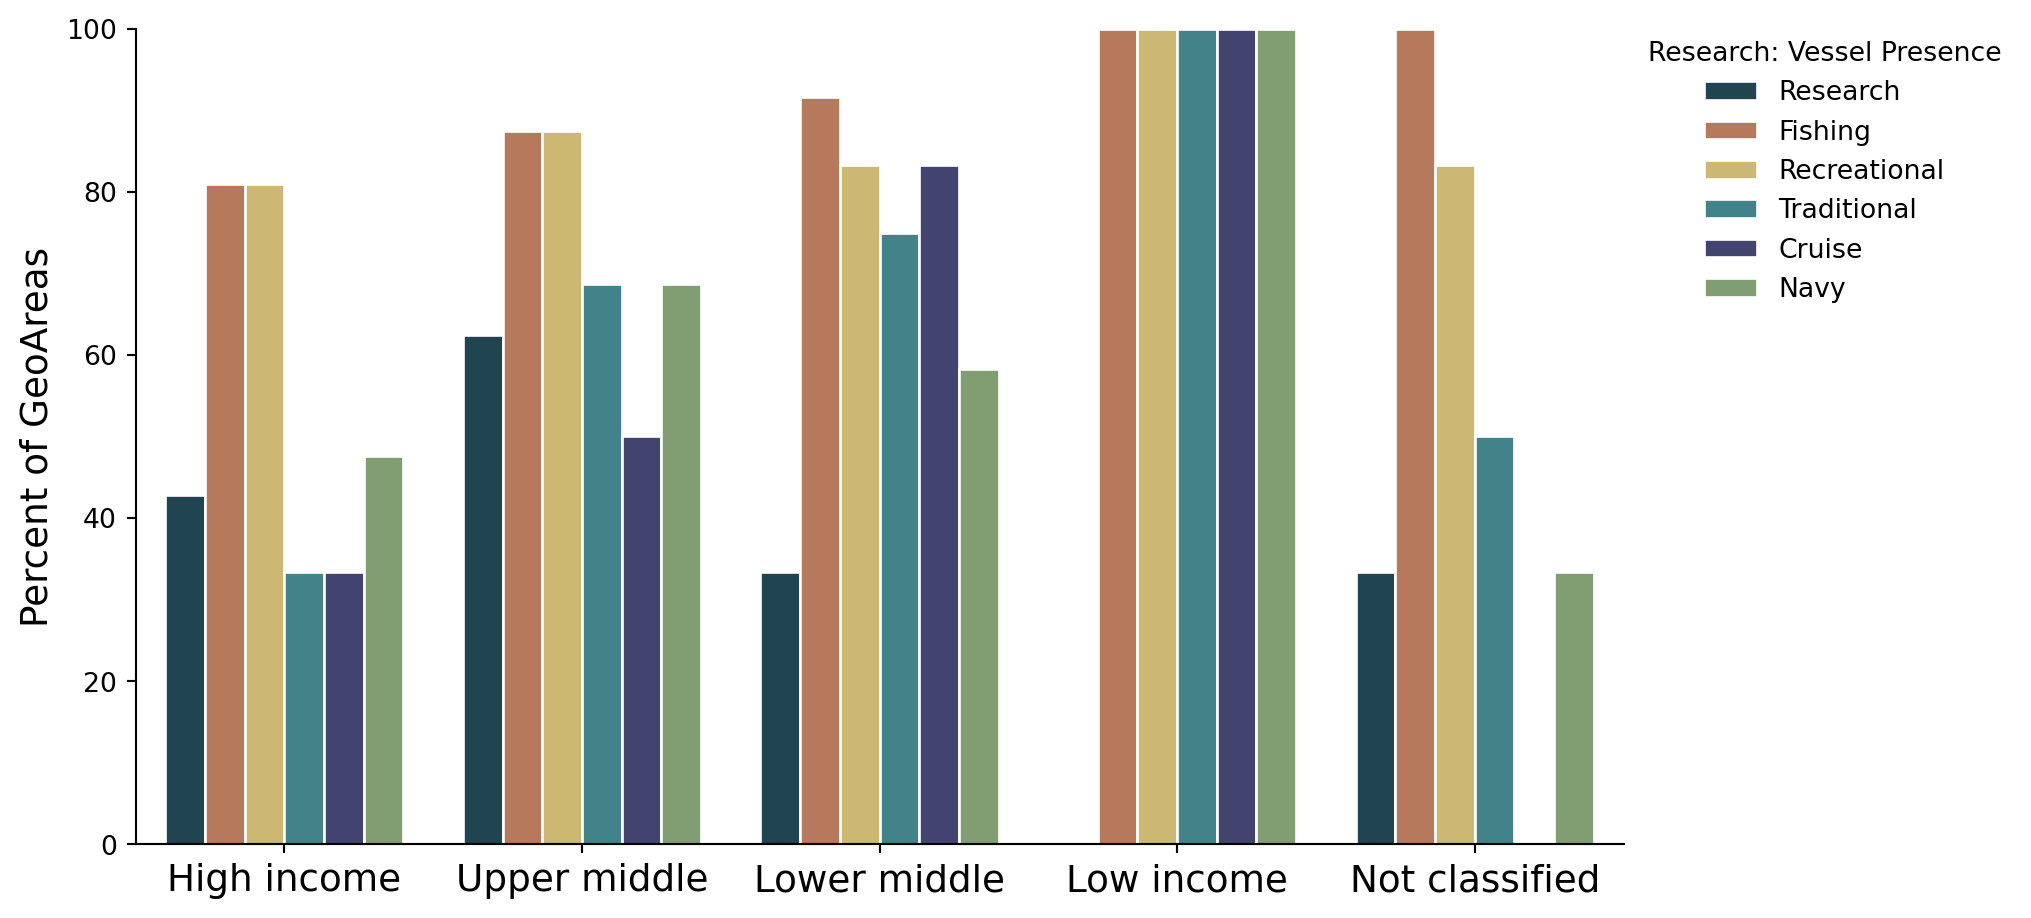

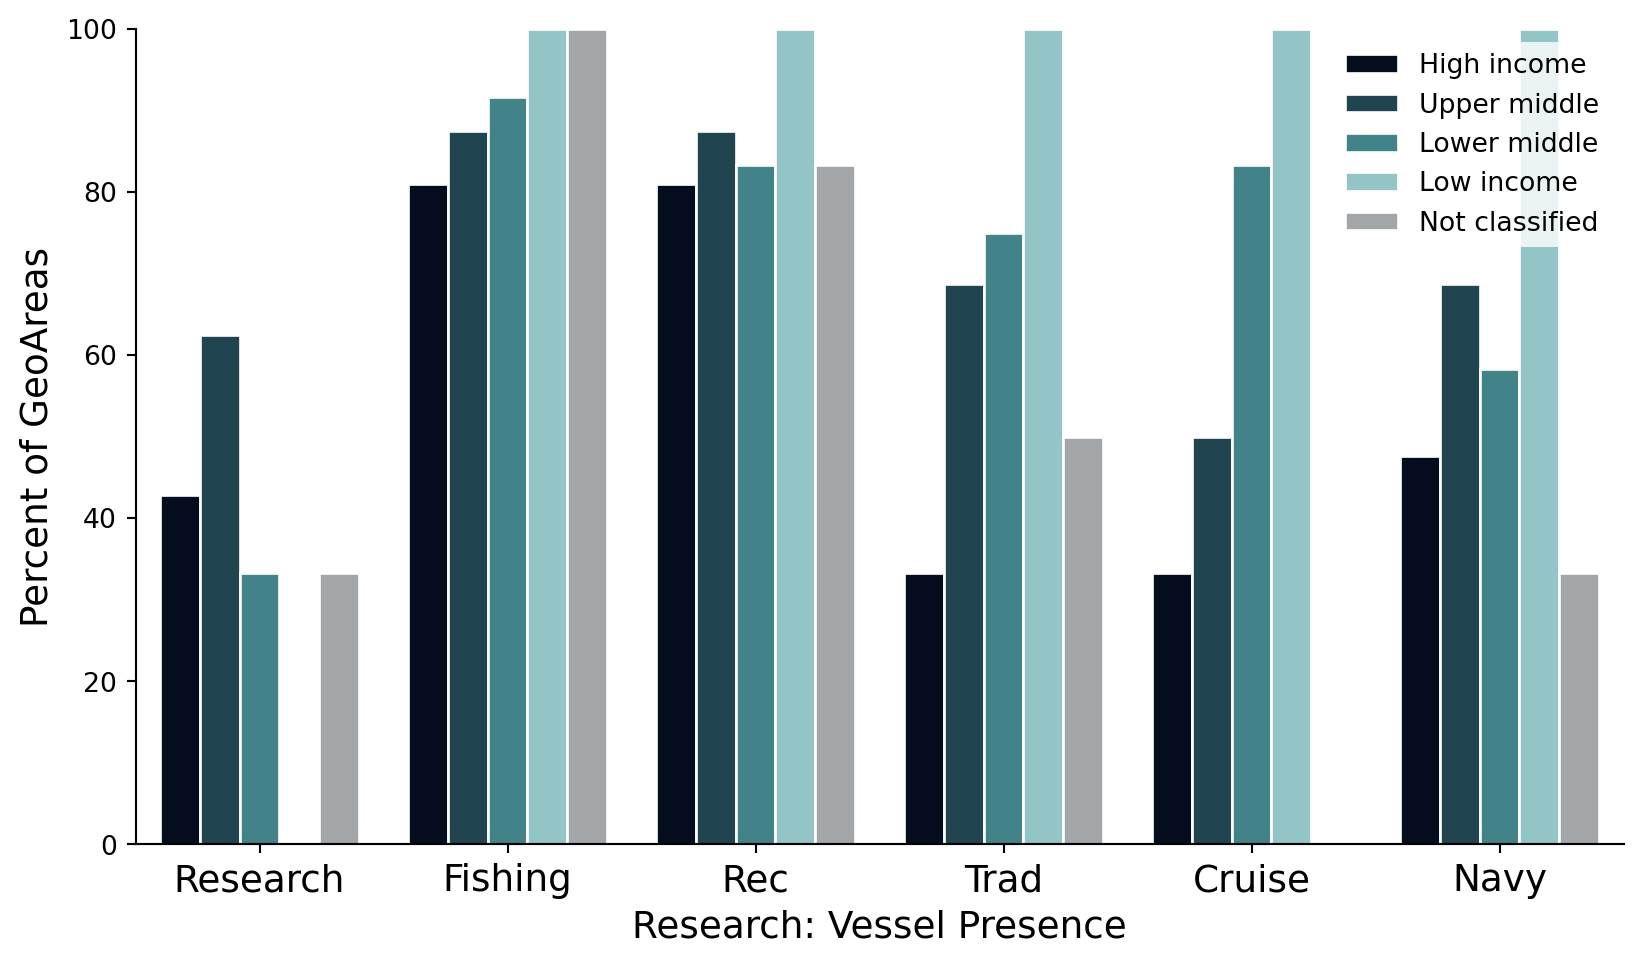

In [75]:
## Create plot

w = 1920
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
    ax = sns.barplot(x='subregion',
                     y='percent',
                     hue='col_name',
                     order=label_order[region],
                     hue_order=hue_order,
                     palette=cat_06,
                     edgecolor='white',
                     ci=None,
                     data=fig_data[region])            

    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=14)
    ax.set(xlabel=None)
    ax.set_ylim([0, 100])
    ax.set_ylabel('Percent of GeoAreas', fontsize=14)
    ax.legend(bbox_to_anchor=(1, 1.015),
              loc='upper left',
              title='Research: Vessel Presence',
              fontsize=10,
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='6', letter='K1')

    ## K2

    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
    ax = sns.barplot(x='col_name',
                     y='percent',
                     hue='subregion',
                     order=hue_order,
                     hue_order=label_order[region],
                     palette=cat_d23e123_by_region[region],
                     edgecolor='white',
                     ci=None,
                     data=fig_data[region])            

    ax.set_xticklabels(['Research', 'Fishing', 'Rec', 'Trad', 'Cruise', 'Navy'], rotation=0, fontsize=14)
    ax.set_xlabel('Research: Vessel Presence', fontsize=14)
    ax.set_ylim([0, 100])
    ax.set_ylabel('Percent of GeoAreas', fontsize=14)
    ax.legend(loc='upper right',
              fontsize=10,
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='6', letter='K2')

## **Fig L2**&nbsp; Q12/13: Vessel presence

In [76]:
## Get data for figure - using num respondents for aggregated calculations & denominators

label_order = {}
fig_data = {}
percent_data = {}
for region in region_list:
    vessels = dataR[region].loc[dataR[region]['question'] == 'Q13', ['subregion', 
                                                   'geoarea', 
                                                   'respondent_id', 
                                                   'selection_survey_clean']]
    vessels = vessels[vessels['selection_survey_clean'] != '']

    fig_data[region] = (vessels.groupby(['subregion', 'selection_survey_clean'])['respondent_id']
                       .nunique()
                       .rename('count')
                       .reset_index())

    renames = {
        'Research vessels':               'Research',
        'Fishing vessels':                'Fishing',
        'Recreational vessels':           'Recreational',
        'Traditional vessels':            'Traditional',
        'Cruise ships':                   'Cruise',
        'Other':                          'Other',
        "I don't have access to vessels": 'None of the above',
    }
    hue_order = renames.values()
    fig_data[region]['selection_survey_clean'].replace(renames, inplace=True)
    fig_data[region]['subregion'].replace(label_adjustments, inplace=True)
    label_order[region] = []
    for x in orderR[region]:
        if x in label_adjustments:
            label_order[region].append(label_adjustments[x])
        else:
            label_order[region].append(x)

    # Calculate percentages
    percent_data[region] = fig_data[region].copy()
    num_respondents_per_subregion = vessels.groupby('subregion')['respondent_id'].nunique().reset_index()
    num_respondents_per_subregion['subregion'].replace(label_adjustments, inplace=True)

    respondent_sub_dict = dict(zip(num_respondents_per_subregion['subregion'], 
                                   num_respondents_per_subregion['respondent_id']))
    percent_data[region]['total'] = percent_data[region]['subregion']
    percent_data[region]['total'].replace(respondent_sub_dict, inplace=True)
    percent_data[region]['percent'] = round((percent_data[region]['count']/percent_data[region]['total'])*100, 2)

    pivoted = percent_data[region].pivot(columns='subregion', index='selection_survey_clean', values=['count', 'percent'])
    pivoted.loc['Total'] = num_respondents_per_subregion['respondent_id'].tolist()*2
    num_respondents = vessels['respondent_id'].nunique()
    pivoted.loc['Total', 'percent'] = round((pivoted.loc['Total', 'percent']/101)*num_respondents, 2).values

    pivoted[('count', 'Total')] = pivoted['count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_respondents)*100, 2)

    #display(pivoted)

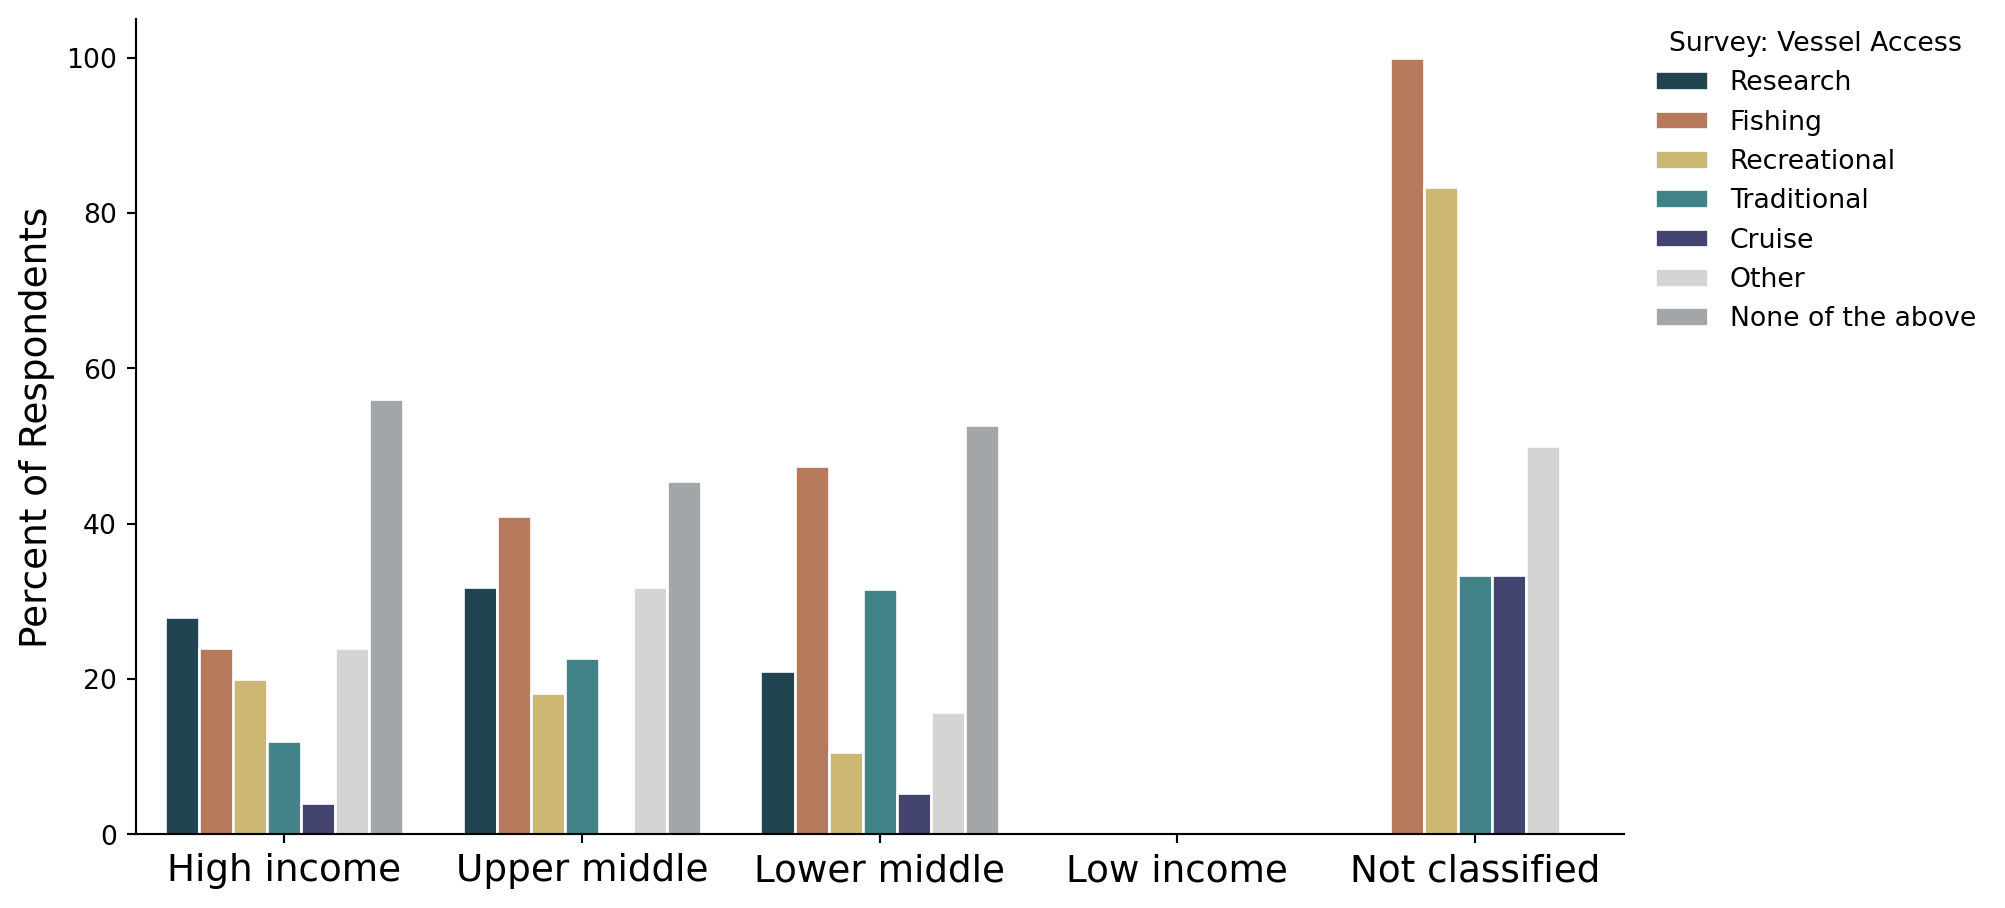

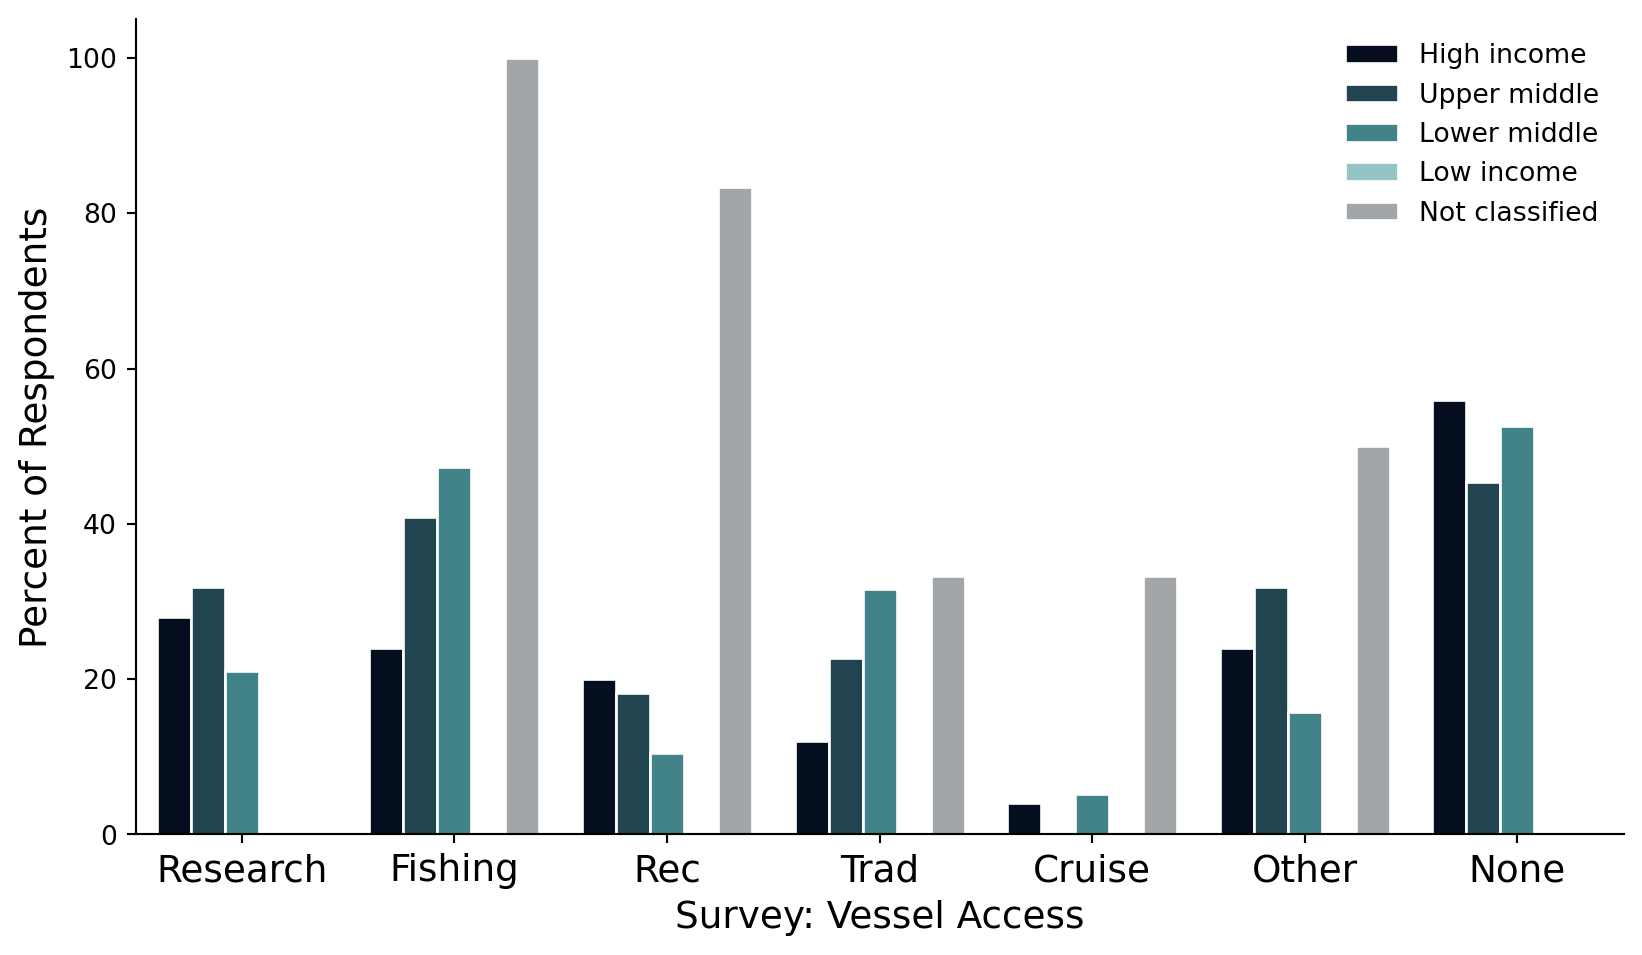

In [77]:
## Create plot

w = 1920
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
    ax = sns.barplot(x='subregion',
                     y='percent',
                     hue='selection_survey_clean',
                     order=label_order[region],
                     hue_order=hue_order,
                     palette=cat_05 + ['#a2a6a9'],
                     edgecolor='white',
                     ci=None,
                     data=percent_data[region])            

    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=14)
    ax.set(xlabel=None)
    ax.set_ylabel('Percent of Respondents', fontsize=14)
    # ax.set_yticks([0, 5, 10, 15, 20])
    loc_tweaks = {'Africa': 'upper left'}
    ax.legend(bbox_to_anchor=(1.005, 1.015), loc=loc_tweaker(region, loc_tweaks),
              title='Survey: Vessel Access',
              fontsize=10,
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='6', letter='L1')
    
    ## L2

    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
    ax = sns.barplot(x='selection_survey_clean',
                     y='percent',
                     hue='subregion',
                     order=hue_order,
                     hue_order=label_order[region],
                     palette=cat_d23e123_by_region[region],
                     edgecolor='white',
                     ci=None,
                     data=percent_data[region])            

    ax.set_xticklabels(['Research', 'Fishing', 'Rec', 'Trad', 'Cruise', 'Other', 'None'], rotation=0, fontsize=14)
    ax.set_xlabel('Survey: Vessel Access', fontsize=14)
    ax.set_ylabel('Percent of Respondents', fontsize=14)
    loc_tweaks = {'Africa': 'upper left'}
    ax.legend(loc='upper right',
              fontsize=10,
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='6', letter='L2')

## **Fig M1**&nbsp; Q14: Vessel satisfaction

In [78]:
## Select data

satisfaction = {}
missing_responses = {}
for region in region_list:
    satisfaction[region] = dataR[region].loc[dataR[region]['question'] == 'Q14', ['col_name', 
                                                   'subregion', 
                                                   'geoarea', 
                                                   'respondent_id', 
                                                   'selection',
                                                   'selection_other']]
    satisfaction[region].loc[(satisfaction[region]['col_name'] == 'Q14_other') & 
                     (satisfaction[region]['selection'] != ''), 'selection_other'] = 'Other'

    missing_responses[region] = satisfaction[region][satisfaction[region]['selection_other'] == ''].copy()

    satisfaction[region] = satisfaction[region][~satisfaction[region]['selection_other'].isin(['Other', ''])]
    satisfaction[region]['row_num'] = np.arange(satisfaction[region].shape[0])
    #display(satisfaction[region].head())

In [79]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Very dissatisfied', 
            'Dissatisfied', 
            'Neutral', 
            'Satisfied', 
            'Very satisfied']

fig_data = {}
for region in region_list:
    fig_data[region] = satisfaction[region].pivot(columns='subregion', index='row_num', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({'1 - Very dissatisfied': 'Very dissatisfied',
                      '2 - Dissatisfied': 'Dissatisfied',
                      '3 - Neither satisfied nor dissatisfied': 'Neutral',
                      '4 - Satisfied': 'Satisfied',
                      '5 - Very satisfied': 'Very satisfied'}, inplace=True)

Adding missing column Low income


In [80]:
## Calculate statistics

for region in region_list:
    percent_data = (satisfaction[region].groupby(['subregion', 'selection'])['row_num']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = satisfaction[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

In [81]:
## Calculate number of people who chose NA for each question and subregion - recall that one individual could choose 
## NA for more than one question

for region in region_list:
    stats = missing_responses[region].groupby(['col_name', 'subregion'])['respondent_id'].nunique().rename('count').reset_index()
    stats = stats.pivot(columns='subregion', index='col_name', values='count')
    stats['Total'] = stats.sum(axis=1)
    #display(stats)

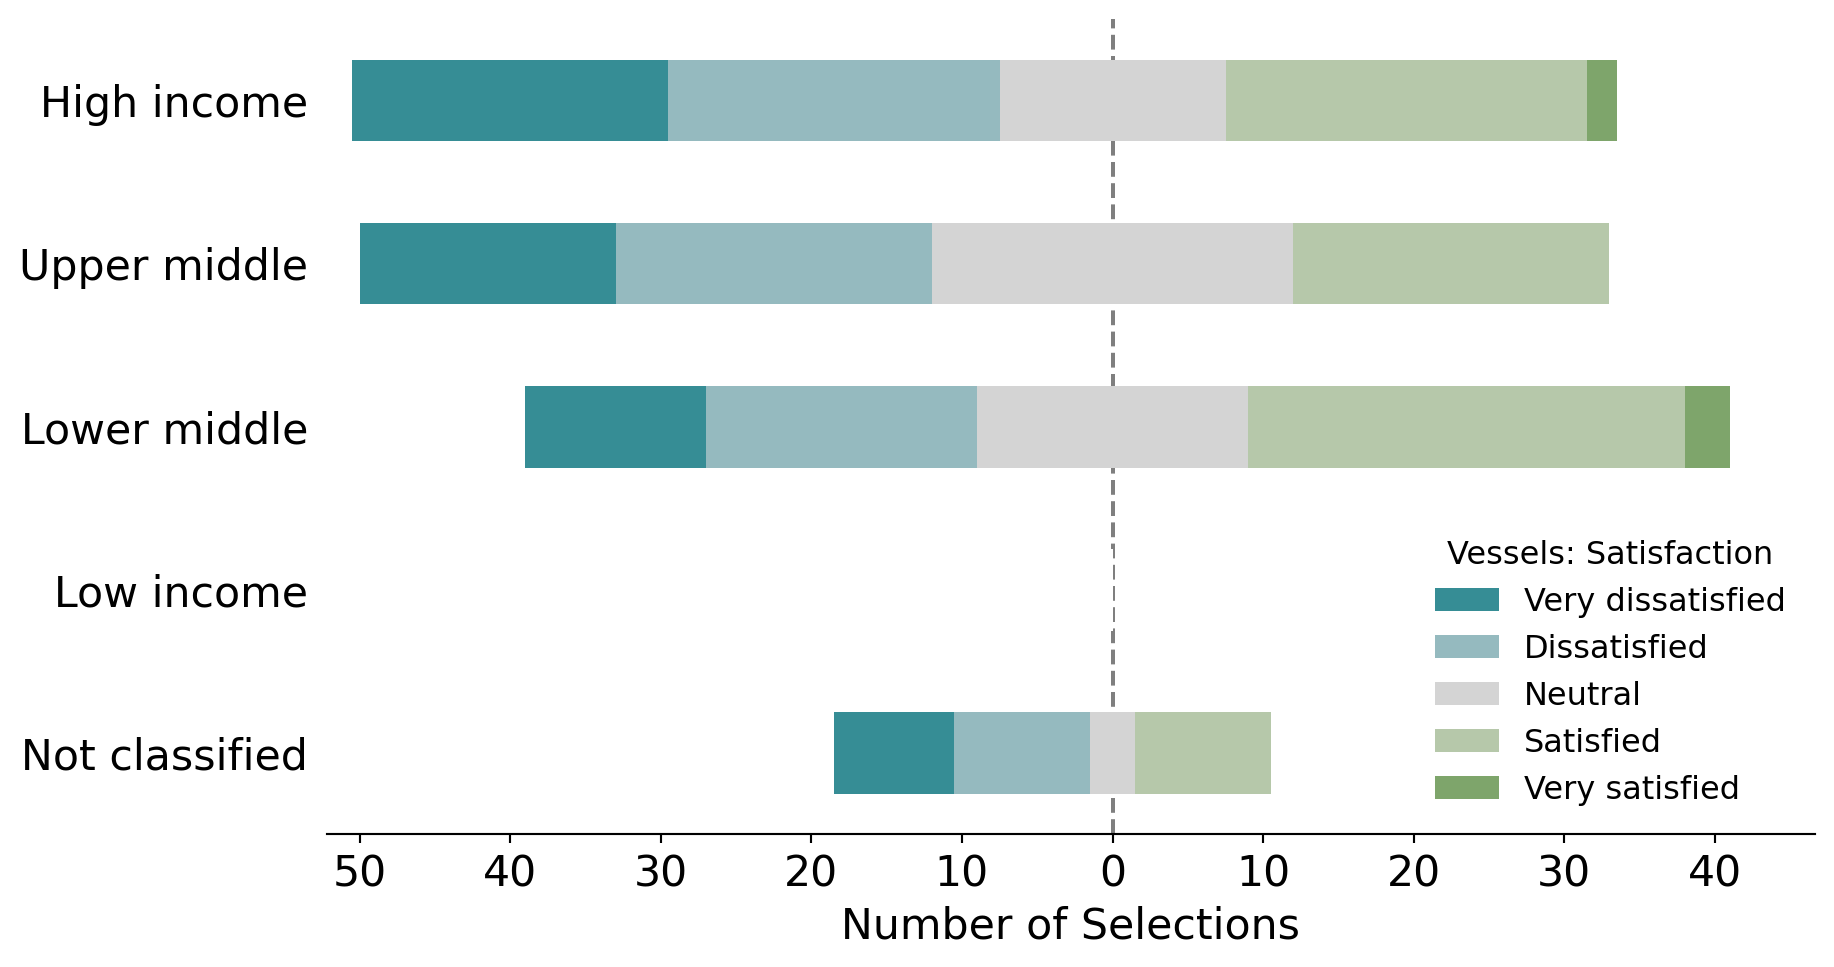

In [82]:
## Create plot

w = 1920
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Selections', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {'Europe': 'upper left', 'Global': 'upper left'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='Vessels: Satisfaction',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='6', letter='M1')

## **Fig M2**&nbsp; Vessel satisfaction #2

In [83]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Very dissatisfied', 
            'Dissatisfied', 
            'Neutral', 
            'Satisfied', 
            'Very satisfied']

fig_data = {}
for region in region_list:
    fig_data[region] = satisfaction[region].pivot(columns='col_name', index='respondent_id', values='selection')

    # Change column names
    fig_data[region].columns = ['Availability', 'Capabilities', 'Cost', 'Duration', 'Size']

    # Change column order
    sorted_cols = ['Cost', 'Availability', 'Capabilities', 'Size', 'Duration']
    fig_data[region] = reorder_columns(fig_data[region], sorted_cols)

    # Change scale values
    fig_data[region].replace({'1 - Very dissatisfied': 'Very dissatisfied',
                      '2 - Dissatisfied': 'Dissatisfied',
                      '3 - Neither satisfied nor dissatisfied': 'Neutral',
                      '4 - Satisfied': 'Satisfied',
                      '5 - Very satisfied': 'Very satisfied'}, inplace=True)



In [84]:
## Calculate statistics

for region in region_list:
    percent_data = (satisfaction[region].groupby(['col_name', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['col_name']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='col_name', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = satisfaction[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

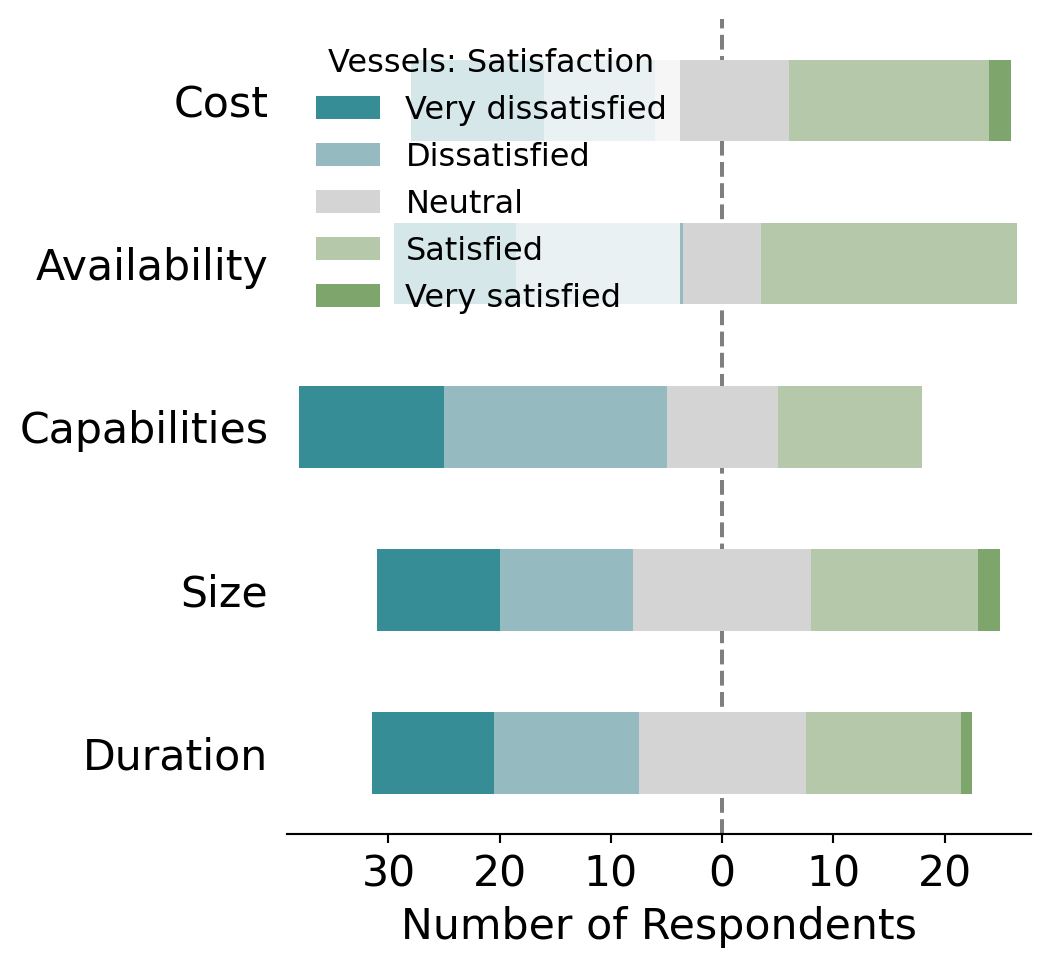

In [85]:
## Create plot

w = 960
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='Vessels: Satisfaction',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='6', letter='M2')

## **Fig M3**&nbsp; Q14a: Vessel cost

In [86]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Very dissatisfied', 
            'Dissatisfied', 
            'Neutral', 
            'Satisfied', 
            'Very satisfied']

cost = {}
fig_data = {}
for region in region_list:
    cost[region] = dataR[region].loc[(dataR[region]['col_name'] == 'Q14_cost') &
                (dataR[region]['selection'] != ''), 
                      ['respondent_id', 'subregion', 'col_name', 'selection']]
    
    fig_data[region] = cost[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({'1 - Very dissatisfied': 'Very dissatisfied',
                      '2 - Dissatisfied': 'Dissatisfied',
                      '3 - Neither satisfied nor dissatisfied': 'Neutral',
                      '4 - Satisfied': 'Satisfied',
                      '5 - Very satisfied': 'Very satisfied'}, inplace=True)

Adding missing column Low income


In [87]:
## Calculate statistics

for region in region_list:
    percent_data = (cost[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = cost[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

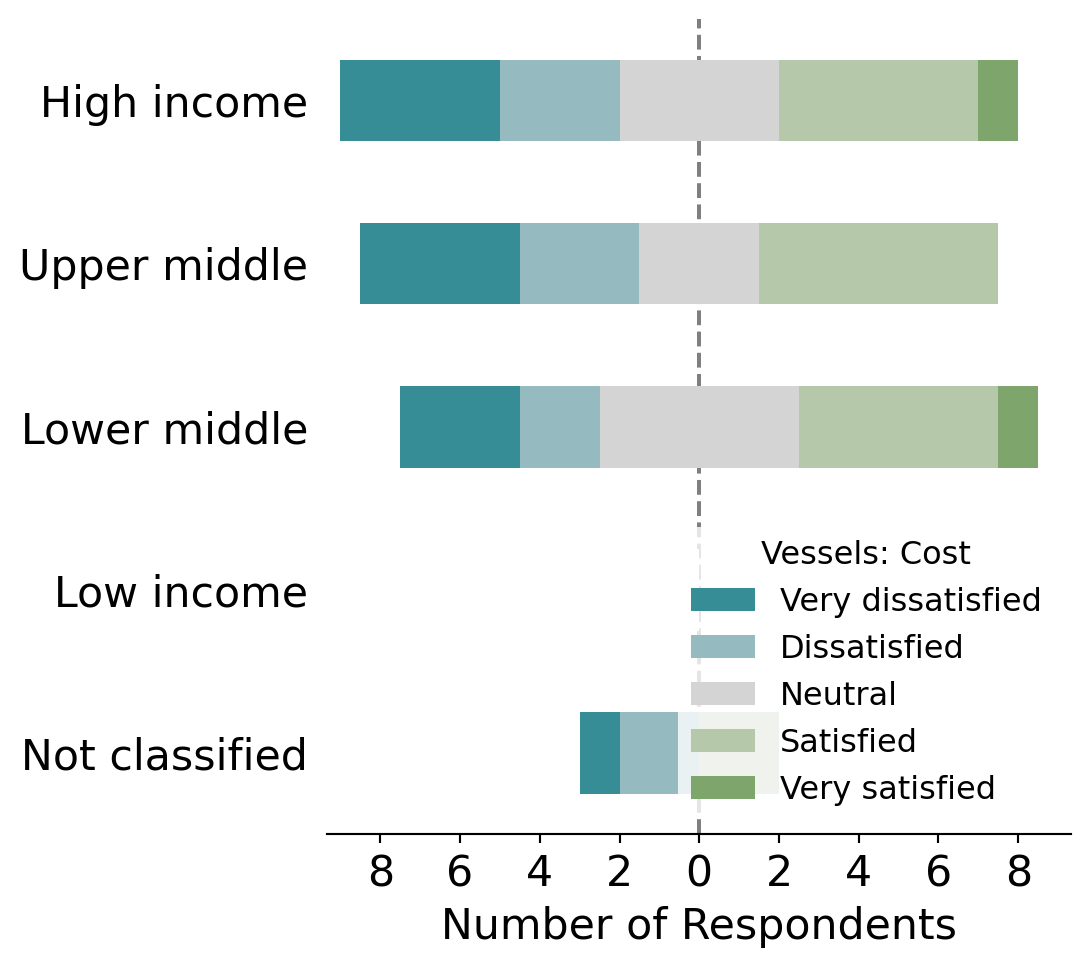

In [88]:
## Create plot

w = 960
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {'Asia': 'lower left', 'Europe': 'upper left', 'Global': 'upper left'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='Vessels: Cost',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='6', letter='M3')

## **Fig M4**&nbsp; Q14b: vessel availability

In [89]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Very dissatisfied', 
            'Dissatisfied', 
            'Neutral', 
            'Satisfied', 
            'Very satisfied']

availability = {}
fig_data = {}
for region in region_list:
    availability[region] = dataR[region].loc[(dataR[region]['col_name'] == 'Q14_availability') &
                    (dataR[region]['selection'] != ''), 
                          ['respondent_id', 'subregion', 'col_name', 'selection']]
    
    fig_data[region] = availability[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({'1 - Very dissatisfied': 'Very dissatisfied',
                      '2 - Dissatisfied': 'Dissatisfied',
                      '3 - Neither satisfied nor dissatisfied': 'Neutral',
                      '4 - Satisfied': 'Satisfied',
                      '5 - Very satisfied': 'Very satisfied'}, inplace=True)

Adding missing column Low income


In [90]:
## Calculate statistics

for region in region_list:
    percent_data = (availability[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = availability[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

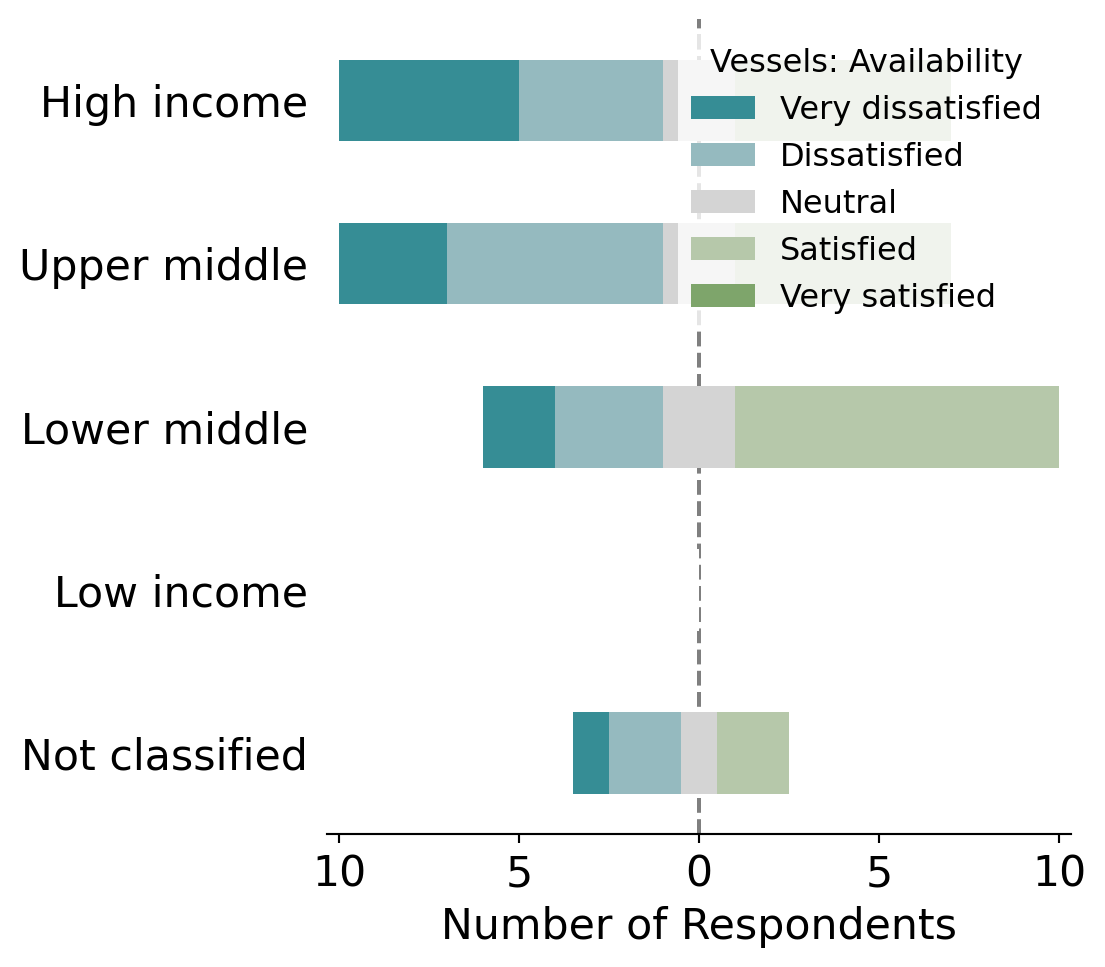

In [91]:
## Create plot

w = 960
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {'Asia': 'lower left', 'Europe': 'upper left'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='Vessels: Availability',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='6', letter='M4')

## **Fig M5**&nbsp; Q14c: Vessel capabilities

In [92]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Very dissatisfied', 
            'Dissatisfied', 
            'Neutral', 
            'Satisfied', 
            'Very satisfied']

capabilities = {}
fig_data = {}
for region in region_list:
    capabilities[region] = dataR[region].loc[(dataR[region]['col_name'] == 'Q14_capabilities') &
                    (dataR[region]['selection'] != ''), 
                          ['respondent_id', 'subregion', 'col_name', 'selection']]

    fig_data[region] = capabilities[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({'1 - Very dissatisfied': 'Very dissatisfied',
                      '2 - Dissatisfied': 'Dissatisfied',
                      '3 - Neither satisfied nor dissatisfied': 'Neutral',
                      '4 - Satisfied': 'Satisfied',
                      '5 - Very satisfied': 'Very satisfied'}, inplace=True)

Adding missing column Low income


In [93]:
## Calculate statistics

for region in region_list:
    percent_data = (capabilities[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = capabilities[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

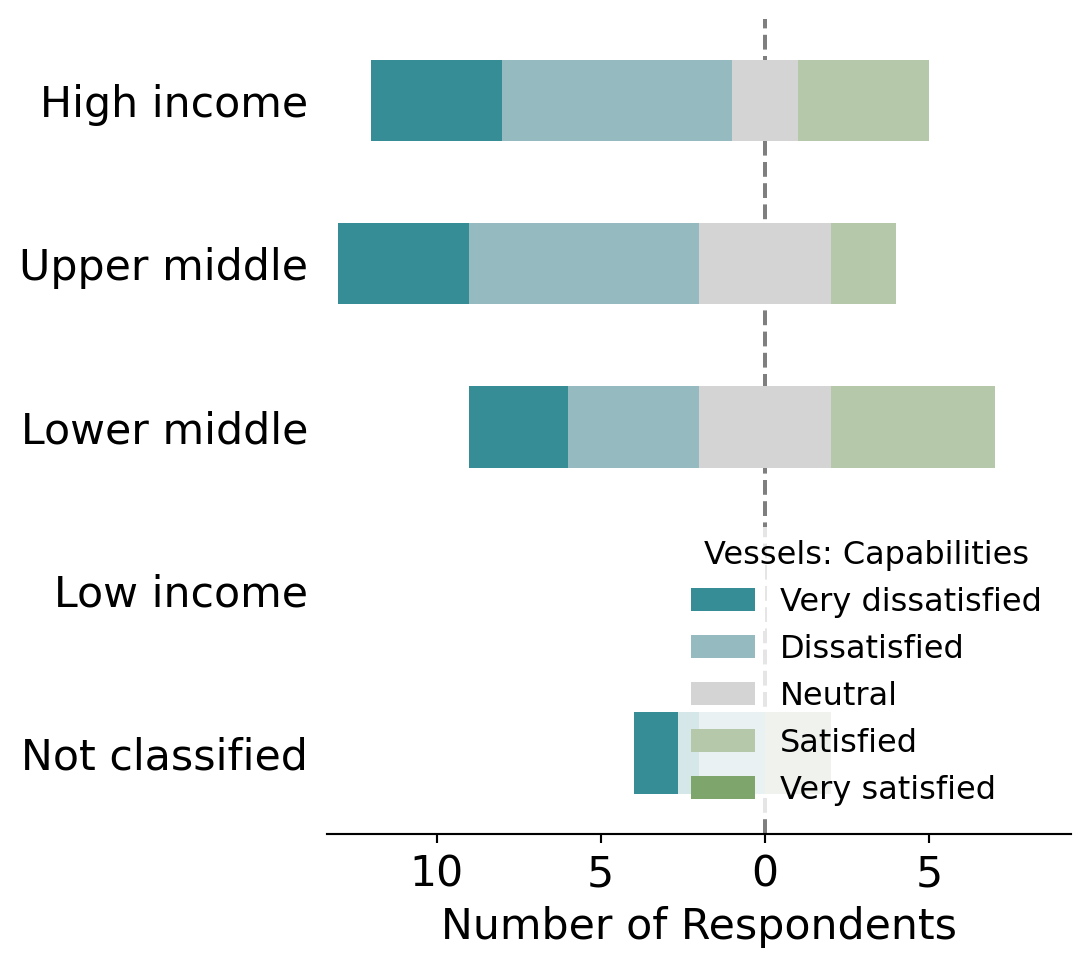

In [94]:
## Create plot

w = 960
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {'Africa': 'lower left', 'Americas': 'lower right', 'Economies': 'lower right', 'Europe': 'upper left', 'Global': 'upper left', 'Oceania': 'upper right', 'SIDS': 'lower right'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='Vessels: Capabilities',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='6', letter='M5')

## **Fig M6**&nbsp; Q14d: Vessel size

In [95]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Very dissatisfied', 
            'Dissatisfied', 
            'Neutral', 
            'Satisfied', 
            'Very satisfied']

size = {}
fig_data = {}
for region in region_list:
    size[region] = dataR[region].loc[(dataR[region]['col_name'] == 'Q14_size') &
                    (dataR[region]['selection'] != ''), 
                          ['respondent_id', 'subregion', 'col_name', 'selection']]

    fig_data[region] = size[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({'1 - Very dissatisfied': 'Very dissatisfied',
                      '2 - Dissatisfied': 'Dissatisfied',
                      '3 - Neither satisfied nor dissatisfied': 'Neutral',
                      '4 - Satisfied': 'Satisfied',
                      '5 - Very satisfied': 'Very satisfied'}, inplace=True)

Adding missing column Low income


In [96]:
## Calculate statistics

for region in region_list:
    percent_data = (size[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = size[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

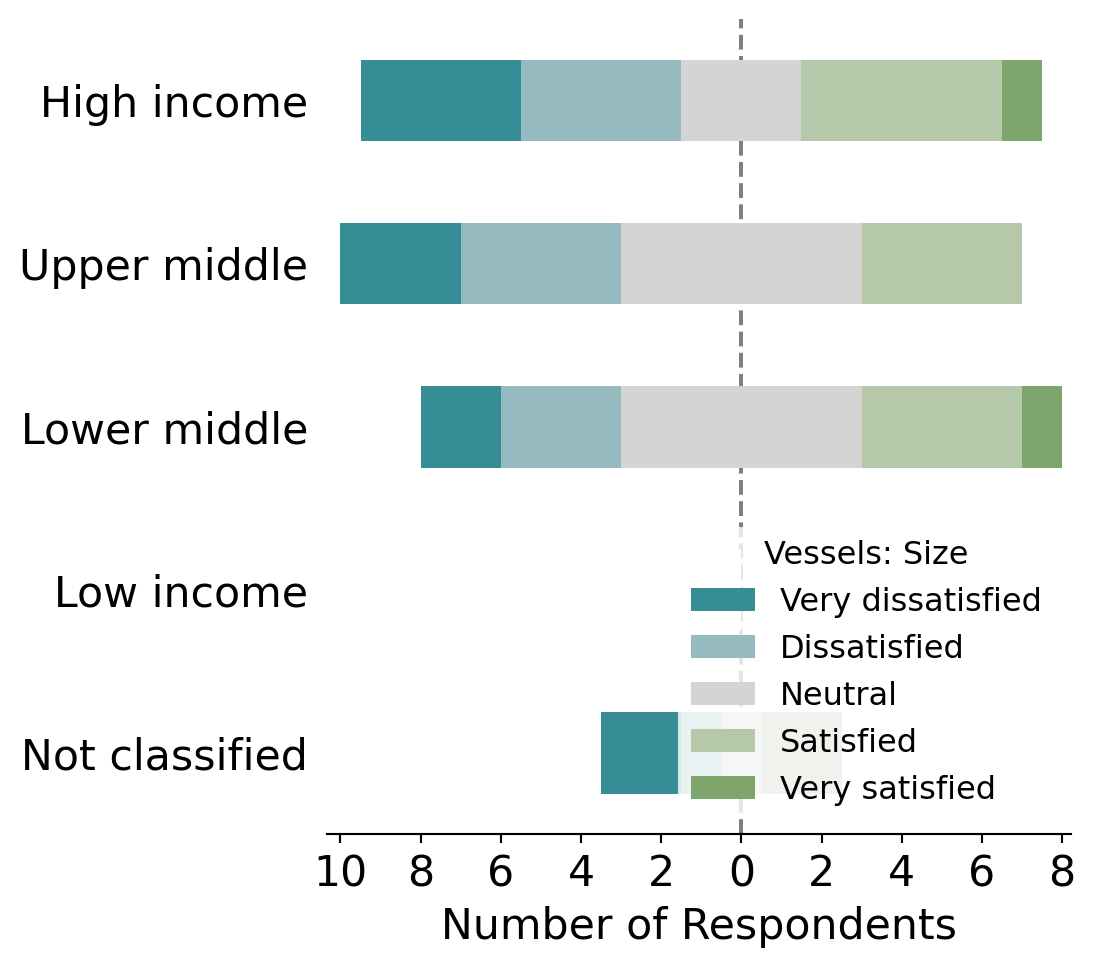

In [97]:
## Create plot

w = 960
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {'Africa': 'lower right', 'Americas': 'lower right', 'Asia': 'lower left', 'Economies': 'lower right', 'Europe': 'upper left', 'Global': 'upper left', 'Oceania': 'upper left', 'SIDS': 'lower right'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='Vessels: Size',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='6', letter='M6')

## **Fig M7**&nbsp; Q14e: Vessel duration

In [98]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Very dissatisfied', 
            'Dissatisfied', 
            'Neutral', 
            'Satisfied', 
            'Very satisfied']

duration = {}
fig_data = {}
for region in region_list:
    duration[region] = dataR[region].loc[(dataR[region]['col_name'] == 'Q14_duration') &
                    (dataR[region]['selection'] != ''), 
                          ['respondent_id', 'subregion', 'col_name', 'selection']]

    fig_data[region] = duration[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({'1 - Very dissatisfied': 'Very dissatisfied',
                      '2 - Dissatisfied': 'Dissatisfied',
                      '3 - Neither satisfied nor dissatisfied': 'Neutral',
                      '4 - Satisfied': 'Satisfied',
                      '5 - Very satisfied': 'Very satisfied'}, inplace=True)

Adding missing column Low income


In [99]:
## Calculate statistics

for region in region_list:
    percent_data = (duration[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = duration[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

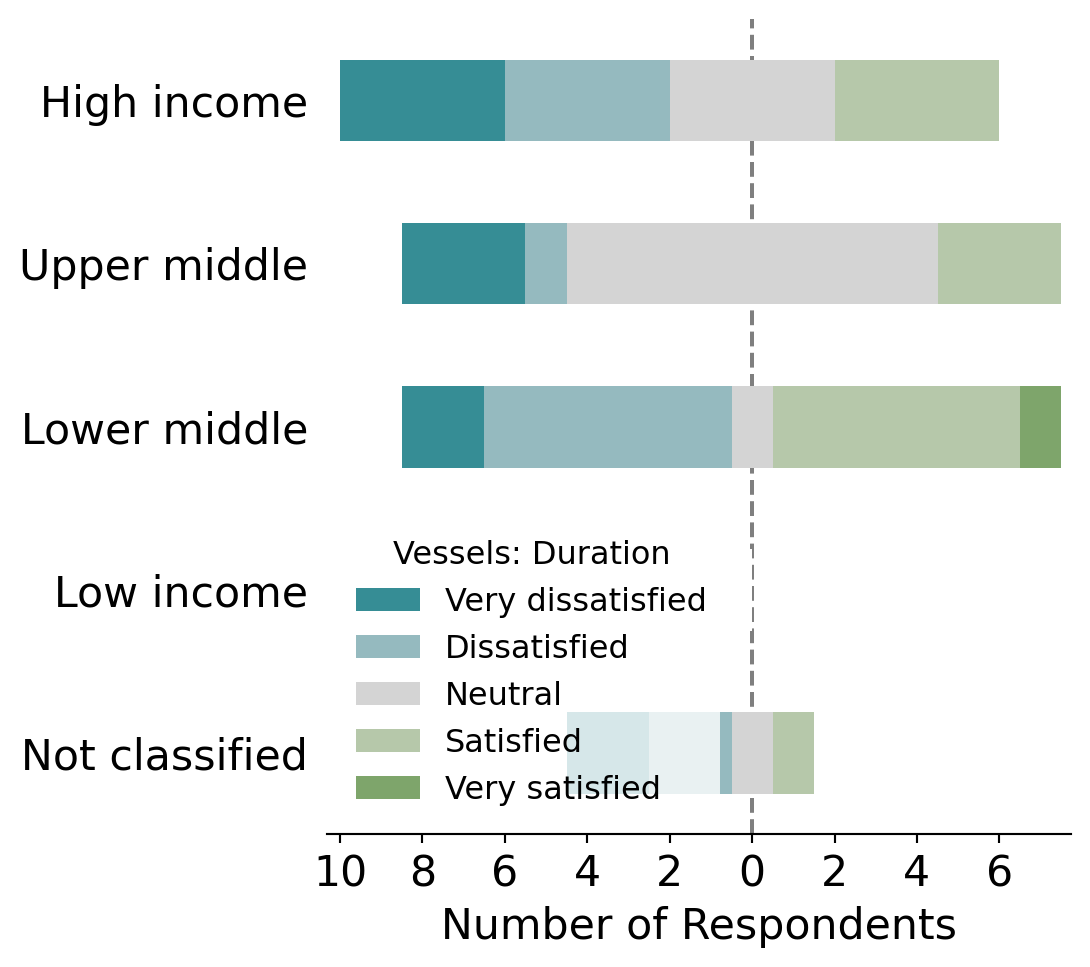

In [100]:
## Create plot

w = 960
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {'Asia': 'lower left', 'Europe': 'upper left', 'Oceania': 'upper left'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='Vessels: Duration',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='6', letter='M7')

## **Fig N1**&nbsp; Q11: Vessel importance

In [101]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Not important', 
            'A little important', 
            'Somewhat important',
            'Important',
            'Very important']

importance = {}
fig_data = {}
for region in region_list:
    importance[region] = dataR[region].loc[(dataR[region]['question'] == 'Q11'), ['respondent_id', 'subregion', 'col_name', 'selection']]

    fig_data[region] = importance[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({'1 - Not important': 'Not important',
                      '2 - A little important': 'A little important',
                      '3 - Somewhat important': 'Somewhat important',
                      '4 - Important': 'Important',
                      '5 - Very important': 'Very important'}, inplace=True)

Adding missing column Low income


In [102]:
## Calculate statistics

for region in region_list:
    percent_data = (importance[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = importance[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

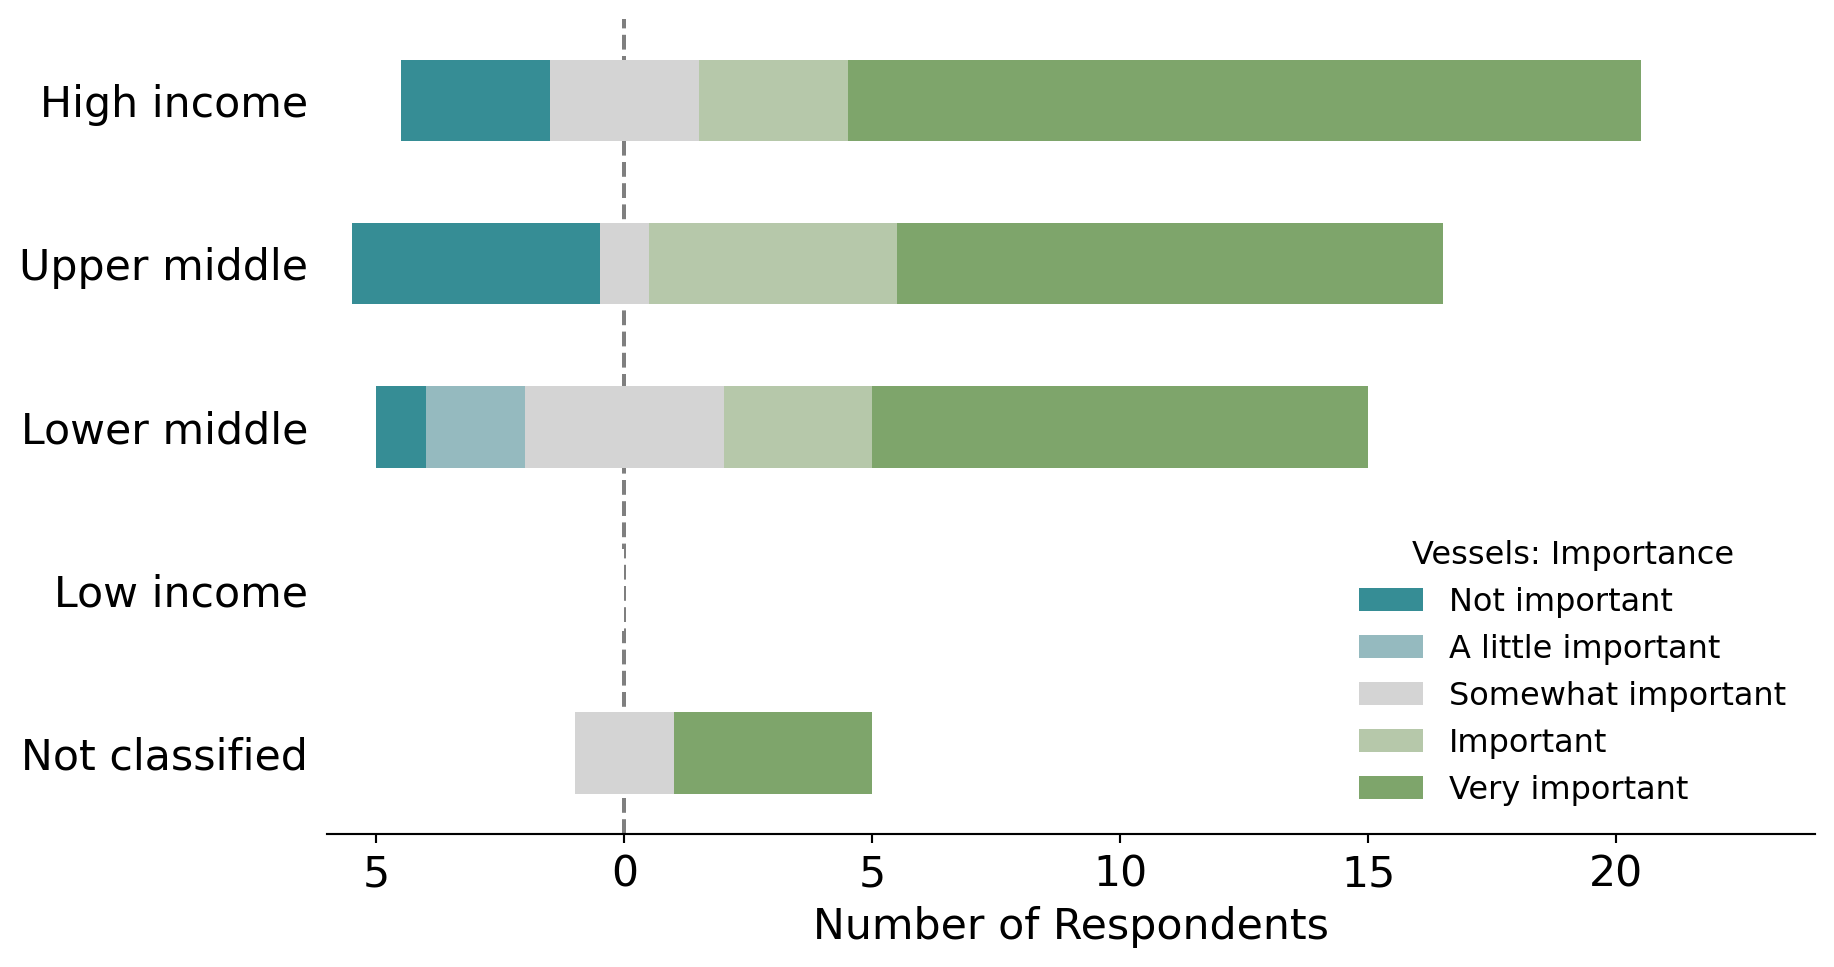

In [103]:
## Create plot

w = 1920
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {'Africa': 'lower right', 'Europe': 'upper right', 'Global': 'upper right', 'Oceania': 'upper right'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='Vessels: Importance',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='6', letter='N1')

## **Fig N2**&nbsp; Q15: Vessel potential

In [104]:
## Calculate values for plot

# Define scale for plot
my_scale = ['No impact', 
            'Little impact', 
            'Moderate impact',
            'High impact',
            'Transformative']

potential = {}
fig_data = {}
for region in region_list:
    potential[region] = dataR[region].loc[(dataR[region]['question'] == 'Q15'), ['respondent_id', 'subregion', 'col_name', 'selection']]

    fig_data[region] = potential[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')
    
    # Change scale values
    fig_data[region].replace({'1 - No impact': 'No impact',
                      '2 - Little impact': 'Little impact',
                      '3 - Moderate impact': 'Moderate impact',
                      '4 - High impact': 'High impact',
                      '5 - Transformative': 'Transformative'}, inplace=True)

Adding missing column Low income


In [105]:
## Calculate statistics

for region in region_list:
    percent_data = (potential[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = potential[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

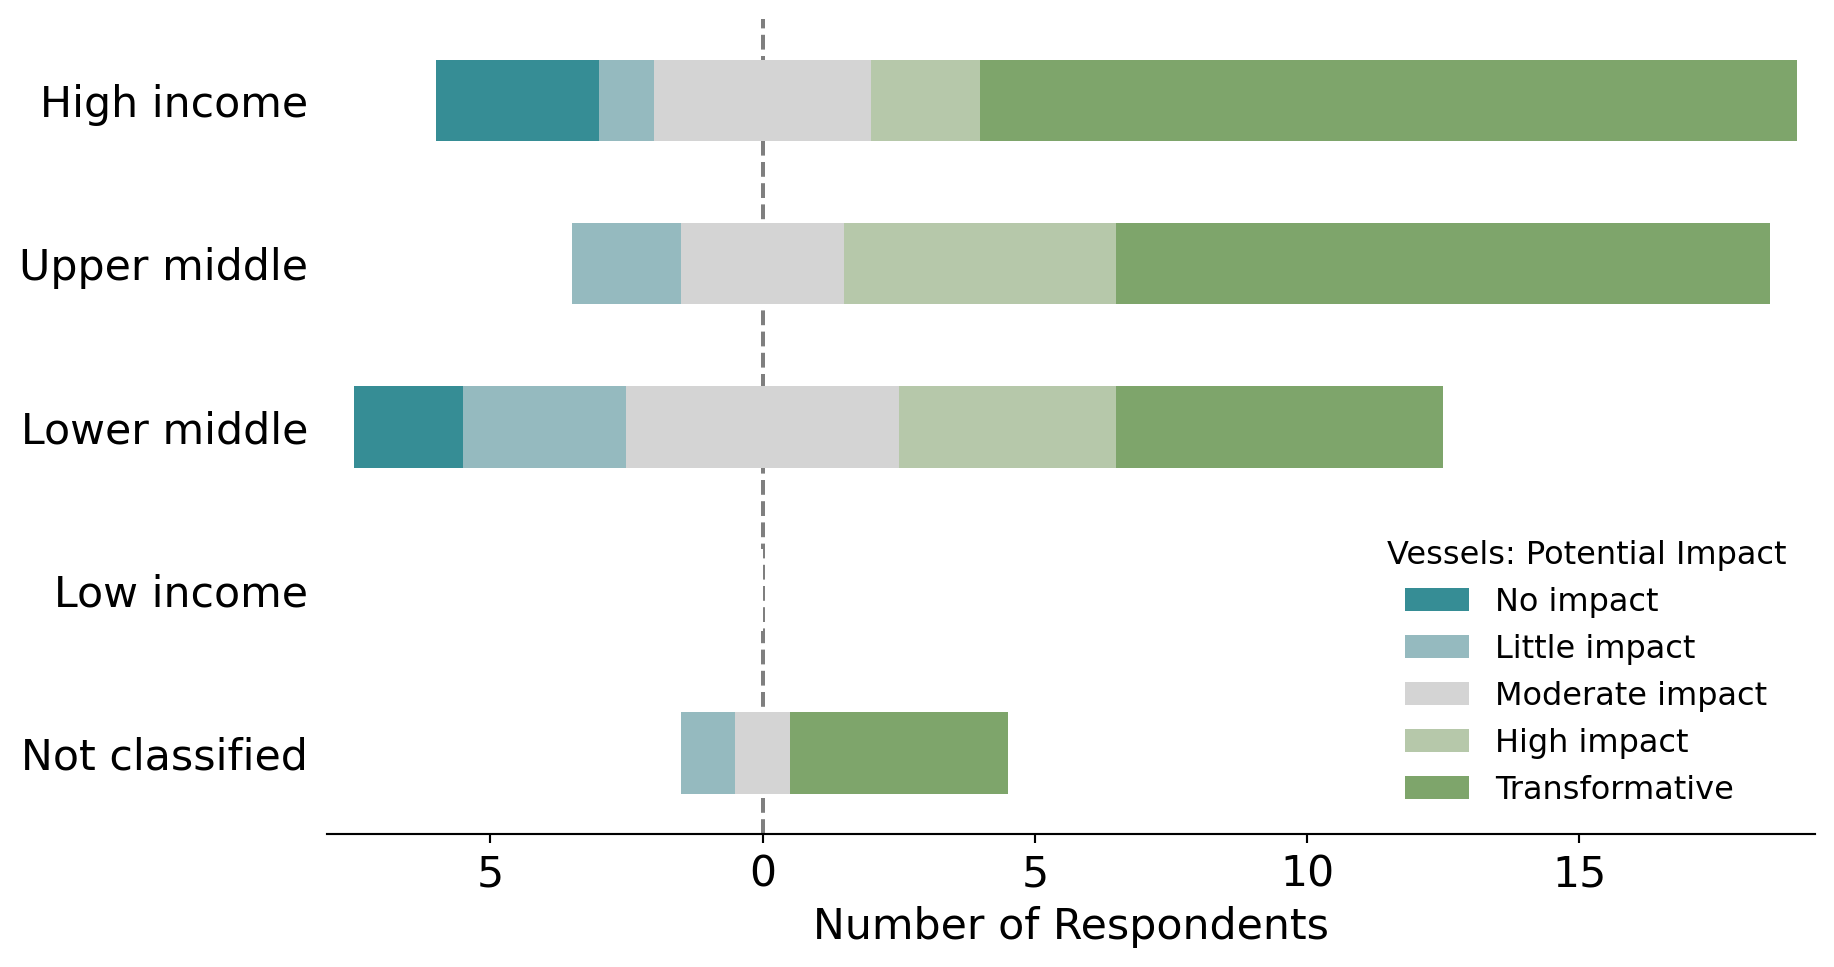

In [106]:
## Create plot

w = 1920
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='Vessels: Potential Impact',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='6', letter='N2')

---
# **Section 7**

## **Figs O1 O2**&nbsp; DSV presence

In [107]:
## Calculate values for plot

label_order = {}
fig_data = {}
for region in region_list:
    dsv_presence = researchR[region].loc[(researchR[region]['question'] == 'Q18') &
                               (researchR[region]['col_name'] != 'Q18_comments'), ['geoarea',
                                                                          'col_name',
                                                                          'subregion',                    
                                                                          'research_tech_clean']]
    dsv_presence['selection_binary'] = dsv_presence['research_tech_clean']

    fig_data[region] = (dsv_presence.groupby(['subregion', 'col_name'])['selection_binary']
                    .sum()
                    .rename('count')
                    .reset_index())

    num_areas_per_subregion = dsv_presence.groupby('subregion')['geoarea'].nunique()
    num_areas_dict = dict(zip(num_areas_per_subregion.index, num_areas_per_subregion.values))
    fig_data[region]['total'] = fig_data[region]['subregion']
    fig_data[region]['total'].replace(num_areas_dict, inplace=True)

    fig_data[region]['percent'] = round((fig_data[region]['count']/fig_data[region]['total'])*100, 2)

    renames = {
        'Q18_rov':       'ROVs',
        'Q18_auv':       'AUVs',
        'Q18_bruv':      'Landers',
        'Q18_drifters':  'Drifters',
        'Q18_tow_sleds': 'Towsleds',
        'Q18_hov':       'HOVs',
    }
    hue_order = renames.values()
    fig_data[region]['col_name'].replace(renames, inplace=True)
    fig_data[region]['subregion'].replace(label_adjustments, inplace=True)
    label_order[region] = []
    for x in orderR[region]:
        if x in label_adjustments:
            label_order[region].append(label_adjustments[x])
        else:
            label_order[region].append(x)

    pivoted = fig_data[region].pivot(columns='col_name', index='subregion', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()
    total_yes_in_region = pivoted.loc['Total', ('count', 'auv'):('count', 'tow')].sum()
    pivoted.loc['Total', ('percent', 'auv'):('percent', 'tow')] = \
        ((pivoted.loc['Total', ('count', 'auv'):('count', 'tow')]/total_yes_in_region).values)*100

    #display(round(pivoted, 2))
    
    ## Names of GeoAreas with all types present
    num_types = (dsv_presence
                     .groupby(['subregion', 'geoarea'])['selection_binary']
                     .sum()
                     .rename('num_types')
                     .reset_index())
    #display(num_types[num_types['num_types'] == num_types['num_types'].max()])
    
    ## Names of GeoAreas with fewest types present
    #display(num_types[num_types['num_types'] == num_types['num_types'].min()])
    
    ## % of areas in region that have all types
    num_types = (dsv_presence.groupby(['subregion', 'geoarea'])['selection_binary']
                     .sum()
                     .rename('num_types')
                     .reset_index())
    #display(round((num_types[num_types['num_types'] == 6].shape[0]/num_types.shape[0])*100, 2))

    ## % of areas in region with < 3 types
    #display(round((num_types[num_types['num_types'] < 3].shape[0]/num_types.shape[0])*100, 2))

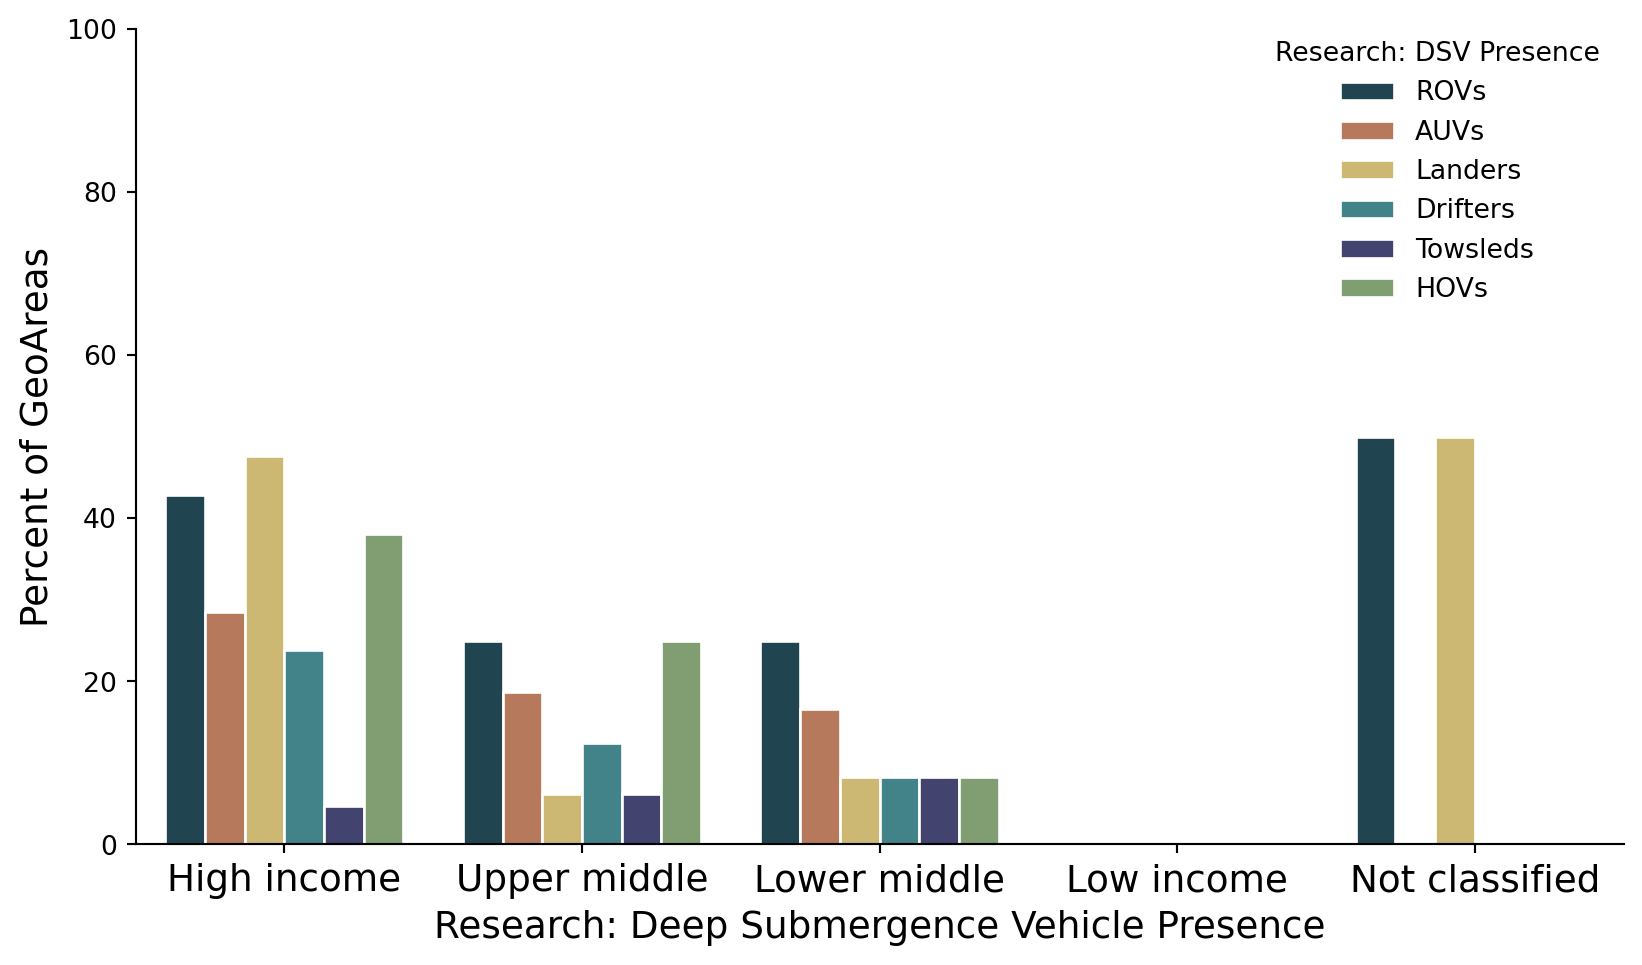

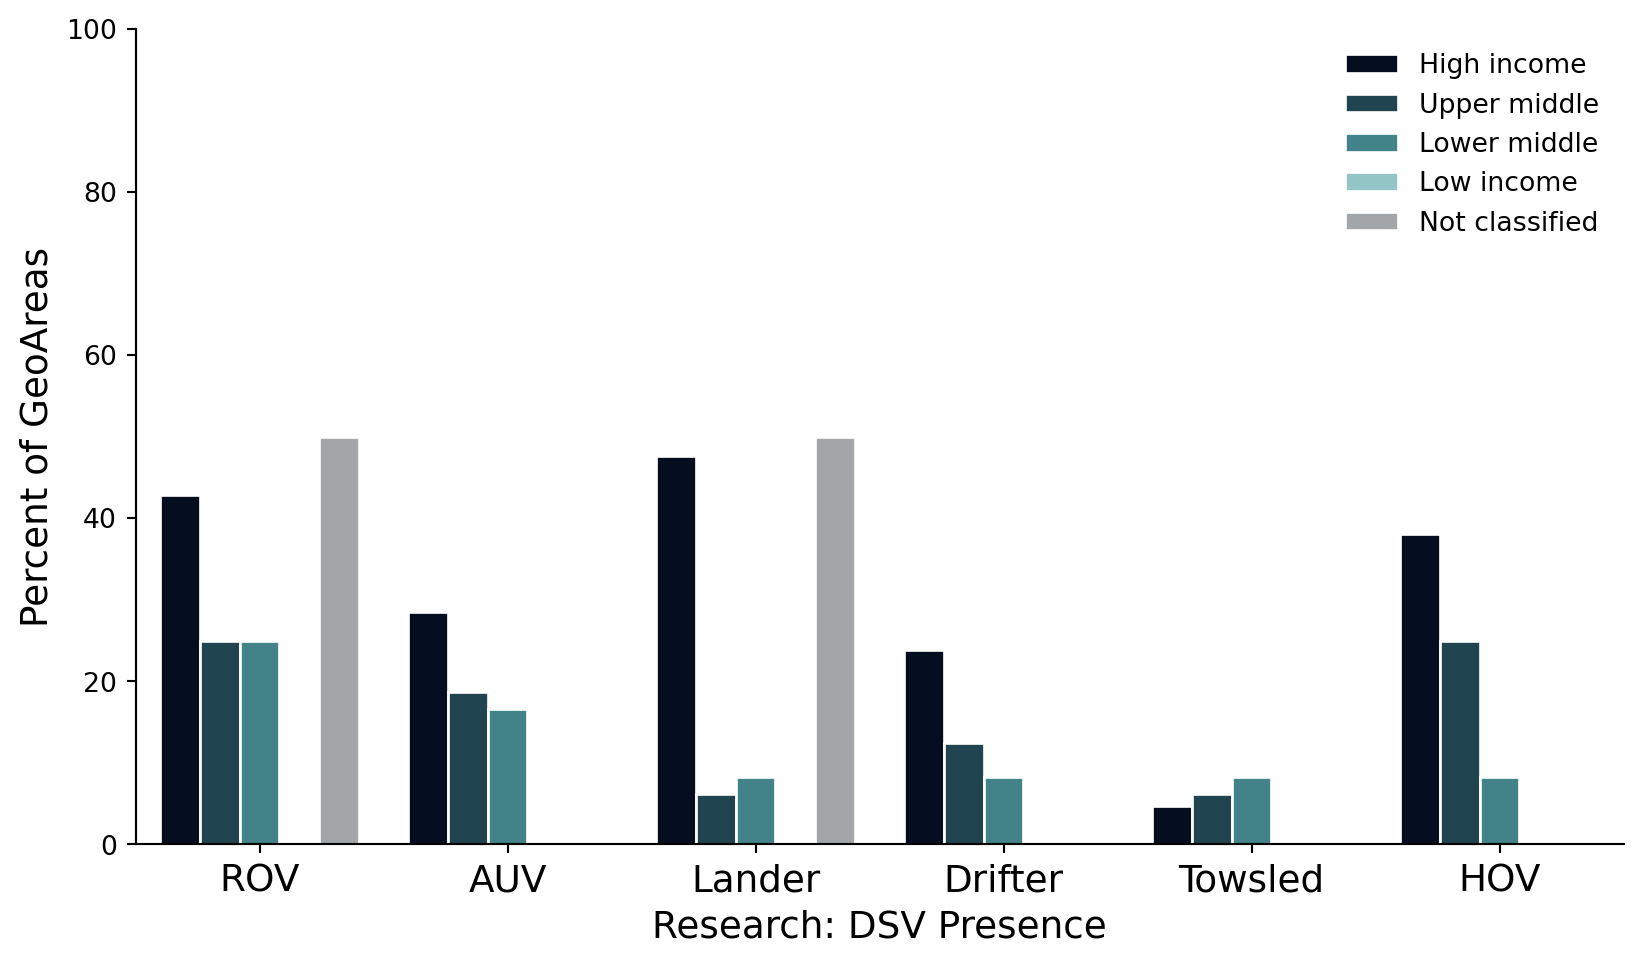

In [108]:
## Create plot

w = 1920
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
    ax = sns.barplot(x='subregion',
                     y='percent',
                     hue='col_name',
                     order=label_order[region],
                     hue_order=hue_order,
                     palette=cat_06,
                     edgecolor='white',
                     ci=None,
                     data=fig_data[region])            

    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=14)
    ax.set_xlabel('Research: Deep Submergence Vehicle Presence', fontsize=14)
    ax.set_ylim([0, 100])
    ax.set_ylabel('Percent of GeoAreas', fontsize=14)
    loc_tweaks = {'Africa': 'upper left'}
    ax.legend(bbox_to_anchor=(1, 1.015),
              loc=loc_tweaker(region, loc_tweaks),
              title='Research: DSV Presence',
              fontsize=10,
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='7', letter='O1')

    ## O2

    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
    ax = sns.barplot(x='col_name',
                     y='percent',
                     hue='subregion',
                     order=hue_order,
                     hue_order=label_order[region],
                     palette=cat_d23e123_by_region[region],
                     edgecolor='white',
                     ci=None,
                     data=fig_data[region])            

    ax.set_xticklabels(['ROV', 'AUV', 'Lander', 'Drifter', 'Towsled', 'HOV'], rotation=0, fontsize=14)
    ax.set(xlabel=None)
    ax.set_ylim([0, 100])
    ax.set_xlabel('Research: DSV Presence', fontsize=14)
    ax.set_ylabel('Percent of GeoAreas', fontsize=14)
    loc_tweaks = {'Africa': 'upper left'}
    ax.legend(loc='upper right',
              fontsize=10,
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='7', letter='O2')

## **Figs P1 P1b**&nbsp; Q18: DSV Access

In [109]:
## Get data for figure - using num respondents for aggregated calculations & denominators

label_order = {}
percent_dataR = {}
for region in region_list:
    vessels = dataR[region].loc[dataR[region]['question'] == 'Q18', ['subregion', 
                                                   'geoarea', 
                                                   'respondent_id', 
                                                   'selection_survey_clean']]

    vessels = vessels[vessels['selection_survey_clean'] != '']

    fig_data = (vessels.groupby(['subregion', 'selection_survey_clean'])['respondent_id']
                       .nunique()
                       .rename('count')
                       .reset_index())

    renames = {
        'Remotely Operated Vehicles (ROVs)':               'ROVs',
        'Autonomous Underwater Vehicles (AUVs)':           'AUVs',
        'Landers/Benthic Remote Underwater Video (BRUVs)': 'Landers',
        'Drifters':                                        'Drifters',
        'Tow sleds':                                       'Towsleds',
        'Submersibles/Human Occupied Vehicles (HOVs)':     'HOVs',
        'Other':                                           'Other',
        'None of the above':                               'None of the above',
    }
    hue_order = renames.values()
    fig_data['selection_survey_clean'].replace(renames, inplace=True)
    fig_data['subregion'].replace(label_adjustments, inplace=True)
    vessels['subregion'].replace(label_adjustments, inplace=True)
    label_order[region] = []
    for x in orderR[region]:
        if x in label_adjustments:
            label_order[region].append(label_adjustments[x])
        else:
            label_order[region].append(x)

    # Calculate percentages
    percent_data = fig_data.copy()
    num_respondents_per_subregion = vessels.groupby('subregion')['respondent_id'].nunique().reset_index()
    respondent_sub_dict = dict(zip(num_respondents_per_subregion['subregion'], 
                                   num_respondents_per_subregion['respondent_id']))
    percent_data['total'] = percent_data['subregion']
    percent_data['total'].replace(respondent_sub_dict, inplace=True)
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection_survey_clean', values=['count', 'percent'])
    pivoted.loc['Total'] = num_respondents_per_subregion['respondent_id'].tolist()*2
    num_respondents = vessels['respondent_id'].nunique()
    pivoted.loc['Total', 'percent'] = round((pivoted.loc['Total', 'percent']/num_respondents)*100, 2).values

    pivoted[('count', 'Total')] = pivoted['count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_respondents)*100, 2)

    #display(pivoted)
    
    percent_dataR[region] = percent_data

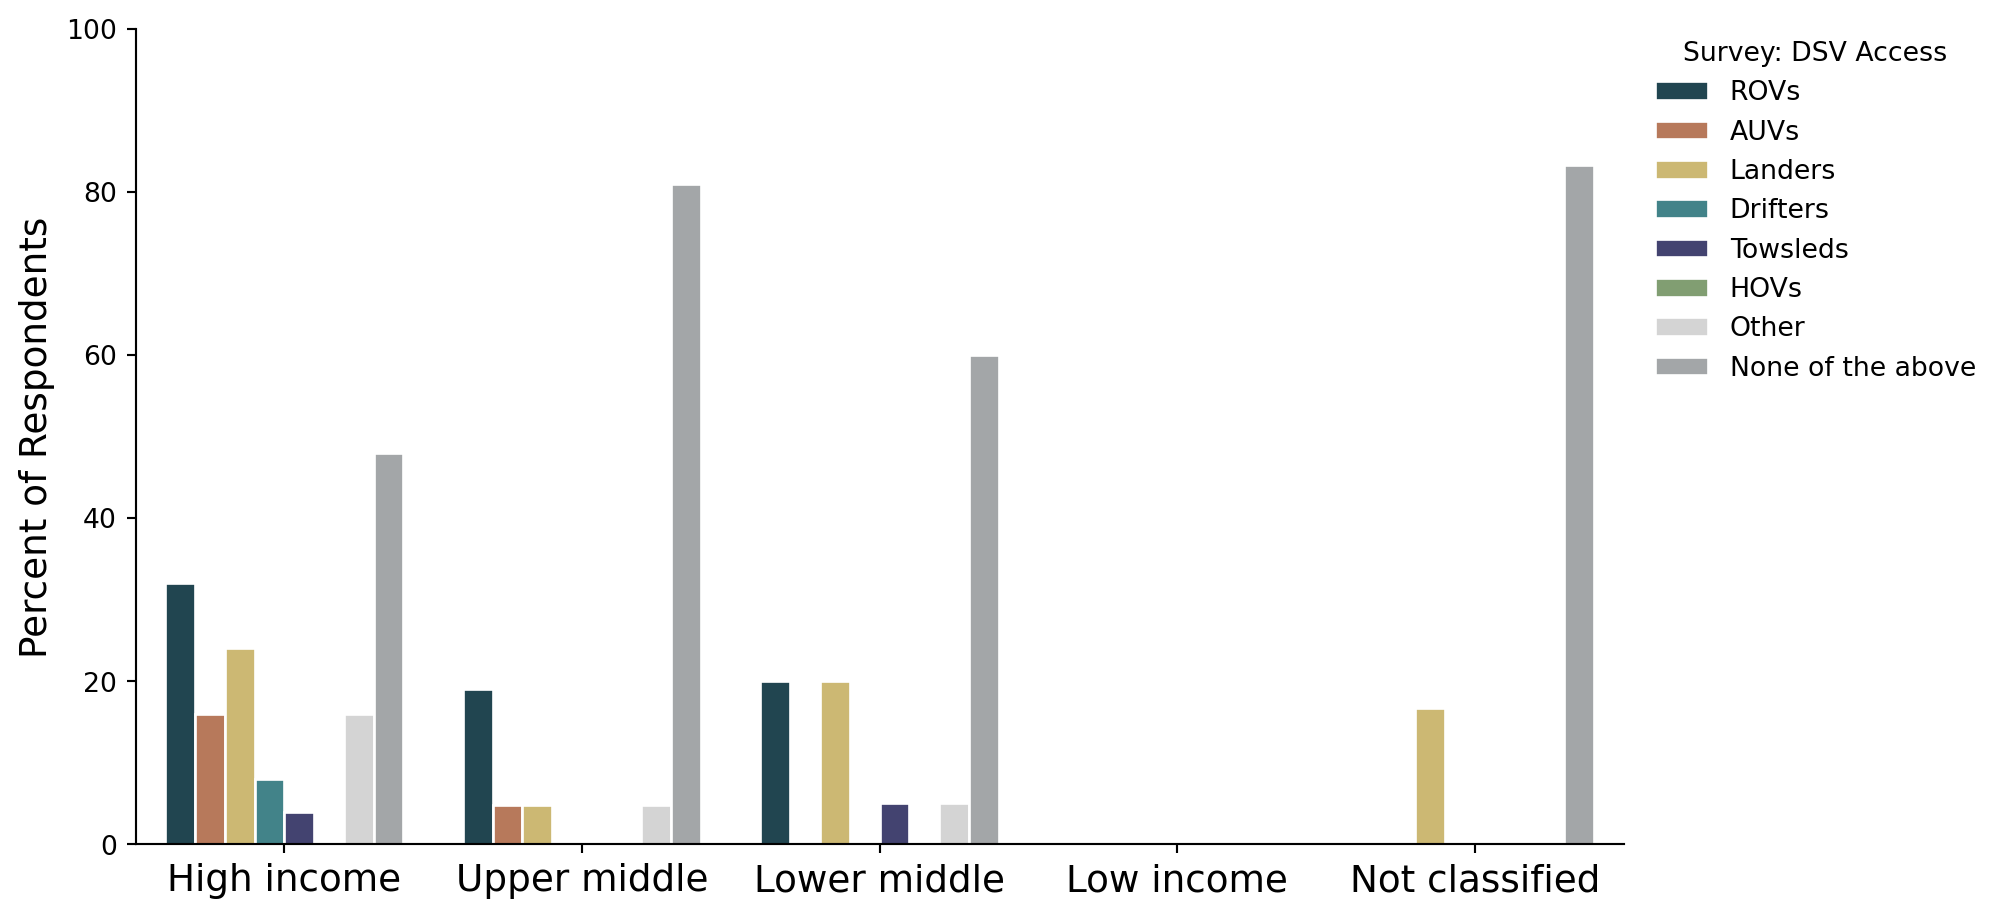

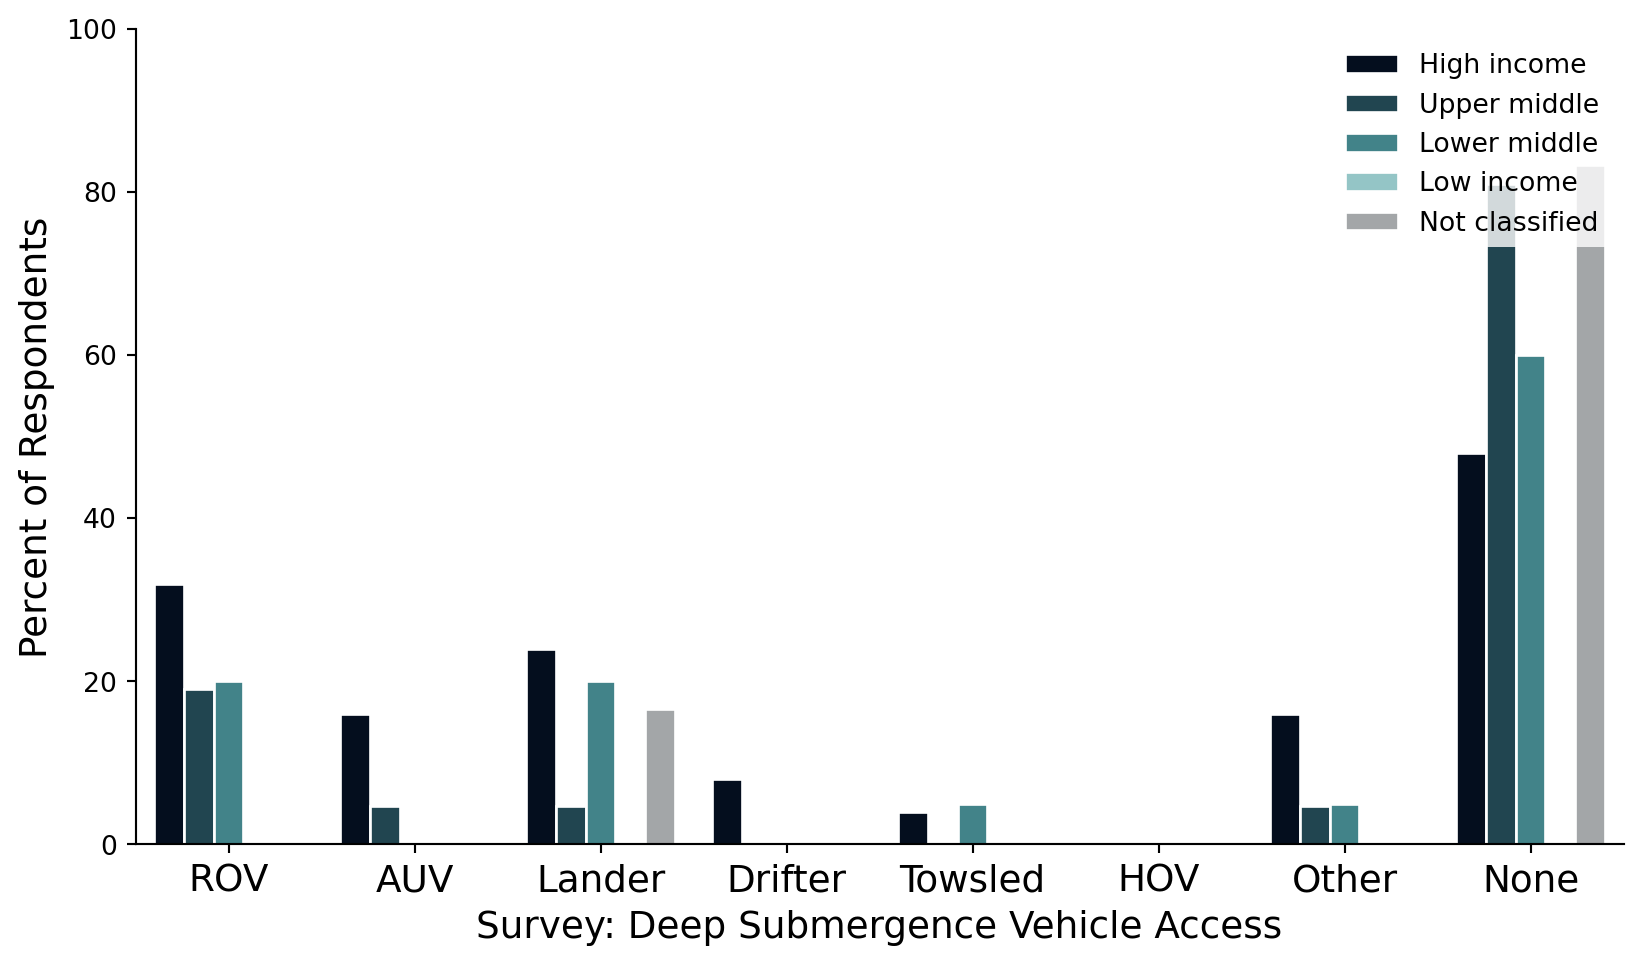

In [110]:
## Create plot

w = 1920
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
    ax = sns.barplot(x='subregion',
                     y='percent',
                     hue='selection_survey_clean',
                     order=label_order[region],
                     hue_order=hue_order,
                     palette=cat_06 + ['#a2a6a9'],
                     edgecolor='white',
                     ci=None,
                     data=percent_dataR[region])            

    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=14)
    ax.set(xlabel=None)
    ax.set_ylim([0, 100])
    ax.set_ylabel('Percent of Respondents', fontsize=14)
    ax.legend(bbox_to_anchor=(1.005, 1.015), loc='upper left',
              title='Survey: DSV Access',
              fontsize=10,
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='7', letter='P1')
    
    ## P1b

    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
    ax = sns.barplot(x='selection_survey_clean',
                     y='percent',
                     hue='subregion',
                     order=hue_order,
                     hue_order=label_order[region],
                     palette=cat_d23e123_by_region[region],
                     edgecolor='white',
                     ci=None,
                     data=percent_dataR[region])            

    ax.set_xticklabels(['ROV', 'AUV', 'Lander', 'Drifter', 'Towsled', 'HOV', 'Other', 'None'], rotation=0, fontsize=14)
    ax.set_xlabel('Survey: Deep Submergence Vehicle Access', fontsize=14)
    ax.set_ylim([0, 100])
    ax.set_ylabel('Percent of Respondents', fontsize=14)
    ax.legend(loc='upper right',
              fontsize=10,
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='7', letter='P1b')

## **Fig P2**&nbsp; Q19: DSV depth (ROVs)

In [111]:
## Get data for figure

fig_data = {}
for region in region_list:
    depth = dataR[region].loc[dataR[region]['question'] == 'Q19', ['col_name', 
                                                   'subregion', 
                                                   'geoarea',
                                                   'respondent_id', 
                                                   'selection_survey_clean']].copy()
    depth.loc[(depth['col_name'] == 'Q19_other') & (depth['selection_survey_clean'] != ''), 'selection_survey_clean'] = 'Other'
    depth.loc[(depth['col_name'] != 'Q19_other') & (depth['selection_survey_clean'] == ''), ['selection_survey_clean']] = 'N/A'

    depth = depth[depth['selection_survey_clean'] != '']

    ## Select rovs
    rov_tow = depth.loc[depth['col_name'].isin(['Q19_rov'])].copy()

    fig_data[region] = (rov_tow.groupby(['subregion', 'selection_survey_clean'])['respondent_id']
                       .count()
                       .rename('count')
                       .reset_index())

    percent_data = fig_data[region].copy()
    fig_data[region] = fig_data[region].pivot(columns='selection_survey_clean', index='subregion', values='count')

    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, barh=True)
    
    col_order = ['4000+ m', '2000 - 4000 m', '1000 - 2000 m', '200 - 1000 m', '0 - 200 m', 'NR']
    fig_data[region] = reorder_columns(fig_data[region], col_order, createmissingcolumns=True)

    # Calculate percentages
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection_survey_clean', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = rov_tow.shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

Adding missing row Low income
Adding missing column 4000+ m
Adding missing column 1000 - 2000 m


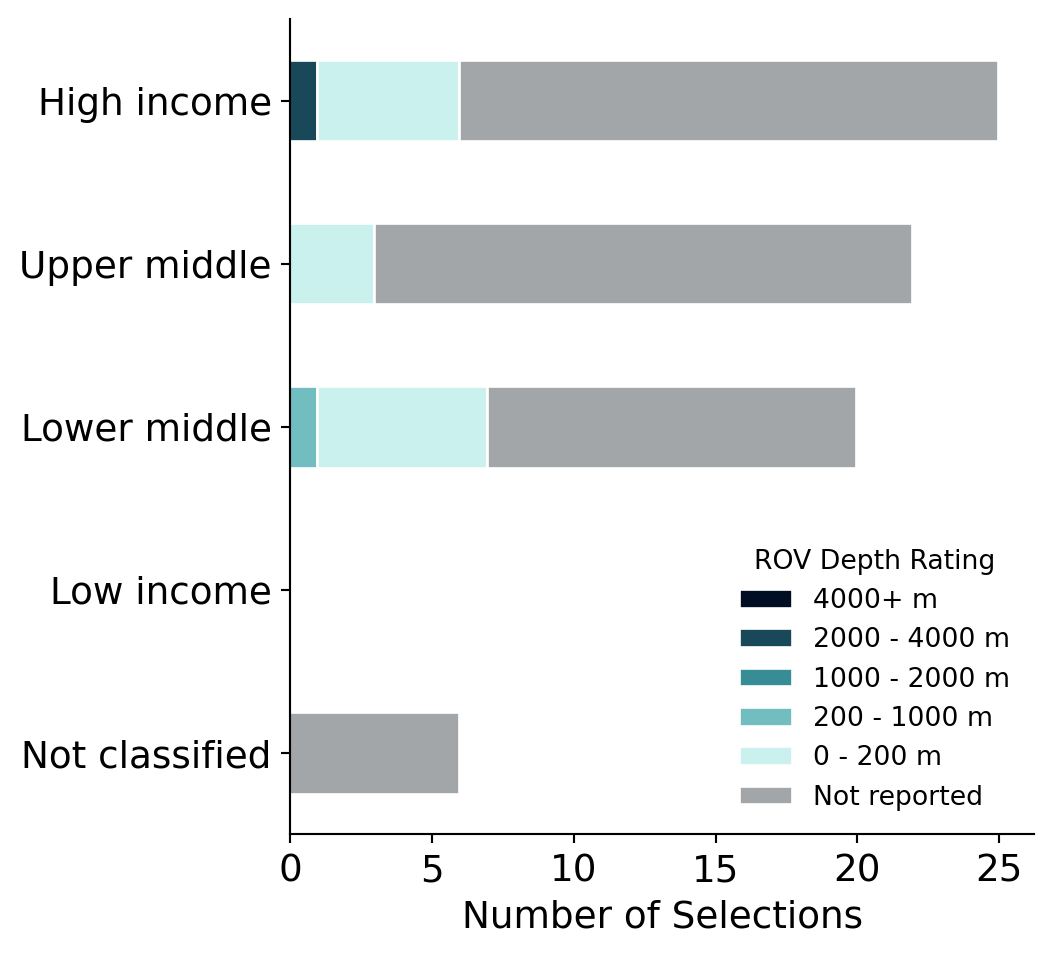

In [112]:
## Create horizontal bar plot

w = 960
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)

    fig_data[region].plot(kind='barh', 
                  stacked=True,
                  legend=True,
                  fontsize=14,
                  color=val_05,
                  edgecolor='white',
                  ax=ax)
    ax.set_xlabel('Number of Selections', fontsize=14)
    barh_pixel_fix(ax)
    ax.set_ylabel('')
    loc_tweaks = {'Africa': 'center right'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              labels=['4000+ m',
                      '2000 - 4000 m',
                      '1000 - 2000 m',
                      '200 - 1000 m',
                      '0 - 200 m',
                      'Not reported'], 
              title='ROV Depth Rating', 
              fontsize=10, 
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='7', letter='P2')

## **Fig P3**&nbsp; Q19: DSV depth (Towsleds)

In [113]:
## Get data for figure

depth = {}  # also used in next figure
fig_data = {}
for region in region_list:
    depth[region] = dataR[region].loc[dataR[region]['question'] == 'Q19', ['col_name', 
                                                   'subregion', 
                                                   'geoarea', 
                                                   'respondent_id', 
                                                   'selection_survey_clean']]
    depth[region].loc[(depth[region]['col_name'] == 'Q19_other') & (depth[region]['selection_survey_clean'] != ''), 'selection_survey_clean'] = 'Other'
    depth[region].loc[(depth[region]['col_name'] != 'Q19_other') & (depth[region]['selection_survey_clean'] == ''), ['selection_survey_clean']] = 'N/A'

    depth[region] = depth[region][depth[region]['selection_survey_clean'] != '']

    ## Select towsleds
    rov_tow = depth[region].loc[depth[region]['col_name'].isin(['Q19_tow_sleds'])].copy()

    fig_data[region] = (rov_tow.groupby(['subregion', 'selection_survey_clean'])['respondent_id']
                       .count()
                       .rename('count')
                       .reset_index())

    percent_data = fig_data[region].copy()
    fig_data[region] = fig_data[region].pivot(columns='selection_survey_clean', index='subregion', values='count')

    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, barh=True)
    
    col_order = ['4000+ m', '2000 - 4000 m', '1000 - 2000 m', '200 - 1000 m', '0 - 200 m', 'NR']
    fig_data[region] = reorder_columns(fig_data[region], col_order, createmissingcolumns=True)

    # Calculate percentages
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection_survey_clean', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = rov_tow.shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

Adding missing row Low income
Adding missing column 4000+ m
Adding missing column 1000 - 2000 m


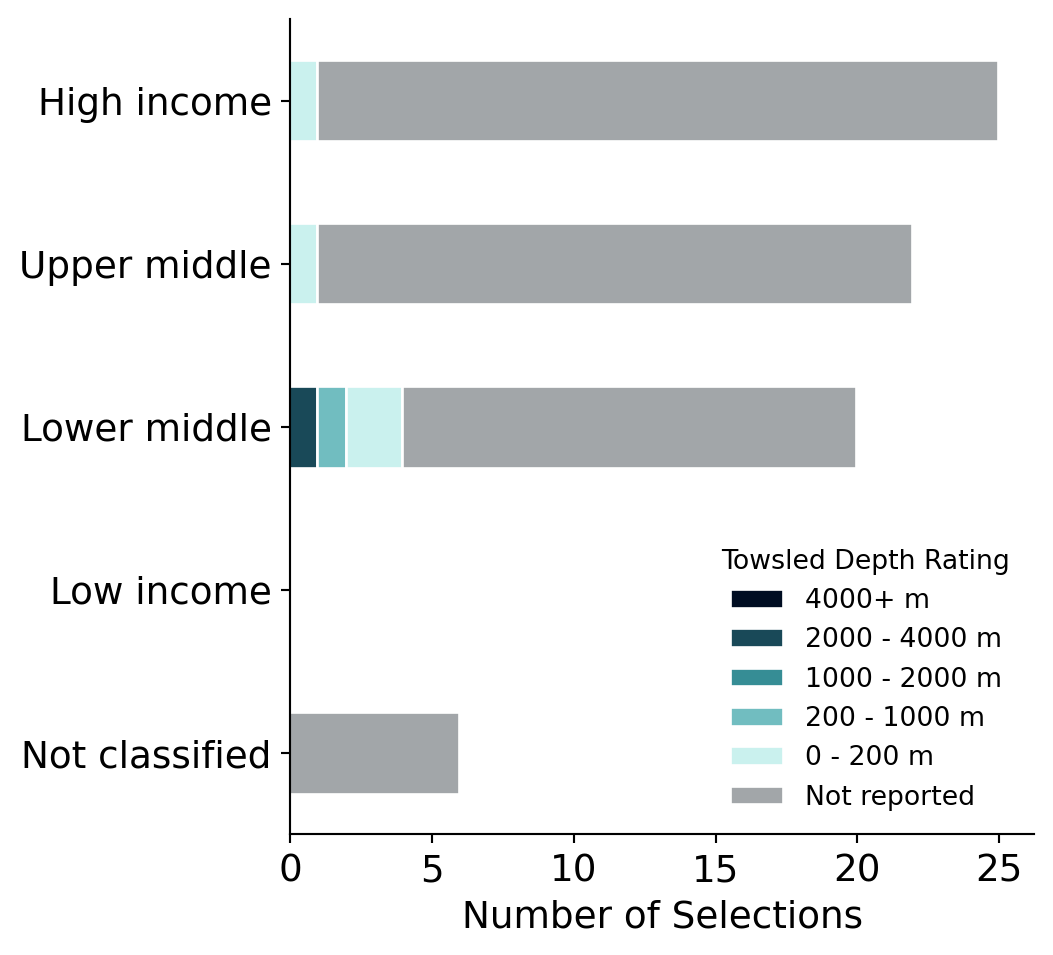

In [114]:
## Create horizontal bar plot

w = 960
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)

    fig_data[region].plot(kind='barh', 
                  stacked=True,
                  legend=True,
                  fontsize=14,
                  color=val_05,
                  edgecolor='white',
                  ax=ax)
    ax.set_xlabel('Number of Selections', fontsize=14)
    barh_pixel_fix(ax)
    ax.set_ylabel('')
    loc_tweaks = {}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              labels=['4000+ m',
                      '2000 - 4000 m',
                      '1000 - 2000 m',
                      '200 - 1000 m',
                      '0 - 200 m',
                      'Not reported'], 
              title='Towsled Depth Rating', 
              fontsize=10, 
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='7', letter='P3')

## **Fig P4**&nbsp; Q19: DSV depth (AUVs)

In [115]:
## Get data for figure

fig_data = {}
for region in region_list:
    # NOTE: reusing 'depth' from previous fig!
    auv = depth[region][depth[region]['col_name'].isin(['Q19_auv'])].copy()
    
    fig_data[region] = (auv.groupby(['subregion', 'selection_survey_clean'])['respondent_id']
                       .count()
                       .rename('count')
                       .reset_index())

    percent_data = fig_data[region].copy()
    fig_data[region] = fig_data[region].pivot(columns='selection_survey_clean', index='subregion', values='count')

    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, barh=True)
    col_order = ['4000+ m', '2000 - 4000 m', '1000 - 2000 m', '200 - 1000 m', '0 - 200 m', 'NR']
    fig_data[region] = reorder_columns(fig_data[region], col_order, createmissingcolumns=True)

    # Calculate percentages
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection_survey_clean', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = rov_tow.shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

Adding missing row Low income
Adding missing column 4000+ m


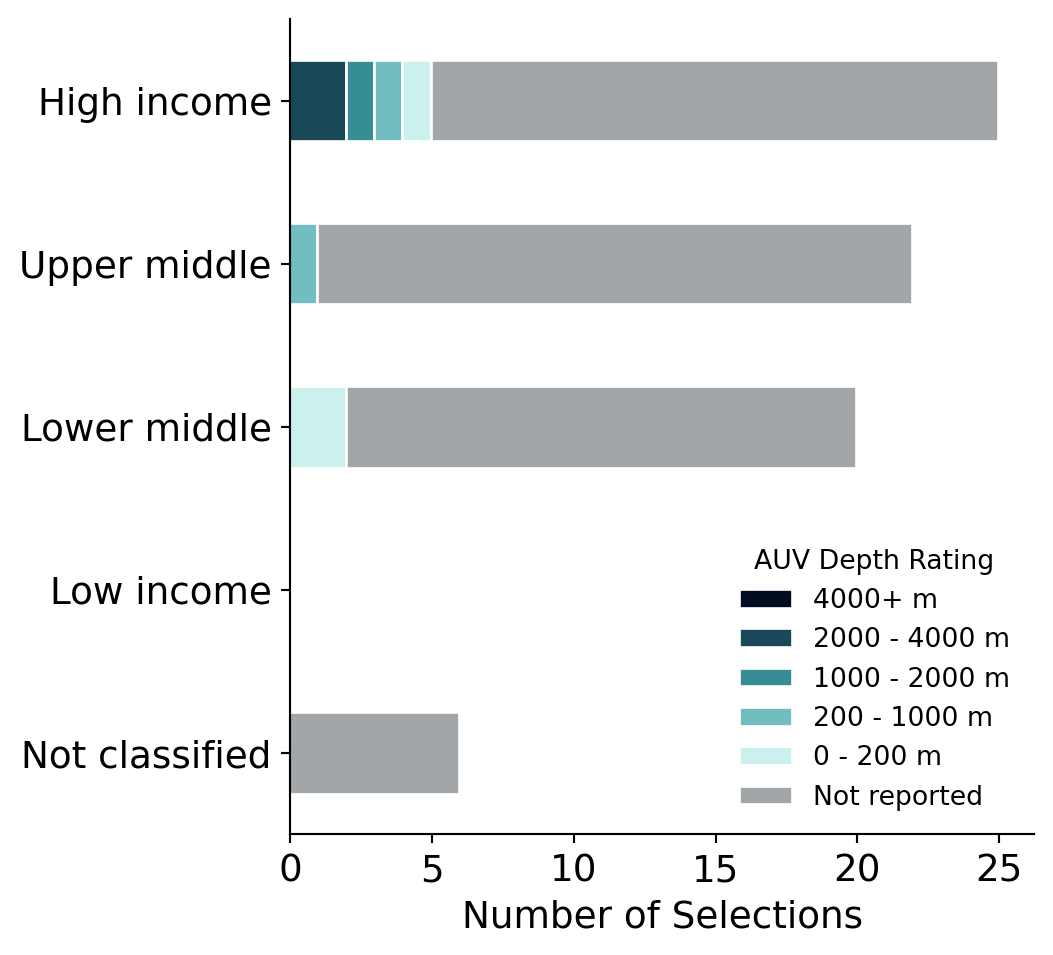

In [116]:
## Create horizontal bar plot

w = 960
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)

    fig_data[region].plot(kind='barh', 
                  stacked=True,
                  legend=True,
                  fontsize=14,
                  color=val_05,
                  edgecolor='white',
                  ax=ax)
    ax.set_xlabel('Number of Selections', fontsize=14)
    barh_pixel_fix(ax)
    ax.set_ylabel('')
    loc_tweaks = {}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              labels=['4000+ m',
                      '2000 - 4000 m',
                      '1000 - 2000 m',
                      '200 - 1000 m',
                      '0 - 200 m',
                      'Not reported'], 
              title='AUV Depth Rating', 
              fontsize=10, 
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='7', letter='P4')

## **Fig P5**&nbsp; Q19: DSV depth (HOVs)

In [117]:
## Get data for figure

for region in region_list:
    ## Select hovs
    # NOTE: reusing 'depth' from previous fig!
    hov = depth[region][depth[region]['col_name'].isin(['Q19_hov'])].copy()

    fig_data[region] = (hov.groupby(['subregion', 'selection_survey_clean'])['respondent_id']
                       .count()
                       .rename('count')
                       .reset_index())

    percent_data = fig_data[region].copy()
    fig_data[region] = fig_data[region].pivot(columns='selection_survey_clean', index='subregion', values='count')

    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, barh=True)
    col_order = ['4000+ m', '2000 - 4000 m', '1000 - 2000 m', '200 - 1000 m', '0 - 200 m', 'NR']
    fig_data[region] = reorder_columns(fig_data[region], col_order, createmissingcolumns=True)

    # Calculate percentages
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection_survey_clean', values=['count', 'percent'])
    pivoted.loc['0-3,000 m'] = 0
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = rov_tow.shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

Adding missing row Low income
Adding missing column 4000+ m
Adding missing column 2000 - 4000 m
Adding missing column 1000 - 2000 m


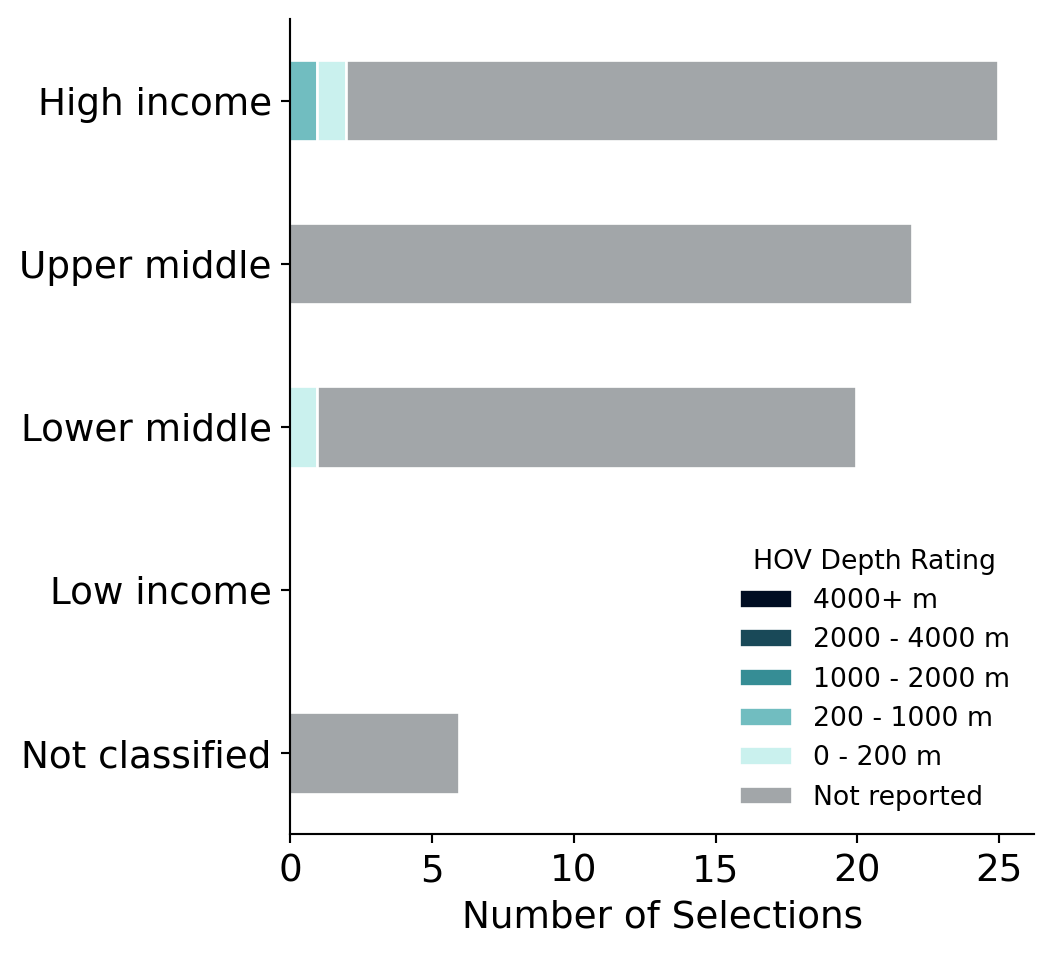

In [118]:
## Create horizontal bar plot

w = 960
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)

    fig_data[region].plot(kind='barh', 
                  stacked=True,
                  legend=True,
                  fontsize=14,
                  color=val_05,
                  edgecolor='white',
                  ax=ax)
    ax.set_xlabel('Number of Selections', fontsize=14)
    barh_pixel_fix(ax)
    ax.set_ylabel('')
    loc_tweaks = {}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              labels=['4000+ m',
                      '2000 - 4000 m',
                      '1000 - 2000 m',
                      '200 - 1000 m',
                      '0 - 200 m',
                      'Not reported'], 
              title='HOV Depth Rating', 
              fontsize=10, 
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='7', letter='P5')

## **Fig P6**&nbsp; Q19: Landers

In [119]:
## Get data for figure

fig_data = {}
for region in region_list:
    ## Select landers/drifters
    # NOTE: reusing 'depth' from previous fig!
    land_drift = depth[region][depth[region]['col_name'].isin(['Q19_bruv'])].copy()

    fig_data[region] = (land_drift.groupby(['subregion', 'selection_survey_clean'])['respondent_id']
                       .count()
                       .rename('count')
                       .reset_index())

    percent_data = fig_data[region].copy()
    fig_data[region] = fig_data[region].pivot(columns='selection_survey_clean', index='subregion', values='count')

    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, barh=True)
    col_order = ['4000+ m', '2000 - 4000 m', '1000 - 2000 m', '200 - 1000 m', '0 - 200 m', 'NR']
    fig_data[region] = reorder_columns(fig_data[region], col_order, createmissingcolumns=True)

    # Calculate percentages
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection_survey_clean', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = rov_tow.shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

Adding missing row Low income


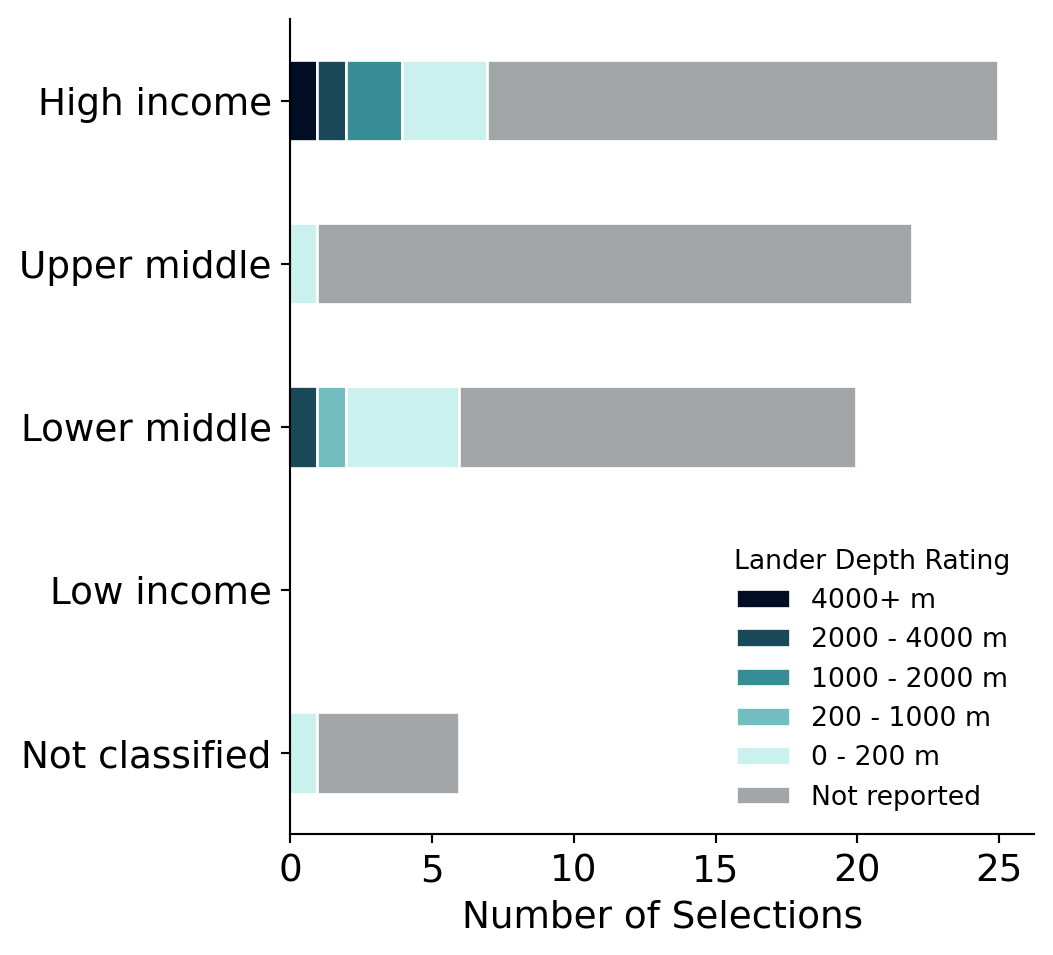

In [120]:
## Create horizontal bar plot

w = 960
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)

    fig_data[region].plot(kind='barh', 
                  stacked=True,
                  legend=True,
                  fontsize=14,
                  color=val_05,
                  edgecolor='white',
                  ax=ax)
    ax.set_xlabel('Number of Selections', fontsize=14)
    barh_pixel_fix(ax)
    ax.set_ylabel('')
    loc_tweaks = {}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              labels=['4000+ m',
                      '2000 - 4000 m',
                      '1000 - 2000 m',
                      '200 - 1000 m',
                      '0 - 200 m',
                      'Not reported'], 
              title='Lander Depth Rating', 
              fontsize=10, 
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='7', letter='P6')

## **Fig P7**&nbsp; Q19: Drifters

In [121]:
## Get data for figure

fig_data = {}
for region in region_list:
    ## Select landers/drifters
    land_drift = depth[region][depth[region]['col_name'].isin(['Q19_drifters'])].copy()

    fig_data[region] = (land_drift.groupby(['subregion', 'selection_survey_clean'])['respondent_id']
                       .count()
                       .rename('count')
                       .reset_index())

    percent_data = fig_data[region].copy()
    fig_data[region] = fig_data[region].pivot(columns='selection_survey_clean', index='subregion', values='count')

    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, barh=True)
    col_order = ['4000+ m', '2000 - 4000 m', '1000 - 2000 m', '200 - 1000 m', '0 - 200 m', 'NR']
    fig_data[region] = reorder_columns(fig_data[region], col_order, createmissingcolumns=True)

    # Calculate percentages
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection_survey_clean', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = rov_tow.shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

Adding missing row Low income
Adding missing column 4000+ m
Adding missing column 2000 - 4000 m
Adding missing column 1000 - 2000 m
Adding missing column 200 - 1000 m


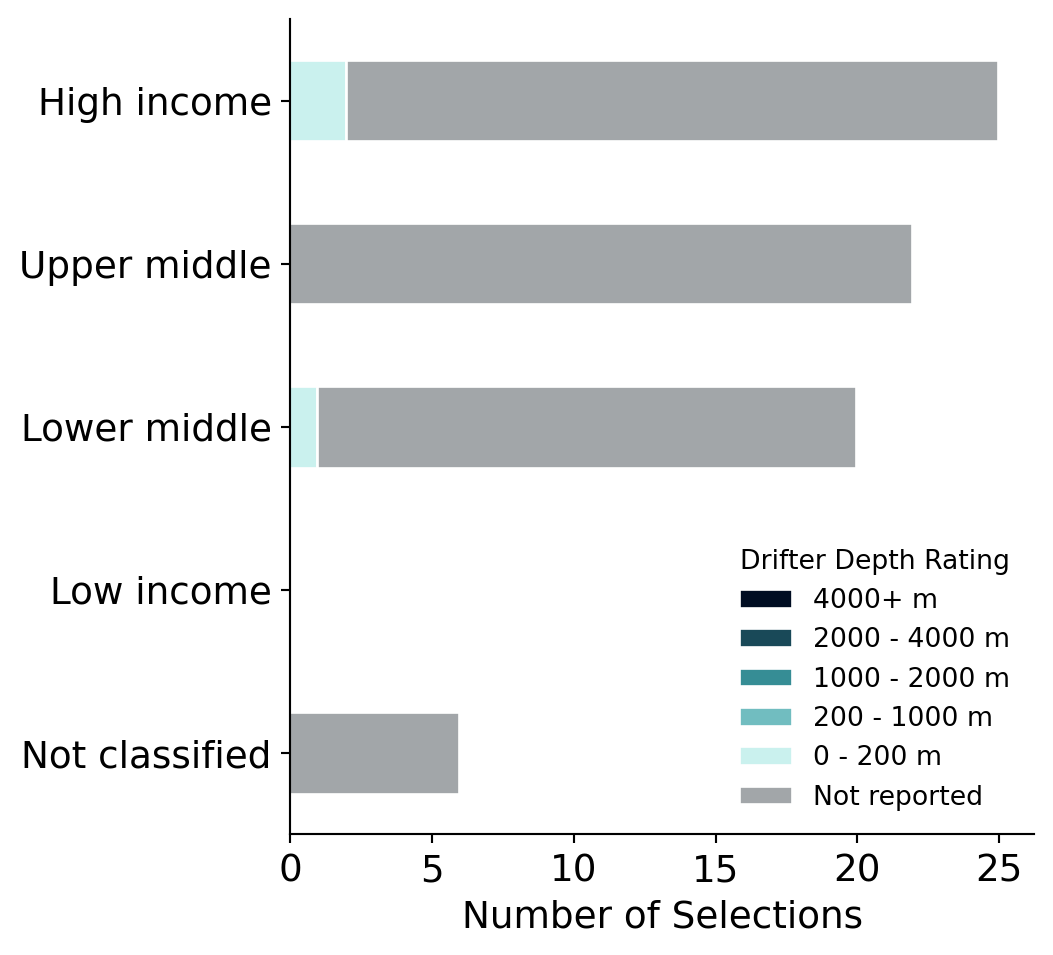

In [122]:
## Create horizontal bar plot

w = 960
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)

    fig_data[region].plot(kind='barh', 
                  stacked=True,
                  legend=True,
                  fontsize=14,
                  color=val_05,
                  edgecolor='white',
                  ax=ax)
    ax.set_xlabel('Number of Selections', fontsize=14)
    barh_pixel_fix(ax)
    ax.set_ylabel('')
    loc_tweaks = {}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              labels=['4000+ m',
                      '2000 - 4000 m',
                      '1000 - 2000 m',
                      '200 - 1000 m',
                      '0 - 200 m',
                      'Not reported'], 
              title='Drifter Depth Rating', 
              fontsize=10, 
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='7', letter='P7')

## **Fig P8**&nbsp; DSV Depth Rating

In [123]:
## Get data for figure

fig_data = {}
for region in region_list:
    depth = dataR[region].loc[dataR[region]['question'] == 'Q19', ['col_name', 
                                                   'subregion', 
                                                   'geoarea', 
                                                   'respondent_id', 
                                                   'selection_survey_clean']].copy()
    depth.loc[(depth['col_name'] == 'Q19_other') & (depth['selection_survey_clean'] != ''), 'selection_survey_clean'] = 'Other'
    depth.loc[(depth['col_name'] != 'Q19_other') & (depth['selection_survey_clean'] == ''), ['selection_survey_clean']] = 'N/A'

    depth = depth[depth['selection_survey_clean'] != '']
    depth = depth[depth['selection_survey_clean'] != 'Other']

    rov_tow = depth.copy()

    fig_data[region] = (rov_tow.groupby(['subregion', 'selection_survey_clean'])['respondent_id']
                       .count()
                       .rename('count')
                       .reset_index())

    percent_data = fig_data[region].copy()
    fig_data[region] = fig_data[region].pivot(columns='selection_survey_clean', index='subregion', values='count')

    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, barh=True)
    
    col_order = ['4000+ m', '2000 - 4000 m', '1000 - 2000 m', '200 - 1000 m', '0 - 200 m', 'NR']
    fig_data[region] = reorder_columns(fig_data[region], col_order, createmissingcolumns=True)

    # Calculate percentages
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection_survey_clean', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = rov_tow.shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

Adding missing row Low income


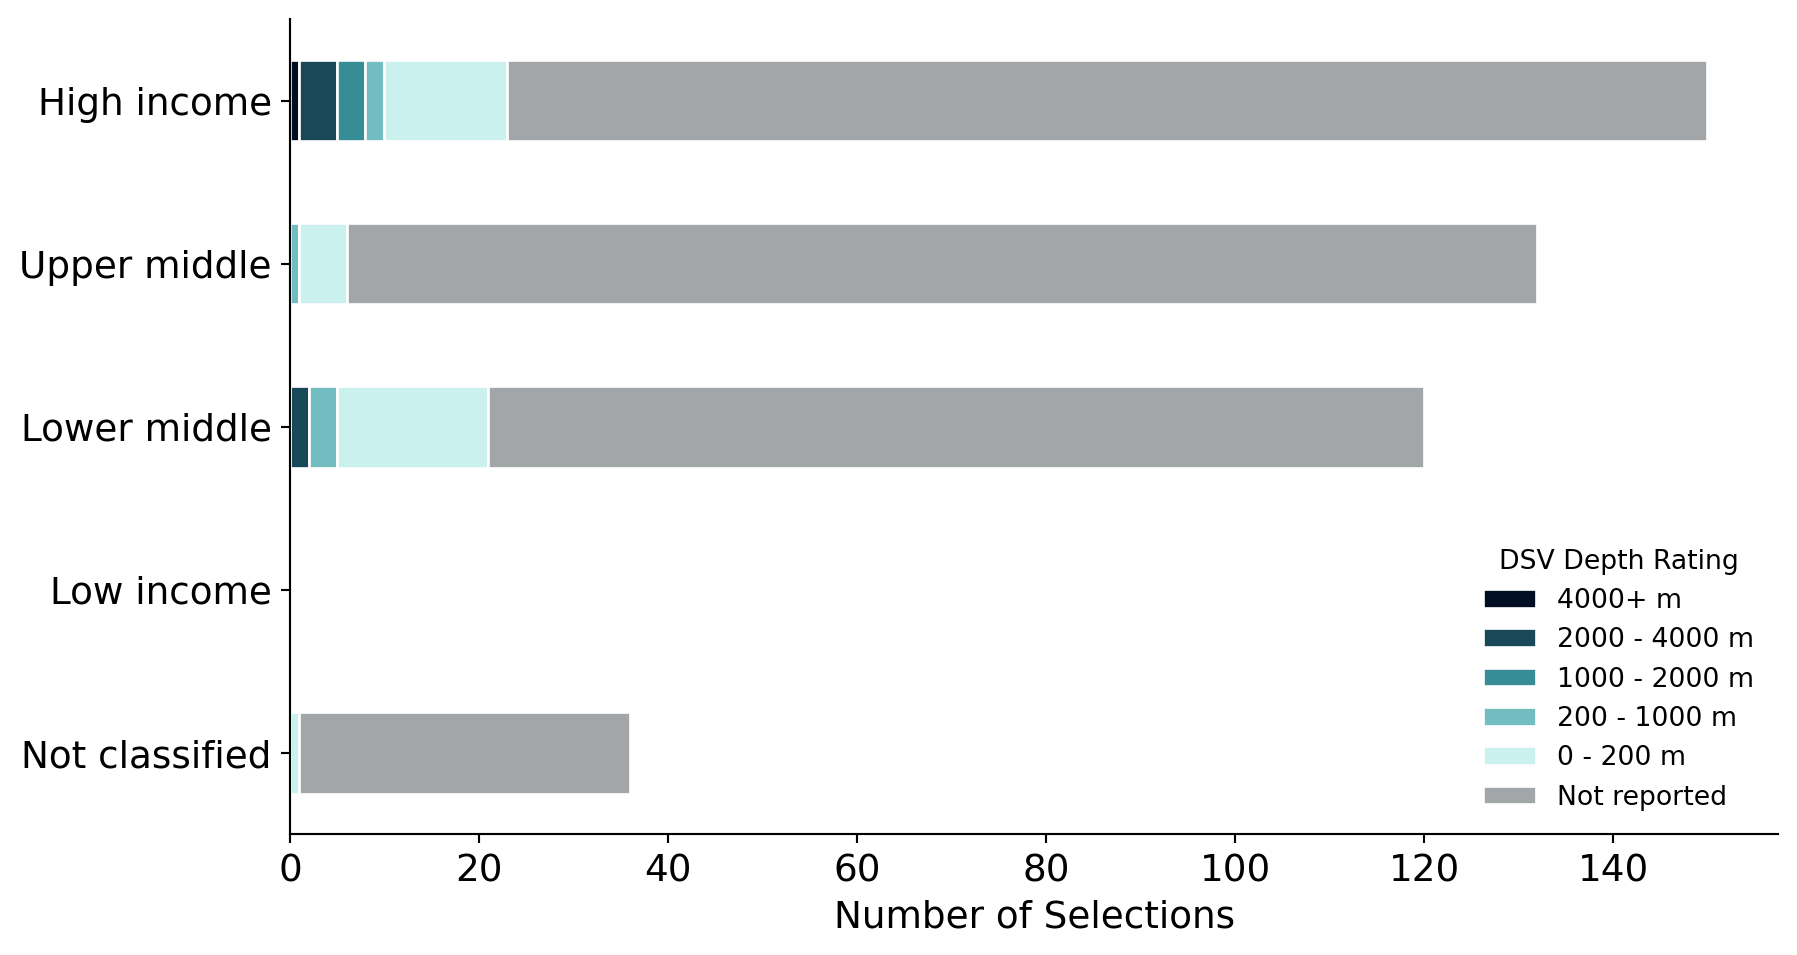

In [124]:
## Create horizontal bar plot

w = 1920
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)

    fig_data[region].plot(kind='barh', 
                  stacked=True,
                  legend=True,
                  fontsize=14,
                  color=val_05,
                  edgecolor='white',
                  ax=ax)
    ax.set_xlabel('Number of Selections', fontsize=14)
    barh_pixel_fix(ax)
    ax.set_ylabel('')
    loc_tweaks = {'Africa': 'center right'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              labels=['4000+ m',
                      '2000 - 4000 m',
                      '1000 - 2000 m',
                      '200 - 1000 m',
                      '0 - 200 m',
                      'Not reported'], 
              title='DSV Depth Rating', 
              fontsize=10, 
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='7', letter='P8')

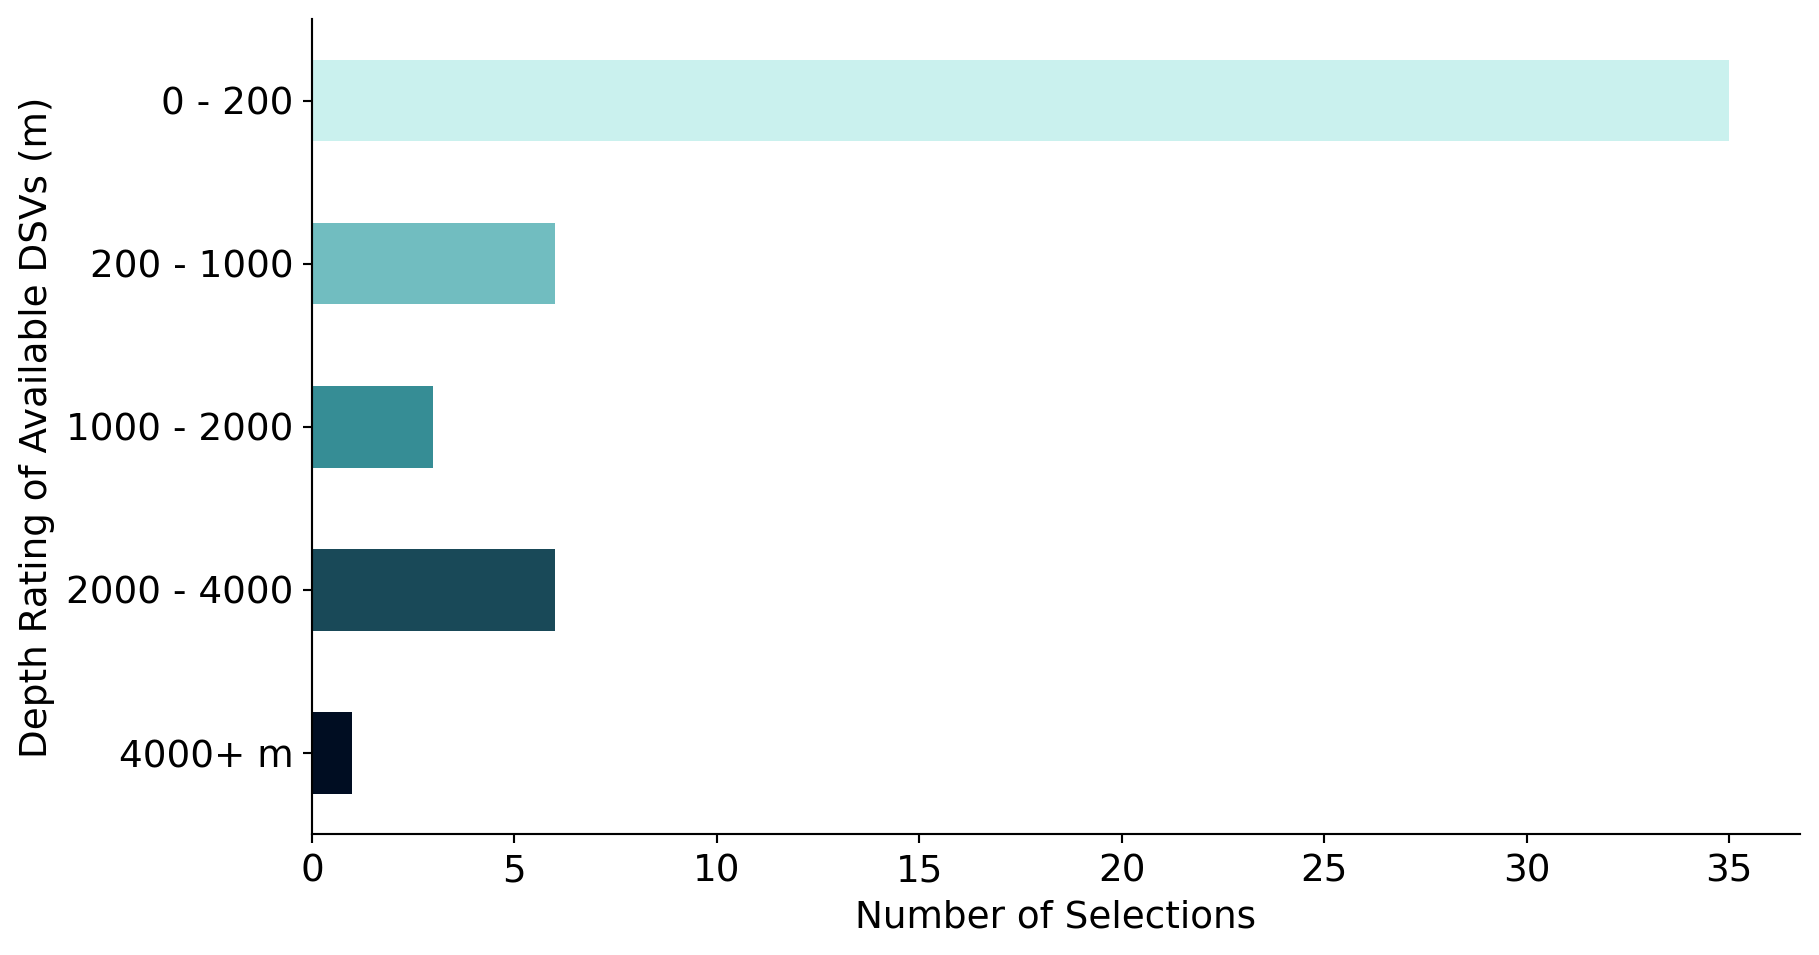

In [125]:
## Get data for figure

fig_data = {}
for region in region_list:
    depth = dataR[region].loc[dataR[region]['question'] == 'Q19', ['col_name', 
                                                   'subregion', 
                                                   'geoarea', 
                                                   'respondent_id', 
                                                   'selection_survey_clean']].copy()
    depth.loc[(depth['col_name'] == 'Q19_other') & (depth['selection_survey_clean'] != ''), 'selection_survey_clean'] = 'Other'
    depth.loc[(depth['col_name'] != 'Q19_other') & (depth['selection_survey_clean'] == ''), ['selection_survey_clean']] = 'N/A'

    depth = depth[depth['selection_survey_clean'] != '']
    depth = depth[depth['selection_survey_clean'] != 'Other']

    fig_data[region] = (depth.groupby(['selection_survey_clean'])['respondent_id']
                       .count()
                       .rename('count'))
    fig_data[region] = fig_data[region].drop(['NR'])
    fig_data[region] = reorder_rows_and_rename(
        fig_data[region],
        [
            ['0 - 200 m',     '0 - 200'],
            ['200 - 1000 m',  '200 - 1000'],
            ['1000 - 2000 m', '1000 - 2000'],
            ['2000 - 4000 m', '2000 - 4000'],
            ['4000+ m',       '4000+ m']
        ],
        createmissingrows=True
    )
    

## Create horizontal bar plot

w = 1920
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
    fig_data[region].iloc[::-1].plot(kind='barh', 
                  fontsize=14,
                  color=val_05,
                  ax=ax)
    ax.set_xlabel('Number of Selections', fontsize=14)
    ax.set_ylabel('Depth Rating of Available DSVs (m)', fontsize=14)

    outputfigs(plt, fig, ax, region, section='7', letter='P9')

## **Fig Q1**&nbsp; Q20: DSV satisfaction

In [126]:
## Select data

satisfaction = {}
missing_responses = {}
for region in region_list:
    satisfaction[region] = dataR[region].loc[dataR[region]['question'] == 'Q20', ['col_name', 
                                                   'subregion', 
                                                   'geoarea', 
                                                   'respondent_id', 
                                                   'selection',
                                                   'selection_other']]
    satisfaction[region].loc[(satisfaction[region]['col_name'] == 'Q20_other') & 
                     (satisfaction[region]['selection'] != ''), 'selection_other'] = 'Other'

    missing_responses[region] = satisfaction[region][satisfaction[region]['selection_other'] == ''].copy()

    satisfaction[region] = satisfaction[region][~satisfaction[region]['selection_other'].isin(['Other', ''])]
    satisfaction[region]['row_num'] = np.arange(satisfaction[region].shape[0])

In [127]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Very dissatisfied', 
            'Dissatisfied', 
            'Neutral', 
            'Satisfied', 
            'Very satisfied']

fig_data = {}
for region in region_list:
    fig_data[region] = satisfaction[region].pivot(columns='subregion', index='row_num', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({'1 - Very dissatisfied': 'Very dissatisfied',
                      '2 - Dissatisfied': 'Dissatisfied',
                      '3 - Neither satisfied nor dissatisfied': 'Neutral',
                      '4 - Satisfied': 'Satisfied',
                      '5 - Very satisfied': 'Very satisfied'}, inplace=True)

Adding missing column Low income


In [128]:
for region in region_list:
    ## Calculate number of people who chose NA for each question and subregion - recall that one individual could choose 
    ## NA for more than one question
    stats = missing_responses[region].groupby(['col_name', 'subregion'])['respondent_id'].nunique().rename('count').reset_index()
    stats = stats.pivot(columns='subregion', index='col_name', values='count')
    stats['Total'] = stats.sum(axis=1)
    #display(stats)
    
    ## Calculate the number of people who chose NA on at least one part of the question - EXCLUDING OTHER
    #display(missing_responses[region].loc[missing_responses[region]['col_name'] != 'Q20_other', 'respondent_id'].nunique())

    ## Calculate statistics
    percent_data = (satisfaction[region].groupby(['subregion', 'selection'])['row_num']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = satisfaction[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

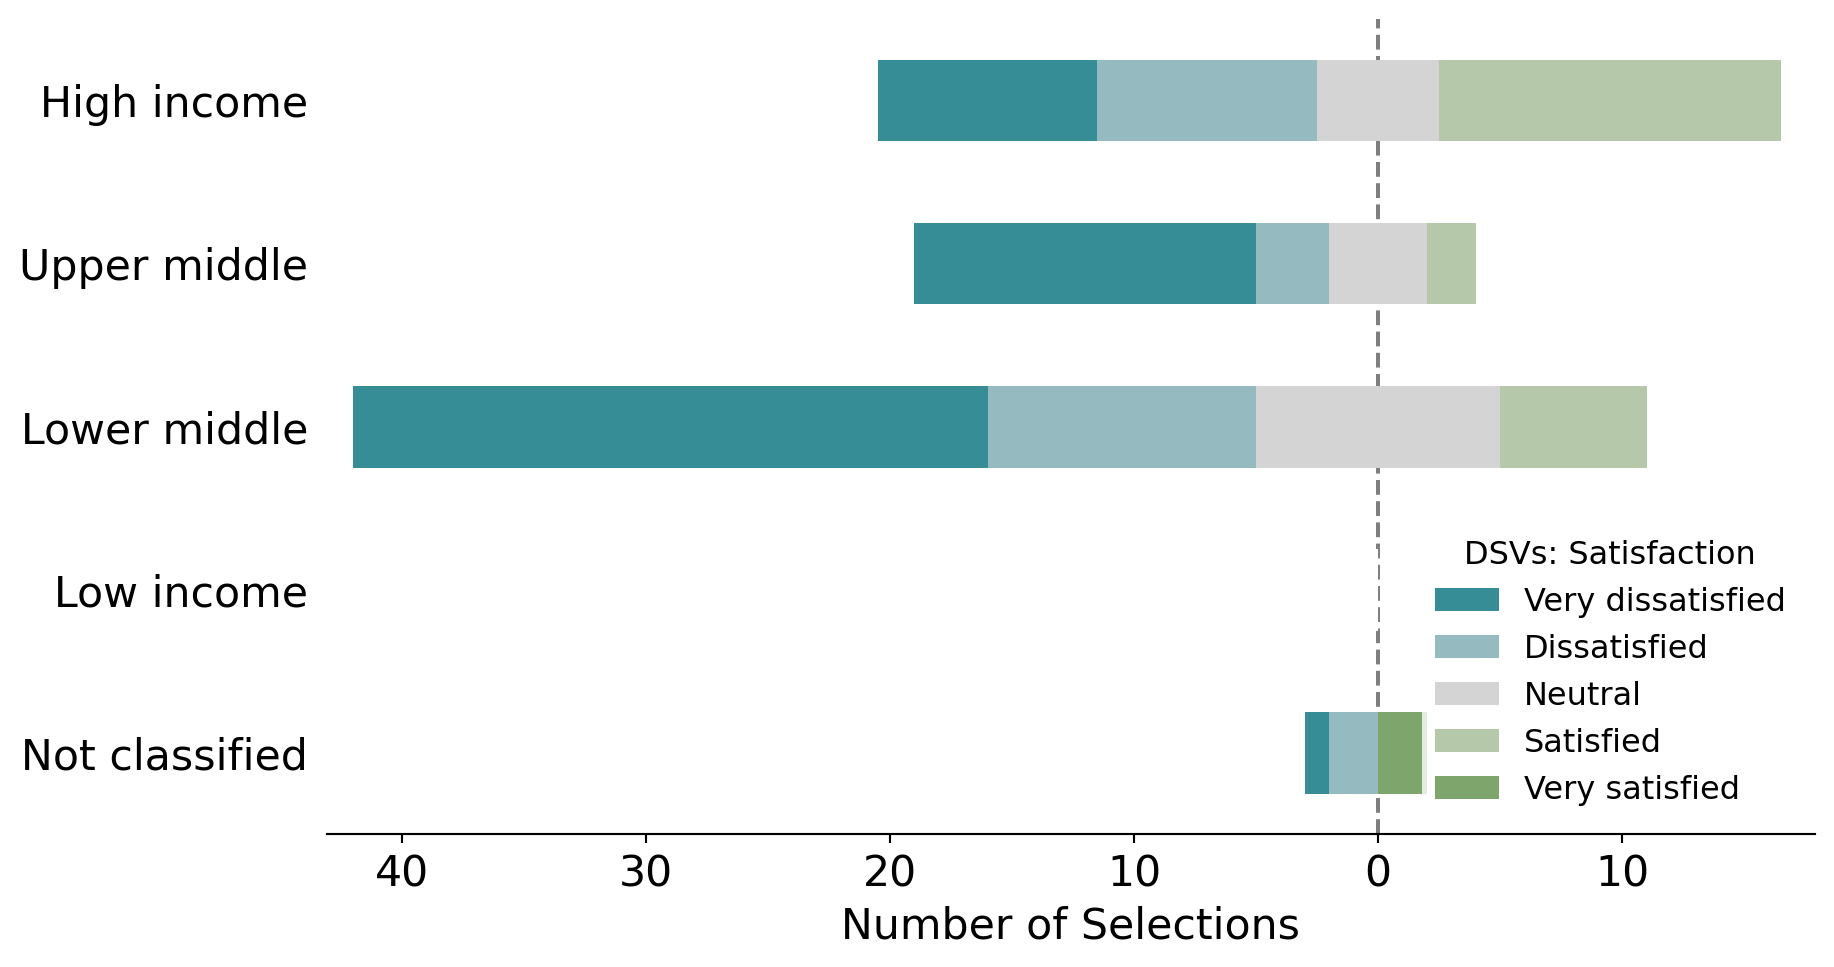

In [129]:
## Create plot

w = 1920
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Selections', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='DSVs: Satisfaction',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='7', letter='Q1')

## **Fig Q2**&nbsp; DSV satisfaction plot #2

In [130]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Very dissatisfied', 
            'Dissatisfied', 
            'Neutral', 
            'Satisfied', 
            'Very satisfied']

fig_data = {}
for region in region_list:
    fig_data[region] = satisfaction[region].pivot(columns='col_name', index='respondent_id', values='selection')

    # Change column names
    fig_data[region].columns = ['Availability', 'Capabilities', 'Cost', 'Duration', 'Depth']

    # Change column order
    sorted_cols = ['Cost', 'Availability', 'Capabilities', 'Depth', 'Duration']
    fig_data[region] = reorder_columns(fig_data[region], sorted_cols)

    # Change scale values
    fig_data[region].replace({'1 - Very dissatisfied': 'Very dissatisfied',
                      '2 - Dissatisfied': 'Dissatisfied',
                      '3 - Neither satisfied nor dissatisfied': 'Neutral',
                      '4 - Satisfied': 'Satisfied',
                      '5 - Very satisfied': 'Very satisfied'}, inplace=True)

In [131]:
## Calculate statistics

for region in region_list:
    percent_data = (satisfaction[region].groupby(['col_name', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['col_name']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='col_name', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = satisfaction[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

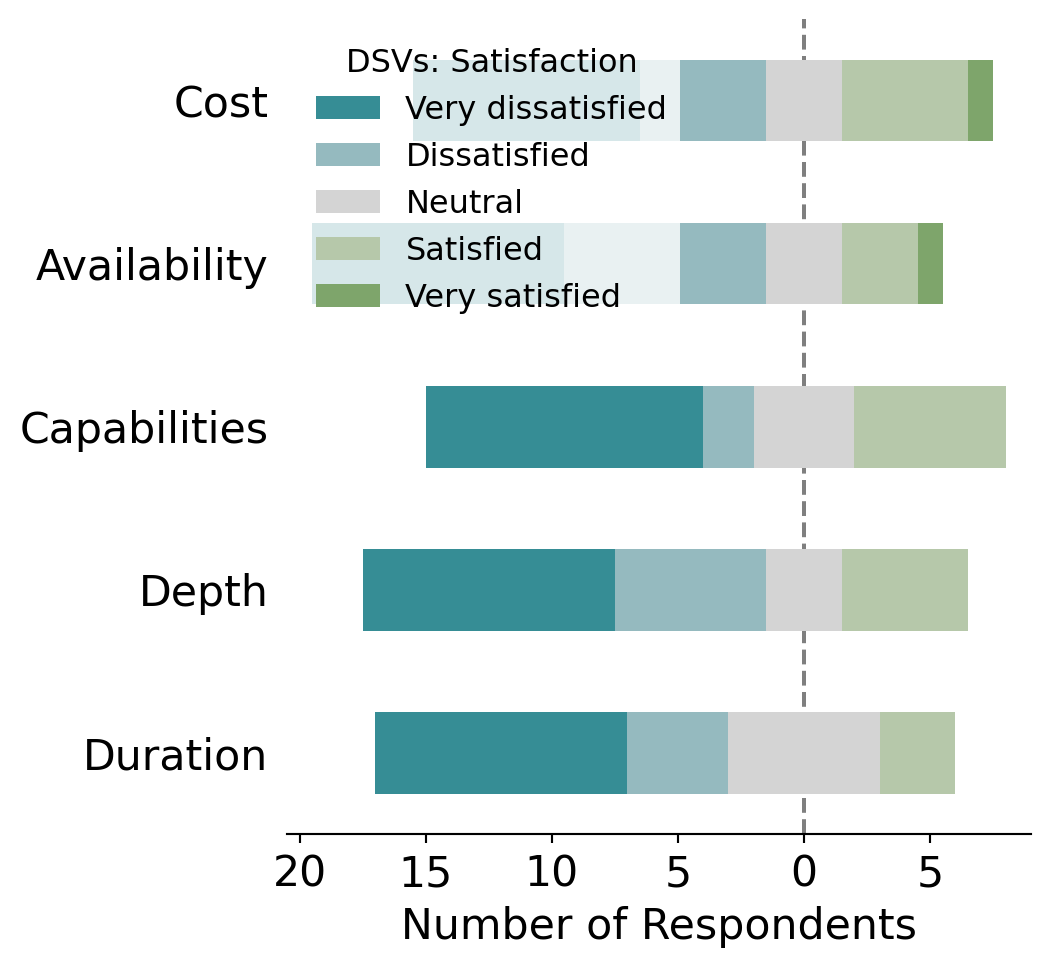

In [132]:
## Create plot

w = 960
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {'Africa': 'lower left'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='DSVs: Satisfaction',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='7', letter='Q2')

## **Fig Q3**&nbsp; Q20a: DSV cost

In [133]:
## Select relevant survey data

cost = {}
for region in region_list:
    cost[region] = dataR[region].loc[(dataR[region]['col_name'] == 'Q20_cost') &
                (dataR[region]['selection'] != ''), 
                      ['respondent_id', 'subregion', 'col_name', 'selection']]

In [134]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Very dissatisfied', 
            'Dissatisfied', 
            'Neutral', 
            'Satisfied', 
            'Very satisfied']

fig_data = {}
for region in region_list:
    fig_data[region] = cost[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({'1 - Very dissatisfied': 'Very dissatisfied',
                      '2 - Dissatisfied': 'Dissatisfied',
                      '3 - Neither satisfied nor dissatisfied': 'Neutral',
                      '4 - Satisfied': 'Satisfied',
                      '5 - Very satisfied': 'Very satisfied'}, inplace=True)

Adding missing column Low income


In [135]:
## Calculate statistics

for region in region_list:
    percent_data = (cost[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = cost[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

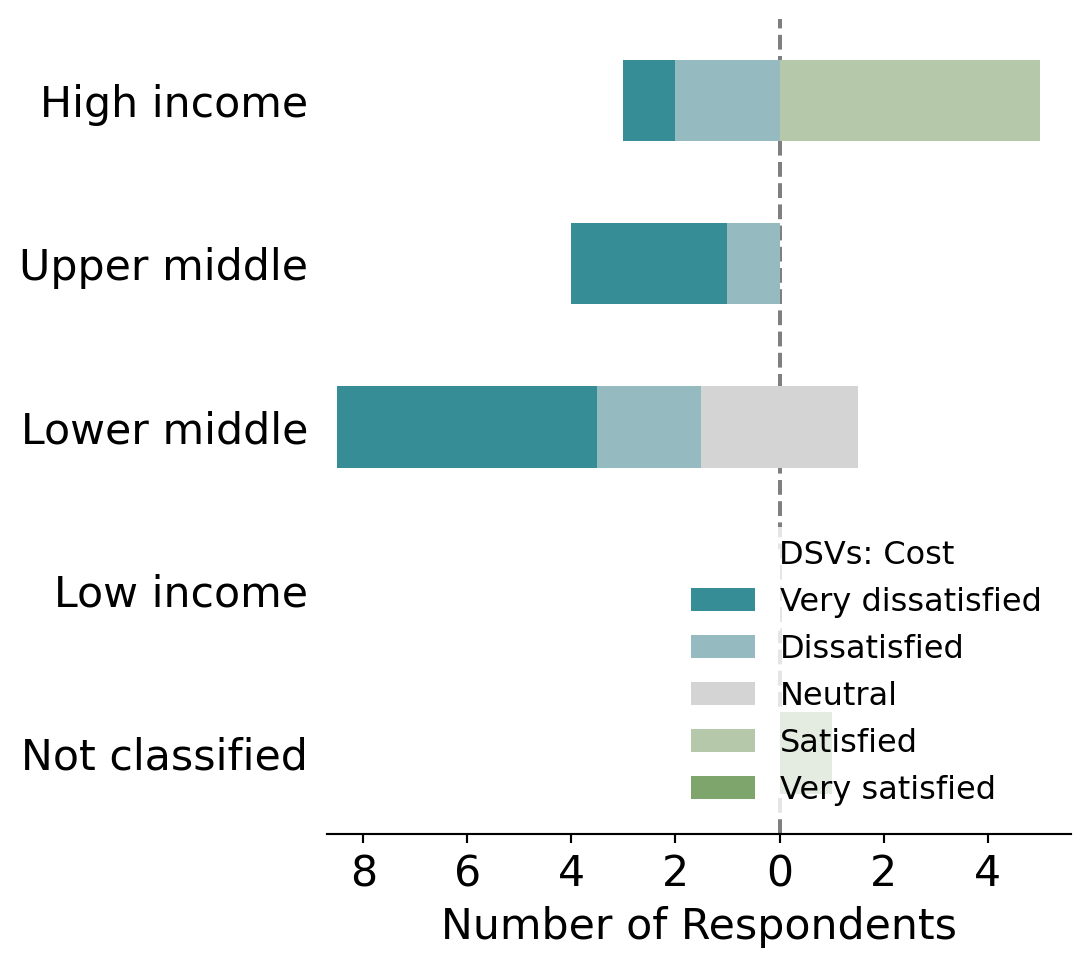

In [136]:
## Create plot

w = 960
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {'Africa': 'lower left', 'Asia': 'lower left', 'Europe': 'upper left', 'SIDS': 'lower right'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='DSVs: Cost',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='7', letter='Q3')

## **Fig Q4**&nbsp; Q20b: DSV availability

In [137]:
## Select relevant survey data

availability = {}
for region in region_list:
    availability[region] = dataR[region].loc[(dataR[region]['col_name'] == 'Q20_availability') &
                    (dataR[region]['selection'] != ''), 
                          ['respondent_id', 'subregion', 'col_name', 'selection']]

In [138]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Very dissatisfied', 
            'Dissatisfied', 
            'Neutral', 
            'Satisfied', 
            'Very satisfied']

for region in region_list:
    fig_data[region] = availability[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({'1 - Very dissatisfied': 'Very dissatisfied',
                      '2 - Dissatisfied': 'Dissatisfied',
                      '3 - Neither satisfied nor dissatisfied': 'Neutral',
                      '4 - Satisfied': 'Satisfied',
                      '5 - Very satisfied': 'Very satisfied'}, inplace=True)

Adding missing column Low income


In [139]:
## Calculate statistics

for region in region_list:
    percent_data = (availability[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = availability[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

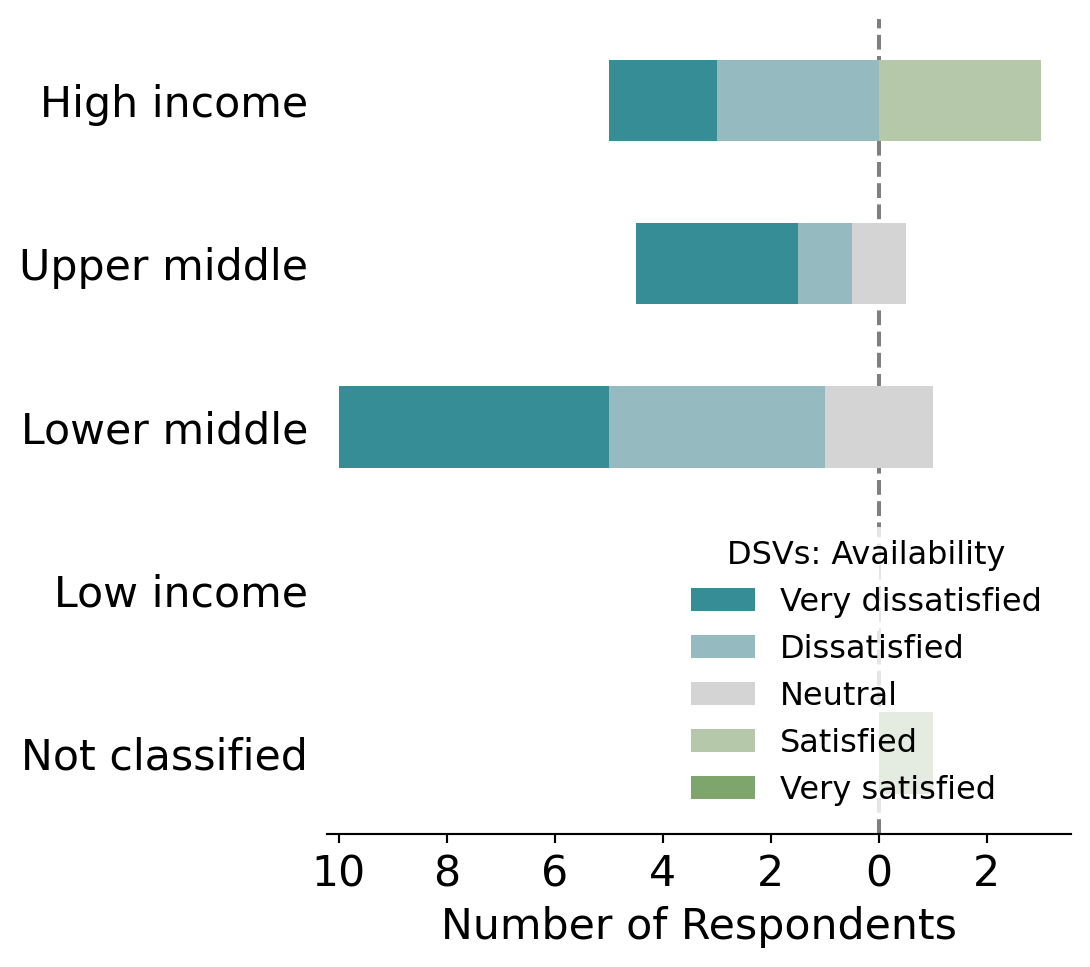

In [140]:
## Create plot

w = 960
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {'Africa': 'lower left', 'Asia': 'lower left', 'Global': 'upper left', 'SIDS': 'lower right'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='DSVs: Availability',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='7', letter='Q4')

## **Fig Q5**&nbsp; Q20c: DSV capabilities

In [141]:
## Select relevant survey data

capabilities = {}
for region in region_list:
    capabilities[region] = dataR[region].loc[(dataR[region]['col_name'] == 'Q20_capabilities') &
                    (dataR[region]['selection'] != ''), 
                          ['respondent_id', 'subregion', 'col_name', 'selection']]

In [142]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Very dissatisfied', 
            'Dissatisfied', 
            'Neutral', 
            'Satisfied', 
            'Very satisfied']

fig_data = {}
for region in region_list:
    fig_data[region] = capabilities[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({'1 - Very dissatisfied': 'Very dissatisfied',
                      '2 - Dissatisfied': 'Dissatisfied',
                      '3 - Neither satisfied nor dissatisfied': 'Neutral',
                      '4 - Satisfied': 'Satisfied',
                      '5 - Very satisfied': 'Very satisfied'}, inplace=True)

Adding missing column Low income


In [143]:
## Calculate statistics

for region in region_list:
    percent_data = (capabilities[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = capabilities[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

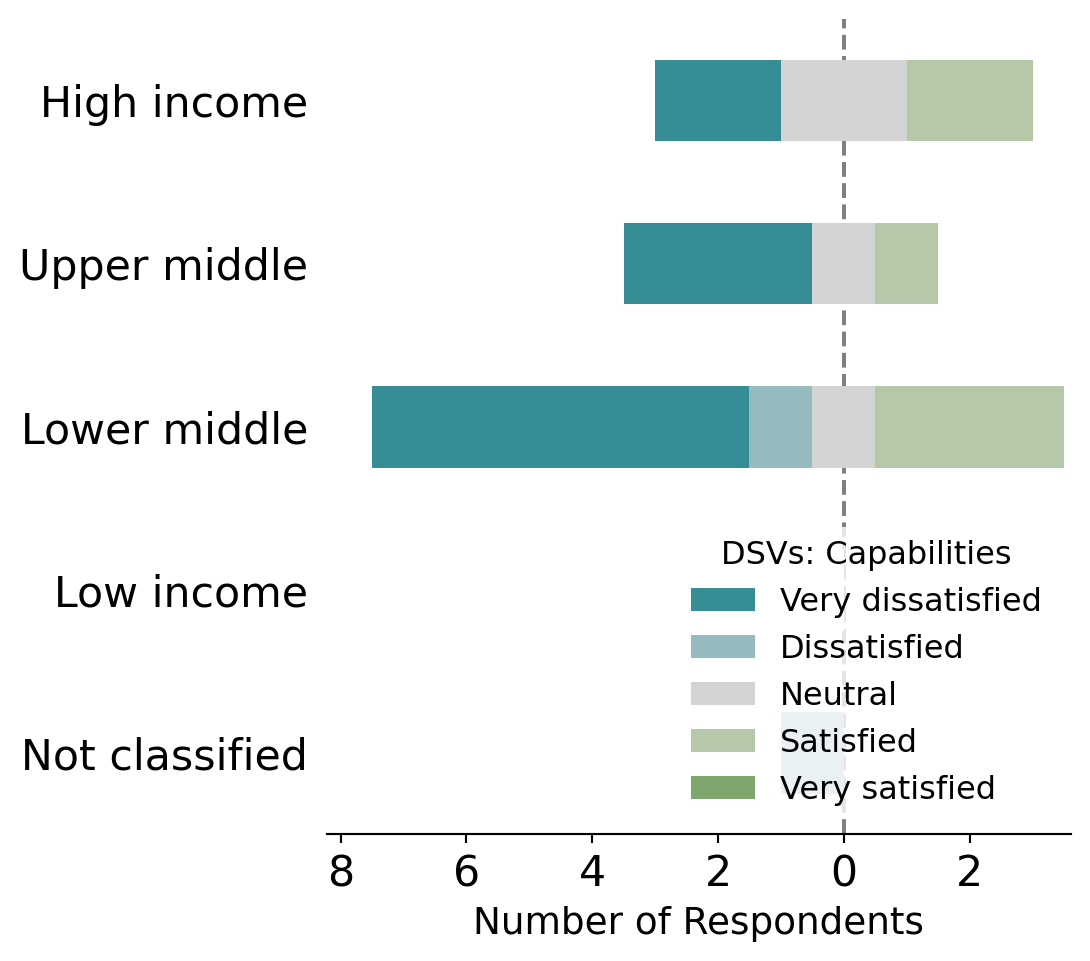

In [144]:
## Create plot

w = 960
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {'Africa': 'lower left', 'Asia': 'lower left', 'Europe': 'upper left', 'Global': 'upper left', 'SIDS': 'lower right'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='DSVs: Capabilities',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='7', letter='Q5')

## **Fig Q6**&nbsp; Q20d: DSV depth

In [145]:
## Select relevant survey data

depth = {}
for region in region_list:
    depth[region] = dataR[region].loc[(dataR[region]['col_name'] == 'Q20_depth') &
                    (dataR[region]['selection'] != ''), 
                          ['respondent_id', 'subregion', 'col_name', 'selection']]

In [146]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Very dissatisfied', 
            'Dissatisfied', 
            'Neutral', 
            'Satisfied', 
            'Very satisfied']

fig_data = {}
for region in region_list:
    fig_data[region] = depth[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({'1 - Very dissatisfied': 'Very dissatisfied',
                      '2 - Dissatisfied': 'Dissatisfied',
                      '3 - Neither satisfied nor dissatisfied': 'Neutral',
                      '4 - Satisfied': 'Satisfied',
                      '5 - Very satisfied': 'Very satisfied'}, inplace=True)

Adding missing column Low income


In [147]:
## Calculate statistics

for region in region_list:
    percent_data = (depth[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = depth[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

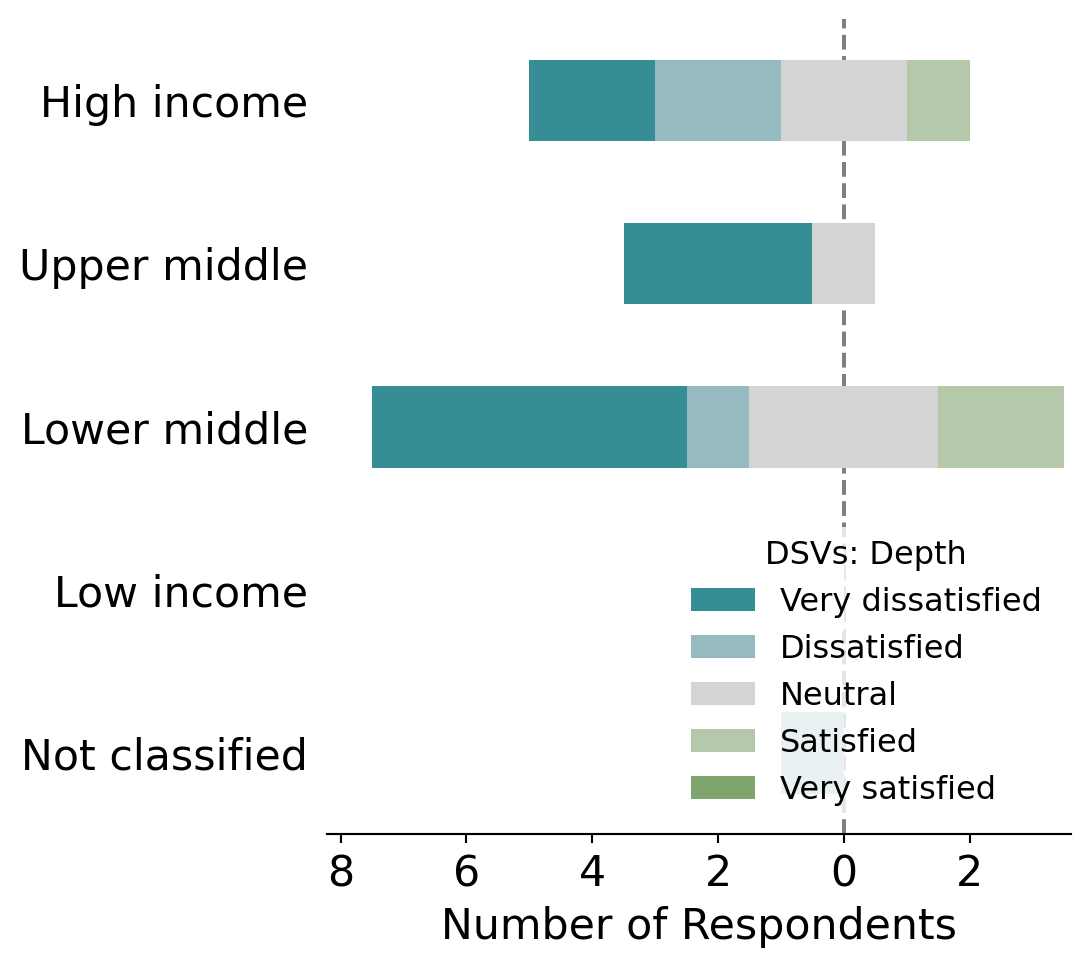

In [148]:
## Create plot

w = 960
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {'Africa': 'lower left', 'Americas': 'lower right', 'Economies': 'lower right', 'Global': 'upper left', 'Oceania': 'upper right'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='DSVs: Depth',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='7', letter='Q6')

## **Fig Q7**&nbsp; Q20e: DSV duration

In [149]:
## Select relevant survey data

duration = {}
for region in region_list:
    duration[region] = dataR[region].loc[(dataR[region]['col_name'] == 'Q20_duration') &
                    (dataR[region]['selection'] != ''), 
                          ['respondent_id', 'subregion', 'col_name', 'selection']]

In [150]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Very dissatisfied', 
            'Dissatisfied', 
            'Neutral', 
            'Satisfied', 
            'Very satisfied']

fig_data = {}
for region in region_list:
    fig_data[region] = duration[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({'1 - Very dissatisfied': 'Very dissatisfied',
                      '2 - Dissatisfied': 'Dissatisfied',
                      '3 - Neither satisfied nor dissatisfied': 'Neutral',
                      '4 - Satisfied': 'Satisfied',
                      '5 - Very satisfied': 'Very satisfied'}, inplace=True)

Adding missing column Low income


In [151]:
## Calculate statistics

for region in region_list:
    percent_data = (duration[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = duration[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

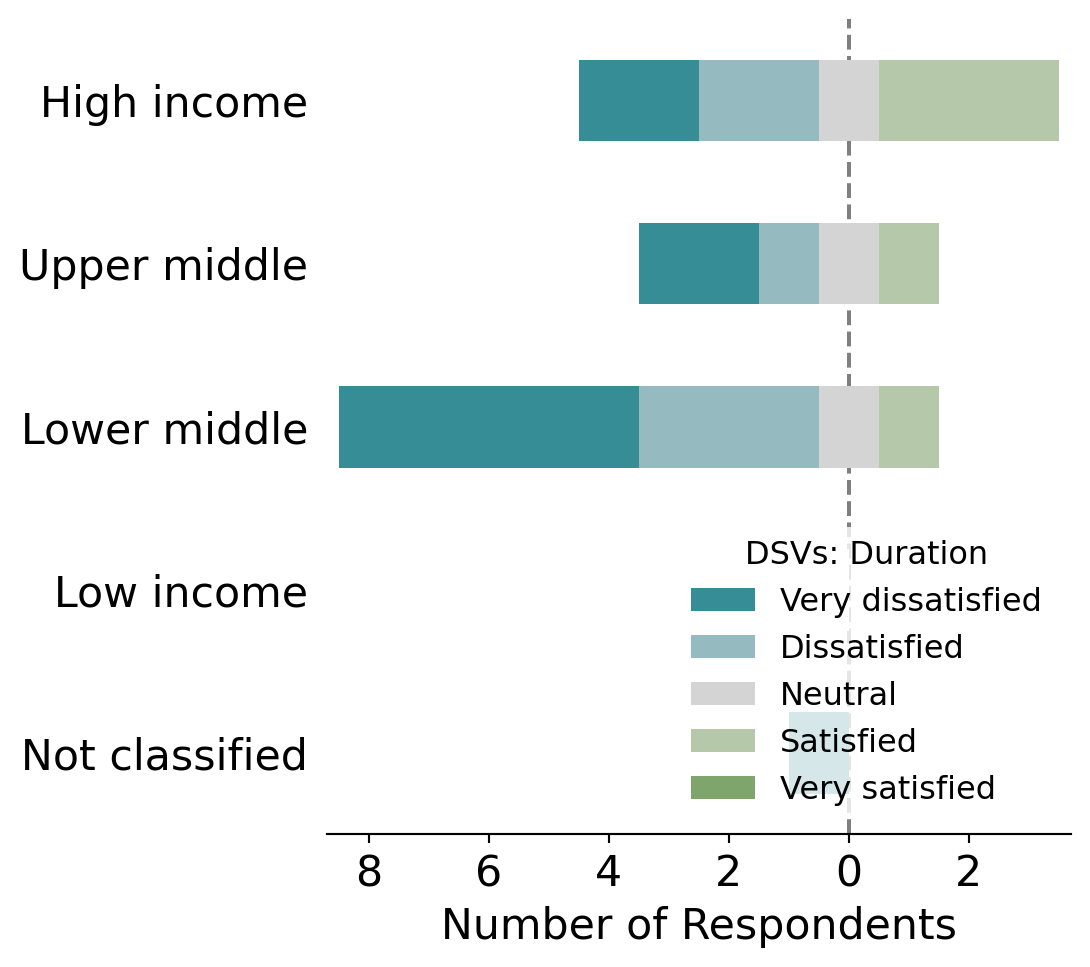

In [152]:
## Create plot

w = 960
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {'Africa': 'lower left', 'Asia': 'lower left', 'Global': 'upper left', 'SIDS': 'lower right'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='DSVs: Duration',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='7', letter='Q7')

## **Fig R1**&nbsp; Q17: DSV importance

In [153]:
## Select relevant survey data

importance = {}
for region in region_list:
    importance[region] = dataR[region].loc[(dataR[region]['question'] == 'Q17'), ['respondent_id', 'subregion', 'col_name', 'selection']] 

In [154]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Not important', 
            'A little important', 
            'Somewhat important',
            'Important',
            'Very important']

fig_data = {}
for region in region_list:
    fig_data[region] = importance[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({'1 - Not important': 'Not important',
                      '2 - A little important': 'A little important',
                      '3 - Somewhat important': 'Somewhat important',
                      '4 - Important': 'Important',
                      '5 - Very important': 'Very important'}, inplace=True)

Adding missing column Low income


In [155]:
## Calculate statistics

for region in region_list:
    percent_data = (importance[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = importance[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

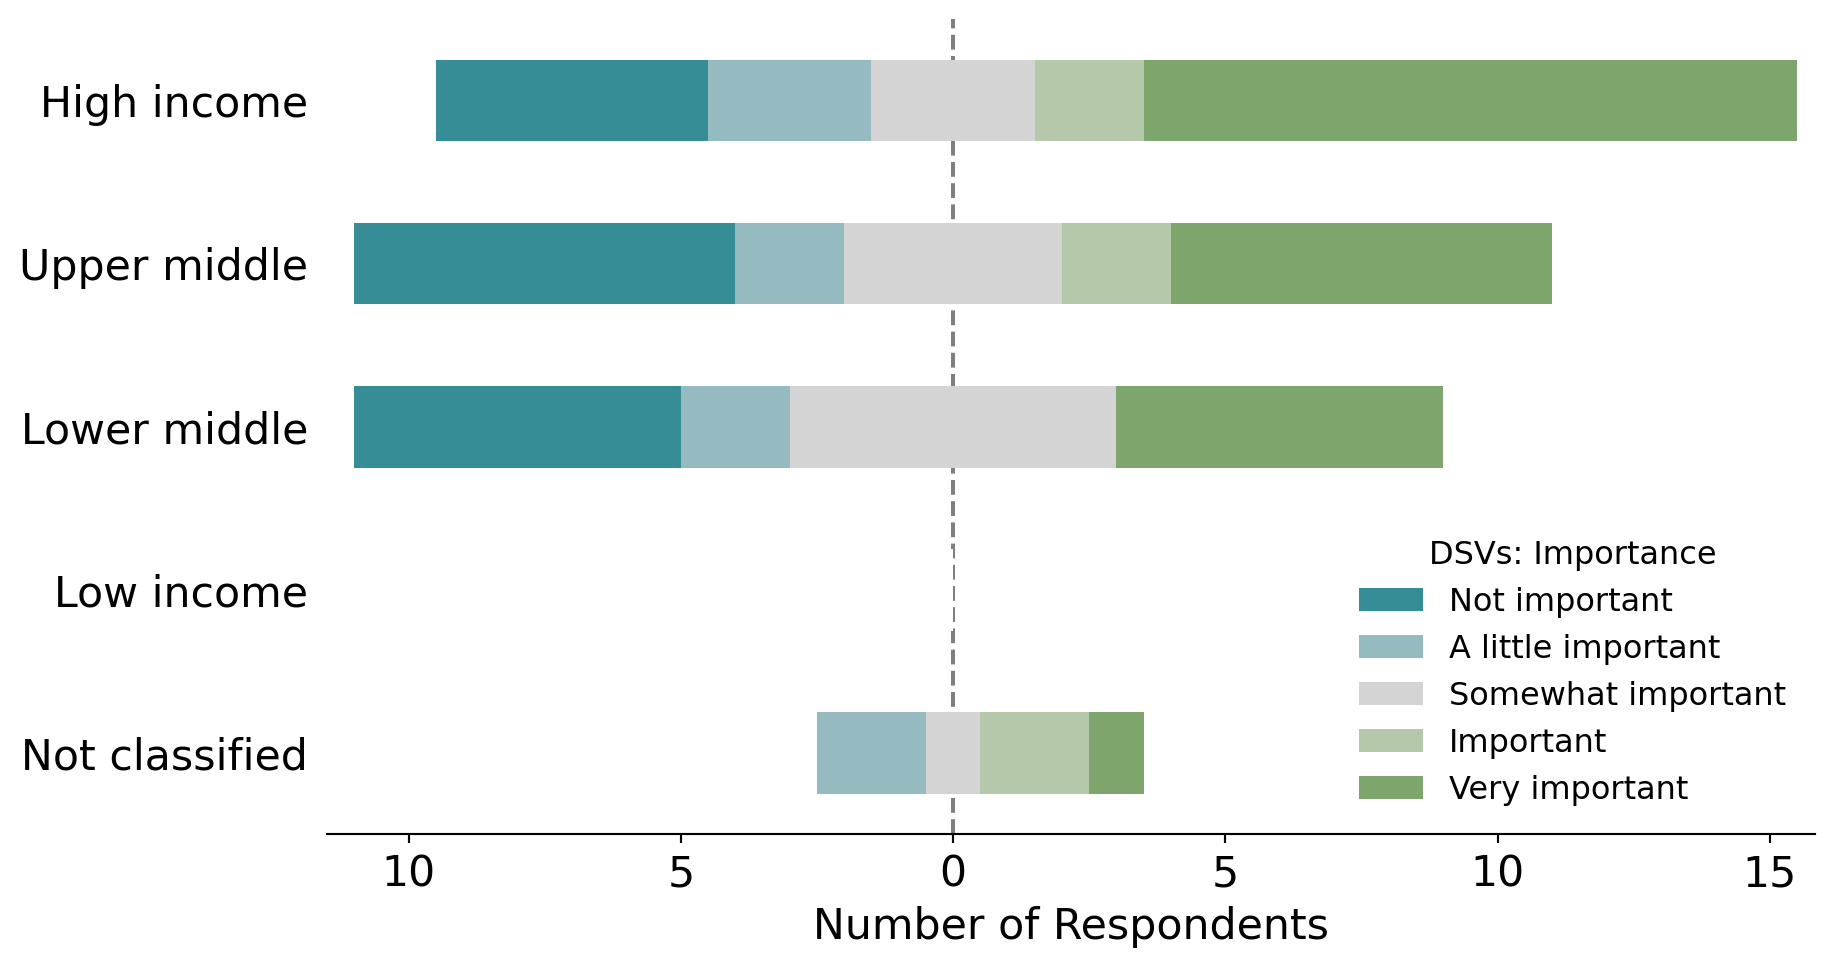

In [156]:
## Create plot

w = 1920
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='DSVs: Importance',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='7', letter='R1')

## **Fig R2**&nbsp; Q21: DSV potential

In [157]:
## Select relevant survey data
potential = {}
for region in region_list:
    potential[region] = dataR[region].loc[(dataR[region]['question'] == 'Q21'), ['respondent_id', 'subregion', 'col_name', 'selection']]

In [158]:
## Calculate values for plot

# Define scale for plot
my_scale = ['No impact', 
            'Little impact', 
            'Moderate impact',
            'High impact',
            'Transformative']

fig_data = {}
for region in region_list:
    fig_data[region] = potential[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({
                      '1 - No impact': 'No impact',
                      '2 - Little impact': 'Little impact',
                      '3 - Moderate impact': 'Moderate impact',
                      '4 - High impact': 'High impact',
                      '5 - Transformative': 'Transformative'},
                      inplace=True)

Adding missing column Low income


In [159]:
## Calculate statistics

for region in region_list:
    percent_data = (potential[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = potential[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

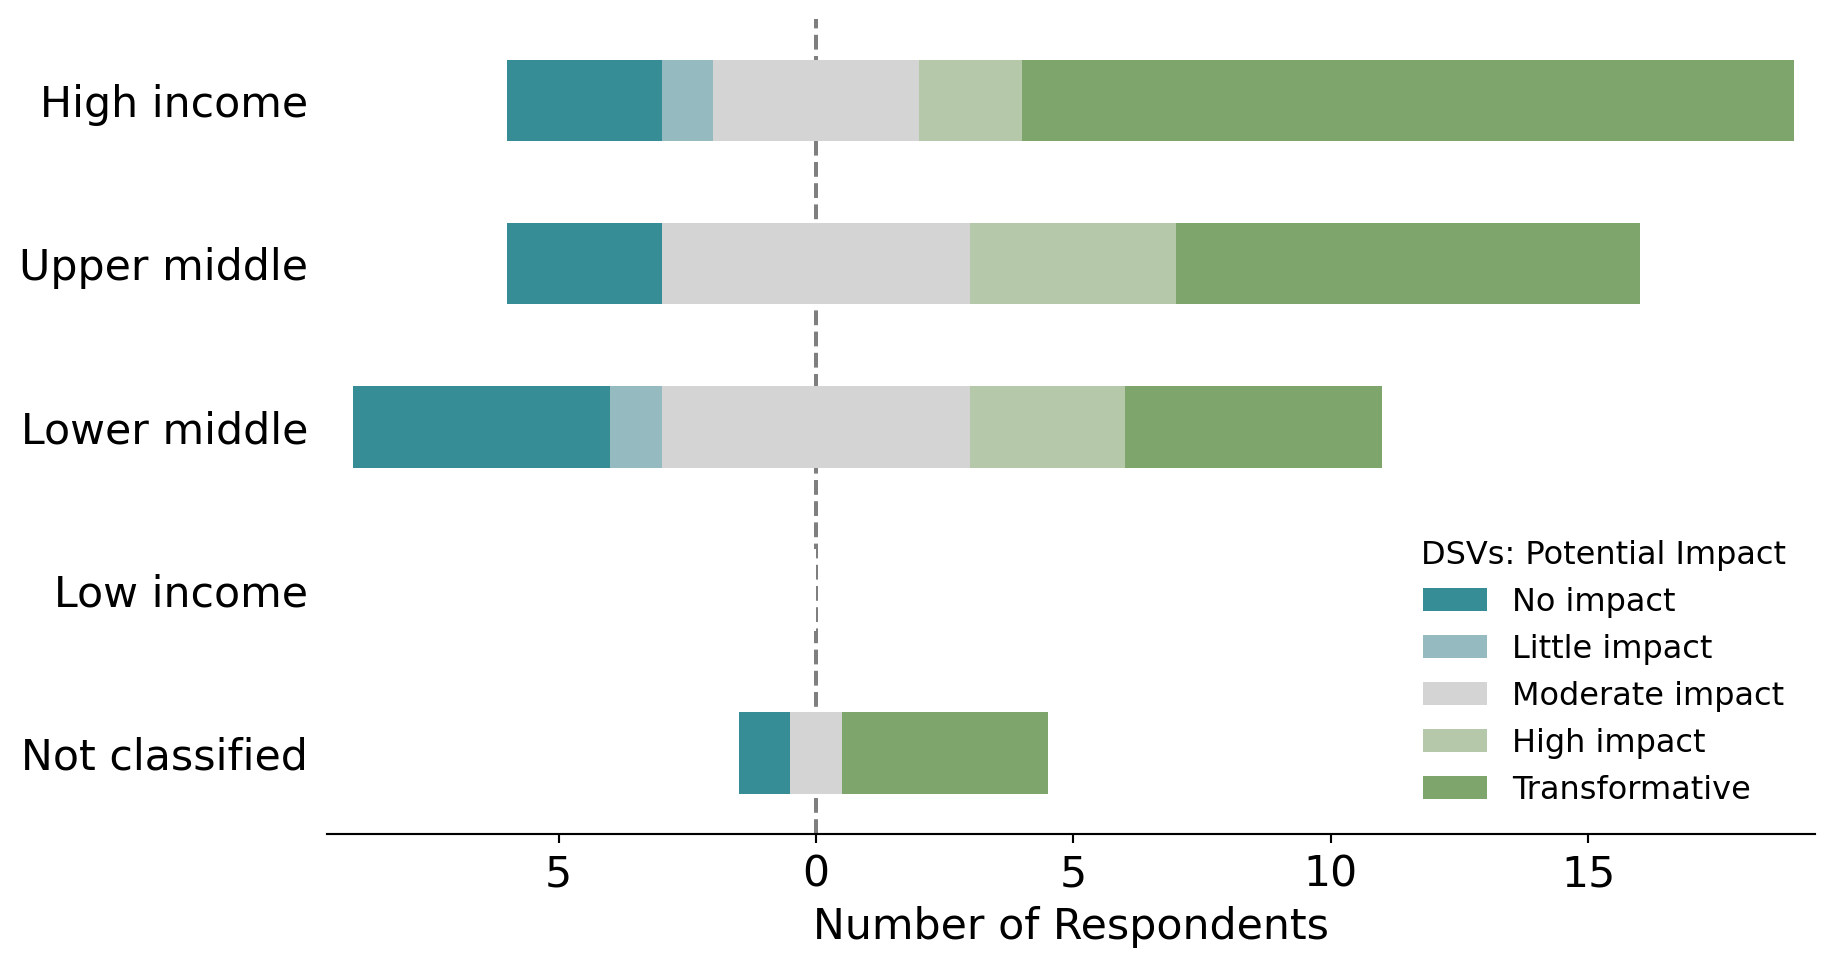

In [160]:
## Create plot

w = 1920
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='DSVs: Potential Impact',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='7', letter='R2')

---
# **Section 8**

## **Figs S1 S2**&nbsp; Sensor presence

In [161]:
## Calculate values for plot

label_order = {}
fig_data = {}
for region in region_list:
    sensor_presence = researchR[region].loc[(researchR[region]['question'] == 'Q24') &
                                   (researchR[region]['col_name'] != 'Q24_comments'), ['geoarea',
                                                                              'col_name',
                                                                              'subregion',
                                                                              'research_tech_clean']]
    sensor_presence['selection_binary'] = sensor_presence['research_tech_clean']

    fig_data[region] = (sensor_presence.groupby(['subregion', 'col_name'])['selection_binary']
                    .sum()
                    .rename('count')
                    .reset_index())

    num_areas_per_subregion = sensor_presence.groupby('subregion')['geoarea'].nunique()
    num_areas_dict = dict(zip(num_areas_per_subregion.index, num_areas_per_subregion.values))
    fig_data[region]['total'] = fig_data[region]['subregion']
    fig_data[region]['total'].replace(num_areas_dict, inplace=True)

    fig_data[region]['percent'] = round((fig_data[region]['count']/fig_data[region]['total'])*100, 2)

    renames = {
        'Q24_ctd':            'CTD',
        'Q24_water_sampling': 'Water sampling',
        'Q24_o2':             'Oxygen, pH, eH',
        'Q24_mapping':        'Seafloor mapping',
        'Q24_imaging':        'Imaging',
        'Q24_navigation':     'Navigation',
        'Q24_eDNA':           'eDNA sampling',
    }
    hue_order = renames.values()
    fig_data[region]['col_name'].replace(renames, inplace=True)
    fig_data[region]['subregion'].replace(label_adjustments, inplace=True)
    label_order[region] = []
    for x in orderR[region]:
        if x in label_adjustments:
            label_order[region].append(label_adjustments[x])
        else:
            label_order[region].append(x)

    pivoted = fig_data[region].pivot(columns='col_name', index='subregion', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()
    total_yes_in_region = pivoted.loc['Total', ('count', 'ctd'):('count', 'water')].sum()
    pivoted.loc['Total', ('percent', 'ctd'):('percent', 'water')] = \
        ((pivoted.loc['Total', ('count', 'ctd'):('count', 'water')]/total_yes_in_region).values)*100

    #display(round(pivoted, 2))

    ## Names of GeoAreas with all types present
    num_types = (sensor_presence
                     .groupby(['subregion', 'geoarea'])['selection_binary']
                     .sum()
                     .rename('num_types')
                     .reset_index())
    #display(num_types[num_types['num_types'] == num_types['num_types'].max()])

    ## Names of GeoAreas with fewest types present
    #display(num_types[num_types['num_types'] == num_types['num_types'].min()])

    ## % of areas in region that have all types
    num_types = (sensor_presence.groupby(['subregion', 'geoarea'])['selection_binary']
                     .sum()
                     .rename('num_types')
                     .reset_index())

    #display(round((num_types[num_types['num_types'] == 7].shape[0]/num_types.shape[0])*100, 2))

    ## % of areas in region with < 3 types
    #display(round((num_types[num_types['num_types'] < 3].shape[0]/num_types.shape[0])*100, 2))

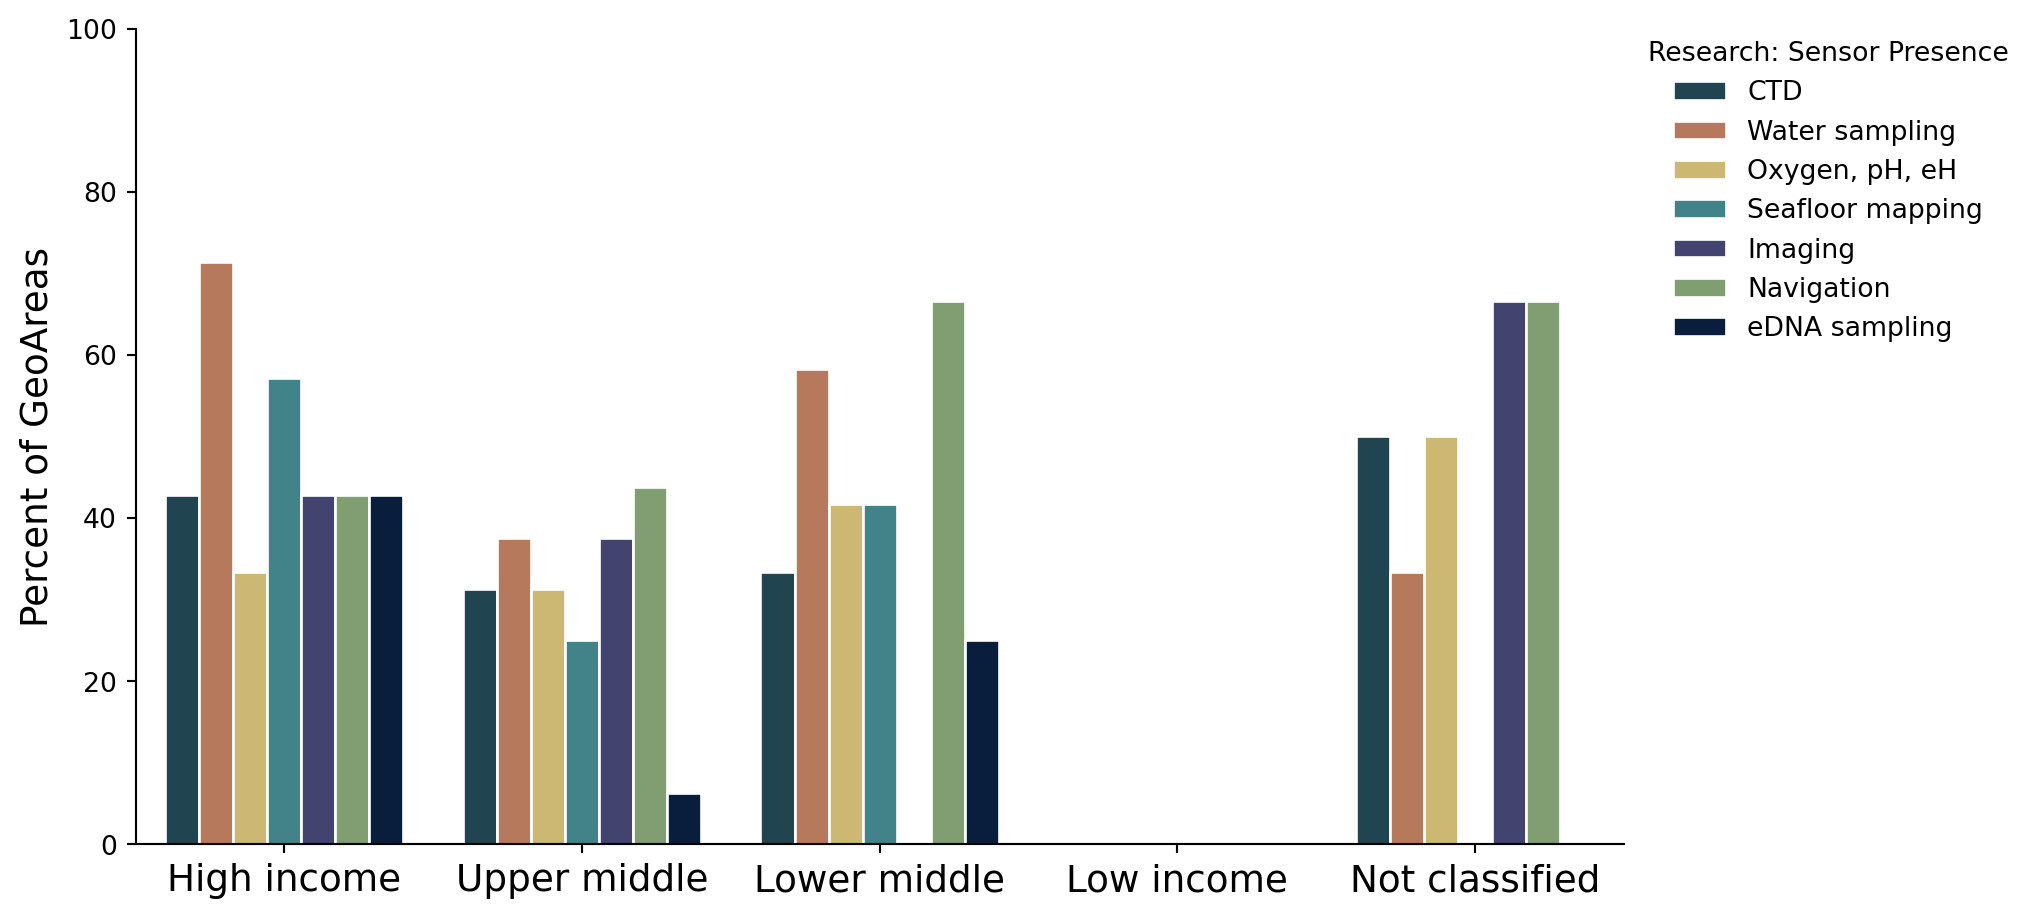

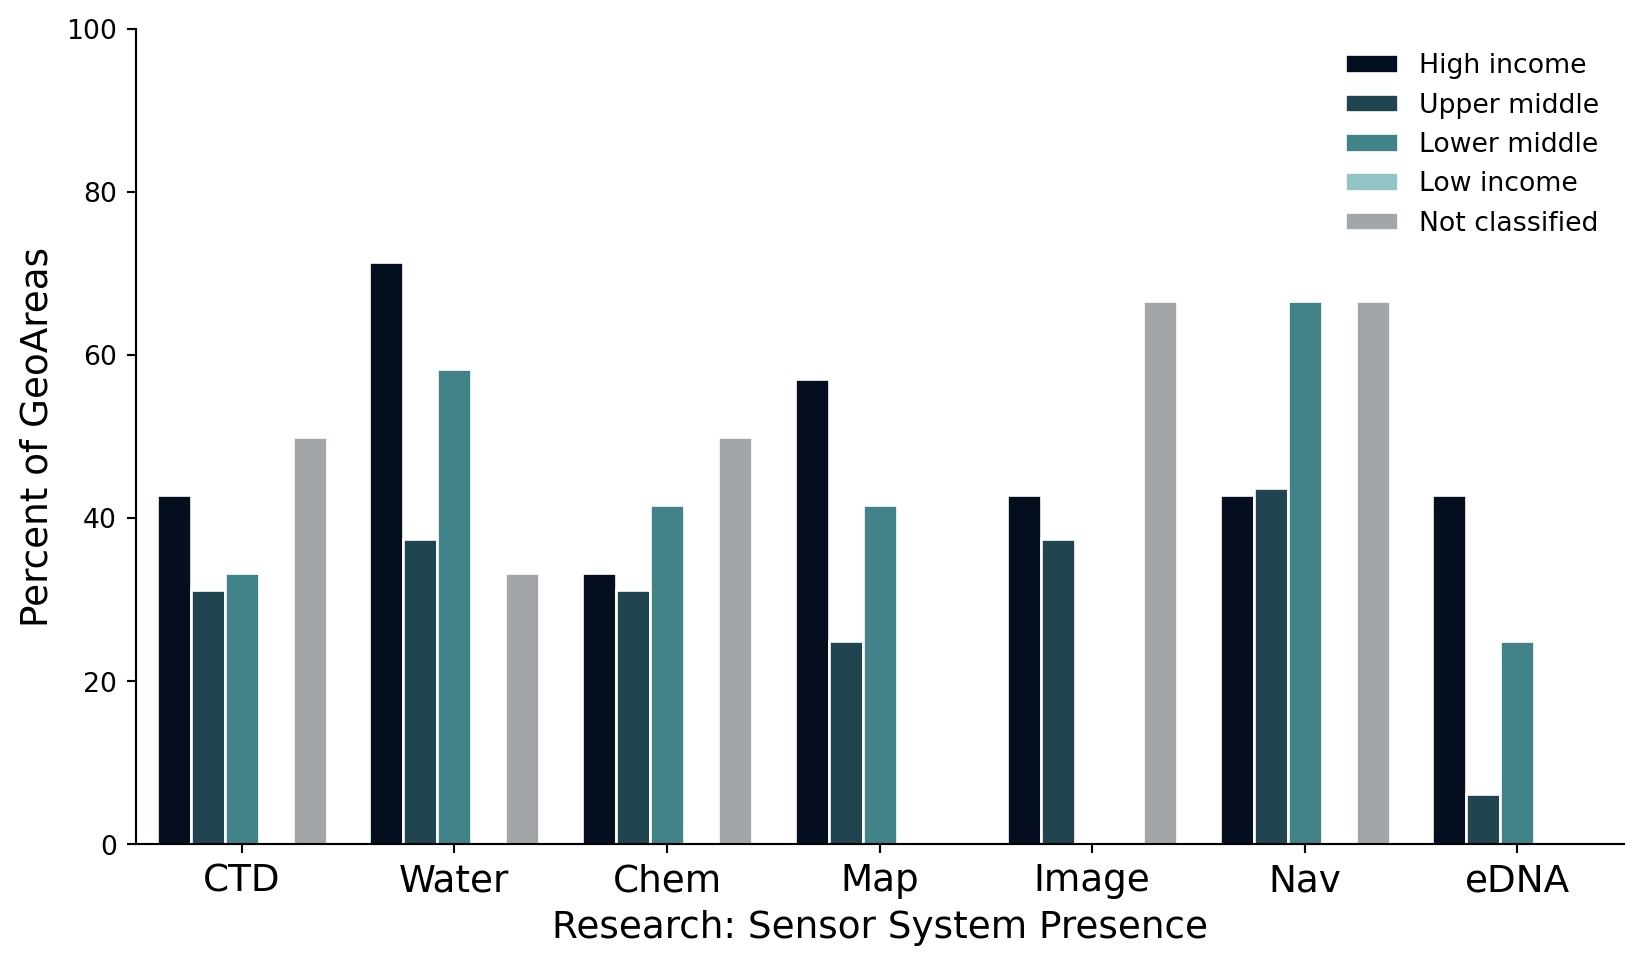

In [162]:
## Create plot

w = 1920
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
    ax = sns.barplot(x='subregion',
                     y='percent',
                     hue='col_name',
                     order=label_order[region],
                     hue_order=hue_order,
                     palette=cat_07,
                     ci=None,
                     edgecolor='white',
                     data=fig_data[region])            

    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=14)
    ax.set(xlabel=None)
    ax.set_ylim([0, 100])
    ax.set_ylabel('Percent of GeoAreas', fontsize=14)
    ax.legend(bbox_to_anchor=(1, 1.015),
              loc='upper left',
              title='Research: Sensor Presence',
              fontsize=10,
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='8', letter='S1')

    ## S2

    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
    ax = sns.barplot(x='col_name',
                     y='percent',
                     hue='subregion',
                     order=hue_order,
                     hue_order=label_order[region],
                     palette=cat_d23e123_by_region[region],
                     ci=None,
                     edgecolor='white',
                     data=fig_data[region])            

    ax.set_xticklabels(['CTD', 'Water', 'Chem', 'Map', 'Image', 'Nav', 'eDNA'], rotation=0, fontsize=14)
    ax.set_xlabel('Research: Sensor System Presence', fontsize=14)
    ax.set_ylim([0, 100])
    ax.set_ylabel('Percent of GeoAreas', fontsize=14)
    ax.legend(loc='upper right',
              fontsize=10,
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='8', letter='S2')

## **Figs T1 T2**&nbsp; Q24: Sensor Access

In [163]:
## Get data for figure - using num respondents for aggregated calculations & denominators

label_order = {}
fig_data = {}
percent_data = {}
for region in region_list:
    vessels = dataR[region].loc[dataR[region]['question'] == 'Q24', ['subregion', 
                                                   'geoarea', 
                                                   'respondent_id', 
                                                   'selection_survey_clean']]
    vessels = vessels[vessels['selection_survey_clean'] != '']

    fig_data[region] = (vessels.groupby(['subregion', 'selection_survey_clean'])['respondent_id']
                       .nunique()
                       .rename('count')
                       .reset_index())

    renames = {
        'CTD':            'CTD',
        'Water sampling':                               'Water sampling',
        'Oxygen, pH, and/or eH':                        'Oxygen, pH, eH',
        'Seafloor mapping (sidescan and/or multibeam)': 'Seafloor mapping',
        'Imaging (still and/or video)':                 'Imaging',
        'Navigation/tracking (USBL, LBL, etc.)':        'Navigation',
        'eDNA sampling':                                'eDNA sampling',
        'Other':                                        'Other',
        'None of the above':                            'None of the above',
    }
    hue_order = renames.values()
    fig_data[region]['selection_survey_clean'].replace(renames, inplace=True)
    fig_data[region]['subregion'].replace(label_adjustments, inplace=True)
    vessels['subregion'].replace(label_adjustments, inplace=True)
    label_order[region] = []
    for x in orderR[region]:
        if x in label_adjustments:
            label_order[region].append(label_adjustments[x])
        else:
            label_order[region].append(x)

    # Calculate percentages
    percent_data[region] = fig_data[region].copy()
    num_respondents_per_subregion = vessels.groupby('subregion')['respondent_id'].nunique().reset_index()
    respondent_sub_dict = dict(zip(num_respondents_per_subregion['subregion'], 
                                   num_respondents_per_subregion['respondent_id']))
    percent_data[region]['total'] = percent_data[region]['subregion']
    percent_data[region]['total'].replace(respondent_sub_dict, inplace=True)
    percent_data[region]['percent'] = round((percent_data[region]['count']/percent_data[region]['total'])*100, 2)

    pivoted = percent_data[region].pivot(columns='subregion', index='selection_survey_clean', values=['count', 'percent'])
    pivoted.loc['Total'] = num_respondents_per_subregion['respondent_id'].tolist()*2
    num_respondents = vessels['respondent_id'].nunique()
    pivoted.loc['Total', 'percent'] = round((pivoted.loc['Total', 'percent']/num_respondents)*100, 2).values

    pivoted[('count', 'Total')] = pivoted['count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_respondents)*100, 2)

    #display(pivoted)

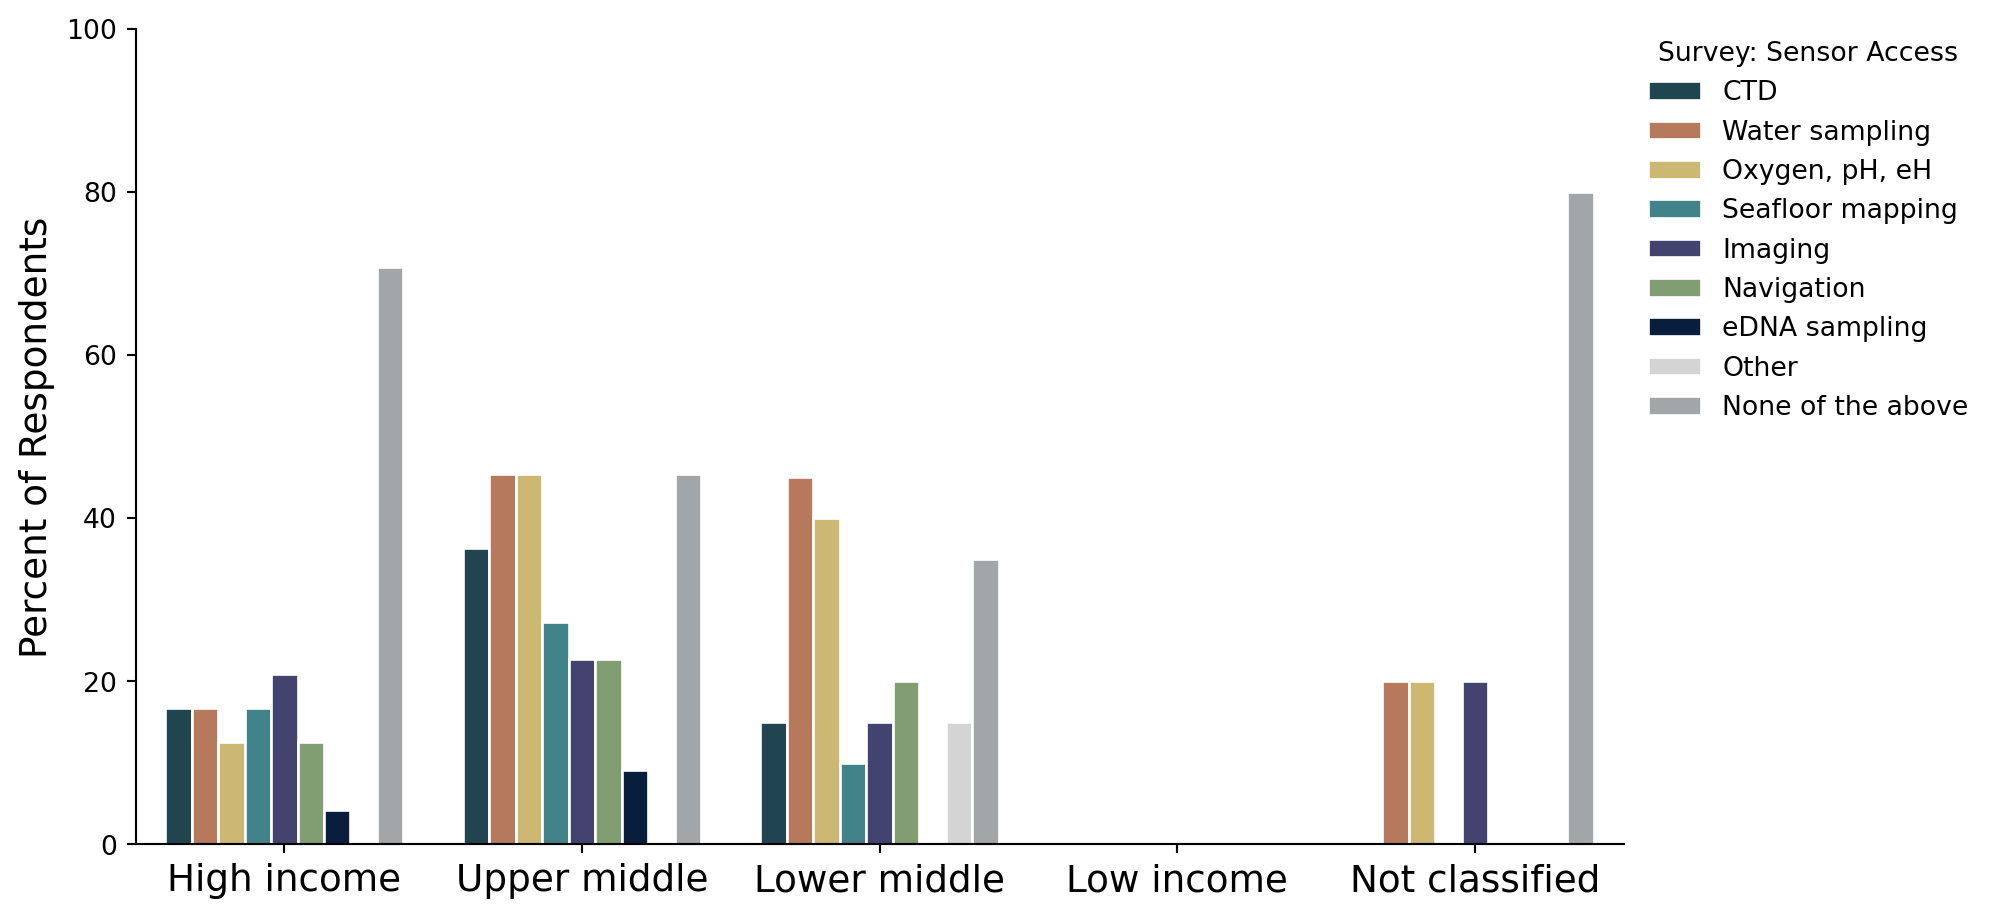

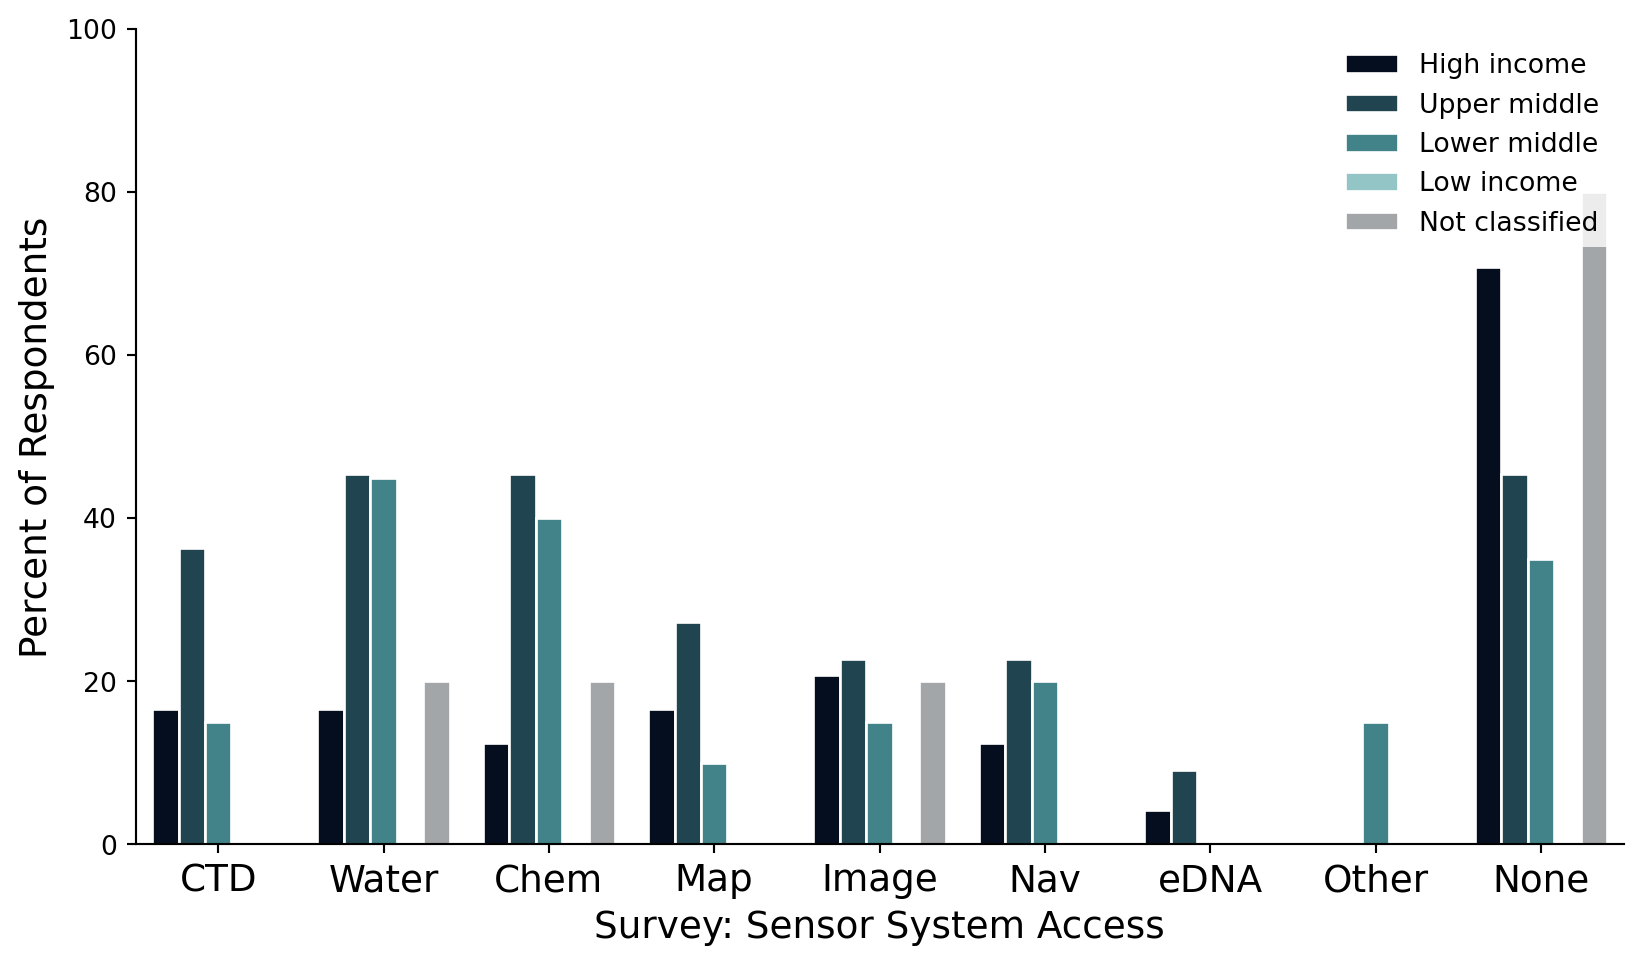

In [164]:
## Create plot

w = 1920
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
    ax = sns.barplot(x='subregion',
                     y='percent',
                     hue='selection_survey_clean',
                     order=label_order[region],
                     hue_order=hue_order,
                     palette=cat_07 + ['#a2a6a9'],
                     edgecolor='white',
                     ci=None,
                     data=percent_data[region])            

    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=14)
    ax.set(xlabel=None)
    ax.set_ylim([0, 100])
    ax.set_ylabel('Percent of Respondents', fontsize=14)
    loc_tweaks = {}
    ax.legend(bbox_to_anchor=(1, 1.015), loc=loc_tweaker(region, loc_tweaks),
              title='Survey: Sensor Access',
              fontsize=10,
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='8', letter='T1')

    ## T2

    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
    ax = sns.barplot(x='selection_survey_clean',
                     y='percent',
                     hue='subregion',
                     order=hue_order,
                     hue_order=label_order[region],
                     palette=cat_d23e123_by_region[region],
                     edgecolor='white',
                     ci=None,
                     data=percent_data[region])            

    ax.set_xticklabels(['CTD', 'Water', 'Chem', 'Map', 'Image', 'Nav', 'eDNA', 'Other', 'None'], rotation=0, fontsize=14)
    ax.set_xlabel('Survey: Sensor System Access', fontsize=14)
    ax.set_ylim([0, 100])
    ax.set_ylabel('Percent of Respondents', fontsize=14)
    loc_tweaks = {}
    ax.legend(loc='upper right',
              fontsize=10,
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='8', letter='T2')

## **Fig U1**&nbsp; Q25: Sensor satisfaction

In [165]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Very dissatisfied', 
            'Dissatisfied', 
            'Neutral', 
            'Satisfied', 
            'Very satisfied']

satisfaction = {}
missing_responses = {}
fig_data = {}
for region in region_list:
    satisfaction[region] = dataR[region].loc[dataR[region]['question'] == 'Q25', ['col_name', 
                                                   'subregion', 
                                                   'geoarea', 
                                                   'respondent_id', 
                                                   'selection',
                                                   'selection_other']]
    satisfaction[region].loc[(satisfaction[region]['col_name'] == 'Q25_other') & 
                     (satisfaction[region]['selection'] != ''), 'selection_other'] = 'Other'

    missing_responses[region] = satisfaction[region][satisfaction[region]['selection_other'] == ''].copy()

    satisfaction[region] = satisfaction[region][~satisfaction[region]['selection_other'].isin(['Other', ''])]

    # There's a note in the spreadsheet to exclude duration here
    satisfaction[region] = satisfaction[region][satisfaction[region]['col_name'] != 'Q25_duration']

    satisfaction[region]['row_num'] = np.arange(satisfaction[region].shape[0])

    fig_data[region] = satisfaction[region].pivot(columns='subregion', index='row_num', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')
    
    # Change scale values
    fig_data[region].replace({'1 - Very dissatisfied': 'Very dissatisfied',
                      '2 - Dissatisfied': 'Dissatisfied',
                      '3 - Neither satisfied nor dissatisfied': 'Neutral',
                      '4 - Satisfied': 'Satisfied',
                      '5 - Very satisfied': 'Very satisfied'}, inplace=True)

Adding missing column Low income
Adding missing column Not classified


In [166]:
## Calculate statistics

for region in region_list:
    ## Calculate number of people who chose NA for each question and subregion - recall that one individual could choose 
    ## NA for more than one question
    stats = missing_responses[region].groupby(['col_name', 'subregion'])['respondent_id'].nunique().rename('count').reset_index()
    stats = stats.pivot(columns='subregion', index='col_name', values='count')
    stats['Total'] = stats.sum(axis=1)
    #display(stats)

    ## Calculate the number of people who chose NA on at least one part of the question - EXCLUDING OTHER
    #display(missing_responses[region].loc[missing_responses[region]['col_name'] != 'Q25_other', 'respondent_id'].nunique())

    percent_data = (satisfaction[region].groupby(['subregion', 'selection'])['row_num']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = satisfaction[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

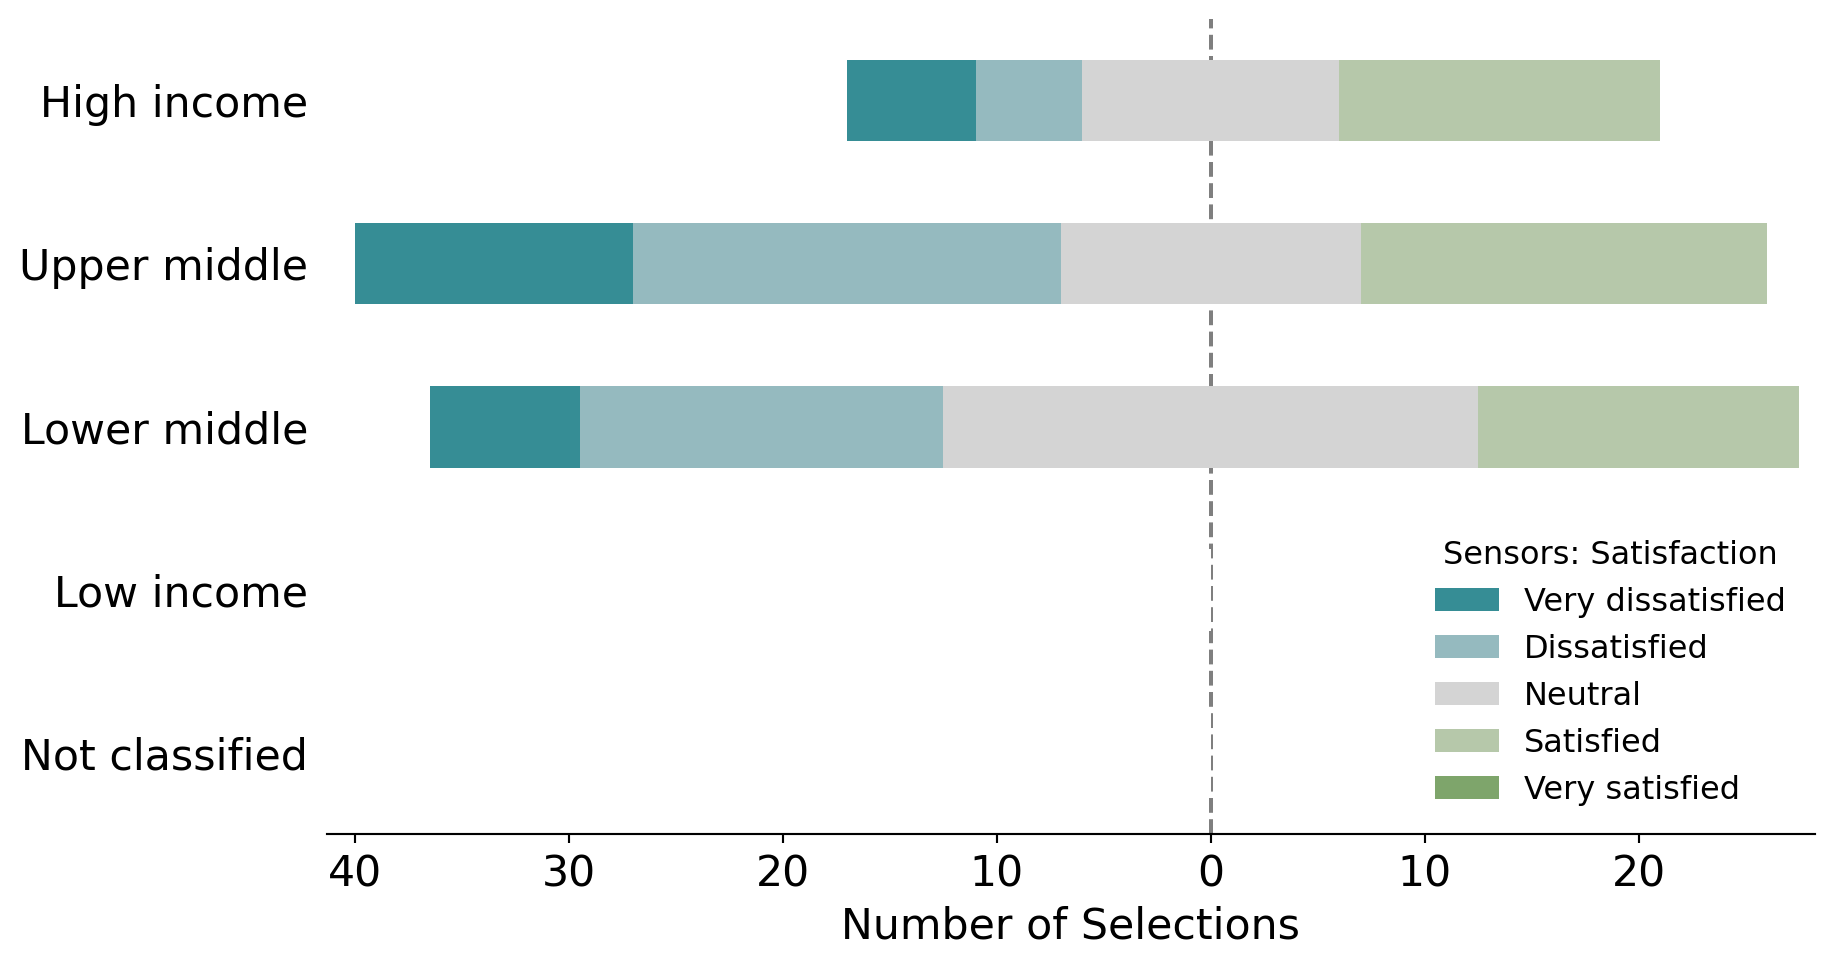

In [167]:
## Create plot

w = 1920
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Selections', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {'Global': 'upper left'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='Sensors: Satisfaction',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='8', letter='U1')

## **Fig U2**&nbsp; Sensor satisfaction #2

In [168]:
## Calculate values for plot
#note: reuses satisfaction data from previous figure

# Define scale for plot
my_scale = ['Very dissatisfied', 
            'Dissatisfied', 
            'Neutral', 
            'Satisfied', 
            'Very satisfied']

fig_data = {}
for region in region_list:
    fig_data[region] = satisfaction[region].pivot(columns='col_name', index='respondent_id', values='selection')

    # Change column names
    fig_data[region].columns = ['Accuracy', 'Availability', 'Capabilities', 'Cost', 'Depth', 'Ease']

    # Change column order
    sorted_cols = ['Cost', 'Availability', 'Capabilities', 'Depth', 'Ease', 'Accuracy']
    fig_data[region] = reorder_columns(fig_data[region], sorted_cols)

    # Change scale values
    fig_data[region].replace({
                      '1 - Very dissatisfied': 'Very dissatisfied',
                      '2 - Dissatisfied': 'Dissatisfied',
                      '3 - Neither satisfied nor dissatisfied': 'Neutral',
                      '4 - Satisfied': 'Satisfied',
                      '5 - Very satisfied': 'Very satisfied'}, inplace=True)

In [169]:
## Calculate statistics

for region in region_list:
    percent_data = (satisfaction[region].groupby(['col_name', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['col_name']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='col_name', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = satisfaction[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

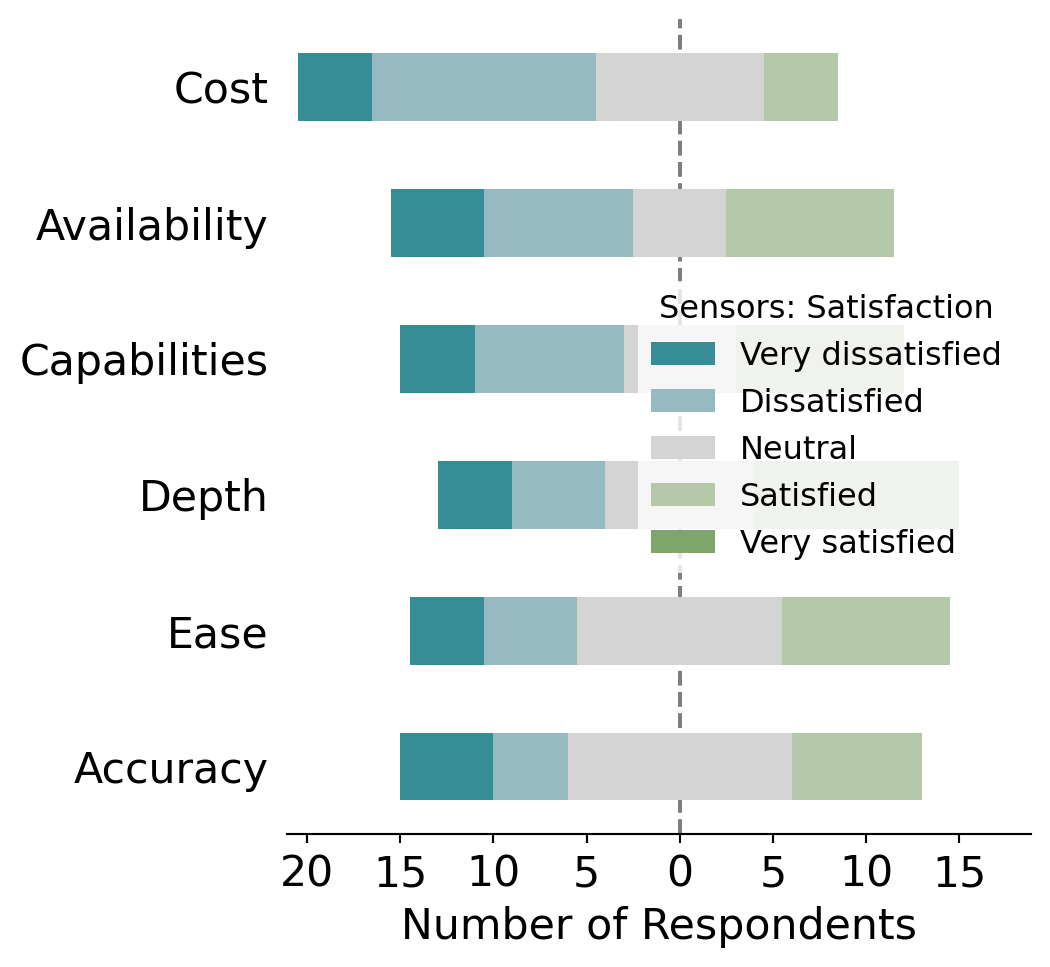

In [170]:
## Create plot

w = 960
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='Sensors: Satisfaction',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='8', letter='U2')

## **Fig U3**&nbsp; Q25a: Sensor cost

In [171]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Very dissatisfied', 
            'Dissatisfied', 
            'Neutral', 
            'Satisfied', 
            'Very satisfied']

cost = {}
fig_data = {}
for region in region_list:
    cost[region] = dataR[region].loc[(dataR[region]['col_name'] == 'Q25_cost') &
                    (dataR[region]['selection'] != ''), 
                          ['respondent_id', 'subregion', 'col_name', 'selection']]

    fig_data[region] = cost[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({
                      '1 - Very dissatisfied': 'Very dissatisfied',
                      '2 - Dissatisfied': 'Dissatisfied',
                      '3 - Neither satisfied nor dissatisfied': 'Neutral',
                      '4 - Satisfied': 'Satisfied',
                      '5 - Very satisfied': 'Very satisfied'}, inplace=True)

Adding missing column Low income
Adding missing column Not classified


In [172]:
## Calculate statistics

for region in region_list:
    percent_data = (cost[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = cost[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

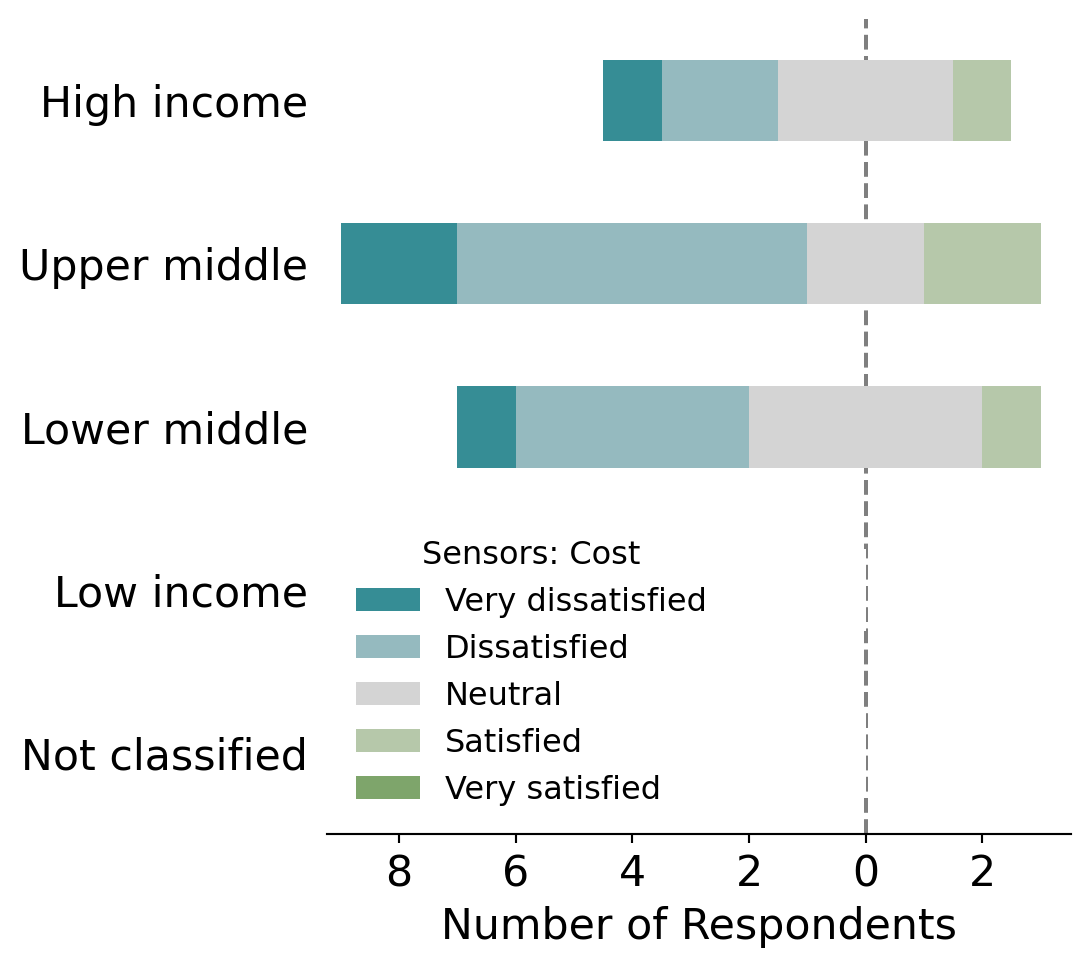

In [173]:
## Create plot

w = 960
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {'Africa': 'lower left', 'Global': 'upper left'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='Sensors: Cost',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='8', letter='U3')

## **Fig U4**&nbsp; Q25b: Sensor availability

In [174]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Very dissatisfied', 
            'Dissatisfied', 
            'Neutral', 
            'Satisfied', 
            'Very satisfied']

availability = {}
fig_data = {}
for region in region_list:
    availability[region] = dataR[region].loc[(dataR[region]['col_name'] == 'Q25_availability') &
                    (dataR[region]['selection'] != ''), 
                          ['respondent_id', 'subregion', 'col_name', 'selection']]

    fig_data[region] = availability[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({'1 - Very dissatisfied': 'Very dissatisfied',
                      '2 - Dissatisfied': 'Dissatisfied',
                      '3 - Neither satisfied nor dissatisfied': 'Neutral',
                      '4 - Satisfied': 'Satisfied',
                      '5 - Very satisfied': 'Very satisfied'}, inplace=True)

Adding missing column Low income
Adding missing column Not classified


In [175]:
## Calculate statistics

for region in region_list:
    percent_data = (availability[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = availability[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

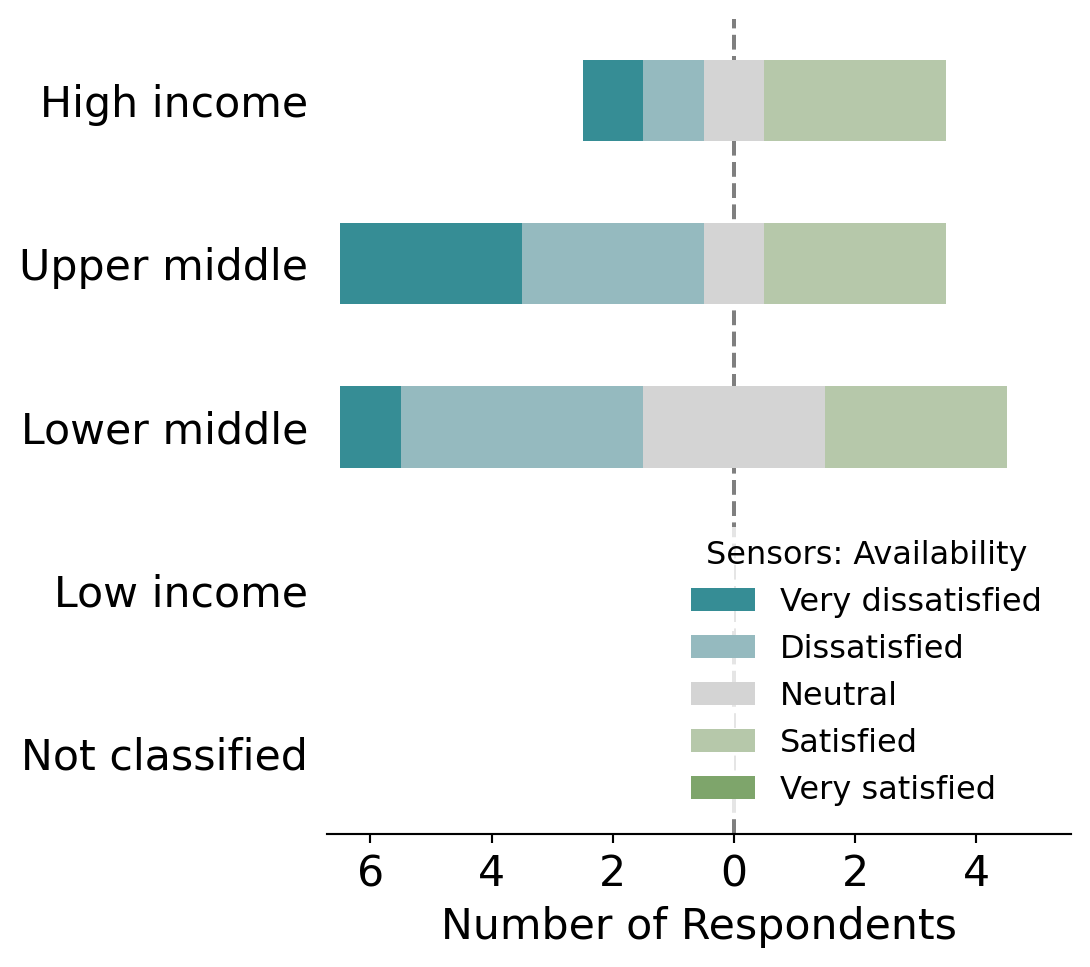

In [176]:
## Create plot

w = 960
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {'Africa': 'lower left', 'Americas': 'lower right', 'Asia': 'lower left', 'Economies': 'lower right', 'Global': 'upper left', 'Oceania': 'upper right', 'SIDS': 'lower right'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='Sensors: Availability',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='8', letter='U4')

## **Fig U5**&nbsp; Q25c: Sensor capabilities

In [177]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Very dissatisfied', 
            'Dissatisfied', 
            'Neutral', 
            'Satisfied', 
            'Very satisfied']

capabilities = {}
fig_data = {}
for region in region_list:
    capabilities[region] = dataR[region].loc[(dataR[region]['col_name'] == 'Q25_capabilities') &
                    (dataR[region]['selection'] != ''), 
                          ['respondent_id', 'subregion', 'col_name', 'selection']]

    fig_data[region] = capabilities[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({
                      '1 - Very dissatisfied': 'Very dissatisfied',
                      '2 - Dissatisfied': 'Dissatisfied',
                      '3 - Neither satisfied nor dissatisfied': 'Neutral',
                      '4 - Satisfied': 'Satisfied',
                      '5 - Very satisfied': 'Very satisfied'}, inplace=True)

Adding missing column Low income
Adding missing column Not classified


In [178]:
## Calculate statistics

for region in region_list:
    percent_data = (capabilities[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = capabilities[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

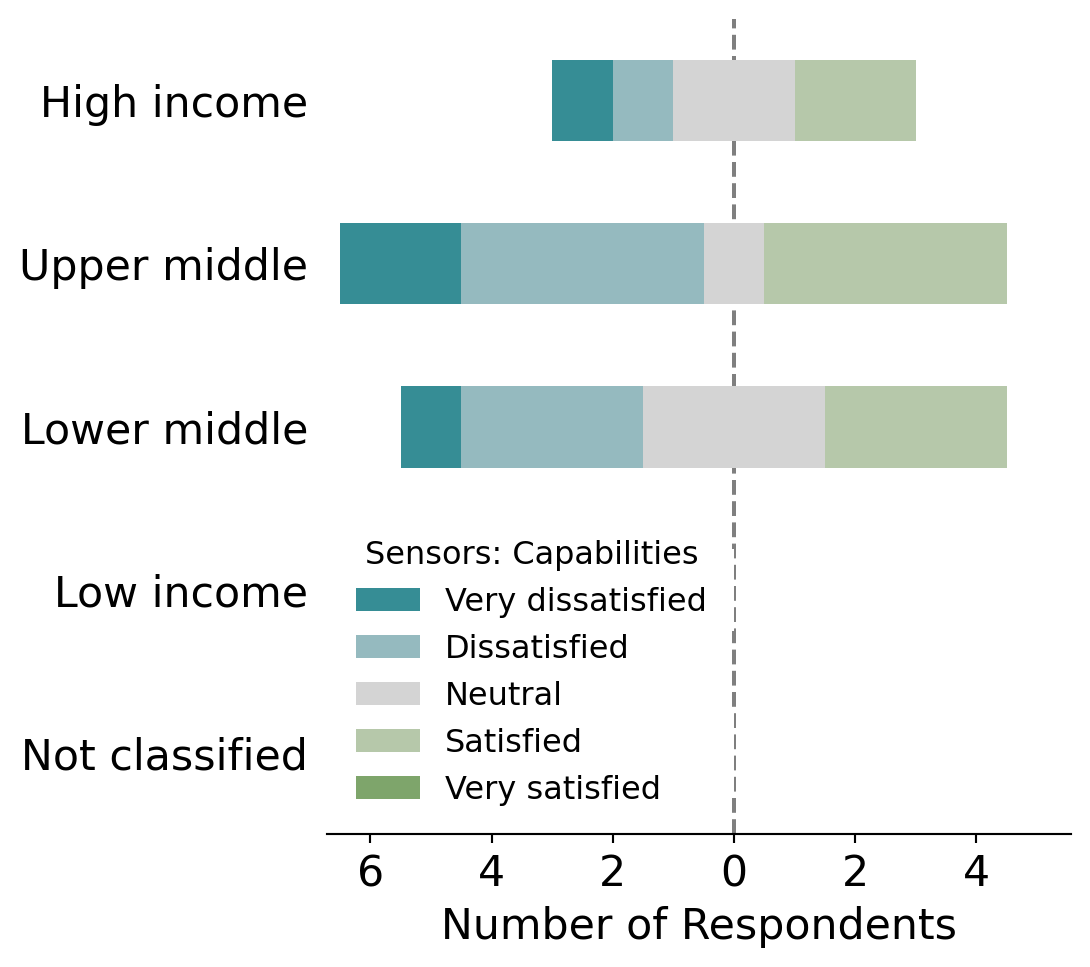

In [179]:
## Create plot

w = 960
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {'Global': 'upper left'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='Sensors: Capabilities',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='8', letter='U5')

## **Fig U6**&nbsp; Q25d: Sensor depth

In [180]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Very dissatisfied', 
            'Dissatisfied', 
            'Neutral', 
            'Satisfied', 
            'Very satisfied']

depth = {}
fig_data = {}
for region in region_list:
    depth[region] = dataR[region].loc[(dataR[region]['col_name'] == 'Q25_depth') &
                    (dataR[region]['selection'] != ''), 
                          ['respondent_id', 'subregion', 'col_name', 'selection']]

    fig_data[region] = depth[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({
                      '1 - Very dissatisfied': 'Very dissatisfied',
                      '2 - Dissatisfied': 'Dissatisfied',
                      '3 - Neither satisfied nor dissatisfied': 'Neutral',
                      '4 - Satisfied': 'Satisfied',
                      '5 - Very satisfied': 'Very satisfied'}, inplace=True)

Adding missing column Low income
Adding missing column Not classified


In [181]:
## Calculate statistics

for region in region_list:
    percent_data = (depth[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = depth[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

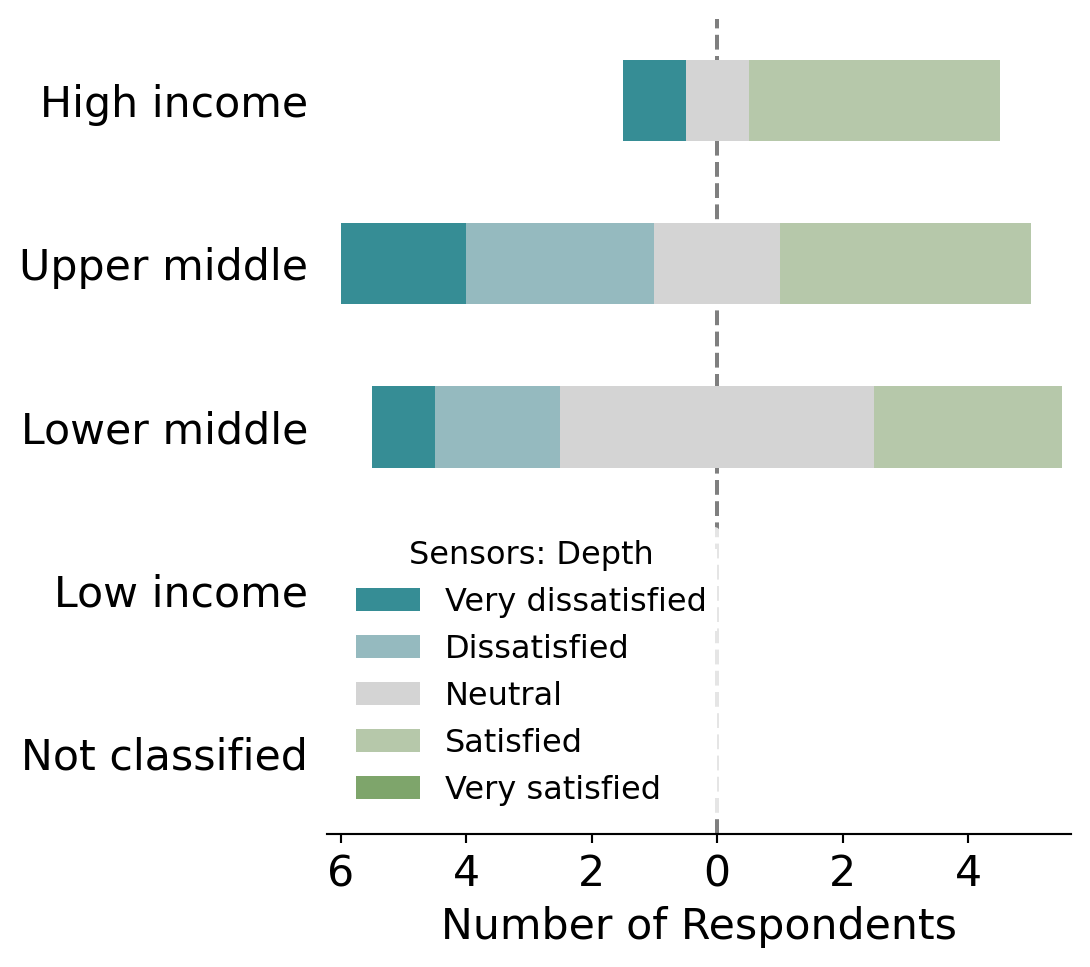

In [182]:
## Create plot

w = 960
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {'Africa': 'lower right', 'Europe': 'upper right', 'Global': 'upper left', 'Oceania': 'upper right'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='Sensors: Depth',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='8', letter='U6')

## **Fig U7**&nbsp; Q25e: Sensor ease of use

In [183]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Very dissatisfied', 
            'Dissatisfied', 
            'Neutral', 
            'Satisfied', 
            'Very satisfied']

ease = {}
fig_data = {}
for region in region_list:
    ease[region] = dataR[region].loc[(dataR[region]['col_name'] == 'Q25_ease') &
                    (dataR[region]['selection'] != ''), 
                          ['respondent_id', 'subregion', 'col_name', 'selection']]

    fig_data[region] = ease[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({
                      '1 - Very dissatisfied': 'Very dissatisfied',
                      '2 - Dissatisfied': 'Dissatisfied',
                      '3 - Neither satisfied nor dissatisfied': 'Neutral',
                      '4 - Satisfied': 'Satisfied',
                      '5 - Very satisfied': 'Very satisfied'}, inplace=True)

Adding missing column Low income
Adding missing column Not classified


In [184]:
## Calculate statistics

for region in region_list:
    percent_data = (ease[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = ease[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

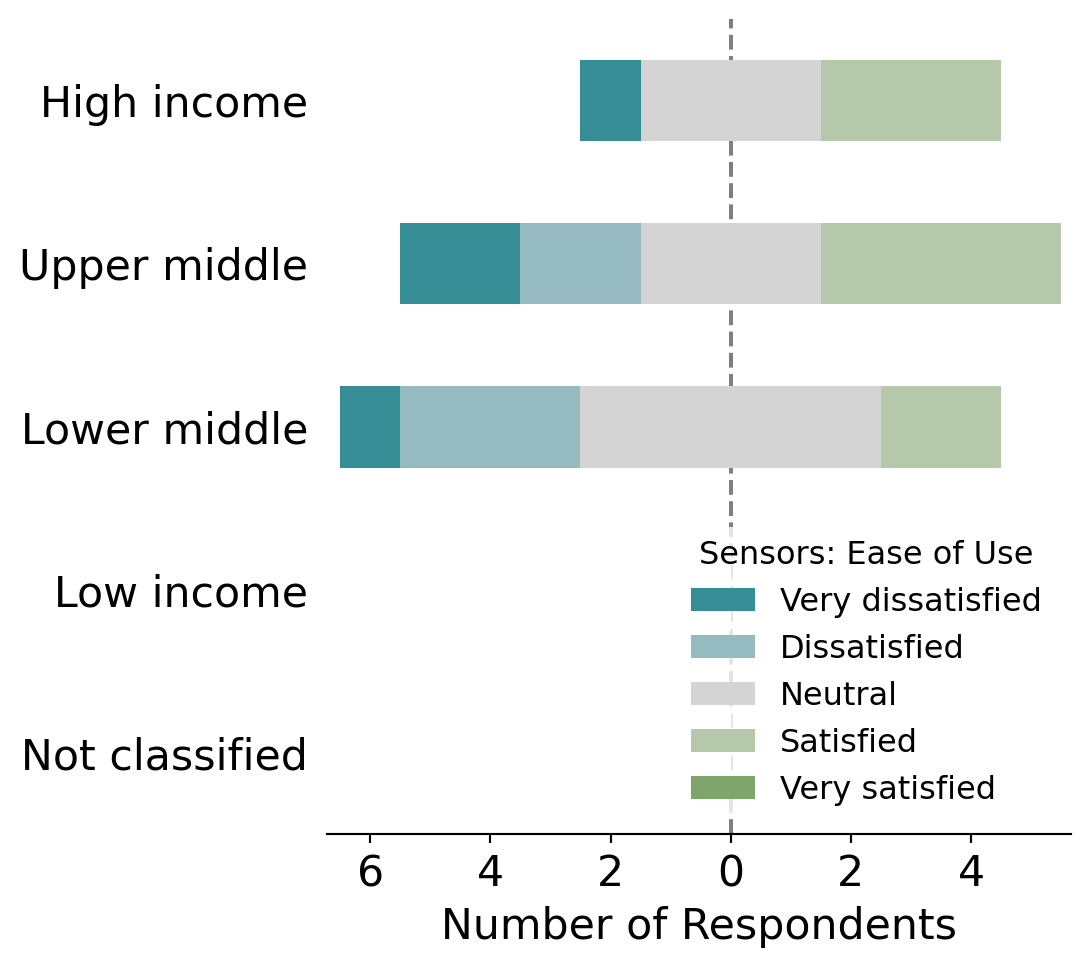

In [185]:
## Create plot

w = 960
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {'Global': 'upper left', 'SIDS': 'lower right'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='Sensors: Ease of Use',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='8', letter='U7')

## **Fig U8**&nbsp; Q25f: Sensor accuracy

In [186]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Very dissatisfied', 
            'Dissatisfied', 
            'Neutral', 
            'Satisfied', 
            'Very satisfied']

accuracy = {}
fig_data = {}
for region in region_list:
    accuracy[region] = dataR[region].loc[(dataR[region]['col_name'] == 'Q25_accuracy') &
                    (dataR[region]['selection'] != ''), 
                          ['respondent_id', 'subregion', 'col_name', 'selection']]

    fig_data[region] = accuracy[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({
                      '1 - Very dissatisfied': 'Very dissatisfied',
                      '2 - Dissatisfied': 'Dissatisfied',
                      '3 - Neither satisfied nor dissatisfied': 'Neutral',
                      '4 - Satisfied': 'Satisfied',
                      '5 - Very satisfied': 'Very satisfied'}, inplace=True)

Adding missing column Low income
Adding missing column Not classified


In [187]:
## Calculate statistics

for region in region_list:
    percent_data = (accuracy[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = accuracy[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

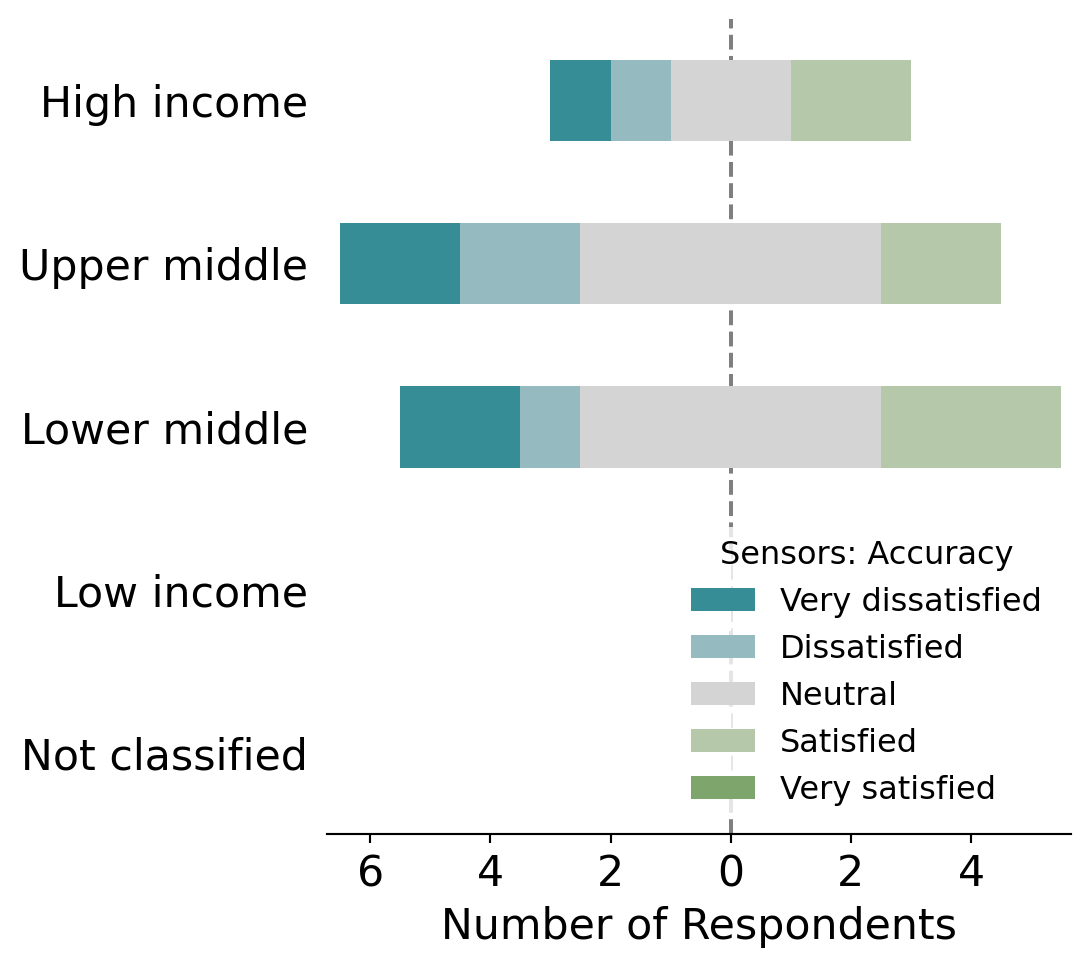

In [188]:
## Create plot

w = 960
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {'Global': 'upper left', 'SIDS': 'lower right'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='Sensors: Accuracy',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='8', letter='U8')

## **Fig V1**&nbsp; Q23: Sensor importance

In [189]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Not important', 
            'A little important', 
            'Somewhat important',
            'Important',
            'Very important']

importance = {}
fig_data = {}
for region in region_list:
    importance[region] = dataR[region].loc[(dataR[region]['question'] == 'Q23'), ['respondent_id', 'subregion', 'col_name', 'selection']]

    fig_data[region] = importance[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({
                      '1 - Not important': 'Not important',
                      '2 - A little important': 'A little important',
                      '3 - Somewhat important': 'Somewhat important',
                      '4 - Important': 'Important',
                      '5 - Very important': 'Very important'}, inplace=True)

Adding missing column Low income


In [190]:
## Calculate statistics

for region in region_list:
    percent_data = (importance[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = importance[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

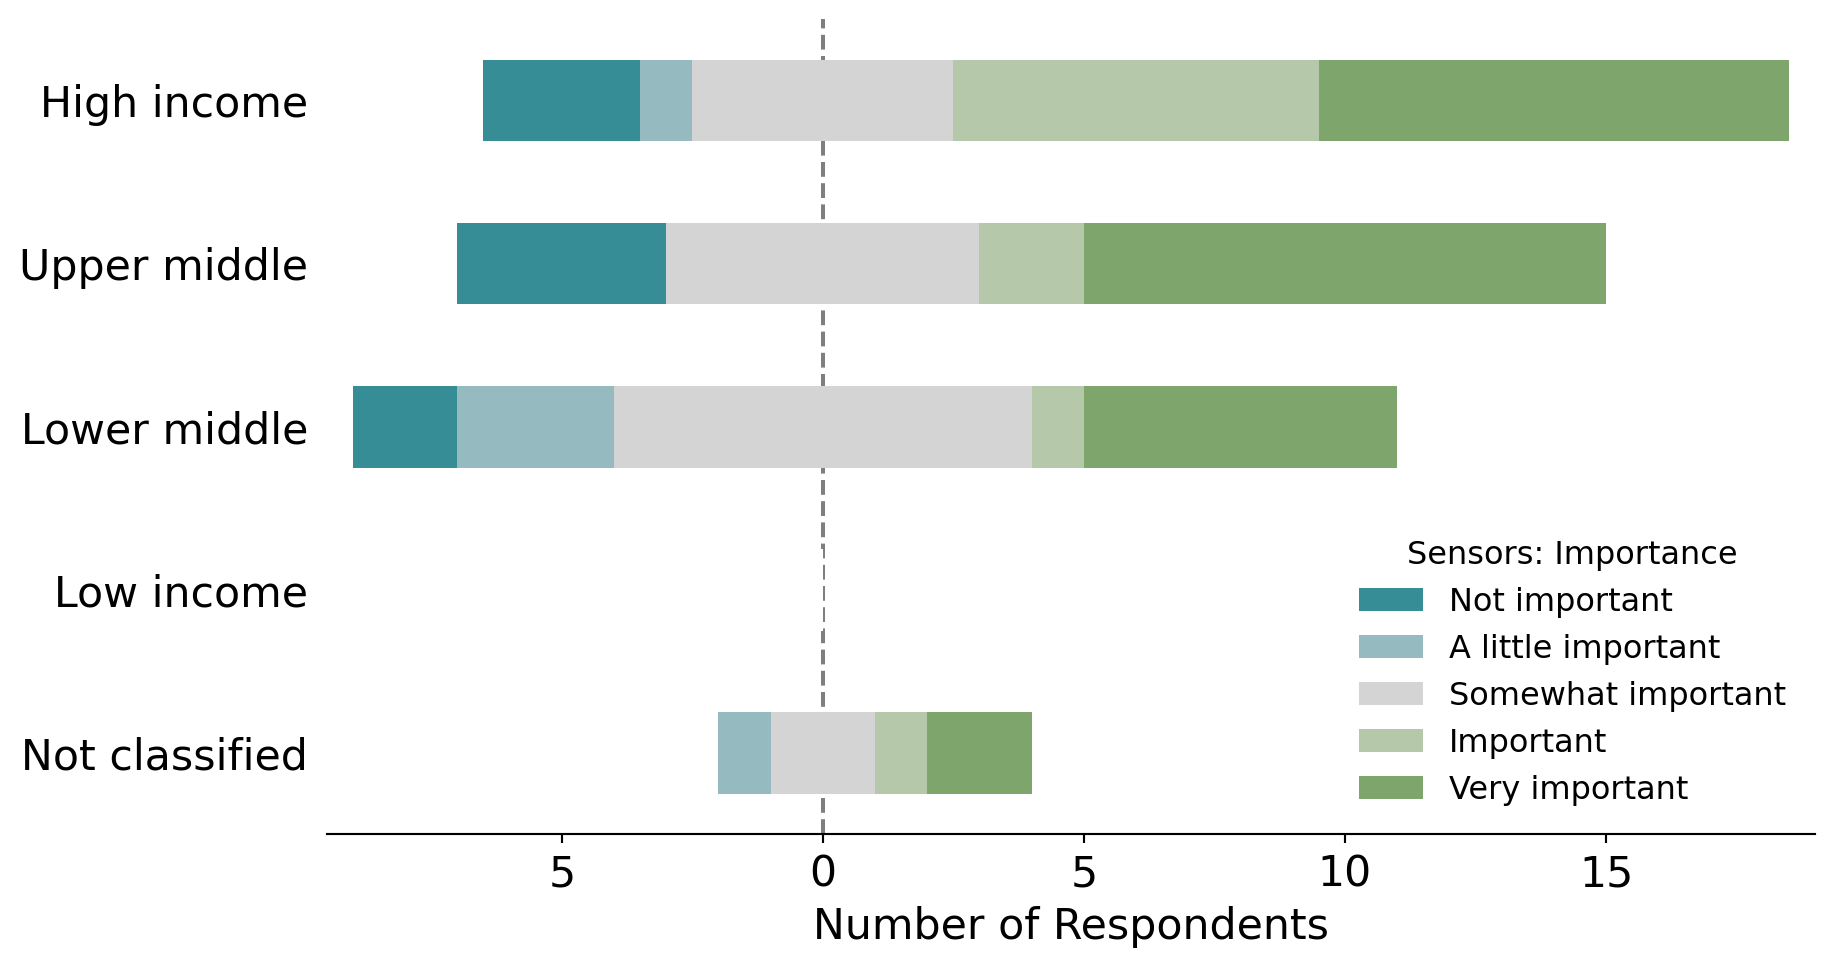

In [191]:
## Create plot

w = 1920
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='Sensors: Importance',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='8', letter='V1')

## **Fig V2**&nbsp; Q26: Sensor potential

In [192]:
## Calculate values for plot

# Define scale for plot
my_scale = ['No impact', 
            'Little impact', 
            'Moderate impact',
            'High impact',
            'Transformative']

potential = {}
fig_data = {}
for region in region_list:
    potential[region] = dataR[region].loc[(dataR[region]['question'] == 'Q26'), ['respondent_id', 'subregion', 'col_name', 'selection']]

    fig_data[region] = potential[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({
                      '1 - No impact': 'No impact',
                      '2 - Little impact': 'Little impact',
                      '3 - Moderate impact': 'Moderate impact',
                      '4 - High impact': 'High impact',
                      '5 - Transformative': 'Transformative'}, inplace=True)

Adding missing column Low income


In [193]:
## Calculate statistics

for region in region_list:
    percent_data = (potential[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = potential[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

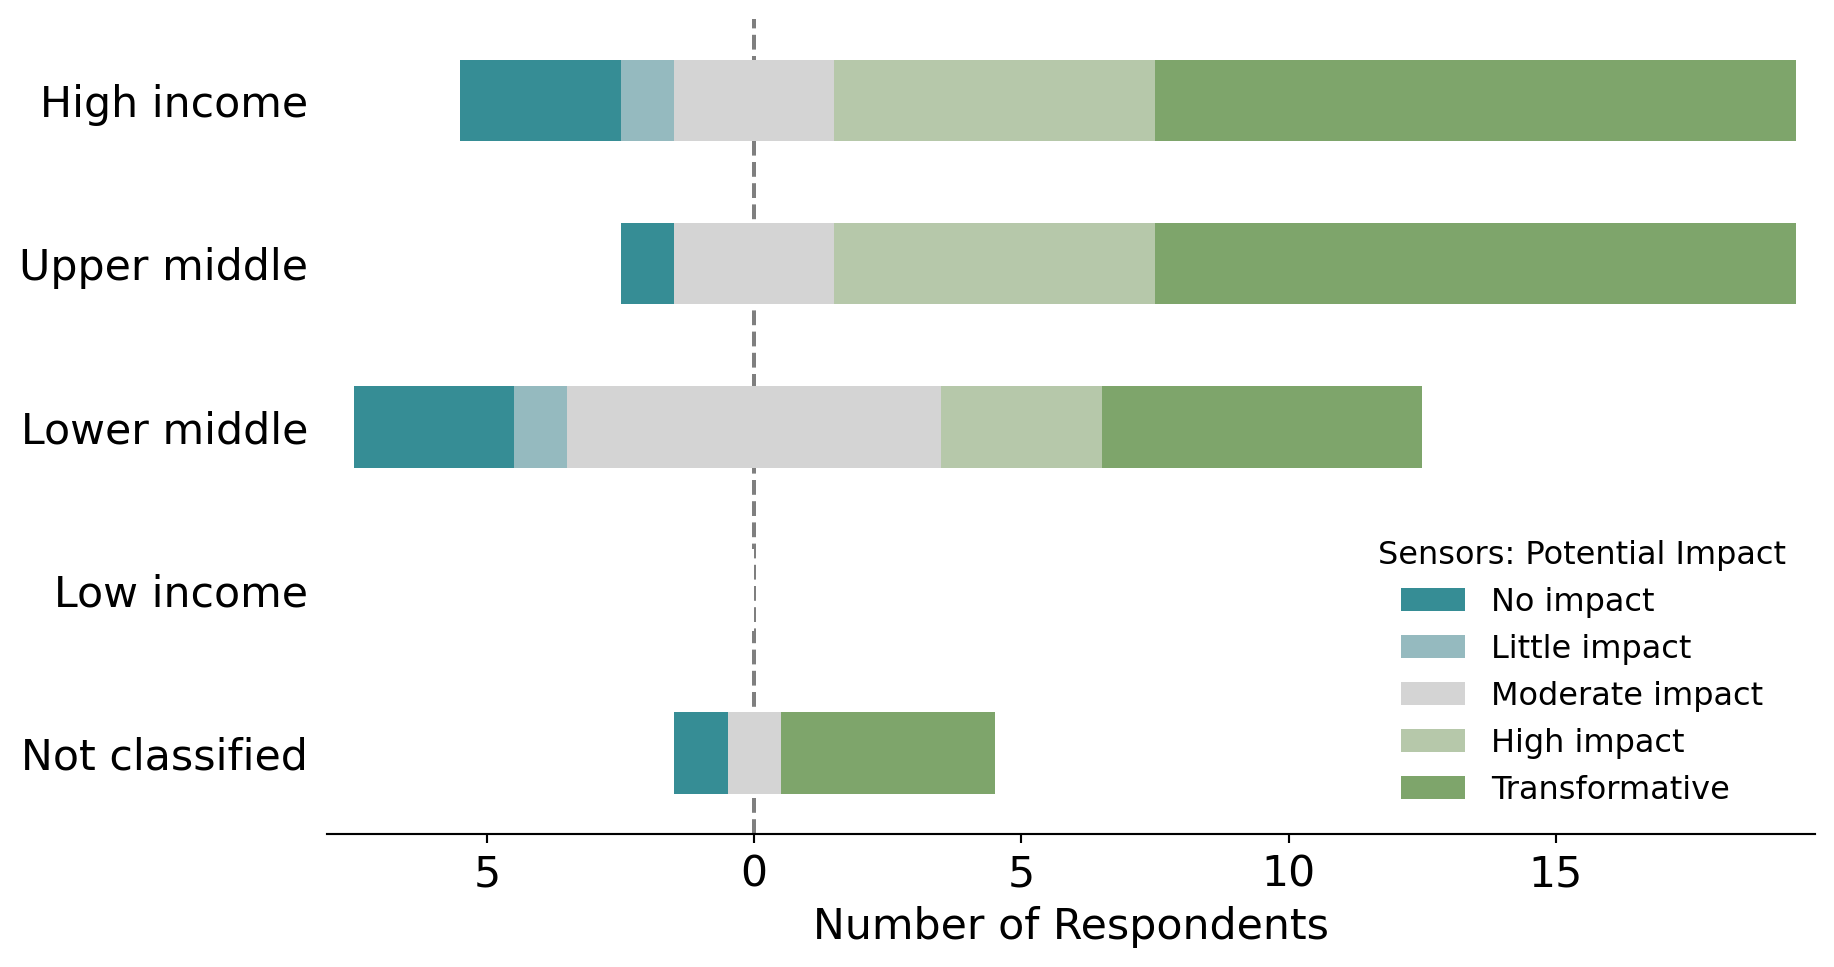

In [194]:
## Create plot

w = 1920
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='Sensors: Potential Impact',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='8', letter='V2')

---
# **Section 9**

## **Figs W1 W2**&nbsp; Data tools presence

In [195]:
## Calculate values for plot

label_order = {}
fig_data = {}
for region in region_list:
    data_presence = researchR[region].loc[(researchR[region]['question'] == 'Q29') &
                                   (researchR[region]['col_name'] != 'Q29_comments'), ['geoarea',
                                                                              'col_name',
                                                                              'subregion',
                                                                              'research_tech_clean']]
    data_presence['selection_binary'] = data_presence['research_tech_clean']

    fig_data[region] = (data_presence.groupby(['subregion', 'col_name'])['selection_binary']
                    .sum()
                    .rename('count')
                    .reset_index())

    num_areas_per_subregion = data_presence.groupby('subregion')['geoarea'].nunique()
    num_areas_dict = dict(zip(num_areas_per_subregion.index, num_areas_per_subregion.values))
    fig_data[region]['total'] = fig_data[region]['subregion']
    fig_data[region]['total'].replace(num_areas_dict, inplace=True)

    fig_data[region]['percent'] = round((fig_data[region]['count']/fig_data[region]['total'])*100, 2)

    renames = {
        'Q29_gis':             'GIS',
        'Q29_data_management': 'Data management',
        'Q29_data_storage':    'Data storage',
        'Q29_data_viz':        'Data visualization',
        'Q29_cloud':           'Cloud computing',
        'Q29_sequencing':      'Genomic sequencing',
        'Q29_ml':              'ML/AI',
    }
    hue_order = renames.values()
    fig_data[region]['col_name'].replace(renames, inplace=True)
    fig_data[region]['subregion'].replace(label_adjustments, inplace=True)
    label_order[region] = []
    for x in orderR[region]:
        if x in label_adjustments:
            label_order[region].append(label_adjustments[x])
        else:
            label_order[region].append(x)

    pivoted = fig_data[region].pivot(columns='col_name', index='subregion', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()
    total_yes_in_region = pivoted.loc['Total', ('count', 'cloud'):('count', 'sequencing')].sum()
    pivoted.loc['Total', ('percent', 'cloud'):('percent', 'sequencing')] = \
        ((pivoted.loc['Total', ('count', 'cloud'):('count', 'sequencing')]/total_yes_in_region).values)*100

    #display(round(pivoted, 2))

    ## Names of GeoAreas with all types present
    num_types = (data_presence
                     .groupby(['subregion', 'geoarea'])['selection_binary']
                     .sum()
                     .rename('num_types')
                     .reset_index())
    #display(num_types[num_types['num_types'] == num_types['num_types'].max()])

    ## Names of GeoAreas with fewest types present
    #display(num_types[num_types['num_types'] == num_types['num_types'].min()])

    ## % of areas in region that have all types
    num_types = (data_presence.groupby(['subregion', 'geoarea'])['selection_binary']
                     .sum()
                     .rename('num_types')
                     .reset_index())
    #display(round((num_types[num_types['num_types'] == 7].shape[0]/num_types.shape[0])*100, 2))

    ## % of areas in region with < 3 types
    #display(round((num_types[num_types['num_types'] < 3].shape[0]/num_types.shape[0])*100, 2))

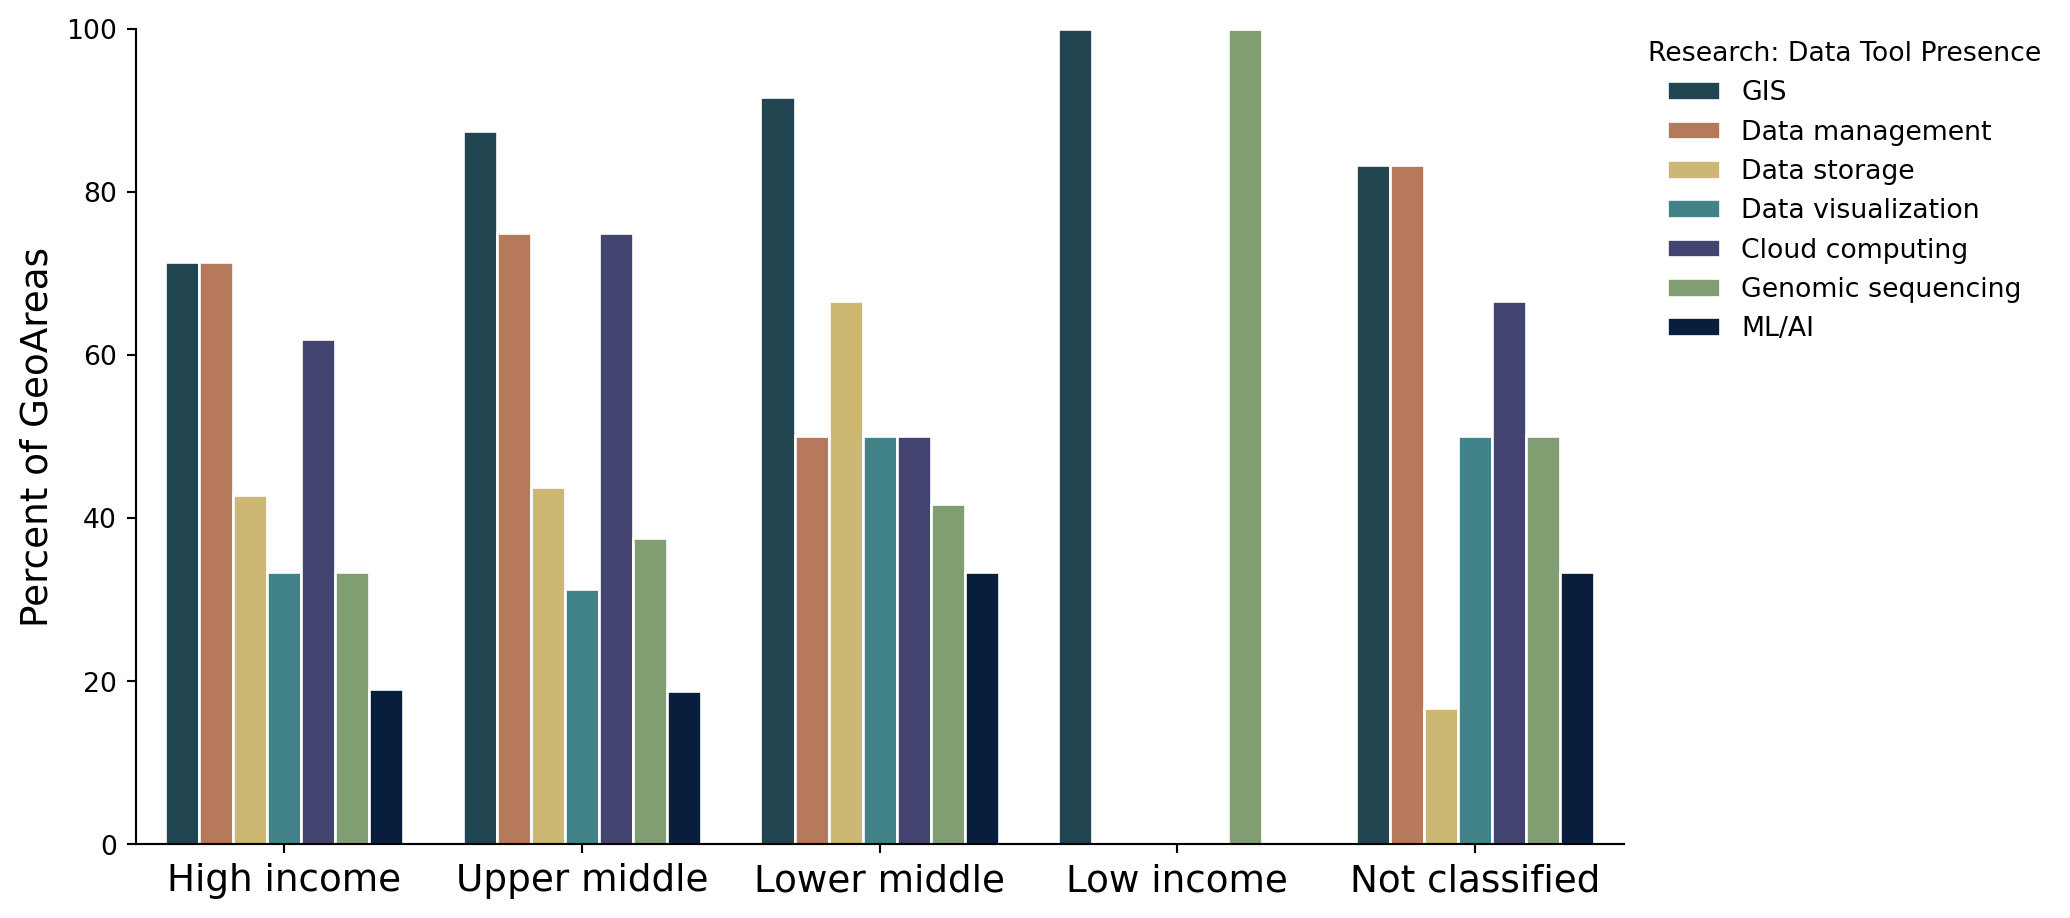

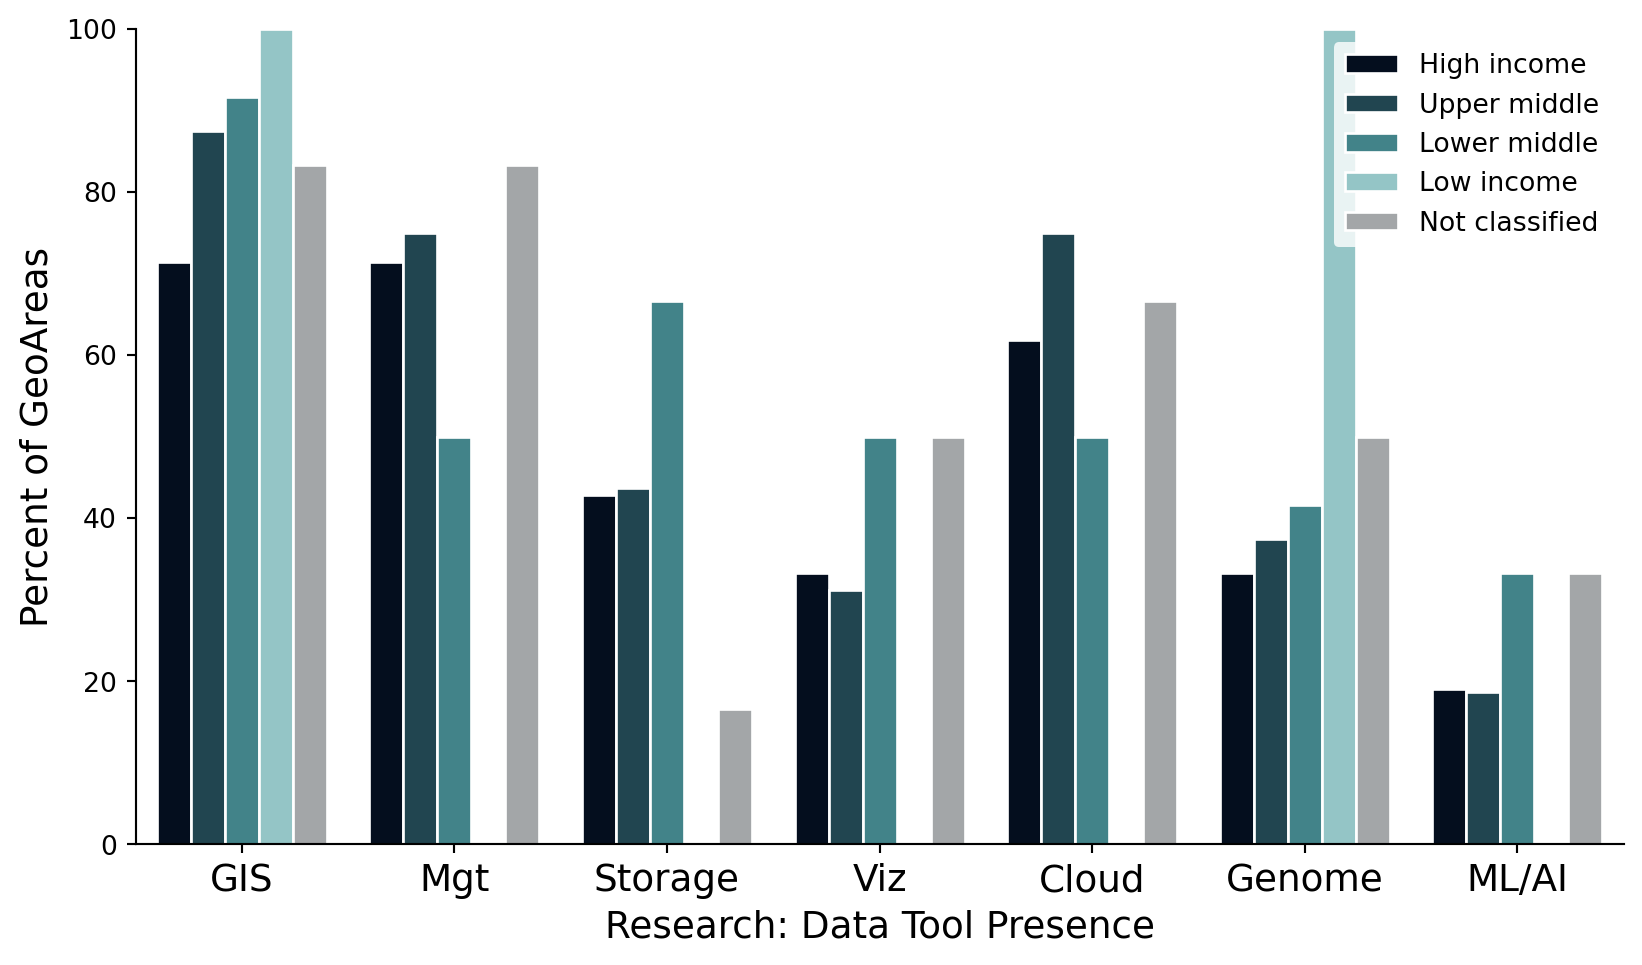

In [196]:
## Create plot

w = 1920
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
    ax = sns.barplot(x='subregion',
                     y='percent',
                     hue='col_name',
                     order=label_order[region],
                     hue_order=hue_order,
                     palette=cat_07,
                     ci=None,
                     edgecolor='white',
                     data=fig_data[region])            

    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=14)
    ax.set(xlabel=None)
    ax.set_ylim([0, 100])
    ax.set_ylabel('Percent of GeoAreas', fontsize=14)
    ax.legend(bbox_to_anchor=(1, 1.015),
              loc='upper left',
              title='Research: Data Tool Presence',
              fontsize=10,
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='9', letter='W1')

    ## W2

    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
    ax = sns.barplot(x='col_name',
                     y='percent',
                     hue='subregion',
                     order=hue_order,
                     hue_order=label_order[region],
                     palette=cat_d23e123_by_region[region],
                     ci=None,
                     edgecolor='white',
                     data=fig_data[region])            

    ax.set_xticklabels(['GIS', 'Mgt', 'Storage', 'Viz', 'Cloud', 'Genome', 'ML/AI'], rotation=0, fontsize=14)
    ax.set_xlabel('Research: Data Tool Presence', fontsize=14)
    ax.set_ylim([0, 100])
    ax.set_ylabel('Percent of GeoAreas', fontsize=14)
    ax.legend(loc='upper right',
              fontsize=10,
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='9', letter='W2')

## **Figs X1 X2**&nbsp; Q29: Data Tools Access

In [197]:
## Get data for figure - using num respondents for aggregated calculations & denominators

label_order = {}
fig_data = {}
percent_data = {}
for region in region_list:
    data_tools = dataR[region].loc[dataR[region]['question'] == 'Q29', ['subregion', 
                                                   'geoarea', 
                                                   'respondent_id', 
                                                   'selection_survey_clean']]
    data_tools = data_tools[data_tools['selection_survey_clean'] != '']
    ## Group "I don't know" and "None of the above"
    data_tools.loc[data_tools['selection_survey_clean'] == "I don't know what tools are available",
                   'selection_survey_clean'] = 'None of the above'

    vessels = dataR[region].loc[dataR[region]['question'] == 'Q24', ['subregion', 
                                                   'geoarea', 
                                                   'respondent_id', 
                                                   'selection_survey_clean']]
    vessels = vessels[vessels['selection_survey_clean'] != '']

    fig_data[region] = (data_tools.groupby(['subregion', 'selection_survey_clean'])['respondent_id']
                       .nunique()
                       .rename('count')
                       .reset_index())

    # Calculate percentages
    percent_data[region] = fig_data[region].copy()
    num_respondents_per_subregion = vessels.groupby('subregion')['respondent_id'].nunique().reset_index()
    respondent_sub_dict = dict(zip(num_respondents_per_subregion['subregion'], 
                                   num_respondents_per_subregion['respondent_id']))
    percent_data[region]['total'] = percent_data[region]['subregion']
    percent_data[region]['total'].replace(respondent_sub_dict, inplace=True)
    percent_data[region]['percent'] = round((percent_data[region]['count']/percent_data[region]['total'])*100, 2)

    renames = {
        'Geographical information systems (GIS)':   'GIS',
        'Data management tools':                    'Data management',
        'Data storage capacity':                    'Data storage',
        'Data visualization tools':                 'Data visualization',
        'Cloud computing':                          'Cloud computing',
        'Genomic sequencing':                       'Genomic sequencing',
        'Machine learning/artificial intelligence': 'ML/AI',
        'Other':                                    'Other',
        'None of the above':                        'None of the above',
    }
    hue_order = renames.values()
    percent_data[region]['selection_survey_clean'].replace(renames, inplace=True)
    percent_data[region]['subregion'].replace(label_adjustments, inplace=True)
    label_order[region] = []
    for x in orderR[region]:
        if x in label_adjustments:
            label_order[region].append(label_adjustments[x])
        else:
            label_order[region].append(x)

    pivoted = percent_data[region].pivot(columns='subregion', index='selection_survey_clean', values=['count', 'percent'])
    pivoted.loc['Total'] = num_respondents_per_subregion['respondent_id'].tolist()*2
    num_respondents = vessels['respondent_id'].nunique()
    pivoted.loc['Total', 'percent'] = round((pivoted.loc['Total', 'percent']/num_respondents)*100, 2).values

    pivoted[('count', 'Total')] = pivoted['count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_respondents)*100, 2)

    #display(pivoted)

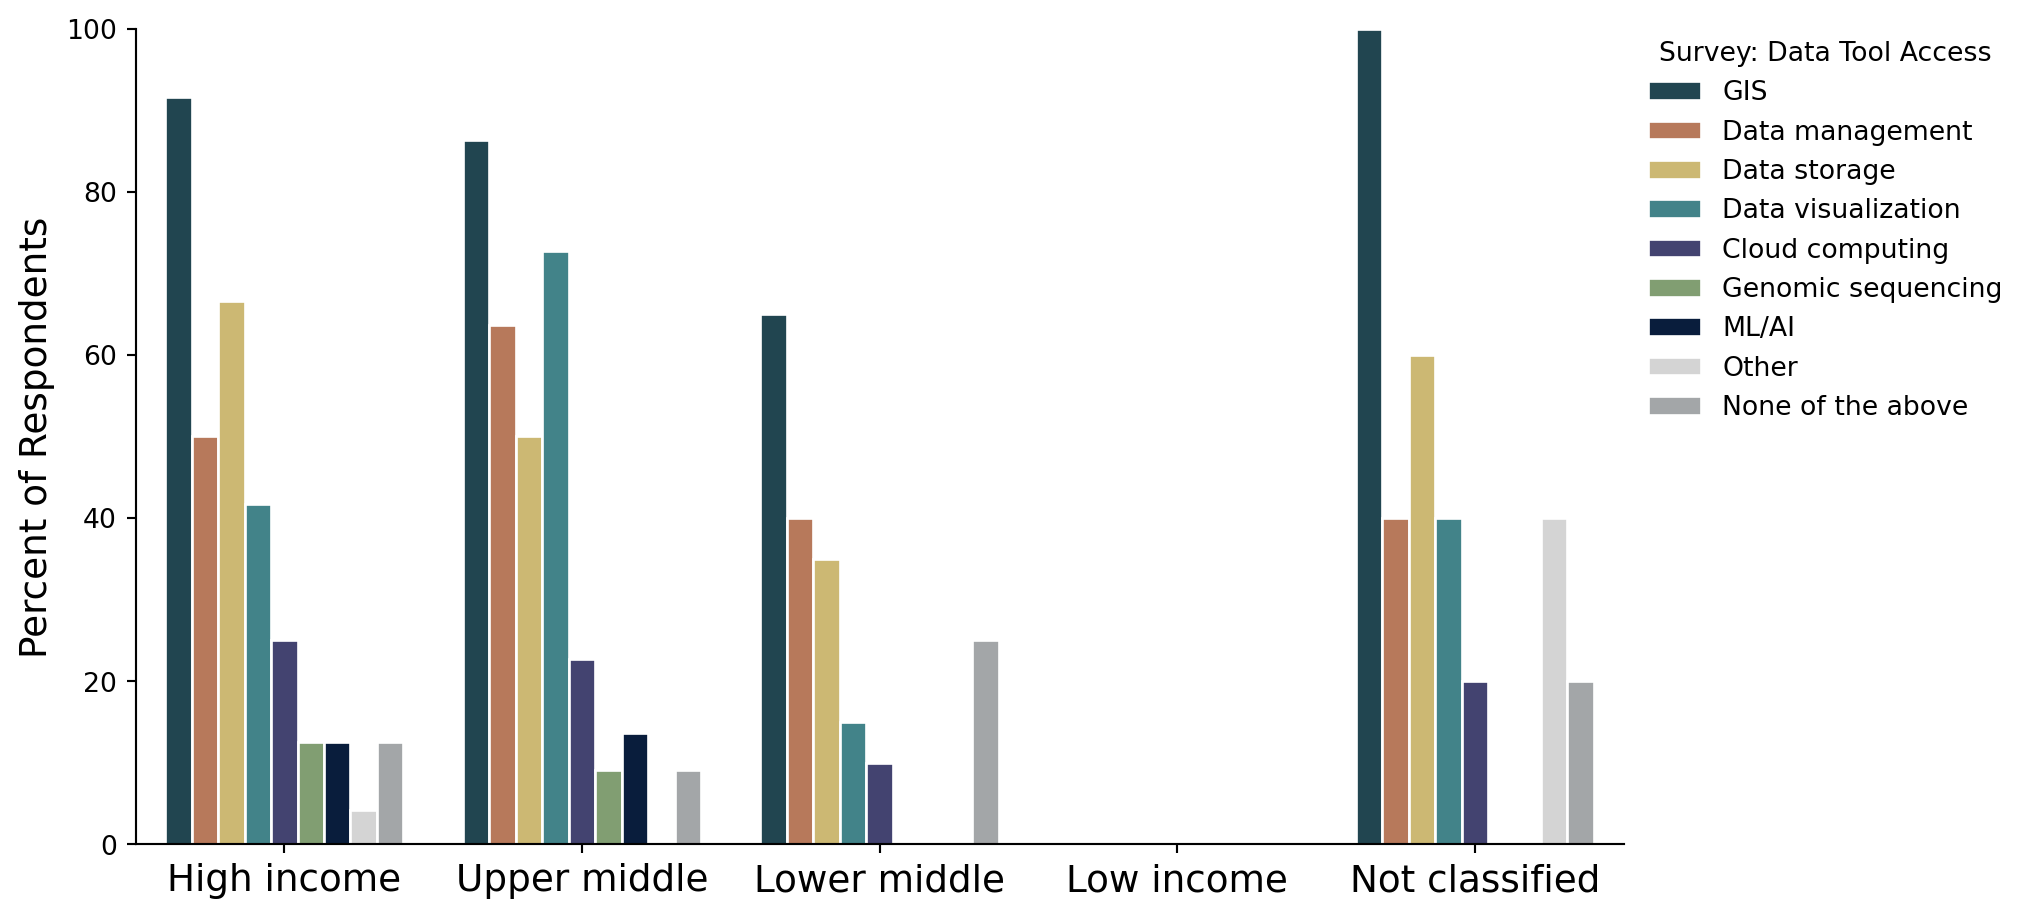

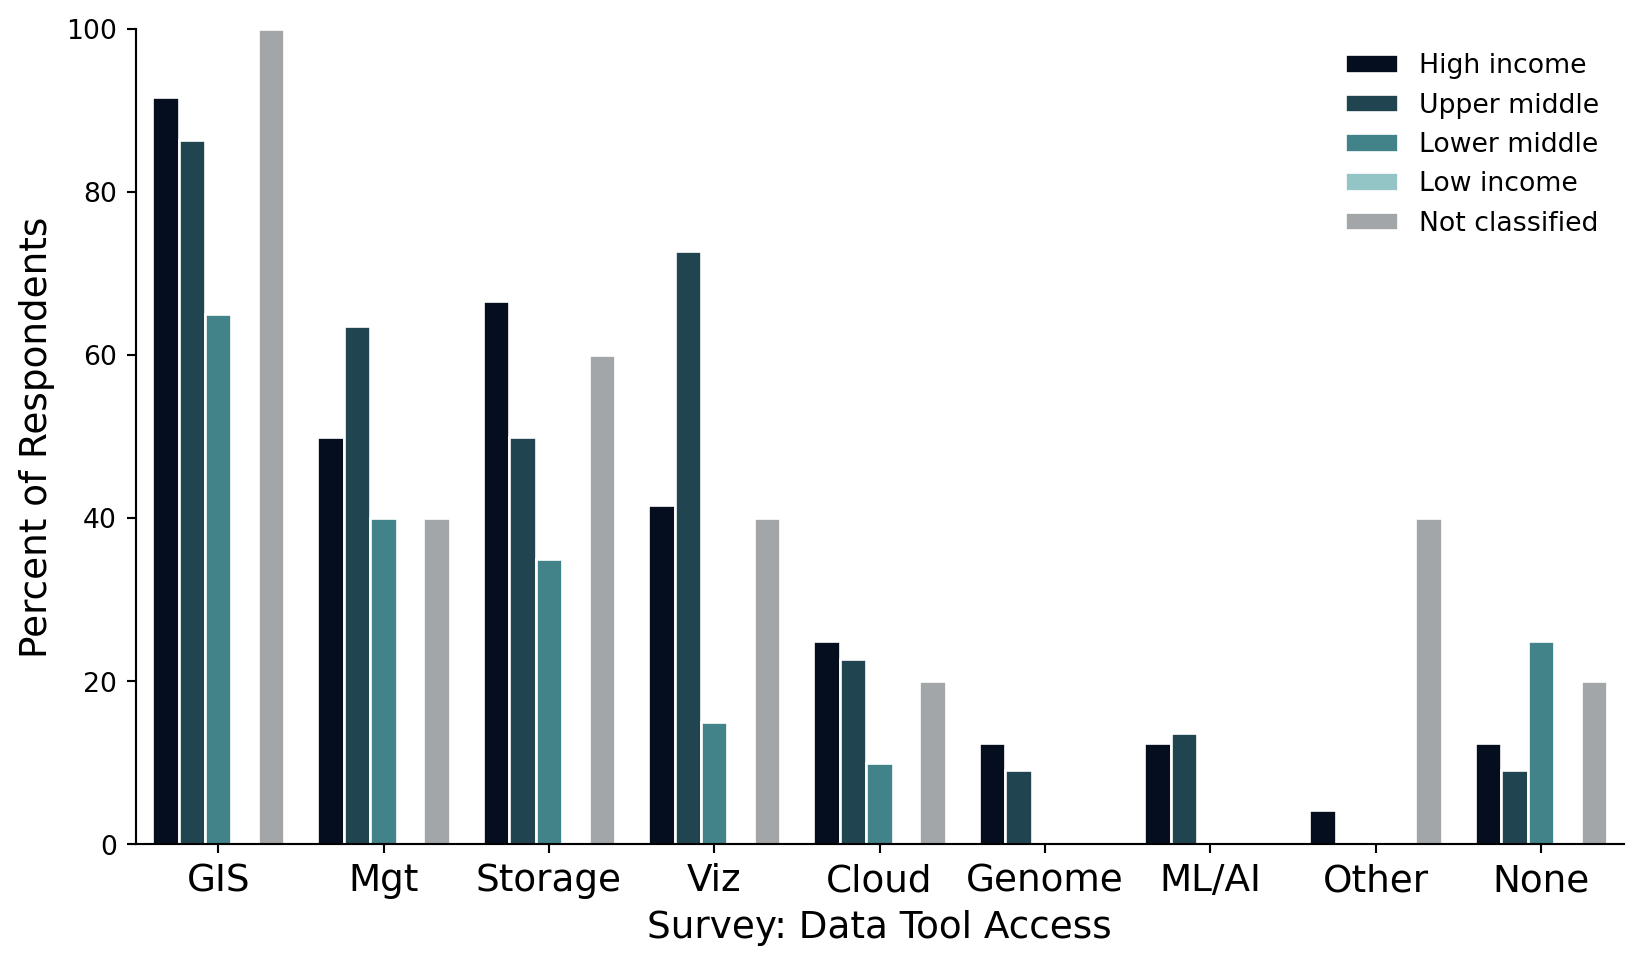

In [198]:
## Create plot

w = 1920
h = 1080

for region in region_list:
    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
    ax = sns.barplot(x='subregion',
                     y='percent',
                     hue='selection_survey_clean',
                     order=label_order[region],
                     hue_order=hue_order,
                     palette=cat_07 + ['#a2a6a9'],
                     edgecolor='white',
                     ci=None,
                     data=percent_data[region])            

    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=14)
    ax.set(xlabel=None)
    ax.set_ylim([0, 100])
    ax.set_ylabel('Percent of Respondents', fontsize=14)
    ax.legend(bbox_to_anchor=(1, 1.015), loc='upper left',
              title='Survey: Data Tool Access',
              fontsize=10,
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='9', letter='X1')

    ## X2

    fig, ax = plt.subplots(1, 1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
    ax = sns.barplot(x='selection_survey_clean',
                     y='percent',
                     hue='subregion',
                     order=hue_order,
                     hue_order=label_order[region],
                     palette=cat_d23e123_by_region[region],
                     edgecolor='white',
                     ci=None,
                     data=percent_data[region])            

    ax.set_xticklabels(['GIS', 'Mgt', 'Storage', 'Viz', 'Cloud', 'Genome', 'ML/AI', 'Other', 'None'], rotation=0, fontsize=14)
    ax.set_xlabel('Survey: Data Tool Access', fontsize=14)
    ax.set_ylim([0, 100])
    ax.set_ylabel('Percent of Respondents', fontsize=14)
    ax.legend(loc='upper right',
              fontsize=10,
              title_fontsize=10)

    outputfigs(plt, fig, ax, region, section='9', letter='X2')

## **Fig Y1**&nbsp; Q30: Data tools satisfaction

In [199]:
## Calculate values for plot


# Define scale for plot
my_scale = ['Very dissatisfied', 
            'Dissatisfied', 
            'Neutral', 
            'Satisfied', 
            'Very satisfied']

satisfaction = {}
missing_responses = {}
fig_data = {}
for region in region_list:
    ## Select data
    satisfaction[region] = dataR[region].loc[dataR[region]['question'] == 'Q30', ['col_name', 
                                                   'subregion', 
                                                   'geoarea', 
                                                   'respondent_id', 
                                                   'selection',
                                                   'selection_other']]
    satisfaction[region].loc[(satisfaction[region]['col_name'] == 'Q30_other') & 
                     (satisfaction[region]['selection'] != ''), 'selection_other'] = 'Other'

    missing_responses[region] = satisfaction[region][satisfaction[region]['selection_other'] == ''].copy()

    satisfaction[region] = satisfaction[region][~satisfaction[region]['selection_other'].isin(['Other', ''])]

    satisfaction[region]['row_num'] = np.arange(satisfaction[region].shape[0])

    fig_data[region] = satisfaction[region].pivot(columns='subregion', index='row_num', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({
                      '1 - Very dissatisfied': 'Very dissatisfied',
                      '2 - Dissatisfied': 'Dissatisfied',
                      '3 - Neither satisfied nor dissatisfied': 'Neutral',
                      '4 - Satisfied': 'Satisfied',
                      '5 - Very satisfied': 'Very satisfied'}, inplace=True)

Adding missing column Low income


In [200]:
## Calculate statistics

for region in region_list:
    ## Calculate number of people who chose NA for each question and subregion - recall that one individual could choose 
    ## NA for more than one question
    stats = missing_responses[region].groupby(['col_name', 'subregion'])['respondent_id'].nunique().rename('count').reset_index()
    stats = stats.pivot(columns='subregion', index='col_name', values='count')
    stats['Total'] = stats.sum(axis=1)
    #display(stats)

    ## Calculate the number of people who chose NA on at least one part of the question - EXCLUDING OTHER
    #display(missing_responses[region].loc[missing_responses[region]['col_name'] != 'Q30_other', 'respondent_id'].nunique())

    percent_data = (satisfaction[region].groupby(['subregion', 'selection'])['row_num']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = satisfaction[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

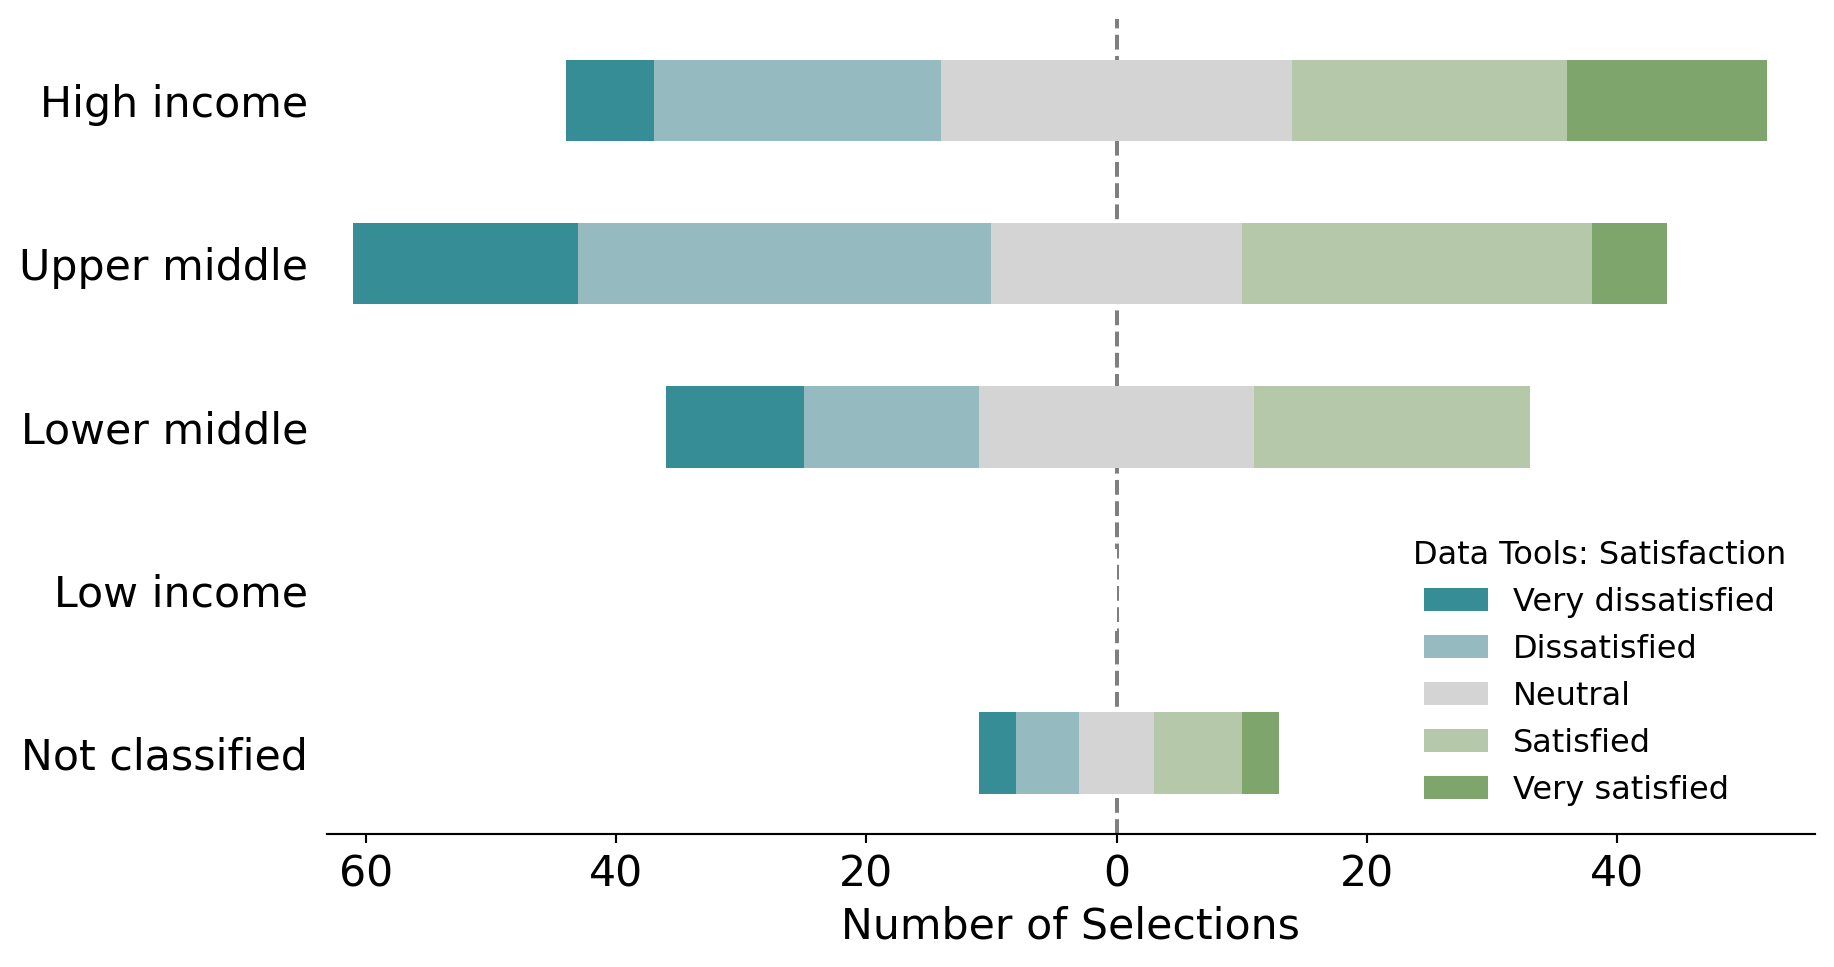

In [201]:
## Create plot

w = 1920
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region],
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Selections', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {'Global': 'upper left'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='Data Tools: Satisfaction',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='9', letter='Y1')

## **Fig Y2**&nbsp; Sensor satisfaction #2

In [202]:
## Calculate values for plot
## Note: reuses satisfaction from previous figure

# Define scale for plot
my_scale = ['Very dissatisfied', 
            'Dissatisfied', 
            'Neutral', 
            'Satisfied', 
            'Very satisfied']

fig_data = {}
for region in region_list:
    fig_data[region] = satisfaction[region].pivot(columns='col_name', index='respondent_id', values='selection')

    # Change column names
    fig_data[region].columns = ['Availability', 'Bandwidth', 'Capabilities', 'Cost', 'Ease']

    # Change column order
    sorted_cols = ['Cost', 'Availability', 'Capabilities', 'Ease', 'Bandwidth']
    fig_data[region] = reorder_columns(fig_data[region], sorted_cols)

    # Change scale values
    fig_data[region].replace({
                      '1 - Very dissatisfied': 'Very dissatisfied',
                      '2 - Dissatisfied': 'Dissatisfied',
                      '3 - Neither satisfied nor dissatisfied': 'Neutral',
                      '4 - Satisfied': 'Satisfied',
                      '5 - Very satisfied': 'Very satisfied'}, inplace=True)

In [203]:
## Calculate statistics

for region in region_list:
    percent_data = (satisfaction[region].groupby(['col_name', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['col_name']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='col_name', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = satisfaction[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

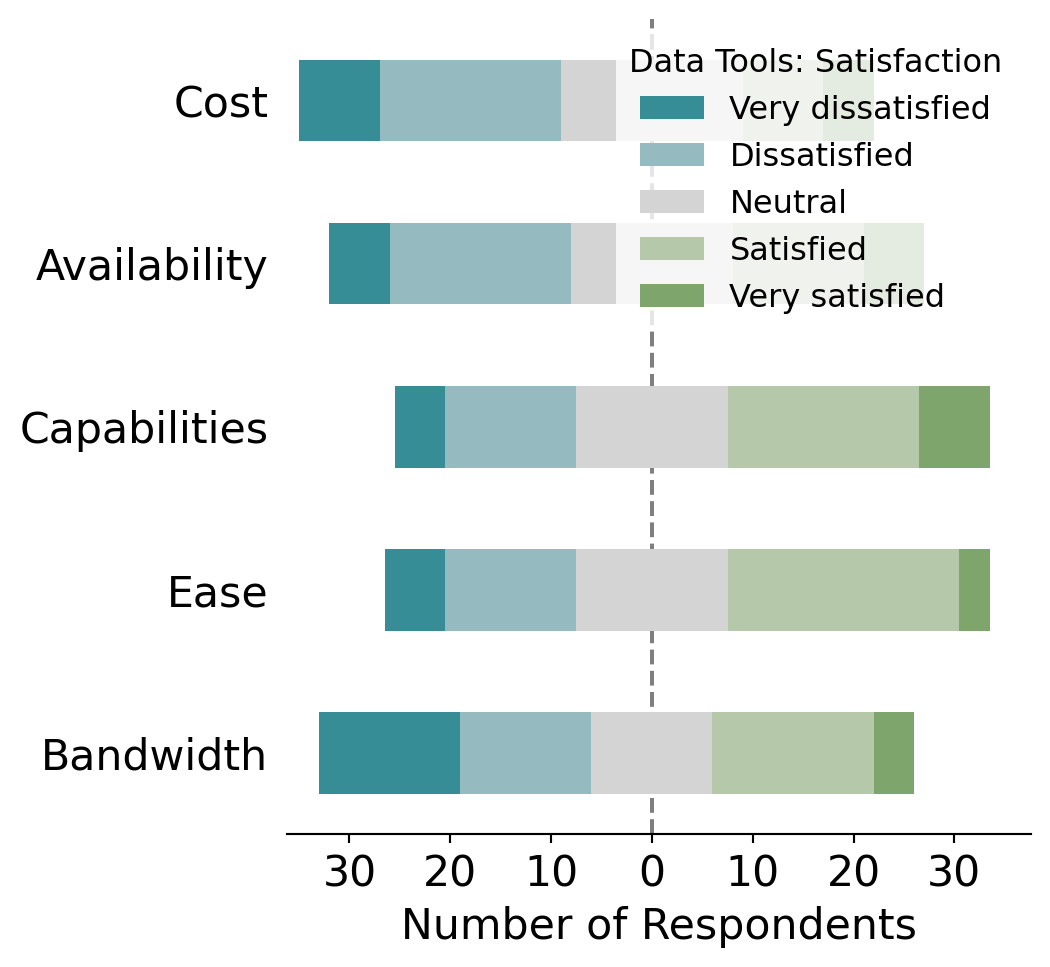

In [204]:
## Create plot

w = 960
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='Data Tools: Satisfaction',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='9', letter='Y2')

## **Fig Y3**&nbsp; Q30a: Data tools cost

In [205]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Very dissatisfied', 
            'Dissatisfied', 
            'Neutral', 
            'Satisfied', 
            'Very satisfied']

cost = {}
fig_data = {}
for region in region_list:
    ## Select relevant survey data
    cost[region] = dataR[region].loc[(dataR[region]['col_name'] == 'Q30_cost') &
                    (dataR[region]['selection'] != ''), 
                          ['respondent_id', 'subregion', 'col_name', 'selection']]

    fig_data[region] = cost[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({
                      '1 - Very dissatisfied': 'Very dissatisfied',
                      '2 - Dissatisfied': 'Dissatisfied',
                      '3 - Neither satisfied nor dissatisfied': 'Neutral',
                      '4 - Satisfied': 'Satisfied',
                      '5 - Very satisfied': 'Very satisfied'}, inplace=True)

Adding missing column Low income


In [206]:
## Calculate statistics

for region in region_list:
    percent_data = (cost[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = cost[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

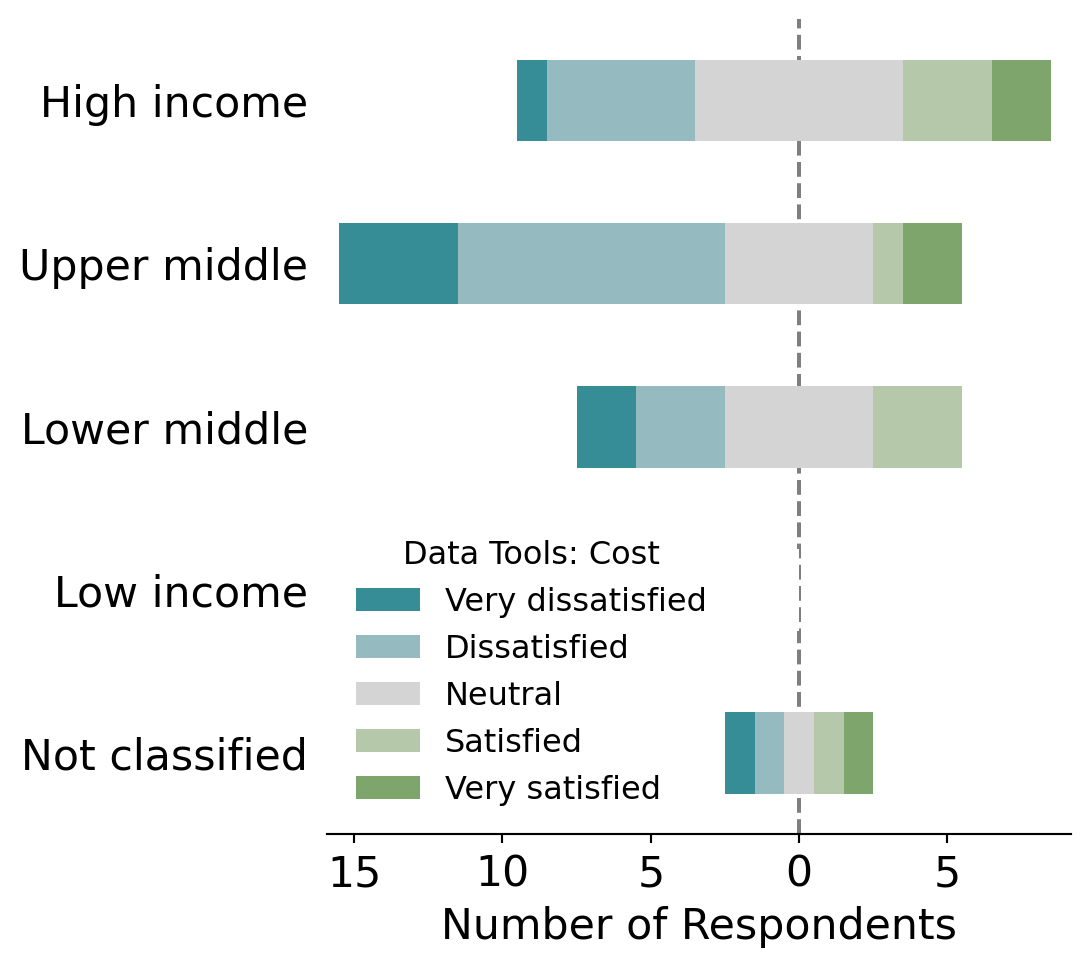

In [207]:
## Create plot

w = 960
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {'Africa': 'lower left', 'Americas': 'lower right', 'Economies': 'lower right', 'Europe': 'upper left', 'Global': 'upper left'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='Data Tools: Cost',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='9', letter='Y3')

## **Fig Y4**&nbsp; Q30b: Data tools availability

In [208]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Very dissatisfied', 
            'Dissatisfied', 
            'Neutral', 
            'Satisfied', 
            'Very satisfied']

availability = {}
fig_data = {}
for region in region_list:
    ## Select relevant survey data
    availability[region] = dataR[region].loc[(dataR[region]['col_name'] == 'Q30_availability') &
                    (dataR[region]['selection'] != ''), 
                          ['respondent_id', 'subregion', 'col_name', 'selection']]

    fig_data[region] = availability[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({
                      '1 - Very dissatisfied': 'Very dissatisfied',
                      '2 - Dissatisfied': 'Dissatisfied',
                      '3 - Neither satisfied nor dissatisfied': 'Neutral',
                      '4 - Satisfied': 'Satisfied',
                      '5 - Very satisfied': 'Very satisfied'}, inplace=True)

Adding missing column Low income


In [209]:
## Calculate statistics

for region in region_list:
    percent_data = (availability[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = availability[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

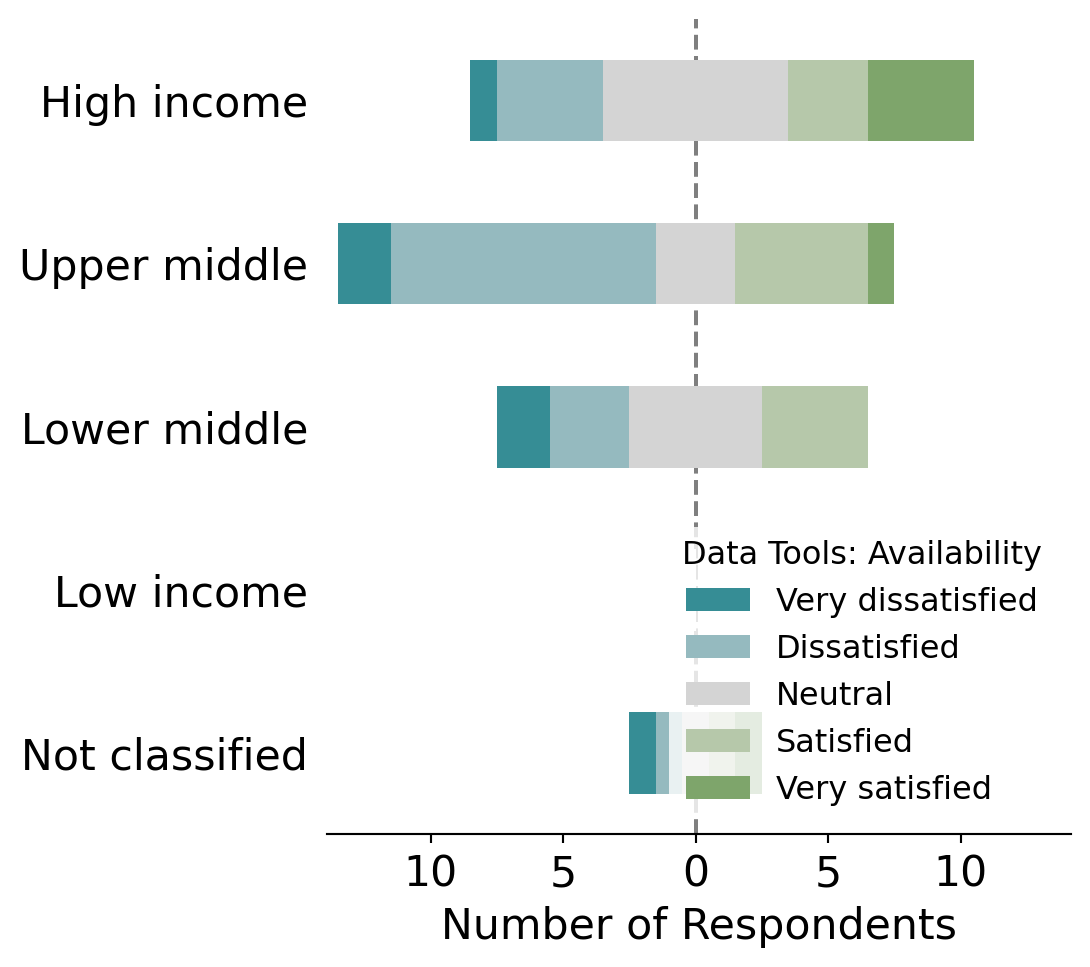

In [210]:
## Create plot

w = 960
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {'Global': 'upper left'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='Data Tools: Availability',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='9', letter='Y4')

## **Fig Y5**&nbsp; Q30c: Data tools capabilities

In [211]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Very dissatisfied', 
            'Dissatisfied', 
            'Neutral', 
            'Satisfied', 
            'Very satisfied']

capabilities = {}
fig_data = {}
for region in region_list:
## Select relevant survey data
    capabilities[region] = dataR[region].loc[(dataR[region]['col_name'] == 'Q30_capabilities') &
                    (dataR[region]['selection'] != ''), 
                          ['respondent_id', 'subregion', 'col_name', 'selection']]

    fig_data[region] = capabilities[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({
                      '1 - Very dissatisfied': 'Very dissatisfied',
                      '2 - Dissatisfied': 'Dissatisfied',
                      '3 - Neither satisfied nor dissatisfied': 'Neutral',
                      '4 - Satisfied': 'Satisfied',
                      '5 - Very satisfied': 'Very satisfied'}, inplace=True)

Adding missing column Low income


In [212]:
## Calculate statistics

for region in region_list:
    percent_data = (capabilities[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = capabilities[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

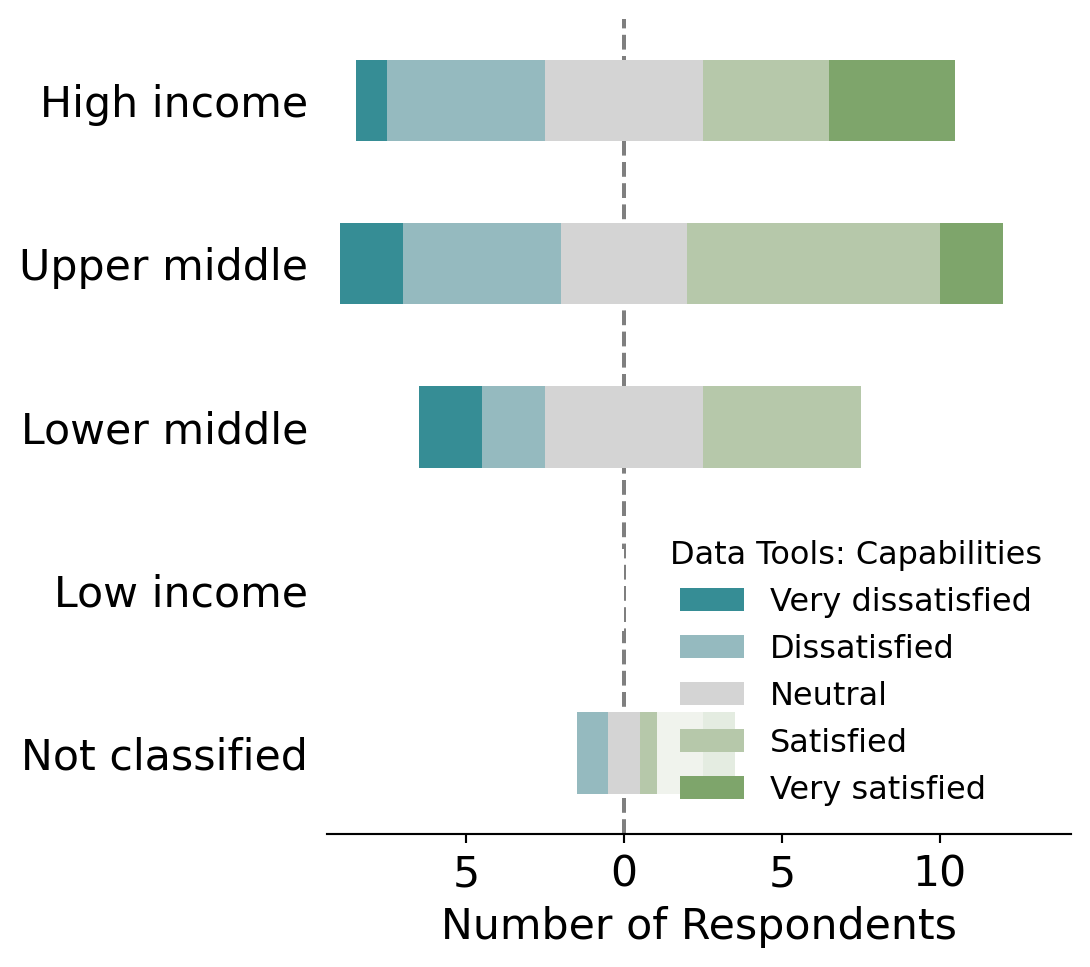

In [213]:
## Create plot

w = 960
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {'Africa': 'lower right', 'Europe': 'upper right', 'Global': 'upper left'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='Data Tools: Capabilities',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='9', letter='Y5')

## **Fig Y6**&nbsp; Q30d: Data tools ease of use

In [214]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Very dissatisfied', 
            'Dissatisfied', 
            'Neutral', 
            'Satisfied', 
            'Very satisfied']

ease = {}
fig_data = {}
for region in region_list:
    ## Select relevant survey data
    ease[region] = dataR[region].loc[(dataR[region]['col_name'] == 'Q30_ease') &
                    (dataR[region]['selection'] != ''), 
                          ['respondent_id', 'subregion', 'col_name', 'selection']]

    fig_data[region] = ease[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({
                      '1 - Very dissatisfied': 'Very dissatisfied',
                      '2 - Dissatisfied': 'Dissatisfied',
                      '3 - Neither satisfied nor dissatisfied': 'Neutral',
                      '4 - Satisfied': 'Satisfied',
                      '5 - Very satisfied': 'Very satisfied'}, inplace=True)

Adding missing column Low income


In [215]:
## Calculate statistics

for region in region_list:
    percent_data = (ease[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = ease[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

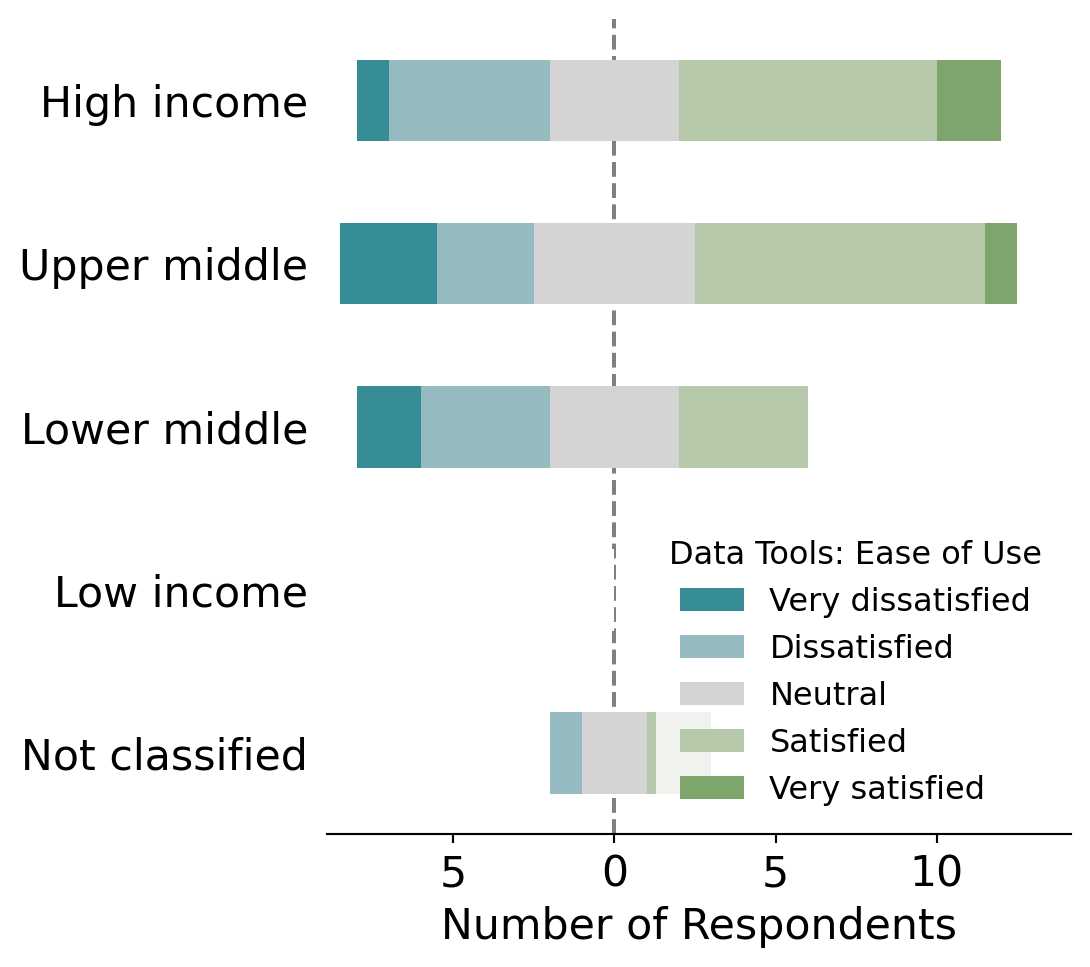

In [216]:
## Create plot

w = 960
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {'Africa': 'lower right', 'Europe': 'upper right', 'Global': 'upper left'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='Data Tools: Ease of Use',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='9', letter='Y6')

## **Fig Y7**&nbsp; Q30e: Data tools bandwidth

In [217]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Very dissatisfied', 
            'Dissatisfied', 
            'Neutral', 
            'Satisfied', 
            'Very satisfied']

bandwidth = {}
fig_data = {}
for region in region_list:
    ## Select relevant survey data
    bandwidth[region] = dataR[region].loc[(dataR[region]['col_name'] == 'Q30_bandwidth') &
                    (dataR[region]['selection'] != ''), 
                          ['respondent_id', 'subregion', 'col_name', 'selection']]

    fig_data[region] = bandwidth[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({
                      '1 - Very dissatisfied': 'Very dissatisfied',
                      '2 - Dissatisfied': 'Dissatisfied',
                      '3 - Neither satisfied nor dissatisfied': 'Neutral',
                      '4 - Satisfied': 'Satisfied',
                      '5 - Very satisfied': 'Very satisfied'}, inplace=True)

Adding missing column Low income


In [218]:
## Calculate statistics

for region in region_list:
    percent_data = (bandwidth[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = bandwidth[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

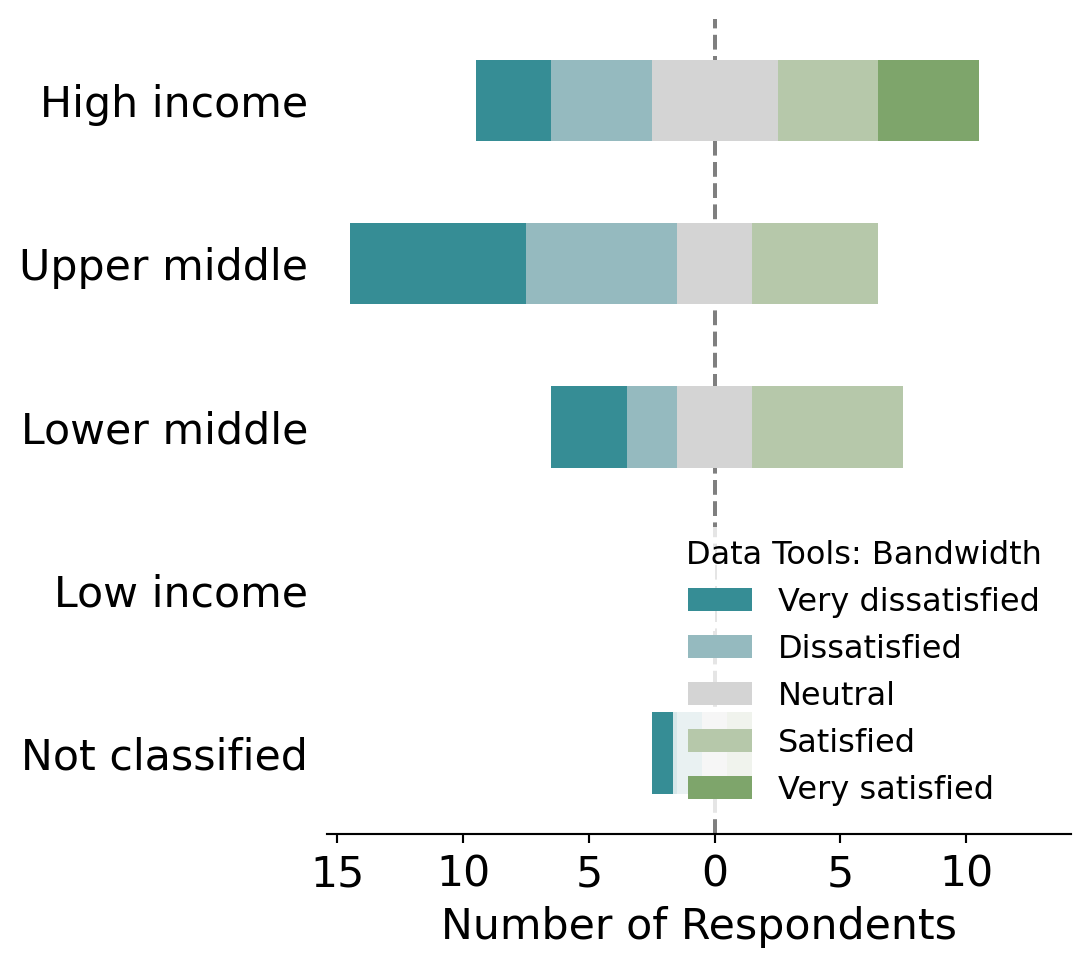

In [219]:
## Create plot

w = 960
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {'Europe': 'upper left', 'Global': 'upper left'}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='Data Tools: Bandwidth',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='9', letter='Y7')

## **Fig Z1**&nbsp; Q28: Data tools importance

In [220]:
## Calculate values for plot

# Define scale for plot
my_scale = ['Not important', 
            'A little important', 
            'Somewhat important',
            'Important',
            'Very important']

importance = {}
fig_data = {}
for region in region_list:
    ## Select relevant survey data
    importance[region] = dataR[region].loc[(dataR[region]['question'] == 'Q28'), ['respondent_id', 'subregion', 'col_name', 'selection']]

    fig_data[region] = importance[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({
                      '1 - Not important': 'Not important',
                      '2 - A little important': 'A little important',
                      '3 - Somewhat important': 'Somewhat important',
                      '4 - Important': 'Important',
                      '5 - Very important': 'Very important'}, inplace=True)

Adding missing column Low income


In [221]:
## Calculate statistics

for region in region_list:
    percent_data = (importance[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = importance[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

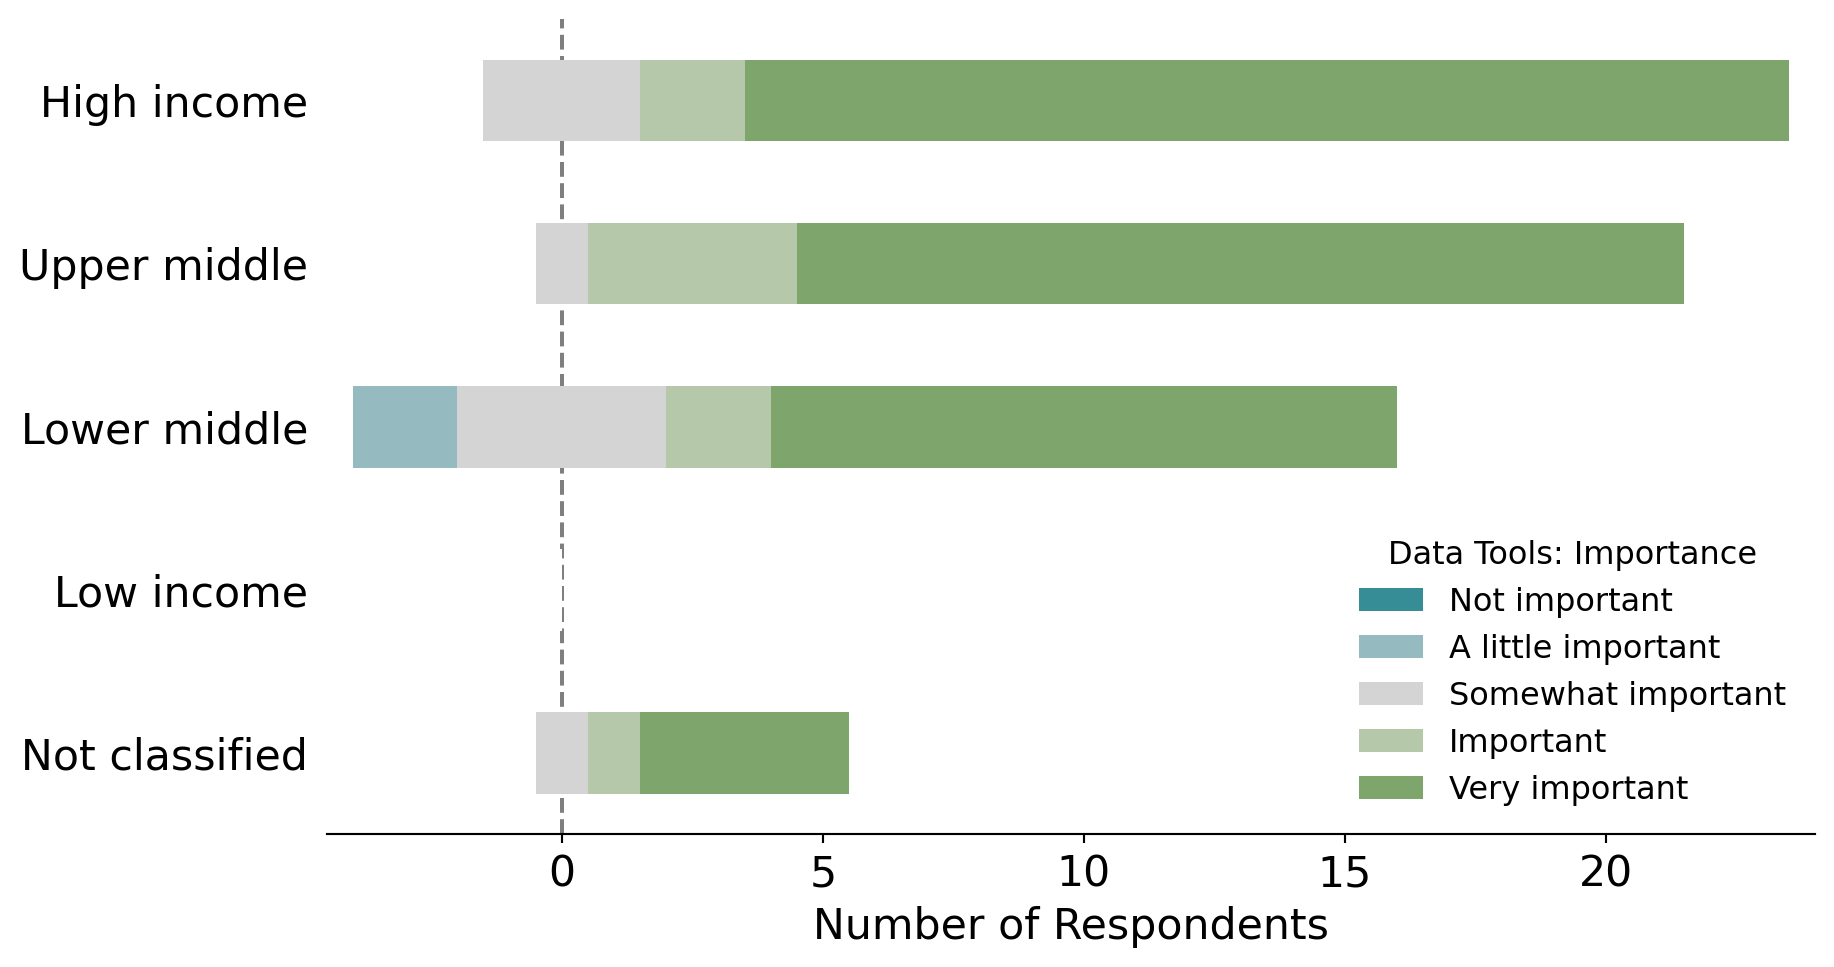

In [222]:
## Create plot

w = 1920
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='Data Tools: Importance',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='9', letter='Z1')

## **Fig Z2**&nbsp; Q31: Data tools potential

In [223]:
## Calculate values for plot

# Define scale for plot
my_scale = ['No impact', 
            'Little impact', 
            'Moderate impact',
            'High impact',
            'Transformative']

potential = {}
fig_data = {}
for region in region_list:
    ## Select relevant survey data
    potential[region] = dataR[region].loc[(dataR[region]['question'] == 'Q31'), ['respondent_id', 'subregion', 'col_name', 'selection']]

    fig_data[region] = potential[region].pivot(columns='subregion', index='respondent_id', values='selection')
    fig_data[region] = prep_fig_data_for_plotting(fig_data[region], region, axis='columns')

    # Change scale values
    fig_data[region].replace({
                      '1 - No impact': 'No impact',
                      '2 - Little impact': 'Little impact',
                      '3 - Moderate impact': 'Moderate impact',
                      '4 - High impact': 'High impact',
                      '5 - Transformative': 'Transformative'}, inplace=True)

Adding missing column Low income


In [224]:
## Calculate statistics

for region in region_list:
    percent_data = (potential[region].groupby(['subregion', 'selection'])['respondent_id']
                              .count()
                              .rename('count')
                              .reset_index())
    percent_data['total'] = percent_data['count'].groupby(percent_data['subregion']).transform('sum')
    percent_data['percent'] = round((percent_data['count']/percent_data['total'])*100, 2)

    pivoted = percent_data.pivot(columns='subregion', index='selection', values=['count', 'percent'])
    pivoted.loc['Total'] = pivoted.sum()

    num_responses = potential[region].shape[0]
    pivoted[('count', 'Total')] = pivoted.loc[:, 'count'].sum(axis=1)
    pivoted[('percent', 'Total')] = round((pivoted[('count', 'Total')]/num_responses)*100, 2)

    #display(pivoted)

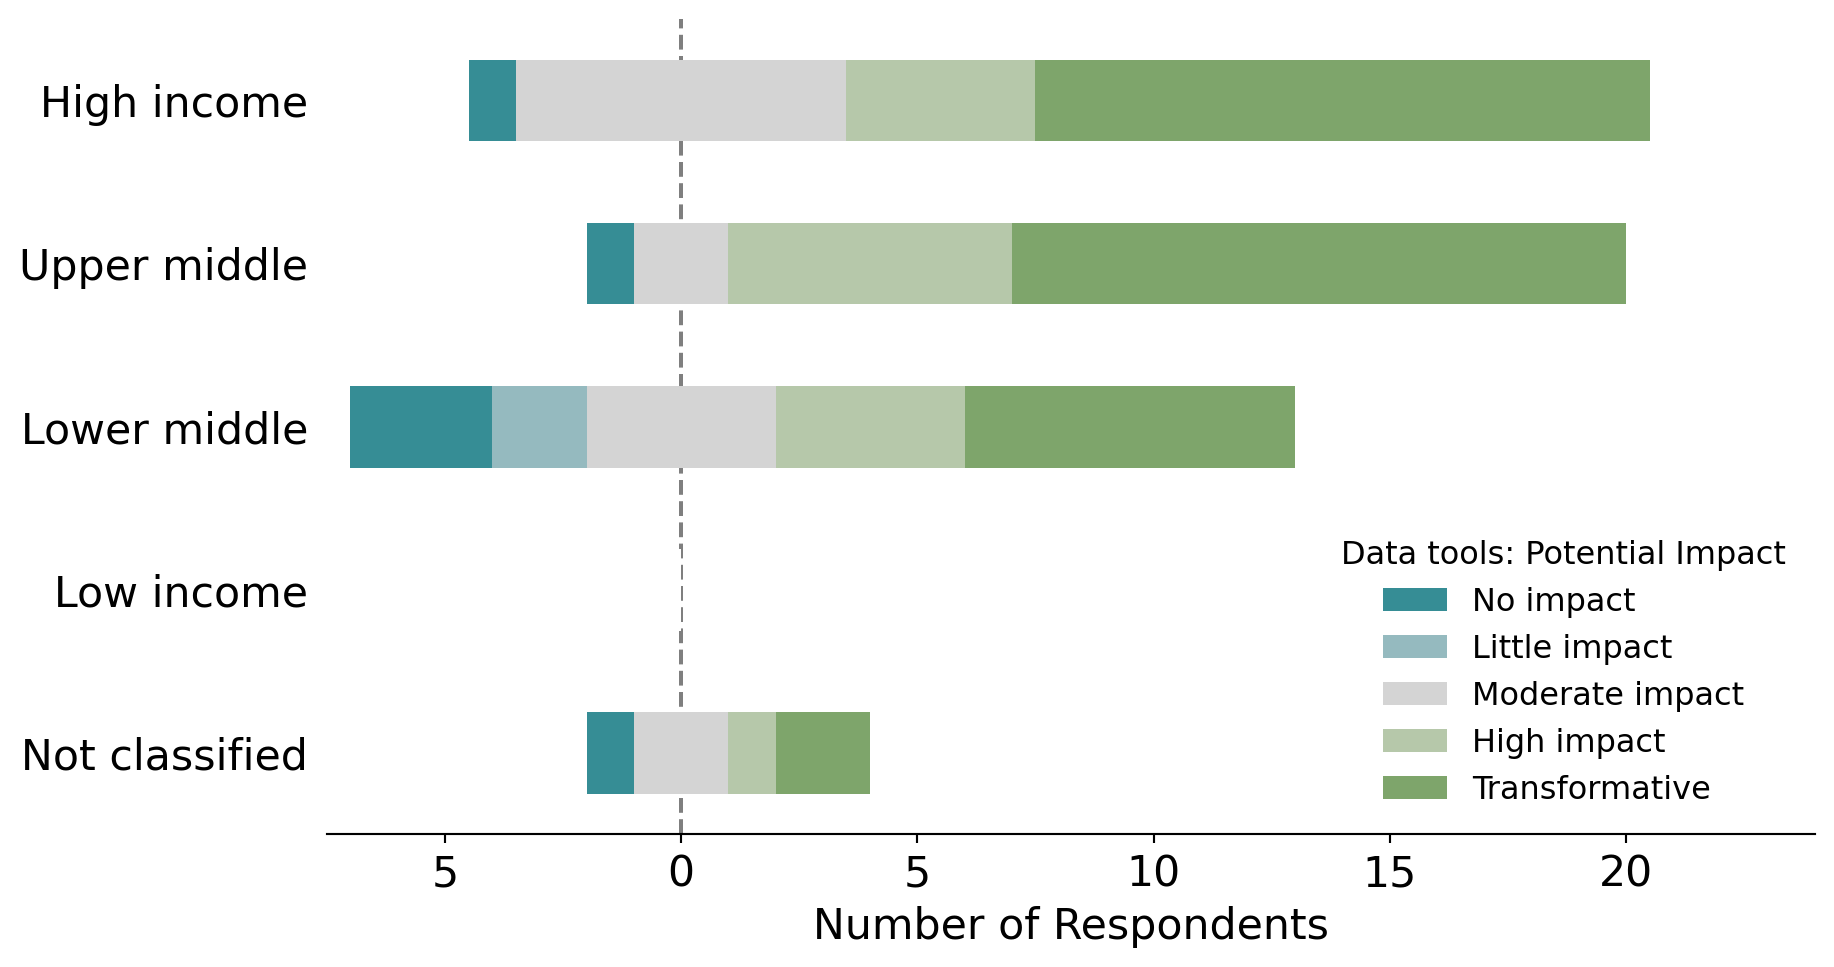

In [225]:
## Create plot

w = 1920
h = 1080

for region in region_list:
    ax = my_plot_likert(fig_data[region], 
                                 my_scale, 
                                 figsize=((w/my_dpi), (h/my_dpi)))
    ax.set_xlabel('Number of Respondents', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    loc_tweaks = {}
    ax.legend(loc=loc_tweaker(region, loc_tweaks),
              title='Data tools: Potential Impact',
              fontsize=12,
              title_fontsize=12)

    outputfigs(plt, False, ax, region, section='9', letter='Z2')